In [1]:
!pip install opencv-python face_alignment scikit-image


In [2]:
!pip install torch torchvision

In [3]:
!pip install mediapipe

In [4]:
import face_alignment
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp

mp_face_detection = mp.solutions.face_detection

def align_and_resize_face(image, output_size=(256, 256), top_padding_ratio=0.3):
    #image = cv2.imread(image_path)  # BGR format
    with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:
        if image is None:
            return None
            
        results = face_detection.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert to RGB for Mediapipe

        if not results.detections:
            print("No face detected.")
            return None
        

        # Extract bounding box
        detection = results.detections[0]
        bboxC = detection.location_data.relative_bounding_box
        ih, iw, _ = image.shape
        x, y, w, h = int(bboxC.xmin * iw), int(bboxC.ymin * ih), int(bboxC.width * iw), int(bboxC.height * ih)

        # Add padding only to the top (for hair)
        padding_top = int(h * top_padding_ratio)  # Add padding to the top
        y = max(0, y - padding_top)  # Shift the top boundary up
        h = h + padding_top  # Increase height after padding

        # Ensure the crop is square (make width equal to height)
        center_x = x + w // 2  # Find the center of the face horizontally
        size = max(w, h)  # Square size (largest side to ensure it stays square)

        # Calculate new square bounding box coordinates
        x = max(0, center_x - size // 2)
        y = max(0, y)
        x2 = min(iw, x + size)
        y2 = min(ih, y + size)

        # Crop and resize
        face = image[y:y2, x:x2]
        resized_face = cv2.resize(face, output_size)

        # Convert BGR to RGB for correct display
        resized_face_rgb = cv2.cvtColor(resized_face, cv2.COLOR_BGR2RGB)
        return resized_face_rgb


2025-01-06 12:46:01.529956: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736167561.583732    1707 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736167561.600025    1707 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-06 12:46:01.736253: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


I0000 00:00:1736167574.370463    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167574.431644    4028 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1736167574.472091    4026 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


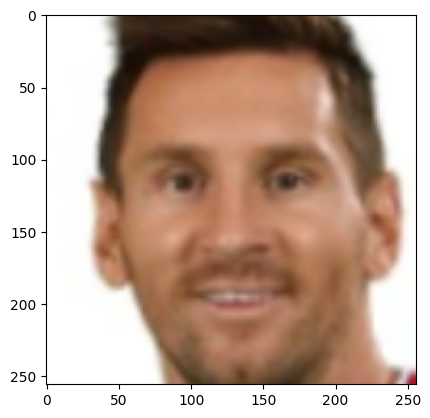

In [5]:
import face_alignment
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

fa = face_alignment.FaceAlignment(face_alignment.LandmarksType.TWO_D, device='cpu')

def align_face(image_path, output_size=(256, 256)):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    landmarks = fa.get_landmarks(image_rgb)
    if landmarks is None:
        print("No face detected in:", image_path)
        return None

    landmarks = landmarks[0]  
    left_eye = np.mean(landmarks[36:42], axis=0)  
    right_eye = np.mean(landmarks[42:48], axis=0)  

    eye_center = (left_eye + right_eye) / 2

    delta_x = right_eye[0] - left_eye[0]
    delta_y = right_eye[1] - left_eye[1]
    angle = np.degrees(np.arctan2(delta_y, delta_x))

    M = cv2.getRotationMatrix2D(tuple(eye_center), angle, 1)

    aligned_image = cv2.warpAffine(image_rgb, M, (image.shape[1], image.shape[0]))

    h, w, _ = aligned_image.shape
    crop_size = min(h, w)
    center_x, center_y = w // 2, h // 2
    cropped_face = aligned_image[center_y - crop_size // 2:center_y + crop_size // 2,
                                  center_x - crop_size // 2:center_x + crop_size // 2]
    resized_face = cv2.resize(cropped_face, output_size)
    resized_face = cv2.cvtColor(resized_face, cv2.COLOR_BGR2RGB)

    return resized_face



# Example usage
aligned_face = align_and_resize_face(align_face("data/images/154.png")) 
if aligned_face is not None:
    plt.imshow( aligned_face)
    plt.show()
    cv2.imwrite("data/new_images/154.png",cv2.cvtColor(aligned_face, cv2.COLOR_BGR2RGB))

In [6]:
from tqdm import tqdm

def process_images(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    for filename in tqdm(os.listdir(input_folder)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)

            try:
                aligned_face = align_and_resize_face(align_face(input_path))
            except:
                pass
            if aligned_face is not None:
                cv2.imwrite(output_path, cv2.cvtColor(aligned_face, cv2.COLOR_RGB2BGR))
            else:
                print(f"Skipped (no face detected): {filename}")
                

input_folder = "data/images"
output_folder = "data/new_images"

process_images(input_folder, output_folder)


  0%|          | 0/14726 [00:00<?, ?it/s]I0000 00:00:1736167575.072809    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167575.088082    4046 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167575.102500    4041 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  0%|          | 1/14726 [00:00<1:33:00,  2.64it/s]I0000 00:00:1736167575.303997    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167575.313965    4054 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167575.327865    4049 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  0%|          | 2/14726 [00:00<1:10:49,  3.46it/s

I0000 00:00:1736167575.752778    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167575.762240    4070 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167575.775924    4065 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  0%|          | 4/14726 [00:01<1:00:02,  4.09it/s]I0000 00:00:1736167575.954969    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167575.964783    4078 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167575.974217    4073 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  0%|          | 5/14726 [00:01<55:56,  4.39it/s]  I0000 00:00:1736167576.152173    1707 gl

No face detected.
Skipped (no face detected): 101331.png


I0000 00:00:1736167584.053085    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167584.062579    4582 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167584.071969    4577 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  0%|          | 42/14726 [00:09<1:00:17,  4.06it/s]I0000 00:00:1736167584.343625    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167584.355680    4590 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167584.371537    4584 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  0%|          | 43/14726 [00:09<1:01:34,  3.97it/s]I0000 00:00:1736167584.603497    1707 

No face detected.
Skipped (no face detected): 101377.png


  0%|          | 49/14726 [00:11<55:22,  4.42it/s]I0000 00:00:1736167585.980046    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167585.989739    4652 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167585.999141    4647 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  0%|          | 50/14726 [00:11<53:13,  4.60it/s]I0000 00:00:1736167586.169619    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167586.179040    4660 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167586.188325    4655 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  0%|          | 51/14726 [00:11<51:06,  4

No face detected.
Skipped (no face detected): 104311.png


I0000 00:00:1736167601.044821    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167601.054325    5520 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167601.063471    5515 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  1%|          | 118/14726 [00:26<56:20,  4.32it/s]I0000 00:00:1736167601.257857    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167601.267524    5528 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167601.276856    5523 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  1%|          | 120/14726 [00:26<42:19,  5.75it/s]I0000 00:00:1736167601.462469    1707 gl

No face detected.
Skipped (no face detected): 104798.png


  1%|          | 131/14726 [00:28<48:25,  5.02it/s]I0000 00:00:1736167603.735605    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167603.745535    5636 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167603.755357    5631 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  1%|          | 132/14726 [00:29<52:35,  4.62it/s]I0000 00:00:1736167603.951311    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167603.961245    5644 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167603.970433    5639 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  1%|          | 133/14726 [00:29<52:23,

No face detected.
Skipped (no face detected): 104822.png


I0000 00:00:1736167608.738038    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167608.747546    5924 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167608.756975    5919 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  1%|          | 155/14726 [00:34<50:48,  4.78it/s]I0000 00:00:1736167608.988480    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167609.000365    5932 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167609.014745    5925 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  1%|          | 156/14726 [00:34<1:00:41,  4.00it/s]I0000 00:00:1736167609.344359    1707 

No face detected.
Skipped (no face detected): 104834.png


  1%|          | 167/14726 [00:36<49:55,  4.86it/s]I0000 00:00:1736167611.800500    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167611.810025    6132 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167611.819511    6128 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  1%|          | 168/14726 [00:37<49:18,  4.92it/s]I0000 00:00:1736167612.029340    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167612.038892    6140 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167612.048221    6135 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  1%|          | 169/14726 [00:37<51:06,

No face detected.
Skipped (no face detected): 104860.png


I0000 00:00:1736167617.305069    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167617.314564    6336 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167617.323691    6331 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  1%|▏         | 192/14726 [00:42<51:02,  4.75it/s]I0000 00:00:1736167617.493962    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167617.503279    6344 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167617.512609    6339 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  1%|▏         | 193/14726 [00:42<49:27,  4.90it/s]I0000 00:00:1736167617.688131    1707 gl

No face detected.
Skipped (no face detected): 105111.png


  2%|▏         | 240/14726 [00:52<48:33,  4.97it/s]I0000 00:00:1736167627.757670    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167627.766986    6764 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167627.776221    6759 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  2%|▏         | 241/14726 [00:53<47:27,  5.09it/s]I0000 00:00:1736167627.928069    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167627.943496    6772 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167627.952889    6767 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  2%|▏         | 242/14726 [00:53<46:02,

No face detected.
Skipped (no face detected): 105243.png


I0000 00:00:1736167630.364434    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167630.374413    6856 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167630.383880    6851 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  2%|▏         | 251/14726 [00:55<1:14:55,  3.22it/s]I0000 00:00:1736167630.569178    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167630.580290    6864 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167630.589852    6859 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  2%|▏         | 252/14726 [00:55<1:07:14,  3.59it/s]I0000 00:00:1736167630.776079    170

No face detected.
Skipped (no face detected): 105254.png


I0000 00:00:1736167632.682448    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167632.691803    7050 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167632.700884    7045 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  2%|▏         | 263/14726 [00:57<44:41,  5.39it/s]I0000 00:00:1736167632.878924    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167632.888325    7058 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167632.897468    7053 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  2%|▏         | 264/14726 [00:58<45:29,  5.30it/s]I0000 00:00:1736167633.094637    1707 gl

No face detected.
Skipped (no face detected): 105261.png


I0000 00:00:1736167634.135989    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167634.146949    7098 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167634.158134    7093 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  2%|▏         | 269/14726 [00:59<58:30,  4.12it/s]

No face detected.
Skipped (no face detected): 105262.png


I0000 00:00:1736167634.402897    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167634.413342    7112 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167634.424107    7106 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  2%|▏         | 270/14726 [00:59<1:00:34,  3.98it/s]I0000 00:00:1736167634.666624    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167634.676439    7120 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167634.686762    7115 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  2%|▏         | 271/14726 [00:59<1:01:13,  3.94it/s]I0000 00:00:1736167634.927323    170

No face detected.
Skipped (no face detected): 105276.png


I0000 00:00:1736167637.594249    7322 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167637.603643    7317 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  2%|▏         | 284/14726 [01:02<50:52,  4.73it/s]I0000 00:00:1736167637.783349    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167637.792774    7330 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167637.801946    7325 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  2%|▏         | 285/14726 [01:03<49:54,  4.82it/s]I0000 00:00:1736167637.973081    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167637.982957    7338 gl

No face detected.
Skipped (no face detected): 105280.png
No face detected.
Skipped (no face detected): 105281.png


I0000 00:00:1736167638.587745    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167638.600666    7368 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167638.610475    7363 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  2%|▏         | 289/14726 [01:03<50:46,  4.74it/s]I0000 00:00:1736167638.796786    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167638.806136    7376 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167638.815364    7371 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  2%|▏         | 290/14726 [01:04<50:17,  4.78it/s]I0000 00:00:1736167638.993561    1707 gl

No face detected.
Skipped (no face detected): 105285.png


I0000 00:00:1736167639.512725    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167639.522450    7400 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167639.531781    7396 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  2%|▏         | 293/14726 [01:04<55:57,  4.30it/s]I0000 00:00:1736167639.791868    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167639.806493    7408 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167639.820922    7404 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  2%|▏         | 294/14726 [01:05<1:06:33,  3.61it/s]I0000 00:00:1736167640.156765    1707 

No face detected.
Skipped (no face detected): 105288.png


I0000 00:00:1736167640.364740    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167640.374837    7424 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167640.384149    7419 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  2%|▏         | 296/14726 [01:05<1:00:46,  3.96it/s]

No face detected.
Skipped (no face detected): 105290.png


I0000 00:00:1736167640.599161    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167640.608687    7438 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167640.617851    7433 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  2%|▏         | 297/14726 [01:05<59:31,  4.04it/s]  I0000 00:00:1736167640.818666    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167640.828115    7446 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167640.837268    7441 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  2%|▏         | 298/14726 [01:06<57:32,  4.18it/s]I0000 00:00:1736167640.995915    1707 

No face detected.
Skipped (no face detected): 105293.png


I0000 00:00:1736167641.377251    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167641.386721    7470 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167641.395795    7465 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  2%|▏         | 301/14726 [01:06<49:22,  4.87it/s]I0000 00:00:1736167641.576173    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167641.585748    7478 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167641.595163    7473 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  2%|▏         | 302/14726 [01:06<48:42,  4.94it/s]I0000 00:00:1736167641.772464    1707 gl

No face detected.
Skipped (no face detected): 105296.png
No face detected.
Skipped (no face detected): 105298.png


I0000 00:00:1736167642.027984    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167642.037635    7586 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167642.046916    7581 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  2%|▏         | 304/14726 [01:07<52:24,  4.59it/s]libpng warning: iCCP: known incorrect sRGB profile
I0000 00:00:1736167642.202669    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167642.212163    7594 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167642.221318    7589 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  2%|▏         | 305/14726 [01:07<49:14,

No face detected.
Skipped (no face detected): 105307.png


I0000 00:00:1736167643.951710    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167643.961648    7664 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167643.970877    7663 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  2%|▏         | 313/14726 [01:09<53:50,  4.46it/s]

No face detected.
Skipped (no face detected): 105308.png


I0000 00:00:1736167644.205755    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167644.216686    7672 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167644.231896    7668 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  2%|▏         | 314/14726 [01:09<56:29,  4.25it/s]

No face detected.
Skipped (no face detected): 105309.png


I0000 00:00:1736167644.470427    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167644.480274    7680 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167644.489578    7675 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  2%|▏         | 315/14726 [01:09<58:14,  4.12it/s]I0000 00:00:1736167644.728759    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167644.740747    7694 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167644.754068    7690 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  2%|▏         | 316/14726 [01:10<1:08:58,  3.48it/s]I0000 00:00:1736167645.125589    1707 

No face detected.
Skipped (no face detected): 107275.png


I0000 00:00:1736167660.384292    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167660.393849    8540 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167660.403159    8535 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  3%|▎         | 382/14726 [01:25<1:08:21,  3.50it/s]I0000 00:00:1736167660.603430    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167660.613017    8548 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167660.622270    8543 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  3%|▎         | 383/14726 [01:25<1:03:28,  3.77it/s]I0000 00:00:1736167660.803442    170

No face detected.
Skipped (no face detected): 107283.png
No face detected.
Skipped (no face detected): 107285.png


I0000 00:00:1736167661.623572    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167661.633169    8594 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167661.642503    8589 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  3%|▎         | 388/14726 [01:26<50:02,  4.78it/s]

No face detected.
Skipped (no face detected): 107294.png


I0000 00:00:1736167661.846154    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167661.855562    8602 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167661.864955    8597 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  3%|▎         | 389/14726 [01:27<51:12,  4.67it/s]I0000 00:00:1736167662.057195    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167662.066631    8610 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167662.075902    8605 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  3%|▎         | 390/14726 [01:27<50:43,  4.71it/s]I0000 00:00:1736167662.245662    1707 gl

No face detected.
Skipped (no face detected): 107298.png


I0000 00:00:1736167662.445756    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167662.455234    8626 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167662.464403    8621 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  3%|▎         | 392/14726 [01:27<48:48,  4.89it/s]I0000 00:00:1736167662.644068    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167662.653686    8634 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167662.662889    8629 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  3%|▎         | 393/14726 [01:27<48:10,  4.96it/s]I0000 00:00:1736167662.822617    1707 gl

No face detected.
Skipped (no face detected): 107349.png


I0000 00:00:1736167663.018348    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167663.028033    8650 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167663.037365    8645 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  3%|▎         | 395/14726 [01:28<46:43,  5.11it/s]I0000 00:00:1736167663.219517    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167663.229243    8664 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167663.238426    8659 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  3%|▎         | 396/14726 [01:28<47:06,  5.07it/s]I0000 00:00:1736167663.410036    1707 gl

No face detected.
Skipped (no face detected): 107630.png


I0000 00:00:1736167664.728784    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167664.742424    8804 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167664.754476    8800 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  3%|▎         | 402/14726 [01:30<59:27,  4.02it/s]

No face detected.
Skipped (no face detected): 107632.png


I0000 00:00:1736167664.993329    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167665.005941    8812 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167665.015943    8807 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  3%|▎         | 403/14726 [01:30<1:00:38,  3.94it/s]I0000 00:00:1736167665.250690    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167665.260196    8826 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167665.271838    8821 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  3%|▎         | 404/14726 [01:30<1:00:36,  3.94it/s]I0000 00:00:1736167665.509363    170

No face detected.
Skipped (no face detected): 107661.png


I0000 00:00:1736167665.888673    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167665.898184    8850 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167665.907450    8845 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  3%|▎         | 407/14726 [01:31<52:57,  4.51it/s]I0000 00:00:1736167666.059114    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167666.068874    8858 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167666.078113    8853 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  3%|▎         | 408/14726 [01:31<49:18,  4.84it/s]I0000 00:00:1736167666.238394    1707 gl

No face detected.
Skipped (no face detected): 108529.png


I0000 00:00:1736167668.299829    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167668.309367    8960 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167668.318620    8955 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  3%|▎         | 420/14726 [01:33<43:38,  5.46it/s]I0000 00:00:1736167668.555424    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167668.565851    8968 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167668.577910    8962 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  3%|▎         | 421/14726 [01:33<49:12,  4.85it/s]I0000 00:00:1736167668.768886    1707 gl

No face detected.
Skipped (no face detected): 111292.png


I0000 00:00:1736167680.221405    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167680.231428    9588 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167680.242174    9583 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  3%|▎         | 471/14726 [01:45<1:02:17,  3.81it/s]I0000 00:00:1736167680.423228    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167680.433515    9596 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167680.442833    9591 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  3%|▎         | 472/14726 [01:45<57:42,  4.12it/s]  I0000 00:00:1736167680.607116    170

No face detected.
Skipped (no face detected): 113617.png


I0000 00:00:1736167688.151763    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167688.171334   10100 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167688.180672   10095 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  3%|▎         | 509/14726 [01:53<51:01,  4.64it/s]I0000 00:00:1736167688.361273    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167688.370902   10108 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2


No face detected.
Skipped (no face detected): 113618.png
No face detected.
Skipped (no face detected): 113619.png


W0000 00:00:1736167688.380195   10103 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  3%|▎         | 510/14726 [01:53<49:51,  4.75it/s]I0000 00:00:1736167688.617509    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167688.627105   10116 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167688.641969   10111 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  3%|▎         | 511/14726 [01:53<53:52,  4.40it/s]I0000 00:00:1736167688.830415    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167688.840842   10124 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167688.855913   10119 in

No face detected.
Skipped (no face detected): 113622.png


I0000 00:00:1736167689.299559    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167689.309293   10140 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167689.319502   10136 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  3%|▎         | 514/14726 [01:54<54:37,  4.34it/s]I0000 00:00:1736167689.560483    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167689.571429   10148 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167689.586662   10143 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  3%|▎         | 515/14726 [01:54<57:13,  4.14it/s]I0000 00:00:1736167689.802294    1707 gl

No face detected.
Skipped (no face detected): 113626.png


I0000 00:00:1736167690.392348    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167690.402059   10178 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167690.413167   10173 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▎         | 518/14726 [01:55<1:01:25,  3.86it/s]I0000 00:00:1736167690.601905    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


No face detected.
Skipped (no face detected): 113627.png


I0000 00:00:1736167690.611569   10186 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167690.620750   10181 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▎         | 519/14726 [01:55<57:42,  4.10it/s]  I0000 00:00:1736167690.810720    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


No face detected.
Skipped (no face detected): 113628.png


I0000 00:00:1736167690.820450   10194 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167690.829788   10189 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▎         | 520/14726 [01:56<55:13,  4.29it/s]I0000 00:00:1736167690.990925    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167691.000653   10202 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167691.009898   10197 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▎         | 521/14726 [01:56<51:38,  4.58it/s]

No face detected.
Skipped (no face detected): 113629.png


I0000 00:00:1736167691.181219    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167691.190754   10210 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167691.200160   10205 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▎         | 522/14726 [01:56<49:41,  4.76it/s]I0000 00:00:1736167691.379805    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167691.389336   10218 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167691.398598   10213 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▎         | 523/14726 [01:56<48:38,  4.87it/s]I0000 00:00:1736167691.577376    1707 gl

No face detected.
Skipped (no face detected): 113632.png
No face detected.
Skipped (no face detected): 113633.png


  4%|▎         | 524/14726 [01:56<48:05,  4.92it/s]I0000 00:00:1736167691.770685    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167691.780543   10234 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167691.790105   10229 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▎         | 525/14726 [01:57<47:41,  4.96it/s]libpng warning: iCCP: known incorrect sRGB profile
I0000 00:00:1736167691.967456    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167691.976960   10340 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167691.986476   10335 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedbac

No face detected.
Skipped (no face detected): 113830.png


I0000 00:00:1736167695.006782    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167695.017441   10458 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167695.028846   10453 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▎         | 540/14726 [02:00<59:28,  3.98it/s]

No face detected.
Skipped (no face detected): 113879.png


I0000 00:00:1736167695.264924    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167695.275135   10466 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167695.284678   10461 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▎         | 541/14726 [02:00<1:00:01,  3.94it/s]I0000 00:00:1736167695.498902    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167695.508544   10474 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167695.517786   10469 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▎         | 542/14726 [02:00<58:28,  4.04it/s]  I0000 00:00:1736167695.712555    170

No face detected.
Skipped (no face detected): 114754.png


I0000 00:00:1736167701.650896    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167701.660441   10816 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167701.669744   10811 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▍         | 571/14726 [02:06<46:09,  5.11it/s]I0000 00:00:1736167701.827361    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167701.837377   10824 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167701.846895   10819 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▍         | 572/14726 [02:07<44:49,  5.26it/s]I0000 00:00:1736167702.003779    1707 gl

No face detected.
Skipped (no face detected): 114800.png


I0000 00:00:1736167703.215796    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167703.225332   10978 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167703.234640   10973 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▍         | 579/14726 [02:08<49:39,  4.75it/s]I0000 00:00:1736167703.383899    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167703.393343   10986 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167703.402718   10981 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▍         | 580/14726 [02:08<46:30,  5.07it/s]

No face detected.
Skipped (no face detected): 114813.png


I0000 00:00:1736167703.636904    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167703.646400   10994 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167703.656966   10989 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▍         | 581/14726 [02:08<50:48,  4.64it/s]I0000 00:00:1736167703.895611    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167703.905231   11002 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167703.914722   10997 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▍         | 582/14726 [02:09<53:42,  4.39it/s]libpng warning: iCCP: known incorrect sR

No face detected.
Skipped (no face detected): 114914.png


W0000 00:00:1736167706.553308   11097 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▍         | 593/14726 [02:11<47:13,  4.99it/s]I0000 00:00:1736167706.706032    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167706.720115   11110 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167706.729430   11105 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▍         | 594/14726 [02:12<45:32,  5.17it/s]I0000 00:00:1736167706.886958    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167706.896722   11118 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167706.906052   11113 in

No face detected.
Skipped (no face detected): 114919.png


I0000 00:00:1736167707.622285    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167707.631593   11150 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167707.640858   11145 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▍         | 599/14726 [02:12<42:32,  5.53it/s]I0000 00:00:1736167707.794121    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167707.803703   11158 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167707.813023   11153 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▍         | 600/14726 [02:13<42:09,  5.58it/s]

No face detected.
Skipped (no face detected): 114921.png


I0000 00:00:1736167707.970380    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167707.980339   11166 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167707.989609   11161 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▍         | 601/14726 [02:13<41:58,  5.61it/s]I0000 00:00:1736167708.140950    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167708.150587   11174 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167708.159838   11169 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▍         | 602/14726 [02:13<41:25,  5.68it/s]libpng warning: iCCP: known incorrect sR

No face detected.
Skipped (no face detected): 115140.png


I0000 00:00:1736167711.452954    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167711.462383   11390 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167711.471531   11385 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▍         | 616/14726 [02:16<47:41,  4.93it/s]I0000 00:00:1736167711.648179    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167711.657793   11398 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167711.667045   11393 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▍         | 617/14726 [02:16<47:09,  4.99it/s]I0000 00:00:1736167711.863013    1707 gl

No face detected.
Skipped (no face detected): 115149.png


I0000 00:00:1736167713.115921   11460 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167713.125369   11455 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▍         | 624/14726 [02:18<48:53,  4.81it/s]I0000 00:00:1736167713.300839    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167713.310514   11468 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167713.319711   11463 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▍         | 625/14726 [02:18<47:55,  4.90it/s]I0000 00:00:1736167713.522107    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167713.532502   11476 gl

No face detected.
Skipped (no face detected): 115153.png


I0000 00:00:1736167714.038060    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167714.049260   11584 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167714.060683   11577 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▍         | 628/14726 [02:19<1:03:34,  3.70it/s]I0000 00:00:1736167714.423764    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167714.433957   11592 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167714.443393   11587 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▍         | 629/14726 [02:19<1:02:53,  3.74it/s]

No face detected.
Skipped (no face detected): 115155.png


I0000 00:00:1736167714.640276    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167714.650038   11603 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167714.659680   11598 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▍         | 630/14726 [02:19<59:16,  3.96it/s]  

No face detected.
Skipped (no face detected): 115156.png


I0000 00:00:1736167714.898174    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167714.915334   11614 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167714.928236   11607 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▍         | 631/14726 [02:20<1:04:18,  3.65it/s]I0000 00:00:1736167715.225269    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167715.235310   11622 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167715.245373   11617 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▍         | 632/14726 [02:20<1:03:31,  3.70it/s]

No face detected.
Skipped (no face detected): 115158.png


I0000 00:00:1736167715.481623    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167715.491845   11630 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167715.501114   11629 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▍         | 633/14726 [02:20<1:02:37,  3.75it/s]I0000 00:00:1736167715.692753    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167715.702419   11638 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167715.711896   11633 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▍         | 634/14726 [02:20<58:25,  4.02it/s]  I0000 00:00:1736167715.884809    170

No face detected.
Skipped (no face detected): 115160.png
No face detected.
Skipped (no face detected): 115161.png


I0000 00:00:1736167716.118235    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167716.127757   11654 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167716.137150   11649 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▍         | 636/14726 [02:21<54:30,  4.31it/s]

No face detected.
Skipped (no face detected): 115162.png


I0000 00:00:1736167716.363766    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167716.373962   11662 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167716.383190   11657 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▍         | 637/14726 [02:21<55:42,  4.22it/s]I0000 00:00:1736167716.592241    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167716.601618   11670 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167716.610882   11665 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▍         | 638/14726 [02:21<54:48,  4.28it/s]

No face detected.
Skipped (no face detected): 115164.png


I0000 00:00:1736167716.835790    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167716.845354   11684 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167716.854633   11679 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▍         | 639/14726 [02:22<55:31,  4.23it/s]I0000 00:00:1736167717.026629    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167717.036015   11692 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167717.045374   11686 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▍         | 640/14726 [02:22<52:20,  4.49it/s]

No face detected.
Skipped (no face detected): 115165.png
No face detected.
Skipped (no face detected): 115166.png


I0000 00:00:1736167717.215518    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167717.225071   11700 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167717.234389   11695 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▍         | 641/14726 [02:22<49:59,  4.70it/s]I0000 00:00:1736167717.406728    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167717.416120   11708 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167717.425474   11703 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▍         | 642/14726 [02:22<48:36,  4.83it/s]

No face detected.
Skipped (no face detected): 115167.png


I0000 00:00:1736167717.579860    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167717.589221   11716 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167717.598498   11711 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▍         | 643/14726 [02:22<45:57,  5.11it/s]I0000 00:00:1736167717.776087    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167717.785515   11724 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2


No face detected.
Skipped (no face detected): 115169.png
No face detected.
Skipped (no face detected): 115170.png


W0000 00:00:1736167717.794857   11719 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▍         | 644/14726 [02:23<46:00,  5.10it/s]I0000 00:00:1736167717.971193    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167717.980996   11734 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167717.990168   11729 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▍         | 645/14726 [02:23<46:09,  5.08it/s]I0000 00:00:1736167718.167883    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167718.177367   11742 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167718.186661   11737 in

No face detected.
Skipped (no face detected): 115346.png


I0000 00:00:1736167719.027931    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167719.042051   11780 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167719.054782   11775 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▍         | 650/14726 [02:24<1:00:04,  3.90it/s]I0000 00:00:1736167719.425156    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167719.435146   11833 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167719.445222   11828 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▍         | 651/14726 [02:24<1:00:36,  3.87it/s]

No face detected.
Skipped (no face detected): 115454.png


I0000 00:00:1736167719.690714    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167719.700909   11888 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167719.712852   11883 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▍         | 652/14726 [02:25<1:13:00,  3.21it/s]I0000 00:00:1736167720.120015    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167720.129786   11896 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167720.139269   11891 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  4%|▍         | 653/14726 [02:25<1:09:34,  3.37it/s]I0000 00:00:1736167720.374581    170

No face detected.
Skipped (no face detected): 116818.png


I0000 00:00:1736167727.042195    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167727.051558   12265 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167727.062131   12259 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  5%|▍         | 685/14726 [02:32<50:04,  4.67it/s]I0000 00:00:1736167727.215867    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167727.225246   12276 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167727.234418   12271 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  5%|▍         | 686/14726 [02:32<47:06,  4.97it/s]libpng warning: iCCP: known incorrect sR

No face detected.
Skipped (no face detected): 116824.png


  5%|▍         | 691/14726 [02:33<46:51,  4.99it/s]libpng warning: iCCP: known incorrect sRGB profile
I0000 00:00:1736167728.411257    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167728.422817   12324 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167728.437159   12319 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  5%|▍         | 692/14726 [02:33<50:50,  4.60it/s]I0000 00:00:1736167728.729502    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167728.739374   12332 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167728.748776   12327 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedbac

No face detected.
Skipped (no face detected): 116838.png


I0000 00:00:1736167731.547627    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167731.557104   12432 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167731.566668   12427 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  5%|▍         | 704/14726 [02:36<53:40,  4.35it/s]I0000 00:00:1736167731.752368    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167731.761918   12440 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167731.771094   12435 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  5%|▍         | 705/14726 [02:37<51:55,  4.50it/s]libpng warning: iCCP: known incorrect sR

No face detected.
Skipped (no face detected): 116854.png


I0000 00:00:1736167732.423669   12464 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167732.433079   12459 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  5%|▍         | 708/14726 [02:37<51:08,  4.57it/s]I0000 00:00:1736167732.587105    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167732.596644   12472 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167732.605991   12467 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  5%|▍         | 709/14726 [02:37<47:41,  4.90it/s]I0000 00:00:1736167732.777605    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167732.787389   12480 gl

No face detected.
Skipped (no face detected): 116871.png


I0000 00:00:1736167732.952243    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167732.962635   12488 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167732.972118   12483 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  5%|▍         | 711/14726 [02:38<45:08,  5.17it/s]I0000 00:00:1736167733.147397    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167733.156987   12496 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167733.166489   12491 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  5%|▍         | 712/14726 [02:38<45:04,  5.18it/s]libpng warning: iCCP: known incorrect sR

No face detected.
Skipped (no face detected): 116926.png


I0000 00:00:1736167733.365115    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167733.375348   12510 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167733.384672   12505 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  5%|▍         | 713/14726 [02:38<47:00,  4.97it/s]I0000 00:00:1736167733.623609    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167733.633908   12518 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167733.643289   12513 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  5%|▍         | 714/14726 [02:38<51:06,  4.57it/s]I0000 00:00:1736167733.834360    1707 gl

No face detected.
Skipped (no face detected): 118085.png


I0000 00:00:1736167736.316454    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167736.326180   12704 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167736.335618   12699 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  5%|▍         | 725/14726 [02:41<50:06,  4.66it/s]I0000 00:00:1736167736.533888    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167736.554148   12712 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167736.563420   12707 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  5%|▍         | 726/14726 [02:41<50:57,  4.58it/s]I0000 00:00:1736167736.763914    1707 gl

No face detected.
Skipped (no face detected): 125450.png


I0000 00:00:1736167766.650704    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167766.661673   13874 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167766.670882   13869 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  6%|▌         | 860/14726 [03:11<44:45,  5.16it/s]I0000 00:00:1736167766.827460    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167766.837182   13882 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167766.846464   13877 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  6%|▌         | 861/14726 [03:12<43:30,  5.31it/s]I0000 00:00:1736167767.026377    1707 gl

No face detected.
Skipped (no face detected): 1260.png


I0000 00:00:1736167771.512024    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167771.523308   14062 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167771.532623   14057 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  6%|▌         | 882/14726 [03:16<45:51,  5.03it/s]I0000 00:00:1736167771.737837    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167771.748964   14070 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167771.759776   14065 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  6%|▌         | 883/14726 [03:17<47:52,  4.82it/s]I0000 00:00:1736167771.942679    1707 gl

No face detected.
Skipped (no face detected): 1268.png


I0000 00:00:1736167776.258327    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167776.268015   14318 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167776.277322   14313 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  6%|▌         | 901/14726 [03:21<54:41,  4.21it/s]I0000 00:00:1736167776.510973    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167776.521320   14329 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167776.530586   14324 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  6%|▌         | 902/14726 [03:21<55:46,  4.13it/s]I0000 00:00:1736167776.726003    1707 gl

No face detected.
Skipped (no face detected): 127053.png


  6%|▌         | 914/14726 [03:24<48:44,  4.72it/s]I0000 00:00:1736167779.188493    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167779.199694   14442 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167779.211884   14437 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  6%|▌         | 915/14726 [03:24<52:37,  4.37it/s]I0000 00:00:1736167779.454917    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167779.464462   14450 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167779.473688   14445 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  6%|▌         | 916/14726 [03:24<54:46,

No face detected.
Skipped (no face detected): 12753.png


I0000 00:00:1736167783.994897    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167784.006614   14630 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167784.019174   14625 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  6%|▋         | 937/14726 [03:29<59:37,  3.85it/s]I0000 00:00:1736167784.314168    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167784.324699   14638 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167784.334205   14633 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  6%|▋         | 938/14726 [03:29<57:11,  4.02it/s]I0000 00:00:1736167784.572991    1707 gl

No face detected.
Skipped (no face detected): 127586.png


I0000 00:00:1736167784.828652    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167784.845393   14660 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167784.854860   14657 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  6%|▋         | 940/14726 [03:30<1:00:58,  3.77it/s]I0000 00:00:1736167785.135771    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167785.147298   14668 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167785.160023   14663 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  6%|▋         | 941/14726 [03:30<1:01:21,  3.74it/s]I0000 00:00:1736167785.395641    170

No face detected.
Skipped (no face detected): 127992.png


I0000 00:00:1736167790.444997    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167790.454957   14872 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167790.464405   14867 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  7%|▋         | 965/14726 [03:35<58:29,  3.92it/s]I0000 00:00:1736167790.655500    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167790.664872   14880 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167790.674152   14875 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  7%|▋         | 966/14726 [03:35<55:21,  4.14it/s]I0000 00:00:1736167790.857051    1707 gl

No face detected.
Skipped (no face detected): 128143.png


I0000 00:00:1736167791.233666    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167791.243160   14910 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167791.252623   14905 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  7%|▋         | 969/14726 [03:36<47:43,  4.80it/s]I0000 00:00:1736167791.424120    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167791.433661   14918 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167791.442811   14913 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  7%|▋         | 970/14726 [03:36<46:41,  4.91it/s]

No face detected.
Skipped (no face detected): 128220.png


I0000 00:00:1736167791.674277    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167791.684024   15018 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167791.693337   15013 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  7%|▋         | 971/14726 [03:36<49:55,  4.59it/s]I0000 00:00:1736167791.923234    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167791.932642   15026 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167791.942427   15021 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  7%|▋         | 972/14726 [03:37<52:05,  4.40it/s]I0000 00:00:1736167792.135664    1707 gl

No face detected.
Skipped (no face detected): 128914.png


I0000 00:00:1736167799.675986    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167799.685807   15422 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167799.695102   15417 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  7%|▋         | 1007/14726 [03:44<57:05,  4.00it/s]I0000 00:00:1736167799.949924    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167799.995914   15430 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167800.010816   15425 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  7%|▋         | 1008/14726 [03:45<1:01:45,  3.70it/s]I0000 00:00:1736167800.251955    170

No face detected.
Skipped (no face detected): 128928.png


I0000 00:00:1736167800.872526    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167800.882678   15462 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167800.891850   15457 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  7%|▋         | 1012/14726 [03:46<50:42,  4.51it/s]I0000 00:00:1736167801.040057    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167801.049668   15470 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167801.059232   15465 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  7%|▋         | 1013/14726 [03:46<47:11,  4.84it/s]

No face detected.
Skipped (no face detected): 128930.png


I0000 00:00:1736167801.227777    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167801.237264   15478 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167801.246430   15473 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  7%|▋         | 1014/14726 [03:46<45:58,  4.97it/s]I0000 00:00:1736167801.434553    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167801.444231   15492 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167801.453585   15487 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  7%|▋         | 1015/14726 [03:46<46:15,  4.94it/s]I0000 00:00:1736167801.628627    1707 

No face detected.
Skipped (no face detected): 128986.png


I0000 00:00:1736167805.612048   15748 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167805.621676   15743 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  7%|▋         | 1034/14726 [03:50<57:20,  3.98it/s]  I0000 00:00:1736167805.834488    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167805.844007   15756 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167805.853305   15751 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  7%|▋         | 1035/14726 [03:51<55:59,  4.08it/s]I0000 00:00:1736167806.059758    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167806.069408   1576

No face detected.
Skipped (no face detected): 129171.png


I0000 00:00:1736167812.534871    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167812.544475   16022 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167812.553892   16017 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  7%|▋         | 1066/14726 [03:57<42:53,  5.31it/s]I0000 00:00:1736167812.711704    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167812.721463   16030 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167812.730892   16025 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  7%|▋         | 1067/14726 [03:58<42:05,  5.41it/s]I0000 00:00:1736167812.911855    1707 

No face detected.
Skipped (no face detected): 129698.png


I0000 00:00:1736167820.410606    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167820.420885   16318 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167820.430191   16313 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  7%|▋         | 1100/14726 [04:05<1:00:02,  3.78it/s]I0000 00:00:1736167820.614044    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167820.623617   16326 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167820.633093   16321 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  7%|▋         | 1101/14726 [04:05<55:50,  4.07it/s]  I0000 00:00:1736167820.805317    1

No face detected.
Skipped (no face detected): 133729.png


I0000 00:00:1736167839.672587    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167839.682575   17068 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167839.691882   17063 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  8%|▊         | 1187/14726 [04:24<57:21,  3.93it/s]I0000 00:00:1736167839.933347    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167839.944263   17076 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167839.953785   17069 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  8%|▊         | 1188/14726 [04:25<57:53,  3.90it/s]I0000 00:00:1736167840.195992    1707 

No face detected.
Skipped (no face detected): 134254.png


I0000 00:00:1736167841.487154    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167841.498418   17138 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167841.507882   17133 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  8%|▊         | 1195/14726 [04:26<47:36,  4.74it/s]I0000 00:00:1736167841.663951    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167841.673711   17146 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167841.683077   17140 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  8%|▊         | 1196/14726 [04:26<44:57,  5.02it/s]I0000 00:00:1736167841.837516    1707 

No face detected.
Skipped (no face detected): 134301.png


I0000 00:00:1736167842.028408    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167842.039583   17162 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167842.049051   17157 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  8%|▊         | 1198/14726 [04:27<43:22,  5.20it/s]I0000 00:00:1736167842.233511    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167842.243147   17170 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167842.252843   17165 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  8%|▊         | 1199/14726 [04:27<44:10,  5.10it/s]I0000 00:00:1736167842.419722    1707 

No face detected.
Skipped (no face detected): 134514.png


I0000 00:00:1736167844.875104    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167844.884894   17270 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167844.898029   17264 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  8%|▊         | 1210/14726 [04:30<57:52,  3.89it/s]I0000 00:00:1736167845.142448    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167845.152876   17278 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167845.162421   17274 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  8%|▊         | 1211/14726 [04:30<58:18,  3.86it/s]I0000 00:00:1736167845.397417    1707 

No face detected.
Skipped (no face detected): 134584.png


I0000 00:00:1736167845.615851   17294 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167845.625162   17289 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  8%|▊         | 1213/14726 [04:30<54:27,  4.14it/s]I0000 00:00:1736167845.776652    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167845.786323   17302 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167845.795812   17297 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  8%|▊         | 1214/14726 [04:31<49:51,  4.52it/s]

No face detected.
Skipped (no face detected): 134590.png


I0000 00:00:1736167845.971747    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167845.981944   17310 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167845.991469   17305 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  8%|▊         | 1215/14726 [04:31<48:08,  4.68it/s]I0000 00:00:1736167846.171949    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167846.181738   17318 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167846.191163   17313 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  8%|▊         | 1216/14726 [04:31<47:09,  4.77it/s]I0000 00:00:1736167846.388221    1707 

No face detected.
Skipped (no face detected): 135245.png


W0000 00:00:1736167851.105902   17506 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  8%|▊         | 1238/14726 [04:36<49:17,  4.56it/s]I0000 00:00:1736167851.303506    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167851.316372   17520 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167851.325902   17515 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  8%|▊         | 1239/14726 [04:36<49:16,  4.56it/s]I0000 00:00:1736167851.480029    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167851.489437   17528 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167851.498734   17523 

No face detected.
Skipped (no face detected): 135505.png


I0000 00:00:1736167853.021888    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167853.031537   17598 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167853.041108   17593 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  8%|▊         | 1248/14726 [04:38<44:08,  5.09it/s]I0000 00:00:1736167853.225906    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167853.235598   17606 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167853.245269   17601 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  8%|▊         | 1249/14726 [04:38<44:40,  5.03it/s]I0000 00:00:1736167853.413710    1707 

No face detected.
Skipped (no face detected): 135871.png


  9%|▊         | 1265/14726 [04:42<45:30,  4.93it/s]I0000 00:00:1736167857.132068    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167857.141644   17754 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167857.151528   17749 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  9%|▊         | 1266/14726 [04:42<43:57,  5.10it/s]I0000 00:00:1736167857.304374    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167857.314209   17762 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167857.323559   17757 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  9%|▊         | 1267/14726 [04:42<42:

No face detected.
Skipped (no face detected): 136761.png


I0000 00:00:1736167862.923772    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167862.933501   17982 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167862.943288   17977 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  9%|▉         | 1293/14726 [04:48<41:02,  5.46it/s]I0000 00:00:1736167863.125556    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167863.135055   17990 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167863.144662   17985 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  9%|▉         | 1294/14726 [04:48<41:56,  5.34it/s]I0000 00:00:1736167863.299563    1707 

No face detected.
Skipped (no face detected): 136776.png


I0000 00:00:1736167863.555680    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167863.565875   18012 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167863.576316   18007 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  9%|▉         | 1296/14726 [04:48<46:09,  4.85it/s]I0000 00:00:1736167863.813332    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167863.823216   18020 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167863.832341   18015 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  9%|▉         | 1297/14726 [04:49<49:34,  4.51it/s]I0000 00:00:1736167864.031136    1707 

No face detected.
Skipped (no face detected): 137256.png


I0000 00:00:1736167867.116303    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167867.127621   18138 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167867.136929   18133 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  9%|▉         | 1311/14726 [04:52<48:38,  4.60it/s]I0000 00:00:1736167867.309449    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167867.319376   18146 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167867.328824   18141 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  9%|▉         | 1312/14726 [04:52<46:54,  4.77it/s]I0000 00:00:1736167867.488944    1707 

No face detected.
Skipped (no face detected): 137398.png


I0000 00:00:1736167869.031468    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167869.043115   18216 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167869.055781   18213 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  9%|▉         | 1320/14726 [04:54<1:00:38,  3.68it/s]I0000 00:00:1736167869.425438    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167869.435566   18224 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167869.450637   18219 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  9%|▉         | 1321/14726 [04:54<1:00:35,  3.69it/s]I0000 00:00:1736167869.689127    1

No face detected.
Skipped (no face detected): 137430.png


I0000 00:00:1736167870.213348    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167870.224198   18254 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167870.233742   18249 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  9%|▉         | 1324/14726 [04:55<59:12,  3.77it/s]I0000 00:00:1736167870.472901    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167870.482780   18262 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167870.492259   18257 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  9%|▉         | 1325/14726 [04:55<58:36,  3.81it/s]I0000 00:00:1736167870.678090    1707 

No face detected.
Skipped (no face detected): 137976.png


I0000 00:00:1736167871.645707    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167871.655283   18314 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167871.664691   18309 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  9%|▉         | 1331/14726 [04:56<46:06,  4.84it/s]I0000 00:00:1736167871.822015    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167871.831683   18324 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167871.841236   18319 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  9%|▉         | 1332/14726 [04:57<44:05,  5.06it/s]I0000 00:00:1736167872.018208    1707 

No face detected.
Skipped (no face detected): 138411.png


I0000 00:00:1736167872.393390    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167872.403150   18348 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167872.412515   18343 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  9%|▉         | 1335/14726 [04:57<43:02,  5.18it/s]I0000 00:00:1736167872.595252    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167872.604997   18356 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167872.614580   18351 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  9%|▉         | 1336/14726 [04:57<43:40,  5.11it/s]I0000 00:00:1736167872.770137    1707 

No face detected.
Skipped (no face detected): 138919.png


I0000 00:00:1736167882.906313    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167882.916239   18762 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167882.925712   18757 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  9%|▉         | 1383/14726 [05:08<42:31,  5.23it/s]I0000 00:00:1736167883.102090    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167883.111552   18770 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167883.120902   18765 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  9%|▉         | 1384/14726 [05:08<42:49,  5.19it/s]I0000 00:00:1736167883.295589    1707 

No face detected.
Skipped (no face detected): 138936.png


I0000 00:00:1736167883.773776    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167883.783713   18794 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167883.793135   18789 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  9%|▉         | 1387/14726 [05:09<48:27,  4.59it/s]I0000 00:00:1736167884.032484    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167884.047822   18806 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167884.060675   18802 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  9%|▉         | 1388/14726 [05:09<1:00:38,  3.67it/s]I0000 00:00:1736167884.438830    170

No face detected.
Skipped (no face detected): 139295.png


I0000 00:00:1736167886.045878    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167886.055996   18864 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167886.065480   18859 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  9%|▉         | 1395/14726 [05:11<54:49,  4.05it/s]I0000 00:00:1736167886.222457    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167886.232106   18878 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167886.241546   18873 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  9%|▉         | 1396/14726 [05:11<49:52,  4.45it/s]I0000 00:00:1736167886.396310    1707 

No face detected.
Skipped (no face detected): 139409.png
No face detected.
Skipped (no face detected): 139524.png


I0000 00:00:1736167886.568024    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167886.577776   18894 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167886.587298   18889 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  9%|▉         | 1398/14726 [05:11<44:11,  5.03it/s]I0000 00:00:1736167886.736194    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167886.745819   18902 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167886.755095   18897 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 10%|▉         | 1399/14726 [05:12<42:08,  5.27it/s]I0000 00:00:1736167886.907332    1707 

No face detected.
Skipped (no face detected): 140446.png


I0000 00:00:1736167887.525540    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167887.536167   18934 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167887.545554   18929 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 10%|▉         | 1403/14726 [05:12<44:32,  4.99it/s]I0000 00:00:1736167887.701964    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167887.711726   18942 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167887.721339   18937 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 10%|▉         | 1404/14726 [05:12<42:48,  5.19it/s]I0000 00:00:1736167887.901804    1707 

No face detected.
Skipped (no face detected): 143098.png


I0000 00:00:1736167897.365143    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167897.374944   19324 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167897.384227   19319 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 10%|▉         | 1448/14726 [05:22<39:59,  5.53it/s]I0000 00:00:1736167897.536926    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167897.546463   19332 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167897.555999   19327 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 10%|▉         | 1449/14726 [05:22<39:25,  5.61it/s]I0000 00:00:1736167897.708722    1707 

No face detected.
Skipped (no face detected): 143172.png
No face detected.
Skipped (no face detected): 143195.png


I0000 00:00:1736167898.232998    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167898.244616   19364 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167898.253982   19359 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 10%|▉         | 1453/14726 [05:23<38:47,  5.70it/s]I0000 00:00:1736167898.413284    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167898.425107   19372 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167898.438894   19368 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 10%|▉         | 1454/14726 [05:23<43:09,  5.13it/s]I0000 00:00:1736167898.734046    1707 

No face detected.
Skipped (no face detected): 143321.png


W0000 00:00:1736167901.272627   19467 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 10%|▉         | 1465/14726 [05:26<48:23,  4.57it/s]I0000 00:00:1736167901.441541    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167901.451290   19480 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167901.460740   19475 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 10%|▉         | 1466/14726 [05:26<46:31,  4.75it/s]

No face detected.
Skipped (no face detected): 143323.png


I0000 00:00:1736167901.631067    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167901.640849   19488 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167901.650167   19483 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 10%|▉         | 1467/14726 [05:26<45:08,  4.89it/s]I0000 00:00:1736167901.820189    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167901.830367   19496 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167901.839589   19491 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 10%|▉         | 1468/14726 [05:27<44:10,  5.00it/s]I0000 00:00:1736167902.026201    1707 

No face detected.
Skipped (no face detected): 143826.png


W0000 00:00:1736167906.227083   19655 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 10%|█         | 1487/14726 [05:31<48:08,  4.58it/s]I0000 00:00:1736167906.404558    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167906.414170   19668 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167906.423437   19663 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 10%|█         | 1488/14726 [05:31<46:41,  4.73it/s]I0000 00:00:1736167906.596955    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167906.606723   19676 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167906.616228   19671 

No face detected.
Skipped (no face detected): 144124.png


 10%|█         | 1498/14726 [05:33<40:52,  5.39it/s]I0000 00:00:1736167908.511878    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167908.521873   19762 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167908.531537   19757 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 10%|█         | 1499/14726 [05:33<41:31,  5.31it/s]I0000 00:00:1736167908.767069    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167908.777073   19770 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167908.786283   19765 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 10%|█         | 1500/14726 [05:34<45:

No face detected.
Skipped (no face detected): 144319.png


I0000 00:00:1736167910.397740    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167910.408205   19824 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167910.417551   19819 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 10%|█         | 1506/14726 [05:35<57:49,  3.81it/s]I0000 00:00:1736167910.600521    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167910.610032   19832 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167910.619473   19827 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 10%|█         | 1507/14726 [05:35<53:42,  4.10it/s]I0000 00:00:1736167910.799463    1707 

No face detected.
Skipped (no face detected): 144556.png


W0000 00:00:1736167912.486116   19912 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 10%|█         | 1517/14726 [05:37<40:24,  5.45it/s]I0000 00:00:1736167912.689904    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167912.701239   19926 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167912.710723   19921 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 10%|█         | 1518/14726 [05:37<43:07,  5.11it/s]I0000 00:00:1736167912.880857    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167912.890408   19934 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167912.900003   19929 

No face detected.
Skipped (no face detected): 144616.png


W0000 00:00:1736167913.482856   19959 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 10%|█         | 1522/14726 [05:38<44:21,  4.96it/s]I0000 00:00:1736167913.737347    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167913.747211   19972 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167913.756482   19967 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 10%|█         | 1523/14726 [05:39<47:54,  4.59it/s]I0000 00:00:1736167913.992925    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167914.003801   19980 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167914.016408   19975 

No face detected.
Skipped (no face detected): 145055.png


I0000 00:00:1736167920.835807    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167920.845557   20238 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167920.855114   20233 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 11%|█         | 1554/14726 [05:46<48:57,  4.48it/s]I0000 00:00:1736167921.029045    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167921.038784   20246 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167921.048281   20241 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 11%|█         | 1555/14726 [05:46<46:58,  4.67it/s]I0000 00:00:1736167921.219816    1707 

No face detected.
Skipped (no face detected): 145455.png


I0000 00:00:1736167922.008902    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167922.018791   20292 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167922.028404   20287 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 11%|█         | 1560/14726 [05:47<43:30,  5.04it/s]I0000 00:00:1736167922.199293    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167922.208884   20300 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167922.218210   20295 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 11%|█         | 1561/14726 [05:47<42:58,  5.10it/s]I0000 00:00:1736167922.396067    1707 

No face detected.
Skipped (no face detected): 145496.png
No face detected.
Skipped (no face detected): 145497.png


I0000 00:00:1736167923.596685    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167923.606322   20362 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167923.615561   20357 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 11%|█         | 1568/14726 [05:48<45:24,  4.83it/s]

No face detected.
Skipped (no face detected): 1455.png


I0000 00:00:1736167923.849927    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167923.861784   20370 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167923.876019   20365 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 11%|█         | 1569/14726 [05:49<49:09,  4.46it/s]I0000 00:00:1736167924.118685    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167924.130360   20378 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167924.140308   20372 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 11%|█         | 1570/14726 [05:49<54:18,  4.04it/s]I0000 00:00:1736167924.420344    1707 

No face detected.
Skipped (no face detected): 145556.png


I0000 00:00:1736167925.200479    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167925.211065   20410 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167925.224934   20403 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 11%|█         | 1574/14726 [05:50<56:44,  3.86it/s]I0000 00:00:1736167925.465979    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167925.475913   20424 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167925.485124   20419 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 11%|█         | 1575/14726 [05:50<56:42,  3.87it/s]I0000 00:00:1736167925.663973    1707 

No face detected.
Skipped (no face detected): 145766.png


W0000 00:00:1736167926.091499   20443 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 11%|█         | 1578/14726 [05:51<48:43,  4.50it/s]I0000 00:00:1736167926.243449    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167926.253304   20456 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167926.262597   20451 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 11%|█         | 1579/14726 [05:51<45:21,  4.83it/s]I0000 00:00:1736167926.435340    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167926.446792   20464 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167926.456213   20459 

No face detected.
Skipped (no face detected): 147017.png


I0000 00:00:1736167932.499749    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167932.509503   20706 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167932.518841   20701 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 11%|█         | 1608/14726 [05:57<41:15,  5.30it/s]I0000 00:00:1736167932.672563    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167932.682226   20714 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167932.691404   20709 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 11%|█         | 1609/14726 [05:57<40:10,  5.44it/s]I0000 00:00:1736167932.863326    1707 

No face detected.
Skipped (no face detected): 148139.png


I0000 00:00:1736167937.494981    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167937.504670   20902 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167937.514347   20897 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 11%|█         | 1631/14726 [06:02<42:15,  5.16it/s]I0000 00:00:1736167937.695517    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167937.705156   20910 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167937.714724   20905 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 11%|█         | 1632/14726 [06:02<42:42,  5.11it/s]I0000 00:00:1736167937.876263    1707 

No face detected.
Skipped (no face detected): 152212.png


I0000 00:00:1736167944.686249    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167944.696789   21182 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167944.710939   21181 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 11%|█▏        | 1663/14726 [06:10<1:09:04,  3.15it/s]I0000 00:00:1736167945.129714    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167945.141459   21190 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167945.151001   21185 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 11%|█▏        | 1664/14726 [06:10<1:06:07,  3.29it/s]I0000 00:00:1736167945.390018    1

No face detected.
Skipped (no face detected): 152319.png
No face detected.
Skipped (no face detected): 152327.png


I0000 00:00:1736167945.812907    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167945.822538   21214 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167945.831904   21209 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 11%|█▏        | 1667/14726 [06:11<54:48,  3.97it/s]I0000 00:00:1736167946.001509    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167946.011270   21222 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167946.020730   21217 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 11%|█▏        | 1668/14726 [06:11<50:39,  4.30it/s]I0000 00:00:1736167946.249165    1707 

No face detected.
Skipped (no face detected): 153319.png


 12%|█▏        | 1722/14726 [06:23<43:06,  5.03it/s]I0000 00:00:1736167958.106488    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167958.116069   21698 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167958.125376   21693 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 12%|█▏        | 1723/14726 [06:23<41:25,  5.23it/s]I0000 00:00:1736167958.321762    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167958.331880   21706 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167958.341180   21701 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 12%|█▏        | 1724/14726 [06:23<43:

No face detected.
Skipped (no face detected): 156619.png


W0000 00:00:1736167976.032701   22379 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 12%|█▏        | 1802/14726 [06:41<48:48,  4.41it/s]I0000 00:00:1736167976.212587    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167976.222533   22392 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167976.232065   22387 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 12%|█▏        | 1803/14726 [06:41<47:00,  4.58it/s]I0000 00:00:1736167976.413615    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167976.423412   22400 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167976.433014   22395 

No face detected.
Skipped (no face detected): 156887.png


I0000 00:00:1736167977.311937    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167977.321970   22446 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167977.331422   22441 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 12%|█▏        | 1809/14726 [06:42<40:57,  5.26it/s]I0000 00:00:1736167977.504177    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167977.513818   22454 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167977.523088   22449 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 12%|█▏        | 1810/14726 [06:42<41:04,  5.24it/s]I0000 00:00:1736167977.697678    1707 

No face detected.
Skipped (no face detected): 1581.png


W0000 00:00:1736167988.155907   22871 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 13%|█▎        | 1859/14726 [06:53<43:49,  4.89it/s]I0000 00:00:1736167988.321872    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167988.331408   22884 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167988.340701   22879 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 13%|█▎        | 1860/14726 [06:53<42:32,  5.04it/s]I0000 00:00:1736167988.578039    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167988.587827   22892 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167988.600459   22887 

No face detected.
Skipped (no face detected): 158609.png


I0000 00:00:1736167993.495217    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167993.505789   23080 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167993.515282   23075 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 13%|█▎        | 1883/14726 [06:58<43:14,  4.95it/s]I0000 00:00:1736167993.753791    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167993.763421   23091 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167993.772974   23086 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 13%|█▎        | 1884/14726 [06:59<46:31,  4.60it/s]

No face detected.
Skipped (no face detected): 158611.png


I0000 00:00:1736167994.003061    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167994.014342   23102 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167994.027961   23098 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 13%|█▎        | 1885/14726 [06:59<54:21,  3.94it/s]I0000 00:00:1736167994.353313    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736167994.363696   23110 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736167994.373954   23105 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 13%|█▎        | 1886/14726 [06:59<55:06,  3.88it/s]I0000 00:00:1736167994.611493    1707 

No face detected.
Skipped (no face detected): 161861.png


I0000 00:00:1736168011.217062    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168011.226772   23774 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168011.236181   23769 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 13%|█▎        | 1963/14726 [07:16<42:19,  5.03it/s]I0000 00:00:1736168011.389618    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168011.400820   23782 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168011.410127   23776 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 13%|█▎        | 1964/14726 [07:16<40:44,  5.22it/s]I0000 00:00:1736168011.593637    1707 

No face detected.
Skipped (no face detected): 161907.png


I0000 00:00:1736168013.235862    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168013.245472   23868 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168013.254733   23863 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 13%|█▎        | 1974/14726 [07:18<37:38,  5.65it/s]I0000 00:00:1736168013.408393    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168013.419834   23876 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168013.432162   23871 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 13%|█▎        | 1975/14726 [07:18<41:53,  5.07it/s]I0000 00:00:1736168013.736535    1707 

No face detected.
Skipped (no face detected): 162051.png


I0000 00:00:1736168023.725730    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168023.735707   24267 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168023.745123   24264 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 14%|█▎        | 2020/14726 [07:29<45:05,  4.70it/s]I0000 00:00:1736168023.950155    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168023.959806   24275 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168023.969214   24270 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 14%|█▎        | 2021/14726 [07:29<45:55,  4.61it/s]I0000 00:00:1736168024.221852    1707 

No face detected.
Skipped (no face detected): 162502.png


I0000 00:00:1736168043.612880    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168043.624561   25215 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168043.634823   25210 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 14%|█▍        | 2108/14726 [07:48<44:53,  4.68it/s]I0000 00:00:1736168043.875150    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168043.885400   25223 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168043.894816   25218 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 14%|█▍        | 2109/14726 [07:49<47:49,  4.40it/s]I0000 00:00:1736168044.138988    1707 

No face detected.
Skipped (no face detected): 162532.png


I0000 00:00:1736168047.003508    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168047.013092   25341 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168047.022273   25336 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 14%|█▍        | 2123/14726 [07:52<38:39,  5.43it/s]I0000 00:00:1736168047.176804    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168047.188336   25349 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168047.197748   25344 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 14%|█▍        | 2124/14726 [07:52<38:07,  5.51it/s]I0000 00:00:1736168047.357224    1707 

No face detected.
Skipped (no face detected): 162601.png
No face detected.
Skipped (no face detected): 162603.png


I0000 00:00:1736168051.788463    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168051.799594   25535 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168051.809065   25530 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 15%|█▍        | 2145/14726 [07:57<39:27,  5.31it/s]I0000 00:00:1736168051.969110    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168051.980683   25543 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168051.990333   25538 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 15%|█▍        | 2146/14726 [07:57<39:05,  5.36it/s]I0000 00:00:1736168052.148064    1707 

No face detected.
Skipped (no face detected): 162613.png
No face detected.
Skipped (no face detected): 162654.png


I0000 00:00:1736168052.662810    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168052.672609   25575 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168052.682012   25570 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 15%|█▍        | 2150/14726 [07:57<36:49,  5.69it/s]I0000 00:00:1736168052.836009    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168052.845624   25583 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168052.855169   25578 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 15%|█▍        | 2151/14726 [07:58<36:40,  5.71it/s]I0000 00:00:1736168053.019304    1707 

No face detected.
Skipped (no face detected): 162722.png


I0000 00:00:1736168056.327420    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168056.337246   25715 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168056.352473   25710 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 15%|█▍        | 2166/14726 [08:01<47:01,  4.45it/s]I0000 00:00:1736168056.535596    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168056.545368   25723 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168056.554881   25718 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 15%|█▍        | 2167/14726 [08:01<45:29,  4.60it/s]I0000 00:00:1736168056.763634    1707 

No face detected.
Skipped (no face detected): 162861.png


W0000 00:00:1736168058.542268   25807 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 15%|█▍        | 2177/14726 [08:03<40:16,  5.19it/s]I0000 00:00:1736168058.784462    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168058.795077   25817 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168058.805552   25812 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 15%|█▍        | 2178/14726 [08:04<44:33,  4.69it/s]I0000 00:00:1736168059.047470    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168059.057546   25825 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168059.066948   25820 

No face detected.
Skipped (no face detected): 163013.png


I0000 00:00:1736168063.945510    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168063.954915   26013 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168063.965181   26008 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 15%|█▍        | 2201/14726 [08:09<45:49,  4.56it/s]I0000 00:00:1736168064.154325    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168064.165345   26021 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168064.174800   26016 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 15%|█▍        | 2202/14726 [08:09<46:38,  4.48it/s]I0000 00:00:1736168064.439386    1707 

No face detected.
Skipped (no face detected): 163042.png


W0000 00:00:1736168065.155277   26054 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 15%|█▍        | 2206/14726 [08:10<48:01,  4.35it/s]I0000 00:00:1736168065.397246    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168065.406919   26067 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168065.417253   26062 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 15%|█▍        | 2207/14726 [08:10<49:56,  4.18it/s]I0000 00:00:1736168065.613134    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168065.622728   26075 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168065.632121   26070 

No face detected.
Skipped (no face detected): 163072.png


I0000 00:00:1736168067.316318    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168067.326096   26145 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168067.335361   26140 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 15%|█▌        | 2216/14726 [08:12<44:59,  4.63it/s]I0000 00:00:1736168067.521209    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


No face detected.
Skipped (no face detected): 163075.png


I0000 00:00:1736168067.531069   26153 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168067.540392   26146 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 15%|█▌        | 2217/14726 [08:12<44:31,  4.68it/s]I0000 00:00:1736168067.699838    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168067.709606   26161 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168067.718992   26156 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 15%|█▌        | 2218/14726 [08:12<42:19,  4.93it/s]I0000 00:00:1736168067.913153    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168067.922791   26169 

No face detected.
Skipped (no face detected): 163377.png


I0000 00:00:1736168071.561025    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168071.572158   26309 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168071.581347   26304 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 15%|█▌        | 2235/14726 [08:16<40:09,  5.18it/s]I0000 00:00:1736168071.763832    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168071.773445   26317 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168071.782705   26312 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 15%|█▌        | 2236/14726 [08:17<40:44,  5.11it/s]I0000 00:00:1736168071.967955    1707 

No face detected.
Skipped (no face detected): 163466.png


W0000 00:00:1736168072.946346   26366 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 15%|█▌        | 2242/14726 [08:18<41:05,  5.06it/s]I0000 00:00:1736168073.102675    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168073.112241   26379 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168073.121543   26374 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 15%|█▌        | 2243/14726 [08:18<39:35,  5.25it/s]I0000 00:00:1736168073.309554    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168073.319149   26387 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168073.328600   26382 

No face detected.
Skipped (no face detected): 169416.png


I0000 00:00:1736168088.808886    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168088.818644   26981 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168088.828894   26976 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 16%|█▌        | 2313/14726 [08:34<45:07,  4.58it/s]I0000 00:00:1736168089.070576    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168089.080733   26995 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168089.093512   26990 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 16%|█▌        | 2314/14726 [08:34<48:50,  4.24it/s]I0000 00:00:1736168089.333728    1707 

No face detected.
Skipped (no face detected): 17438.png


I0000 00:00:1736168100.831176    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168100.840856   27449 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168100.850117   27444 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 16%|█▌        | 2367/14726 [08:46<44:08,  4.67it/s]I0000 00:00:1736168101.023551    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168101.033244   27457 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168101.042761   27452 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 16%|█▌        | 2368/14726 [08:46<42:52,  4.80it/s]I0000 00:00:1736168101.227622    1707 

No face detected.
Skipped (no face detected): 174564.png


I0000 00:00:1736168101.821580    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168101.832929   27495 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168101.842227   27490 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 16%|█▌        | 2372/14726 [08:47<42:29,  4.84it/s]I0000 00:00:1736168102.022310    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168102.031973   27503 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168102.041290   27498 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 16%|█▌        | 2373/14726 [08:47<42:00,  4.90it/s]I0000 00:00:1736168102.217649    1707 

No face detected.
Skipped (no face detected): 174703.png


I0000 00:00:1736168104.840764    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168104.851792   27697 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168104.861184   27692 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 16%|█▌        | 2385/14726 [08:50<54:40,  3.76it/s]I0000 00:00:1736168105.129920    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168105.140904   27705 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168105.151604   27700 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 16%|█▌        | 2386/14726 [08:50<54:36,  3.77it/s]

No face detected.
Skipped (no face detected): 174714.png


I0000 00:00:1736168105.392354    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168105.402160   27713 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168105.411779   27708 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 16%|█▌        | 2387/14726 [08:50<54:12,  3.79it/s]

No face detected.
Skipped (no face detected): 174719.png


I0000 00:00:1736168105.637484    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168105.647028   27727 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168105.656563   27722 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 16%|█▌        | 2388/14726 [08:50<53:10,  3.87it/s]I0000 00:00:1736168105.838957    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168105.848729   27735 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168105.858104   27730 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 16%|█▌        | 2389/14726 [08:51<49:40,  4.14it/s]I0000 00:00:1736168106.053275    1707 

No face detected.
Skipped (no face detected): 174727.png
No face detected.
Skipped (no face detected): 174729.png


 16%|█▌        | 2392/14726 [08:51<44:02,  4.67it/s]I0000 00:00:1736168106.637695    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168106.647388   27767 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168106.656980   27762 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 16%|█▋        | 2393/14726 [08:51<42:46,  4.81it/s]I0000 00:00:1736168106.842589    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168106.852158   27775 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168106.861513   27770 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 16%|█▋        | 2394/14726 [08:52<42:

No face detected.
Skipped (no face detected): 174783.png


I0000 00:00:1736168108.260277    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168108.269952   27837 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168108.279314   27831 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 16%|█▋        | 2401/14726 [08:53<42:09,  4.87it/s]I0000 00:00:1736168108.467075    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168108.477805   27845 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168108.488329   27839 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 16%|█▋        | 2402/14726 [08:53<43:07,  4.76it/s]I0000 00:00:1736168108.743565    1707 

No face detected.
Skipped (no face detected): 174835.png


I0000 00:00:1736168109.802179    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168109.813606   27983 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168109.829829   27979 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 16%|█▋        | 2407/14726 [08:55<56:53,  3.61it/s]I0000 00:00:1736168110.149816    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168110.159719   27991 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168110.171684   27985 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 16%|█▋        | 2408/14726 [08:55<56:53,  3.61it/s]I0000 00:00:1736168110.411282    1707 

No face detected.
Skipped (no face detected): 174926.png


I0000 00:00:1736168111.914288    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168111.923960   28069 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168111.933528   28064 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 16%|█▋        | 2417/14726 [08:57<40:22,  5.08it/s]I0000 00:00:1736168112.130420    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168112.139904   28077 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168112.149123   28071 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 16%|█▋        | 2418/14726 [08:57<41:29,  4.94it/s]I0000 00:00:1736168112.385111    1707 

No face detected.
Skipped (no face detected): 175031.png


I0000 00:00:1736168114.679741    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168114.689583   28263 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168114.699113   28258 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 16%|█▋        | 2429/14726 [08:59<51:28,  3.98it/s]I0000 00:00:1736168114.963992    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168114.973832   28271 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168114.983112   28264 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 17%|█▋        | 2430/14726 [09:00<53:44,  3.81it/s]I0000 00:00:1736168115.235659    1707 

No face detected.
Skipped (no face detected): 175103.png


W0000 00:00:1736168115.712759   28290 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 17%|█▋        | 2433/14726 [09:00<49:52,  4.11it/s]I0000 00:00:1736168115.873237    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168115.884226   28306 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168115.893838   28301 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 17%|█▋        | 2434/14726 [09:01<45:51,  4.47it/s]

No face detected.
Skipped (no face detected): 175165.png


I0000 00:00:1736168116.128435    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168116.138094   28317 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168116.147380   28312 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 17%|█▋        | 2435/14726 [09:01<47:50,  4.28it/s]I0000 00:00:1736168116.335804    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168116.345514   28325 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168116.355034   28320 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 17%|█▋        | 2436/14726 [09:01<46:18,  4.42it/s]I0000 00:00:1736168116.589208    1707 

No face detected.
Skipped (no face detected): 175194.png


I0000 00:00:1736168116.809402    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168116.819016   28341 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168116.828472   28336 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 17%|█▋        | 2438/14726 [09:02<47:06,  4.35it/s]I0000 00:00:1736168117.064130    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168117.073957   28349 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168117.083219   28344 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 17%|█▋        | 2439/14726 [09:02<48:37,  4.21it/s]I0000 00:00:1736168117.282639    1707 

No face detected.
Skipped (no face detected): 17560.png


I0000 00:00:1736168117.908347    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168117.917875   28382 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168117.927412   28376 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 17%|█▋        | 2443/14726 [09:03<46:12,  4.43it/s]I0000 00:00:1736168118.127964    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168118.137689   28395 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168118.147112   28390 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 17%|█▋        | 2444/14726 [09:03<45:48,  4.47it/s]I0000 00:00:1736168118.313917    1707 

No face detected.
Skipped (no face detected): 17585.png


W0000 00:00:1736168118.527410   28406 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 17%|█▋        | 2446/14726 [09:03<42:30,  4.81it/s]I0000 00:00:1736168118.767430    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168118.777160   28419 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168118.787746   28414 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 17%|█▋        | 2447/14726 [09:04<45:39,  4.48it/s]I0000 00:00:1736168119.030302    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168119.042760   28427 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168119.056285   28422 

No face detected.
Skipped (no face detected): 177577.png


I0000 00:00:1736168125.995710    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168126.005481   28869 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168126.014726   28864 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 17%|█▋        | 2478/14726 [09:11<45:30,  4.49it/s]I0000 00:00:1736168126.185610    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168126.195085   28880 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168126.204365   28875 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 17%|█▋        | 2479/14726 [09:11<43:28,  4.69it/s]

No face detected.
Skipped (no face detected): 177587.png
No face detected.
Skipped (no face detected): 177595.png


I0000 00:00:1736168126.401672    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168126.417181   28891 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168126.426683   28886 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 17%|█▋        | 2480/14726 [09:11<44:13,  4.62it/s]I0000 00:00:1736168126.617438    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168126.626987   28899 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168126.636322   28894 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 17%|█▋        | 2481/14726 [09:11<43:36,  4.68it/s]

No face detected.
Skipped (no face detected): 177618.png


I0000 00:00:1736168126.865259    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168126.874810   28907 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168126.884037   28902 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 17%|█▋        | 2482/14726 [09:12<45:41,  4.47it/s]I0000 00:00:1736168127.054054    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168127.063736   28915 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168127.073210   28910 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 17%|█▋        | 2483/14726 [09:12<43:44,  4.66it/s]

No face detected.
Skipped (no face detected): 17766.png


I0000 00:00:1736168127.258040    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168127.268086   28923 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168127.277472   28918 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 17%|█▋        | 2484/14726 [09:12<43:16,  4.72it/s]I0000 00:00:1736168127.457532    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168127.467514   28931 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168127.476965   28926 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 17%|█▋        | 2485/14726 [09:12<42:09,  4.84it/s]I0000 00:00:1736168127.652623    1707 

No face detected.
Skipped (no face detected): 177713.png


 17%|█▋        | 2486/14726 [09:12<41:39,  4.90it/s]I0000 00:00:1736168127.842378    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168127.851719   28947 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168127.860941   28942 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 17%|█▋        | 2487/14726 [09:13<40:41,  5.01it/s]I0000 00:00:1736168128.037037    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168128.046875   28955 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168128.056475   28950 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 17%|█▋        | 2488/14726 [09:13<40:

No face detected.
Skipped (no face detected): 177988.png


I0000 00:00:1736168130.715171   29055 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168130.724640   29050 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 17%|█▋        | 2499/14726 [09:16<46:35,  4.37it/s]I0000 00:00:1736168130.915915    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168130.925689   29109 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168130.935005   29103 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 17%|█▋        | 2500/14726 [09:16<45:33,  4.47it/s]I0000 00:00:1736168131.150987    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168131.160852   29163 

No face detected.
Skipped (no face detected): 178162.png


W0000 00:00:1736168132.383393   29209 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 17%|█▋        | 2507/14726 [09:17<41:59,  4.85it/s]I0000 00:00:1736168132.536186    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168132.545949   29225 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168132.555342   29220 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 17%|█▋        | 2508/14726 [09:17<40:04,  5.08it/s]

No face detected.
Skipped (no face detected): 178199.png


I0000 00:00:1736168132.716550    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168132.726411   29233 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168132.735812   29228 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 17%|█▋        | 2509/14726 [09:18<39:03,  5.21it/s]I0000 00:00:1736168132.891744    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168132.901271   29241 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168132.910519   29236 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 17%|█▋        | 2510/14726 [09:18<38:01,  5.35it/s]I0000 00:00:1736168133.074979    1707 

No face detected.
Skipped (no face detected): 178405.png


I0000 00:00:1736168134.668233    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168134.678023   29311 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168134.687718   29306 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 17%|█▋        | 2518/14726 [09:19<47:27,  4.29it/s]I0000 00:00:1736168134.929961    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168134.942232   29319 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168134.954198   29312 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 17%|█▋        | 2519/14726 [09:20<51:00,  3.99it/s]I0000 00:00:1736168135.224337    1707 

No face detected.
Skipped (no face detected): 178621.png
No face detected.
Skipped (no face detected): 178642.png


I0000 00:00:1736168135.696583   29343 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168135.705937   29338 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 17%|█▋        | 2522/14726 [09:20<48:37,  4.18it/s]I0000 00:00:1736168135.857630    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168135.867637   29351 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168135.877231   29346 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 17%|█▋        | 2523/14726 [09:21<44:39,  4.55it/s]I0000 00:00:1736168136.040635    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168136.050190   29359 

No face detected.
Skipped (no face detected): 178709.png


W0000 00:00:1736168136.732797   29476 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 17%|█▋        | 2527/14726 [09:22<44:09,  4.60it/s]I0000 00:00:1736168136.924943    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168136.934302   29489 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168136.944311   29484 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 17%|█▋        | 2528/14726 [09:22<43:50,  4.64it/s]I0000 00:00:1736168137.108678    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168137.118147   29497 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168137.127498   29492 

No face detected.
Skipped (no face detected): 179402.png


I0000 00:00:1736168142.622894   29793 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168142.632270   29788 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 17%|█▋        | 2553/14726 [09:27<43:05,  4.71it/s]I0000 00:00:1736168142.834928    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168142.844846   29807 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168142.854241   29802 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 17%|█▋        | 2554/14726 [09:28<43:38,  4.65it/s]I0000 00:00:1736168143.042134    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168143.051644   29815 

No face detected.
Skipped (no face detected): 179512.png


W0000 00:00:1736168145.634968   29896 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 17%|█▋        | 2565/14726 [09:30<49:32,  4.09it/s]I0000 00:00:1736168145.790978    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168145.800776   29909 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168145.810253   29904 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 17%|█▋        | 2566/14726 [09:31<45:19,  4.47it/s]I0000 00:00:1736168145.969069    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168145.978550   29917 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168145.987812   29912 

No face detected.
Skipped (no face detected): 179841.png


I0000 00:00:1736168147.569979    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168147.579535   30017 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168147.589223   30008 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 17%|█▋        | 2575/14726 [09:32<41:00,  4.94it/s]I0000 00:00:1736168147.773898    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


No face detected.
Skipped (no face detected): 179856.png


I0000 00:00:1736168147.783780   30087 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168147.793173   30082 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 17%|█▋        | 2576/14726 [09:33<41:16,  4.91it/s]I0000 00:00:1736168147.956667    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168147.966229   30095 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168147.975453   30090 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 17%|█▋        | 2577/14726 [09:33<39:46,  5.09it/s]I0000 00:00:1736168148.155577    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168148.165207   30103 

No face detected.
Skipped (no face detected): 179918.png


W0000 00:00:1736168148.175060   30098 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 18%|█▊        | 2578/14726 [09:33<40:11,  5.04it/s]I0000 00:00:1736168148.376109    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168148.385998   30111 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168148.396009   30106 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 18%|█▊        | 2579/14726 [09:33<41:32,  4.87it/s]I0000 00:00:1736168148.644035    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168148.653821   30119 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168148.665323   30113 

No face detected.
Skipped (no face detected): 180487.png


I0000 00:00:1736168154.936444    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168154.947307   30453 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168154.958750   30448 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 18%|█▊        | 2608/14726 [09:40<51:55,  3.89it/s]I0000 00:00:1736168155.196701    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168155.208390   30467 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168155.217896   30466 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 18%|█▊        | 2609/14726 [09:40<52:09,  3.87it/s]I0000 00:00:1736168155.463808    1707 

No face detected.
Skipped (no face detected): 180756.png


I0000 00:00:1736168160.141476    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168160.151429   30747 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168160.160756   30743 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 18%|█▊        | 2631/14726 [09:45<50:47,  3.97it/s]I0000 00:00:1736168160.401580    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168160.412943   30755 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168160.422700   30750 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 18%|█▊        | 2632/14726 [09:45<51:24,  3.92it/s]I0000 00:00:1736168160.658574    1707 

No face detected.
Skipped (no face detected): 181211.png
No face detected.
Skipped (no face detected): 181218.png


I0000 00:00:1736168163.503307    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168163.513631   30895 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168163.524795   30890 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 18%|█▊        | 2648/14726 [09:48<38:51,  5.18it/s]I0000 00:00:1736168163.768643    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168163.778482   30903 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168163.787737   30898 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 18%|█▊        | 2649/14726 [09:49<42:52,  4.69it/s]I0000 00:00:1736168163.972989    1707 

No face detected.
Skipped (no face detected): 181418.png


I0000 00:00:1736168164.750036    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168164.760302   31027 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168164.770114   31022 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 18%|█▊        | 2653/14726 [09:50<55:29,  3.63it/s]I0000 00:00:1736168165.137846    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168165.150003   31035 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168165.160067   31030 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 18%|█▊        | 2654/14726 [09:50<55:30,  3.62it/s]I0000 00:00:1736168165.399708    1707 

No face detected.
Skipped (no face detected): 181434.png


I0000 00:00:1736168165.617063    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168165.626769   31057 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168165.639539   31052 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 18%|█▊        | 2656/14726 [09:50<51:35,  3.90it/s]I0000 00:00:1736168165.827226    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168165.836961   31065 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168165.846301   31060 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 18%|█▊        | 2657/14726 [09:51<48:23,  4.16it/s]I0000 00:00:1736168166.005235    1707 

No face detected.
Skipped (no face detected): 181554.png


W0000 00:00:1736168167.044470   31107 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 18%|█▊        | 2663/14726 [09:52<41:32,  4.84it/s]I0000 00:00:1736168167.198029    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168167.207629   31121 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168167.217085   31116 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 18%|█▊        | 2664/14726 [09:52<39:28,  5.09it/s]I0000 00:00:1736168167.371704    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168167.381383   31129 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168167.390866   31124 

No face detected.
Skipped (no face detected): 18172.png


I0000 00:00:1736168168.379004    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168168.388864   31175 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168168.398442   31170 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 18%|█▊        | 2670/14726 [09:53<39:37,  5.07it/s]I0000 00:00:1736168168.649589    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168168.659639   31183 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168168.675095   31177 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 18%|█▊        | 2671/14726 [09:53<44:33,  4.51it/s]I0000 00:00:1736168168.899132    1707 

No face detected.
Skipped (no face detected): 182148.png


I0000 00:00:1736168173.989738    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168174.002138   31485 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168174.018476   31478 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 18%|█▊        | 2695/14726 [09:59<51:25,  3.90it/s]I0000 00:00:1736168174.352864    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168174.362546   31493 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168174.372141   31487 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 18%|█▊        | 2696/14726 [09:59<52:30,  3.82it/s]I0000 00:00:1736168174.601468    1707 

No face detected.
Skipped (no face detected): 182155.png


I0000 00:00:1736168174.859052    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168174.869103   31509 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168174.878378   31504 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 18%|█▊        | 2698/14726 [10:00<51:47,  3.87it/s]I0000 00:00:1736168175.120251    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168175.130197   31517 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168175.140341   31512 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 18%|█▊        | 2699/14726 [10:00<51:58,  3.86it/s]I0000 00:00:1736168175.381423    1707 

No face detected.
Skipped (no face detected): 182244.png


W0000 00:00:1736168177.187727   31690 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 18%|█▊        | 2709/14726 [10:02<41:32,  4.82it/s]I0000 00:00:1736168177.362515    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168177.372628   31703 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168177.382129   31698 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 18%|█▊        | 2710/14726 [10:02<40:46,  4.91it/s]I0000 00:00:1736168177.529686    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168177.539150   31711 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168177.548365   31706 

No face detected.
Skipped (no face detected): 182274.png


I0000 00:00:1736168177.947102    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168177.956695   31733 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168177.966066   31728 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 18%|█▊        | 2713/14726 [10:03<40:16,  4.97it/s]I0000 00:00:1736168178.142495    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168178.152320   31741 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168178.161662   31736 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 18%|█▊        | 2714/14726 [10:03<39:49,  5.03it/s]I0000 00:00:1736168178.339593    1707 

No face detected.
Skipped (no face detected): 182736.png


W0000 00:00:1736168192.753672   32578 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 19%|█▉        | 2779/14726 [10:18<41:04,  4.85it/s]I0000 00:00:1736168192.965232    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168192.975022   32591 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168192.984432   32586 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 19%|█▉        | 2780/14726 [10:18<42:32,  4.68it/s]I0000 00:00:1736168193.162740    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168193.172442   32599 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168193.182103   32594 

No face detected.
Skipped (no face detected): 182857.png


I0000 00:00:1736168195.212163    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168195.223238   32669 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168195.238436   32662 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 19%|█▉        | 2789/14726 [10:20<52:04,  3.82it/s]I0000 00:00:1736168195.481983    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168195.491894   32677 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168195.501405   32672 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 19%|█▉        | 2790/14726 [10:20<52:01,  3.82it/s]I0000 00:00:1736168195.709720    1707 

No face detected.
Skipped (no face detected): 183028.png


I0000 00:00:1736168196.122059   32701 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168196.131329   32696 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 19%|█▉        | 2793/14726 [10:21<45:07,  4.41it/s]I0000 00:00:1736168196.289590    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168196.299453   32709 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168196.308835   32704 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 19%|█▉        | 2794/14726 [10:21<41:57,  4.74it/s]

No face detected.
Skipped (no face detected): 183100.png


I0000 00:00:1736168196.526032    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168196.535779   32723 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168196.545249   32718 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 19%|█▉        | 2795/14726 [10:21<43:28,  4.57it/s]I0000 00:00:1736168196.695205    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168196.704858   32731 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168196.714200   32726 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 19%|█▉        | 2796/14726 [10:21<40:42,  4.88it/s]

No face detected.
Skipped (no face detected): 183193.png


I0000 00:00:1736168196.893554    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168196.903172   32739 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168196.912481   32734 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 19%|█▉        | 2797/14726 [10:22<40:19,  4.93it/s]I0000 00:00:1736168197.137007    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168197.147061   32747 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168197.156690   32742 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 19%|█▉        | 2798/14726 [10:22<42:46,  4.65it/s]I0000 00:00:1736168197.318139    1707 

No face detected.
Skipped (no face detected): 183706.png


I0000 00:00:1736168199.033815    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168199.044620   32825 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168199.053992   32820 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 19%|█▉        | 2807/14726 [10:24<46:37,  4.26it/s]

No face detected.
Skipped (no face detected): 183716.png


I0000 00:00:1736168199.291701    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168199.303595   32833 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168199.314004   32829 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 19%|█▉        | 2808/14726 [10:24<48:22,  4.11it/s]I0000 00:00:1736168199.553915    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168199.563829   32841 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168199.573229   32836 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 19%|█▉        | 2809/14726 [10:24<49:16,  4.03it/s]I0000 00:00:1736168199.813873    1707 

No face detected.
Skipped (no face detected): 183891.png


I0000 00:00:1736168201.697694    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168201.707621   32927 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168201.716924   32922 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 19%|█▉        | 2819/14726 [10:26<36:32,  5.43it/s]I0000 00:00:1736168201.868797    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168201.878356   32935 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168201.887633   32930 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 19%|█▉        | 2820/14726 [10:27<35:54,  5.53it/s]

No face detected.
Skipped (no face detected): 183948.png


I0000 00:00:1736168202.053341    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168202.064706   32943 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168202.073995   32938 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 19%|█▉        | 2821/14726 [10:27<36:13,  5.48it/s]I0000 00:00:1736168202.227649    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168202.237124   32951 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168202.246510   32946 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 19%|█▉        | 2822/14726 [10:27<35:37,  5.57it/s]I0000 00:00:1736168202.422627    1707 

No face detected.
Skipped (no face detected): 184348.png


I0000 00:00:1736168204.505715    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168204.519937   33045 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168204.530104   33043 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 19%|█▉        | 2833/14726 [10:29<45:52,  4.32it/s]

No face detected.
Skipped (no face detected): 184358.png


I0000 00:00:1736168204.768394    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168204.780969   33059 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168204.795519   33052 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 19%|█▉        | 2834/14726 [10:30<53:44,  3.69it/s]I0000 00:00:1736168205.134248    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168205.144569   33067 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168205.155079   33061 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 19%|█▉        | 2835/14726 [10:30<53:24,  3.71it/s]I0000 00:00:1736168205.392757    1707 

No face detected.
Skipped (no face detected): 184481.png


I0000 00:00:1736168206.512173    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168206.522002   33123 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168206.531507   33118 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 19%|█▉        | 2842/14726 [10:31<38:59,  5.08it/s]I0000 00:00:1736168206.696687    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168206.710342   33131 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168206.719990   33126 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 19%|█▉        | 2843/14726 [10:31<38:17,  5.17it/s]

No face detected.
Skipped (no face detected): 184605.png


I0000 00:00:1736168206.935896    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168206.946109   33145 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168206.955487   33140 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 19%|█▉        | 2844/14726 [10:32<40:57,  4.83it/s]I0000 00:00:1736168207.141755    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168207.151626   33153 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168207.161317   33148 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 19%|█▉        | 2845/14726 [10:32<40:53,  4.84it/s]I0000 00:00:1736168207.335490    1707 

No face detected.
Skipped (no face detected): 184617.png


W0000 00:00:1736168207.560466   33164 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 19%|█▉        | 2847/14726 [10:32<40:10,  4.93it/s]I0000 00:00:1736168207.729157    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168207.738973   33177 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168207.748302   33172 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 19%|█▉        | 2848/14726 [10:33<39:26,  5.02it/s]

No face detected.
Skipped (no face detected): 184635.png


I0000 00:00:1736168207.927089    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168207.936787   33185 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168207.946729   33180 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 19%|█▉        | 2849/14726 [10:33<39:24,  5.02it/s]I0000 00:00:1736168208.134710    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168208.144653   33193 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168208.154010   33188 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 19%|█▉        | 2850/14726 [10:33<39:42,  4.99it/s]

No face detected.
Skipped (no face detected): 184743.png


I0000 00:00:1736168208.356224    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168208.366648   33201 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168208.376286   33196 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 19%|█▉        | 2851/14726 [10:33<41:09,  4.81it/s]I0000 00:00:1736168208.616869    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168208.626896   33209 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168208.641033   33204 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 19%|█▉        | 2852/14726 [10:33<44:37,  4.43it/s]I0000 00:00:1736168208.890200    1707 

No face detected.
Skipped (no face detected): 1849.png


I0000 00:00:1736168209.146480    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168209.156153   33231 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168209.165535   33226 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 19%|█▉        | 2854/14726 [10:34<49:05,  4.03it/s]I0000 00:00:1736168209.420844    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168209.432611   33239 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168209.447778   33234 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 19%|█▉        | 2855/14726 [10:34<50:22,  3.93it/s]I0000 00:00:1736168209.655823    1707 

No face detected.
Skipped (no face detected): 185602.png


I0000 00:00:1736168213.297331    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168213.306811   33495 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168213.316118   33490 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 20%|█▉        | 2874/14726 [10:38<35:16,  5.60it/s]I0000 00:00:1736168213.479597    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168213.492436   33503 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168213.506049   33498 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 20%|█▉        | 2875/14726 [10:38<36:16,  5.45it/s]I0000 00:00:1736168213.742871    1707 

No face detected.
Skipped (no face detected): 18585.png


W0000 00:00:1736168214.570173   33530 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 20%|█▉        | 2879/14726 [10:39<46:37,  4.23it/s]I0000 00:00:1736168214.800726    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168214.812323   33543 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168214.828250   33541 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 20%|█▉        | 2880/14726 [10:40<52:08,  3.79it/s]I0000 00:00:1736168215.143573    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168215.154627   33557 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168215.164088   33552 

No face detected.
Skipped (no face detected): 18593.png


I0000 00:00:1736168215.613557   33573 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168215.622885   33568 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 20%|█▉        | 2883/14726 [10:40<48:12,  4.09it/s]I0000 00:00:1736168215.797841    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168215.808164   33581 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168215.817509   33576 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 20%|█▉        | 2884/14726 [10:41<45:16,  4.36it/s]I0000 00:00:1736168215.999845    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168216.009695   33589 

No face detected.
Skipped (no face detected): 186160.png


I0000 00:00:1736168216.874453    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168216.884100   33629 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168216.893389   33624 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 20%|█▉        | 2890/14726 [10:42<35:37,  5.54it/s]I0000 00:00:1736168217.046233    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168217.057737   33638 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168217.073440   33633 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 20%|█▉        | 2891/14726 [10:42<35:42,  5.52it/s]I0000 00:00:1736168217.251748    1707 

No face detected.
Skipped (no face detected): 186389.png


I0000 00:00:1736168218.055724    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168218.065232   33683 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168218.074475   33678 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 20%|█▉        | 2896/14726 [10:43<39:18,  5.02it/s]I0000 00:00:1736168218.244127    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168218.253730   33691 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168218.263104   33686 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 20%|█▉        | 2897/14726 [10:43<38:50,  5.08it/s]

No face detected.
Skipped (no face detected): 18642.png


I0000 00:00:1736168218.498613    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168218.508459   33699 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168218.519356   33694 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 20%|█▉        | 2898/14726 [10:43<42:27,  4.64it/s]I0000 00:00:1736168218.750996    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168218.761120   33707 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168218.770597   33702 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 20%|█▉        | 2899/14726 [10:44<44:28,  4.43it/s]I0000 00:00:1736168219.002779    1707 

No face detected.
Skipped (no face detected): 18712.png


I0000 00:00:1736168219.612149    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168219.622053   33737 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168219.631805   33732 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 20%|█▉        | 2902/14726 [10:44<51:06,  3.86it/s]I0000 00:00:1736168219.876958    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168219.888533   33745 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168219.902289   33740 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 20%|█▉        | 2903/14726 [10:45<51:52,  3.80it/s]I0000 00:00:1736168220.143903    1707 

No face detected.
Skipped (no face detected): 187365.png


W0000 00:00:1736168220.624495   33764 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 20%|█▉        | 2906/14726 [10:45<47:54,  4.11it/s]I0000 00:00:1736168220.809862    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168220.819539   33777 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168220.828996   33772 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 20%|█▉        | 2907/14726 [10:46<45:36,  4.32it/s]I0000 00:00:1736168221.011336    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168221.021192   33785 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168221.030680   33780 

No face detected.
Skipped (no face detected): 18768.png


I0000 00:00:1736168227.967593    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168227.984149   34057 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168227.993524   34053 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 20%|█▉        | 2939/14726 [10:53<40:37,  4.84it/s]I0000 00:00:1736168228.177828    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168228.188759   34065 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168228.197976   34059 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 20%|█▉        | 2940/14726 [10:53<40:28,  4.85it/s]I0000 00:00:1736168228.432655    1707 

No face detected.
Skipped (no face detected): 187961.png


I0000 00:00:1736168235.213352    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168235.223837   34323 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168235.239286   34318 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 20%|██        | 2970/14726 [11:00<50:58,  3.84it/s]I0000 00:00:1736168235.481676    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168235.491461   34331 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168235.501164   34326 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 20%|██        | 2971/14726 [11:00<50:58,  3.84it/s]I0000 00:00:1736168235.686349    1707 

No face detected.
Skipped (no face detected): 188313.png


W0000 00:00:1736168243.433117   34646 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 20%|██        | 3008/14726 [11:08<37:18,  5.24it/s]

No face detected.
Skipped (no face detected): 188319.png


I0000 00:00:1736168243.672124    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168243.683484   34659 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168243.693003   34654 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 20%|██        | 3009/14726 [11:08<41:20,  4.72it/s]I0000 00:00:1736168243.931866    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168243.942249   34667 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168243.952897   34662 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 20%|██        | 3010/14726 [11:09<44:10,  4.42it/s]I0000 00:00:1736168244.199679    1707 

No face detected.
Skipped (no face detected): 189800.png


I0000 00:00:1736168279.143667    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168279.154655   36052 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168279.170144   36046 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 22%|██▏       | 3170/14726 [11:44<47:45,  4.03it/s]I0000 00:00:1736168279.441988    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168279.457159   36063 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168279.468746   36058 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 22%|██▏       | 3171/14726 [11:44<49:14,  3.91it/s]I0000 00:00:1736168279.713399    1707 

No face detected.
Skipped (no face detected): 189864.png


W0000 00:00:1736168281.462821   36128 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 22%|██▏       | 3179/14726 [11:46<42:33,  4.52it/s]I0000 00:00:1736168281.641416    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168281.650929   36141 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168281.660206   36136 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 22%|██▏       | 3180/14726 [11:46<41:10,  4.67it/s]I0000 00:00:1736168281.852377    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168281.862125   36149 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168281.871509   36144 

No face detected.
Skipped (no face detected): 190489.png


I0000 00:00:1736168297.737679    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168297.747077   36946 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168297.756473   36940 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 22%|██▏       | 3252/14726 [12:03<39:54,  4.79it/s]I0000 00:00:1736168297.937844    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168297.947782   36957 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168297.957075   36952 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 22%|██▏       | 3253/14726 [12:03<39:26,  4.85it/s]I0000 00:00:1736168298.128354    1707 

No face detected.
Skipped (no face detected): 19056.png


I0000 00:00:1736168299.755278    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168299.767056   37021 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168299.776908   37014 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 22%|██▏       | 3261/14726 [12:05<52:31,  3.64it/s]I0000 00:00:1736168300.129559    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168300.139277   37035 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168300.149359   37030 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 22%|██▏       | 3262/14726 [12:05<51:57,  3.68it/s]I0000 00:00:1736168300.393519    1707 

No face detected.
Skipped (no face detected): 191002.png


I0000 00:00:1736168311.640116    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168311.649741   37681 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168311.659180   37676 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 23%|██▎       | 3316/14726 [12:16<33:56,  5.60it/s]I0000 00:00:1736168311.810284    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168311.819772   37689 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168311.829075   37684 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 23%|██▎       | 3317/14726 [12:17<33:26,  5.68it/s]I0000 00:00:1736168311.985673    1707 

No face detected.
Skipped (no face detected): 19108.png


I0000 00:00:1736168312.795101    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168312.804637   37735 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168312.813839   37730 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 23%|██▎       | 3322/14726 [12:18<36:09,  5.26it/s]I0000 00:00:1736168313.005198    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168313.014756   37743 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168313.024085   37738 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 23%|██▎       | 3323/14726 [12:18<37:08,  5.12it/s]I0000 00:00:1736168313.171791    1707 

No face detected.
Skipped (no face detected): 191109.png


I0000 00:00:1736168313.340559    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168313.350730   37759 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168313.360143   37754 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 23%|██▎       | 3325/14726 [12:18<34:37,  5.49it/s]I0000 00:00:1736168313.592946    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168313.602644   37767 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168313.611945   37762 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 23%|██▎       | 3326/14726 [12:18<38:24,  4.95it/s]

No face detected.
Skipped (no face detected): 191113.png


I0000 00:00:1736168313.839468    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168313.849092   37775 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168313.858380   37772 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 23%|██▎       | 3327/14726 [12:19<40:57,  4.64it/s]

No face detected.
Skipped (no face detected): 191117.png


I0000 00:00:1736168314.089867    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168314.101446   37783 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168314.115210   37780 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 23%|██▎       | 3328/14726 [12:19<47:25,  4.01it/s]I0000 00:00:1736168314.424238    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168314.435197   37860 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168314.449245   37854 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 23%|██▎       | 3329/14726 [12:19<48:24,  3.92it/s]I0000 00:00:1736168314.683770    1707 

No face detected.
Skipped (no face detected): 191160.png


I0000 00:00:1736168316.002437    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168316.012197   37945 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168316.021561   37940 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 23%|██▎       | 3336/14726 [12:21<39:06,  4.85it/s]

No face detected.
Skipped (no face detected): 191170.png


I0000 00:00:1736168316.222511    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168316.232360   37953 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168316.241898   37948 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 23%|██▎       | 3337/14726 [12:21<40:06,  4.73it/s]I0000 00:00:1736168316.469960    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168316.479979   37967 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168316.489531   37962 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 23%|██▎       | 3338/14726 [12:21<42:10,  4.50it/s]I0000 00:00:1736168316.683777    1707 

No face detected.
Skipped (no face detected): 191199.png


I0000 00:00:1736168317.475190    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168317.484972   38007 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168317.494311   38002 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 23%|██▎       | 3343/14726 [12:22<38:49,  4.89it/s]I0000 00:00:1736168317.643370    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168317.653176   38015 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168317.662726   38010 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 23%|██▎       | 3344/14726 [12:22<36:45,  5.16it/s]I0000 00:00:1736168317.813328    1707 

No face detected.
Skipped (no face detected): 191392.png


I0000 00:00:1736168323.755675    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168323.765713   38359 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168323.775316   38354 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 23%|██▎       | 3373/14726 [12:29<38:34,  4.91it/s]I0000 00:00:1736168323.981982    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168323.992916   38367 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168324.003874   38362 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 23%|██▎       | 3374/14726 [12:29<50:15,  3.77it/s]I0000 00:00:1736168324.429677    1707 

No face detected.
Skipped (no face detected): 191693.png


I0000 00:00:1736168331.860312    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168331.869917   38847 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168331.879114   38842 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 23%|██▎       | 3408/14726 [12:37<36:43,  5.14it/s]I0000 00:00:1736168332.038670    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168332.048321   38855 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168332.057708   38850 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 23%|██▎       | 3409/14726 [12:37<35:37,  5.29it/s]I0000 00:00:1736168332.228932    1707 

No face detected.
Skipped (no face detected): 19171.png


I0000 00:00:1736168332.435732    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168332.445563   38871 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168332.454931   38865 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 23%|██▎       | 3411/14726 [12:37<36:51,  5.12it/s]I0000 00:00:1736168332.633456    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168332.643098   38879 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168332.652578   38873 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 23%|██▎       | 3412/14726 [12:37<36:56,  5.10it/s]I0000 00:00:1736168332.822526    1707 

No face detected.
Skipped (no face detected): 19189.png


I0000 00:00:1736168336.311647    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168336.321375   39027 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168336.330654   39022 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 23%|██▎       | 3429/14726 [12:41<34:50,  5.40it/s]I0000 00:00:1736168336.559989    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168336.571309   39122 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168336.581041   39114 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 23%|██▎       | 3430/14726 [12:41<38:31,  4.89it/s]I0000 00:00:1736168336.765166    1707 

No face detected.
Skipped (no face detected): 192092.png


I0000 00:00:1736168341.919053    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168341.930282   39337 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168341.939879   39332 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 23%|██▎       | 3454/14726 [12:47<39:13,  4.79it/s]I0000 00:00:1736168342.092361    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168342.102170   39365 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168342.111462   39360 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 23%|██▎       | 3455/14726 [12:47<37:15,  5.04it/s]

No face detected.
Skipped (no face detected): 19210.png


I0000 00:00:1736168342.334735    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168342.352648   39445 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168342.361922   39440 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 23%|██▎       | 3456/14726 [12:47<40:19,  4.66it/s]I0000 00:00:1736168342.569196    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168342.578762   39453 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168342.587909   39448 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 23%|██▎       | 3457/14726 [12:47<40:47,  4.60it/s]I0000 00:00:1736168342.738821    1707 

No face detected.
Skipped (no face detected): 193333.png


I0000 00:00:1736168363.601588    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168363.611302   40557 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168363.620678   40551 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 24%|██▍       | 3553/14726 [13:08<41:10,  4.52it/s]I0000 00:00:1736168363.851581    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168363.862278   40565 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168363.871662   40560 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 24%|██▍       | 3554/14726 [13:09<42:49,  4.35it/s]I0000 00:00:1736168364.106265    1707 

No face detected.
Skipped (no face detected): 19340.png


I0000 00:00:1736168364.899113    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168364.912503   40695 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168364.924390   40688 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 24%|██▍       | 3558/14726 [13:10<46:28,  4.00it/s]I0000 00:00:1736168365.159539    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168365.169625   40703 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168365.179229   40698 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 24%|██▍       | 3559/14726 [13:10<46:43,  3.98it/s]I0000 00:00:1736168365.415234    1707 

No face detected.
Skipped (no face detected): 193501.png


I0000 00:00:1736168366.871605    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168366.882869   40781 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168366.892180   40776 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 24%|██▍       | 3568/14726 [13:12<33:00,  5.64it/s]I0000 00:00:1736168367.094639    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168367.104339   40789 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168367.113737   40784 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 24%|██▍       | 3569/14726 [13:12<35:27,  5.24it/s]I0000 00:00:1736168367.302723    1707 

No face detected.
Skipped (no face detected): 193639.png


I0000 00:00:1736168369.697772    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168369.707508   40904 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168369.723033   40899 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 24%|██▍       | 3581/14726 [13:15<45:32,  4.08it/s]I0000 00:00:1736168369.970964    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168369.980808   40991 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168369.991075   40986 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 24%|██▍       | 3582/14726 [13:15<46:40,  3.98it/s]

No face detected.
Skipped (no face detected): 193645.png


I0000 00:00:1736168370.229911    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168370.240557   41005 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168370.254818   41000 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 24%|██▍       | 3583/14726 [13:15<47:25,  3.92it/s]I0000 00:00:1736168370.464127    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168370.475633   41013 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168370.484912   41008 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 24%|██▍       | 3584/14726 [13:15<45:58,  4.04it/s]I0000 00:00:1736168370.653411    1707 

No face detected.
Skipped (no face detected): 193814.png


I0000 00:00:1736168372.353342   41099 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168372.362708   41094 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 24%|██▍       | 3594/14726 [13:17<35:54,  5.17it/s]I0000 00:00:1736168372.528474    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168372.538080   41107 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168372.547650   41102 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 24%|██▍       | 3595/14726 [13:17<35:25,  5.24it/s]I0000 00:00:1736168372.725254    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168372.735055   41115 

No face detected.
Skipped (no face detected): 19398.png


I0000 00:00:1736168374.275926    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168374.286358   41174 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168374.298820   41170 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 24%|██▍       | 3603/14726 [13:19<44:00,  4.21it/s]I0000 00:00:1736168374.534834    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168374.546354   41185 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168374.555923   41179 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 24%|██▍       | 3604/14726 [13:19<45:02,  4.11it/s]I0000 00:00:1736168374.794030    1707 

No face detected.
Skipped (no face detected): 194112.png


 25%|██▍       | 3612/14726 [13:21<39:26,  4.70it/s]I0000 00:00:1736168376.599547    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168376.609332   41355 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168376.618903   41350 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 25%|██▍       | 3613/14726 [13:21<38:02,  4.87it/s]I0000 00:00:1736168376.782643    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168376.792539   41363 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168376.802649   41358 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 25%|██▍       | 3614/14726 [13:22<37:

No face detected.
Skipped (no face detected): 19412.png


I0000 00:00:1736168376.990349    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168376.999963   41371 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168377.009369   41366 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 25%|██▍       | 3615/14726 [13:22<37:22,  4.96it/s]I0000 00:00:1736168377.189940    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168377.199552   41379 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168377.208902   41374 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 25%|██▍       | 3616/14726 [13:22<37:13,  4.97it/s]I0000 00:00:1736168377.389273    1707 

No face detected.
Skipped (no face detected): 19420.png


I0000 00:00:1736168377.748890    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168377.758387   41403 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168377.767903   41398 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 25%|██▍       | 3619/14726 [13:23<35:24,  5.23it/s]I0000 00:00:1736168377.927867    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168377.937476   41411 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168377.947412   41406 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 25%|██▍       | 3620/14726 [13:23<34:49,  5.32it/s]I0000 00:00:1736168378.137481    1707 

No face detected.
Skipped (no face detected): 194400.png


I0000 00:00:1736168380.627327    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168380.637028   41503 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168380.646479   41498 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 25%|██▍       | 3630/14726 [13:25<56:47,  3.26it/s]I0000 00:00:1736168380.874401    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168380.884105   41531 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168380.893462   41525 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 25%|██▍       | 3631/14726 [13:26<53:27,  3.46it/s]I0000 00:00:1736168381.119600    1707 

No face detected.
Skipped (no face detected): 194734.png


I0000 00:00:1736168384.944170    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168384.953984   41775 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168384.963614   41768 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 25%|██▍       | 3651/14726 [13:30<45:29,  4.06it/s]I0000 00:00:1736168385.225918    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168385.236489   41783 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168385.246561   41778 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 25%|██▍       | 3652/14726 [13:30<46:15,  3.99it/s]I0000 00:00:1736168385.482410    1707 

No face detected.
Skipped (no face detected): 194779.png


I0000 00:00:1736168385.700209   41799 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168385.709549   41792 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 25%|██▍       | 3654/14726 [13:30<44:00,  4.19it/s]I0000 00:00:1736168385.859014    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168385.868762   41807 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168385.878071   41802 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 25%|██▍       | 3655/14726 [13:31<40:06,  4.60it/s]I0000 00:00:1736168386.075313    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168386.084932   41815 

No face detected.
Skipped (no face detected): 194990.png


I0000 00:00:1736168391.124589    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168391.134354   42101 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168391.143656   42096 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 25%|██▍       | 3678/14726 [13:36<45:28,  4.05it/s]libpng warning: iCCP: known incorrect sRGB profile
I0000 00:00:1736168391.312310    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168391.322239   42109 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168391.331479   42104 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 25%|██▍       | 3679/14726 [13:36<42:1

No face detected.
Skipped (no face detected): 195943.png


I0000 00:00:1736168405.377112    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168405.387627   42923 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168405.397208   42918 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 25%|██▌       | 3741/14726 [13:50<47:14,  3.88it/s]I0000 00:00:1736168405.589525    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


No face detected.
Skipped (no face detected): 195952.png


I0000 00:00:1736168405.599173   42931 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168405.608547   42926 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 25%|██▌       | 3742/14726 [13:50<44:50,  4.08it/s]I0000 00:00:1736168405.799327    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168405.808934   42939 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168405.818283   42934 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 25%|██▌       | 3743/14726 [13:51<42:53,  4.27it/s]I0000 00:00:1736168405.995861    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168406.006351   42947 

No face detected.
Skipped (no face detected): 19660.png
No face detected.
Skipped (no face detected): 196726.png


W0000 00:00:1736168413.132642   43308 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 26%|██▌       | 3776/14726 [13:58<34:57,  5.22it/s]I0000 00:00:1736168413.301606    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168413.311125   43321 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168413.320390   43316 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 26%|██▌       | 3777/14726 [13:58<34:59,  5.21it/s]I0000 00:00:1736168413.561881    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168413.572485   43332 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168413.585222   43327 

No face detected.
Skipped (no face detected): 197710.png


I0000 00:00:1736168424.492017    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168424.501837   43933 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168424.512701   43928 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 26%|██▌       | 3826/14726 [14:09<44:27,  4.09it/s]I0000 00:00:1736168424.752468    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168424.763897   43941 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168424.773352   43939 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 26%|██▌       | 3827/14726 [14:10<51:25,  3.53it/s]I0000 00:00:1736168425.128114    1707 

No face detected.
Skipped (no face detected): 197779.png


I0000 00:00:1736168425.335324    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168425.345288   43974 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168425.355075   43968 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 26%|██▌       | 3829/14726 [14:10<46:30,  3.90it/s]I0000 00:00:1736168425.577076    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168425.586781   44057 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168425.596167   44052 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 26%|██▌       | 3830/14726 [14:10<45:38,  3.98it/s]I0000 00:00:1736168425.761186    1707 

No face detected.
Skipped (no face detected): 197802.png


I0000 00:00:1736168426.686345    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168426.700369   44111 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168426.709831   44106 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 26%|██▌       | 3836/14726 [14:11<35:33,  5.11it/s]I0000 00:00:1736168426.881801    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168426.893247   44119 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168426.902420   44114 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 26%|██▌       | 3837/14726 [14:12<35:28,  5.12it/s]I0000 00:00:1736168427.131123    1707 

No face detected.
Skipped (no face detected): 197851.png


I0000 00:00:1736168428.081711    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168428.097062   44170 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168428.106436   44165 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 26%|██▌       | 3843/14726 [14:13<35:34,  5.10it/s]I0000 00:00:1736168428.262640    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168428.272171   44181 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168428.281712   44176 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 26%|██▌       | 3844/14726 [14:13<34:27,  5.26it/s]I0000 00:00:1736168428.518725    1707 

No face detected.
Skipped (no face detected): 198558.png


I0000 00:00:1736168434.967054    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168434.976749   44523 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168434.986346   44518 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 26%|██▋       | 3873/14726 [14:20<44:30,  4.06it/s]I0000 00:00:1736168435.173468    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168435.183571   44531 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168435.193224   44526 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 26%|██▋       | 3874/14726 [14:20<42:22,  4.27it/s]I0000 00:00:1736168435.431391    1707 

No face detected.
Skipped (no face detected): 199042.png


I0000 00:00:1736168439.943736    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168439.954971   44811 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168439.964337   44806 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 26%|██▋       | 3896/14726 [14:25<46:22,  3.89it/s]I0000 00:00:1736168440.199780    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168440.210779   44819 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168440.220655   44814 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 26%|██▋       | 3897/14726 [14:25<46:26,  3.89it/s]I0000 00:00:1736168440.452182    1707 

No face detected.
Skipped (no face detected): 199312.png


I0000 00:00:1736168442.348512   45005 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168442.358056   45000 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 27%|██▋       | 3908/14726 [14:27<35:32,  5.07it/s]I0000 00:00:1736168442.566859    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168442.576606   45013 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168442.585928   45007 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 27%|██▋       | 3909/14726 [14:27<37:14,  4.84it/s]I0000 00:00:1736168442.774104    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168442.783675   45027 

No face detected.
Skipped (no face detected): 199707.png


I0000 00:00:1736168444.234955    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168444.244907   45083 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168444.254182   45079 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 27%|██▋       | 3917/14726 [14:29<40:56,  4.40it/s]I0000 00:00:1736168444.489099    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168444.499315   45091 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168444.509793   45086 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 27%|██▋       | 3918/14726 [14:29<42:31,  4.24it/s]I0000 00:00:1736168444.744815    1707 

No face detected.
Skipped (no face detected): 199824.png


I0000 00:00:1736168445.619079   45129 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168445.628747   45124 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 27%|██▋       | 3922/14726 [14:30<45:34,  3.95it/s]I0000 00:00:1736168445.792121    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168445.801681   45137 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168445.810849   45132 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 27%|██▋       | 3923/14726 [14:31<41:42,  4.32it/s]I0000 00:00:1736168445.988248    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168445.997758   45145 

No face detected.
Skipped (no face detected): 200999.png


I0000 00:00:1736168452.920774   45519 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168452.930436   45514 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 27%|██▋       | 3957/14726 [14:38<33:47,  5.31it/s]I0000 00:00:1736168453.093751    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168453.103418   45533 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168453.112716   45528 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 27%|██▋       | 3958/14726 [14:38<33:10,  5.41it/s]I0000 00:00:1736168453.274144    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168453.283781   45541 

No face detected.
Skipped (no face detected): 201007.png


I0000 00:00:1736168453.479769    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168453.492760   45562 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168453.505710   45558 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 27%|██▋       | 3960/14726 [14:38<35:12,  5.10it/s]I0000 00:00:1736168453.734445    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168453.753278   45649 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168453.764401   45644 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 27%|██▋       | 3961/14726 [14:39<38:03,  4.71it/s]I0000 00:00:1736168453.986311    1707 

No face detected.
Skipped (no face detected): 201351.png


W0000 00:00:1736168455.356074   45698 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 27%|██▋       | 3967/14726 [14:40<45:04,  3.98it/s]I0000 00:00:1736168455.545827    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168455.555428   45711 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168455.564810   45704 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 27%|██▋       | 3968/14726 [14:40<42:43,  4.20it/s]I0000 00:00:1736168455.799079    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168455.808733   45719 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168455.818327   45714 

No face detected.
Skipped (no face detected): 201705.png


W0000 00:00:1736168456.818108   45754 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 27%|██▋       | 3974/14726 [14:42<36:56,  4.85it/s]I0000 00:00:1736168457.000307    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168457.010044   45767 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168457.019650   45762 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 27%|██▋       | 3975/14726 [14:42<36:41,  4.88it/s]I0000 00:00:1736168457.254060    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168457.264148   45781 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168457.273494   45776 

No face detected.
Skipped (no face detected): 202481.png


I0000 00:00:1736168460.645674   45899 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168460.655219   45893 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 27%|██▋       | 3990/14726 [14:45<42:32,  4.21it/s]I0000 00:00:1736168460.834351    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168460.844093   45907 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168460.853423   45902 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 27%|██▋       | 3991/14726 [14:46<40:23,  4.43it/s]I0000 00:00:1736168461.009886    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168461.019435   45915 

No face detected.
Skipped (no face detected): 202603.png


I0000 00:00:1736168462.877085    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168462.886774   46001 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168462.896211   45996 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 27%|██▋       | 4002/14726 [14:48<33:23,  5.35it/s]I0000 00:00:1736168463.071081    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168463.086694   46009 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168463.096125   46003 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 27%|██▋       | 4003/14726 [14:48<33:54,  5.27it/s]I0000 00:00:1736168463.266801    1707 

No face detected.
Skipped (no face detected): 202647.png


I0000 00:00:1736168463.448707    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168463.460173   46031 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168463.470379   46024 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 27%|██▋       | 4005/14726 [14:48<35:39,  5.01it/s]I0000 00:00:1736168463.723573    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168463.734813   46039 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168463.744025   46034 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 27%|██▋       | 4006/14726 [14:49<37:46,  4.73it/s]I0000 00:00:1736168463.982730    1707 

No face detected.
Skipped (no face detected): 202755.png
No face detected.
Skipped (no face detected): 202777.png


I0000 00:00:1736168466.378121    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168466.387851   46133 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168466.397281   46128 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 27%|██▋       | 4017/14726 [14:51<36:20,  4.91it/s]I0000 00:00:1736168466.552498    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168466.562410   46141 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168466.571918   46136 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 27%|██▋       | 4018/14726 [14:51<34:46,  5.13it/s]I0000 00:00:1736168466.726108    1707 

No face detected.
Skipped (no face detected): 202809.png


I0000 00:00:1736168467.561200    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168467.570804   46187 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168467.580239   46182 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 27%|██▋       | 4023/14726 [14:52<35:54,  4.97it/s]I0000 00:00:1736168467.754316    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168467.763979   46195 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168467.773381   46190 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 27%|██▋       | 4024/14726 [14:53<35:23,  5.04it/s]I0000 00:00:1736168468.003896    1707 

No face detected.
Skipped (no face detected): 202843.png


I0000 00:00:1736168468.507870    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168468.518201   46219 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168468.528698   46214 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 27%|██▋       | 4027/14726 [14:53<41:52,  4.26it/s]I0000 00:00:1736168468.774695    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168468.784545   46227 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168468.795571   46222 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 27%|██▋       | 4028/14726 [14:54<43:29,  4.10it/s]I0000 00:00:1736168469.034552    1707 

No face detected.
Skipped (no face detected): 202920.png


W0000 00:00:1736168470.685450   46376 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 27%|██▋       | 4035/14726 [14:55<43:33,  4.09it/s]I0000 00:00:1736168470.857934    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168470.867607   46389 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168470.876935   46383 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 27%|██▋       | 4036/14726 [14:56<40:43,  4.38it/s]I0000 00:00:1736168471.041780    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168471.051477   46397 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168471.061018   46392 

No face detected.
Skipped (no face detected): 203205.png


I0000 00:00:1736168476.795038    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168476.806374   46623 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168476.815633   46619 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 28%|██▊       | 4063/14726 [15:02<33:04,  5.37it/s]I0000 00:00:1736168476.970602    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168476.980174   46631 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168476.989566   46626 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 28%|██▊       | 4064/14726 [15:02<32:36,  5.45it/s]

No face detected.
Skipped (no face detected): 203229.png


I0000 00:00:1736168477.154761    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168477.164249   46639 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168477.173552   46634 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 28%|██▊       | 4065/14726 [15:02<32:39,  5.44it/s]I0000 00:00:1736168477.330093    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168477.340818   46647 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168477.353535   46642 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 28%|██▊       | 4066/14726 [15:02<32:29,  5.47it/s]I0000 00:00:1736168477.507043    1707 

No face detected.
Skipped (no face detected): 203297.png


I0000 00:00:1736168477.887606    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168477.897460   46677 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168477.906953   46672 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 28%|██▊       | 4069/14726 [15:03<33:05,  5.37it/s]I0000 00:00:1736168478.106298    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168478.115983   46685 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168478.125382   46680 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 28%|██▊       | 4070/14726 [15:03<34:47,  5.11it/s]I0000 00:00:1736168478.305601    1707 

No face detected.
Skipped (no face detected): 203370.png


I0000 00:00:1736168479.924495    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168479.938227   46747 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168479.948271   46740 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 28%|██▊       | 4077/14726 [15:05<48:27,  3.66it/s]I0000 00:00:1736168480.244819    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168480.257392   46755 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168480.267789   46750 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 28%|██▊       | 4078/14726 [15:05<47:47,  3.71it/s]

No face detected.
Skipped (no face detected): 203377.png


I0000 00:00:1736168480.505180    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168480.514962   46763 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168480.525637   46757 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 28%|██▊       | 4079/14726 [15:05<47:18,  3.75it/s]I0000 00:00:1736168480.724936    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168480.734625   46771 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168480.744117   46765 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 28%|██▊       | 4080/14726 [15:06<44:43,  3.97it/s]I0000 00:00:1736168480.898241    1707 

No face detected.
Skipped (no face detected): 203468.png


I0000 00:00:1736168482.044271    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168482.053917   46833 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168482.063167   46827 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 28%|██▊       | 4087/14726 [15:07<34:35,  5.13it/s]I0000 00:00:1736168482.252007    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168482.263189   46841 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168482.272745   46836 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 28%|██▊       | 4088/14726 [15:07<35:19,  5.02it/s]I0000 00:00:1736168482.441841    1707 

No face detected.
Skipped (no face detected): 204039.png


I0000 00:00:1736168486.126588   46989 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168486.135966   46984 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 28%|██▊       | 4105/14726 [15:11<36:31,  4.85it/s]I0000 00:00:1736168486.307098    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168486.316585   46997 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168486.326160   46992 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 28%|██▊       | 4106/14726 [15:11<35:37,  4.97it/s]I0000 00:00:1736168486.480652    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168486.490390   47005 

No face detected.
Skipped (no face detected): 20590.png


I0000 00:00:1736168507.566941   47917 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168507.576169   47912 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 29%|██▊       | 4202/14726 [15:32<37:22,  4.69it/s]I0000 00:00:1736168507.748320    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168507.757968   47925 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168507.767354   47920 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 29%|██▊       | 4203/14726 [15:33<36:13,  4.84it/s]I0000 00:00:1736168507.941709    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168507.951433   47933 

No face detected.
Skipped (no face detected): 20639.png


I0000 00:00:1736168514.873071    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168514.883284   48199 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168514.898118   48194 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 29%|██▉       | 4235/14726 [15:40<45:42,  3.82it/s]I0000 00:00:1736168515.143317    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168515.152977   48213 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168515.164831   48207 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 29%|██▉       | 4236/14726 [15:40<45:51,  3.81it/s]I0000 00:00:1736168515.408161    1707 

No face detected.
Skipped (no face detected): 206628.png


I0000 00:00:1736168518.991532    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168519.001987   48371 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168519.011609   48366 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 29%|██▉       | 4255/14726 [15:44<36:59,  4.72it/s]I0000 00:00:1736168519.253749    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168519.264230   48385 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168519.273686   48379 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 29%|██▉       | 4256/14726 [15:44<39:36,  4.41it/s]I0000 00:00:1736168519.517071    1707 

No face detected.
Skipped (no face detected): 207229.png


 29%|██▉       | 4286/14726 [15:51<39:28,  4.41it/s]I0000 00:00:1736168526.032900    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168526.042780   48651 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168526.052020   48645 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 29%|██▉       | 4287/14726 [15:51<36:48,  4.73it/s]I0000 00:00:1736168526.206822    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168526.216282   48659 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168526.225843   48654 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 29%|██▉       | 4288/14726 [15:51<34:

No face detected.
Skipped (no face detected): 207492.png


I0000 00:00:1736168528.165267    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168528.174954   48745 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168528.184463   48740 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 29%|██▉       | 4298/14726 [15:53<36:32,  4.76it/s]I0000 00:00:1736168528.341663    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168528.351589   48753 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168528.361003   48748 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 29%|██▉       | 4299/14726 [15:53<34:48,  4.99it/s]I0000 00:00:1736168528.602671    1707 

No face detected.
Skipped (no face detected): 207617.png


I0000 00:00:1736168528.854543    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168528.866677   48769 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168528.876101   48765 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 29%|██▉       | 4301/14726 [15:54<39:56,  4.35it/s]I0000 00:00:1736168529.117610    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168529.130929   48777 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168529.141077   48773 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 29%|██▉       | 4302/14726 [15:54<44:38,  3.89it/s]I0000 00:00:1736168529.452279    1707 

No face detected.
Skipped (no face detected): 208055.png


I0000 00:00:1736168534.957650    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168534.967421   48987 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168534.976856   48981 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 29%|██▉       | 4326/14726 [16:00<45:55,  3.77it/s]

No face detected.
Skipped (no face detected): 208133.png


I0000 00:00:1736168535.218294    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168535.228035   48995 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168535.239743   48990 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 29%|██▉       | 4327/14726 [16:00<46:02,  3.76it/s]I0000 00:00:1736168535.476337    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168535.487139   49003 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168535.496752   48998 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 29%|██▉       | 4328/14726 [16:00<45:31,  3.81it/s]I0000 00:00:1736168535.728933    1707 

No face detected.
Skipped (no face detected): 208916.png


I0000 00:00:1736168544.875593    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168544.885587   49461 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168544.896578   49456 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 30%|██▉       | 4370/14726 [16:10<45:49,  3.77it/s]I0000 00:00:1736168545.142489    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168545.154498   49469 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168545.165005   49462 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 30%|██▉       | 4371/14726 [16:10<45:52,  3.76it/s]I0000 00:00:1736168545.404155    1707 

No face detected.
Skipped (no face detected): 20909.png


W0000 00:00:1736168547.140506   49550 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 30%|██▉       | 4381/14726 [16:12<34:51,  4.95it/s]I0000 00:00:1736168547.318274    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168547.327955   49563 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168547.337398   49557 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 30%|██▉       | 4382/14726 [16:12<34:35,  4.98it/s]I0000 00:00:1736168547.496440    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168547.506009   49571 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168547.515282   49565 

No face detected.
Skipped (no face detected): 209165.png


 30%|██▉       | 4388/14726 [16:13<34:35,  4.98it/s]I0000 00:00:1736168548.729418    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168548.739015   49625 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168548.748302   49620 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 30%|██▉       | 4389/14726 [16:14<37:16,  4.62it/s]

No face detected.
Skipped (no face detected): 209179.png


I0000 00:00:1736168548.946073    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168548.955947   49633 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168548.965284   49629 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 30%|██▉       | 4390/14726 [16:14<37:30,  4.59it/s]I0000 00:00:1736168549.215835    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168549.229382   49641 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168549.240071   49637 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 30%|██▉       | 4391/14726 [16:14<40:27,  4.26it/s]I0000 00:00:1736168549.427582    1707 

No face detected.
Skipped (no face detected): 209212.png


I0000 00:00:1736168549.687066    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168549.698461   49657 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168549.713862   49652 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 30%|██▉       | 4393/14726 [16:14<41:05,  4.19it/s]I0000 00:00:1736168549.958874    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168549.968942   49665 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168549.978516   49660 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 30%|██▉       | 4394/14726 [16:15<42:28,  4.05it/s]I0000 00:00:1736168550.222477    1707 

No face detected.
Skipped (no face detected): 209295.png


I0000 00:00:1736168551.473238   49727 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168551.482690   49722 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 30%|██▉       | 4401/14726 [16:16<35:12,  4.89it/s]I0000 00:00:1736168551.636410    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168551.645970   49735 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168551.655524   49729 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 30%|██▉       | 4402/14726 [16:16<33:33,  5.13it/s]I0000 00:00:1736168551.831556    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168551.842780   49743 

No face detected.
Skipped (no face detected): 209617.png


I0000 00:00:1736168555.847367    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168555.857194   49983 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168555.867137   49978 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 30%|███       | 4420/14726 [16:21<43:01,  3.99it/s]I0000 00:00:1736168556.064684    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168556.074448   49991 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168556.083924   49986 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 30%|███       | 4421/14726 [16:21<41:17,  4.16it/s]I0000 00:00:1736168556.283743    1707 

No face detected.
Skipped (no face detected): 209709.png


W0000 00:00:1736168556.734128   50016 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 30%|███       | 4424/14726 [16:22<38:21,  4.48it/s]I0000 00:00:1736168556.970537    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168556.980966   50029 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168556.990501   50024 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 30%|███       | 4425/14726 [16:22<40:00,  4.29it/s]I0000 00:00:1736168557.190606    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168557.200212   50037 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168557.209415   50032 

No face detected.
Skipped (no face detected): 209865.png


I0000 00:00:1736168558.144036    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168558.153686   50077 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168558.163002   50071 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 30%|███       | 4431/14726 [16:23<33:20,  5.15it/s]I0000 00:00:1736168558.314544    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168558.324162   50085 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168558.333622   50080 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 30%|███       | 4432/14726 [16:23<32:10,  5.33it/s]I0000 00:00:1736168558.538144    1707 

No face detected.
Skipped (no face detected): 209943.png


I0000 00:00:1736168558.797577    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168558.807378   50107 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168558.818325   50102 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 30%|███       | 4434/14726 [16:24<37:18,  4.60it/s]I0000 00:00:1736168559.057541    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168559.068822   50115 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168559.078095   50110 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 30%|███       | 4435/14726 [16:24<44:39,  3.84it/s]I0000 00:00:1736168559.456015    1707 

No face detected.
Skipped (no face detected): 21154.png


I0000 00:00:1736168580.614204    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168580.624086   51003 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168580.634031   50998 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 31%|███       | 4527/14726 [16:45<42:07,  4.04it/s]I0000 00:00:1736168580.810763    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168580.820299   51011 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168580.829609   51006 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 31%|███       | 4528/14726 [16:46<39:26,  4.31it/s]I0000 00:00:1736168581.018014    1707 

No face detected.
Skipped (no face detected): 2126.png


I0000 00:00:1736168585.144384    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168585.154364   51175 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168585.168106   51170 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 31%|███       | 4547/14726 [16:50<45:34,  3.72it/s]I0000 00:00:1736168585.366729    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168585.376248   51189 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168585.385899   51184 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 31%|███       | 4548/14726 [16:50<42:58,  3.95it/s]I0000 00:00:1736168585.592889    1707 

No face detected.
Skipped (no face detected): 212842.png


W0000 00:00:1736168587.132047   51256 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 31%|███       | 4557/14726 [16:52<33:09,  5.11it/s]I0000 00:00:1736168587.286058    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168587.295676   51269 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168587.305091   51264 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 31%|███       | 4558/14726 [16:52<32:01,  5.29it/s]I0000 00:00:1736168587.473447    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168587.483099   51283 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168587.492754   51278 

No face detected.
Skipped (no face detected): 2134.png


I0000 00:00:1736168589.687825    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168589.697681   51369 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168589.707881   51364 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 31%|███       | 4569/14726 [16:55<51:05,  3.31it/s]I0000 00:00:1736168590.126769    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168590.139598   51377 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168590.153035   51372 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 31%|███       | 4570/14726 [16:55<49:37,  3.41it/s]I0000 00:00:1736168590.393973    1707 

No face detected.
Skipped (no face detected): 2140.png


I0000 00:00:1736168595.830365    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168595.839931   51603 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168595.849254   51598 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 31%|███       | 4596/14726 [17:01<36:52,  4.58it/s]I0000 00:00:1736168596.005208    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168596.020089   51611 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168596.029436   51606 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 31%|███       | 4597/14726 [17:01<35:06,  4.81it/s]

No face detected.
Skipped (no face detected): 21416.png


I0000 00:00:1736168596.188563    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168596.198471   51619 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168596.207797   51614 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 31%|███       | 4598/14726 [17:01<33:36,  5.02it/s]I0000 00:00:1736168596.365637    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168596.375317   51627 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168596.384728   51622 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 31%|███       | 4599/14726 [17:01<32:29,  5.20it/s]I0000 00:00:1736168596.541931    1707 

No face detected.
Skipped (no face detected): 214283.png


W0000 00:00:1736168597.292138   51662 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 31%|███▏      | 4604/14726 [17:02<31:18,  5.39it/s]I0000 00:00:1736168597.445700    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168597.455418   51675 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168597.464875   51670 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 31%|███▏      | 4605/14726 [17:02<30:39,  5.50it/s]I0000 00:00:1736168597.620610    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168597.630363   51683 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168597.639748   51678 

No face detected.
Skipped (no face detected): 214388.png


I0000 00:00:1736168600.147361    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168600.157743   51783 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168600.167205   51778 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 31%|███▏      | 4617/14726 [17:05<38:34,  4.37it/s]I0000 00:00:1736168600.412450    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168600.422669   51791 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168600.432120   51786 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 31%|███▏      | 4618/14726 [17:05<40:22,  4.17it/s]I0000 00:00:1736168600.621439    1707 

No face detected.
Skipped (no face detected): 214427.png


I0000 00:00:1736168601.492867   51831 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168601.502167   51826 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 31%|███▏      | 4623/14726 [17:06<36:40,  4.59it/s]I0000 00:00:1736168601.655629    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168601.665444   51839 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168601.674829   51834 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 31%|███▏      | 4624/14726 [17:06<34:14,  4.92it/s]I0000 00:00:1736168601.820961    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168601.830665   51847 

No face detected.
Skipped (no face detected): 214438.png


I0000 00:00:1736168602.002027    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168602.013383   51858 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168602.022939   51852 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 31%|███▏      | 4626/14726 [17:07<31:48,  5.29it/s]I0000 00:00:1736168602.187821    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168602.197532   51869 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168602.207177   51864 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 31%|███▏      | 4627/14726 [17:07<31:43,  5.31it/s]

No face detected.
Skipped (no face detected): 214441.png


I0000 00:00:1736168602.381197    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168602.390918   51877 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168602.400141   51872 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 31%|███▏      | 4628/14726 [17:07<31:56,  5.27it/s]I0000 00:00:1736168602.559673    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168602.569402   51885 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168602.578884   51880 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 31%|███▏      | 4629/14726 [17:07<31:23,  5.36it/s]I0000 00:00:1736168602.765727    1707 

No face detected.
Skipped (no face detected): 214470.png


I0000 00:00:1736168603.377179   51917 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168603.386787   51912 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 31%|███▏      | 4633/14726 [17:08<33:20,  5.04it/s]I0000 00:00:1736168603.646885    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168603.657638   51925 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168603.667088   51920 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 31%|███▏      | 4634/14726 [17:08<37:26,  4.49it/s]I0000 00:00:1736168603.905816    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168603.916514   51933 

No face detected.
Skipped (no face detected): 214697.png


I0000 00:00:1736168606.641612    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168606.651395   52041 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168606.661258   52036 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 32%|███▏      | 4647/14726 [17:11<32:25,  5.18it/s]I0000 00:00:1736168606.896822    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168606.906447   52141 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168606.915826   52136 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 32%|███▏      | 4648/14726 [17:12<35:29,  4.73it/s]I0000 00:00:1736168607.092494    1707 

No face detected.
Skipped (no face detected): 214996.png


I0000 00:00:1736168611.129411    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168611.139040   52305 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168611.148388   52300 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 32%|███▏      | 4667/14726 [17:16<39:45,  4.22it/s]I0000 00:00:1736168611.352797    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168611.362575   52313 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168611.371848   52308 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 32%|███▏      | 4668/14726 [17:16<39:01,  4.30it/s]libpng warning: iCCP: known incorrect 

No face detected.
Skipped (no face detected): 21577.png


I0000 00:00:1736168619.680378    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168619.690573   52817 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168619.700228   52811 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 32%|███▏      | 4705/14726 [17:24<43:20,  3.85it/s]I0000 00:00:1736168619.947508    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168619.957464   52825 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168619.967113   52818 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 32%|███▏      | 4706/14726 [17:25<43:39,  3.83it/s]I0000 00:00:1736168620.209380    1707 

No face detected.
Skipped (no face detected): 21581.png


I0000 00:00:1736168620.683063   52855 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168620.692572   52850 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 32%|███▏      | 4709/14726 [17:25<40:43,  4.10it/s]I0000 00:00:1736168620.856653    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168620.866435   52863 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168620.875880   52858 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 32%|███▏      | 4710/14726 [17:26<37:42,  4.43it/s]I0000 00:00:1736168621.034879    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168621.044556   52871 

No face detected.
Skipped (no face detected): 220694.png


I0000 00:00:1736168651.252955    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168651.262608   54598 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168651.271810   54593 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 33%|███▎      | 4847/14726 [17:56<37:50,  4.35it/s]I0000 00:00:1736168651.445127    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168651.454836   54606 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168651.464319   54600 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 33%|███▎      | 4848/14726 [17:56<36:00,  4.57it/s]I0000 00:00:1736168651.658458    1707 

No face detected.
Skipped (no face detected): 22226.png


 34%|███▎      | 4941/14726 [18:17<33:24,  4.88it/s]I0000 00:00:1736168672.173258    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168672.182983   55694 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168672.192256   55689 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 34%|███▎      | 4942/14726 [18:17<34:21,  4.75it/s]I0000 00:00:1736168672.356948    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168672.366503   55708 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168672.375810   55703 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 34%|███▎      | 4943/14726 [18:17<33:

No face detected.
Skipped (no face detected): 22920.png


I0000 00:00:1736168690.892505    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168690.902201   56780 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168690.911540   56775 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 34%|███▍      | 5025/14726 [18:36<37:49,  4.27it/s]I0000 00:00:1736168691.101255    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168691.110914   56794 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168691.120240   56788 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 34%|███▍      | 5026/14726 [18:36<36:35,  4.42it/s]I0000 00:00:1736168691.280741    1707 

No face detected.
Skipped (no face detected): 23002.png


I0000 00:00:1736168693.514151    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168693.524598   56896 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168693.534427   56891 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 34%|███▍      | 5038/14726 [18:38<33:45,  4.78it/s]I0000 00:00:1736168693.778094    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168693.788191   56904 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168693.797708   56899 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 34%|███▍      | 5039/14726 [18:39<36:17,  4.45it/s]I0000 00:00:1736168694.036524    1707 

No face detected.
Skipped (no face detected): 231008.png


I0000 00:00:1736168694.694073    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168694.704142   56928 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168694.713575   56922 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 34%|███▍      | 5042/14726 [18:40<51:36,  3.13it/s]I0000 00:00:1736168695.132753    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168695.144452   56942 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168695.160123   56937 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 34%|███▍      | 5043/14726 [18:40<49:31,  3.26it/s]I0000 00:00:1736168695.402960    1707 

No face detected.
Skipped (no face detected): 231094.png
No face detected.
Skipped (no face detected): 231167.png


I0000 00:00:1736168697.085304    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168697.095021   57107 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168697.104599   57102 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 34%|███▍      | 5052/14726 [18:42<34:51,  4.63it/s]I0000 00:00:1736168697.283181    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168697.292846   57120 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168697.302390   57114 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 34%|███▍      | 5053/14726 [18:42<33:56,  4.75it/s]I0000 00:00:1736168697.455349    1707 

No face detected.
Skipped (no face detected): 231515.png


W0000 00:00:1736168698.304647   57155 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 34%|███▍      | 5058/14726 [18:43<33:01,  4.88it/s]I0000 00:00:1736168698.500113    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168698.510121   57168 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168698.520096   57163 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 34%|███▍      | 5059/14726 [18:43<33:33,  4.80it/s]I0000 00:00:1736168698.762272    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168698.771924   57176 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168698.781171   57170 

No face detected.
Skipped (no face detected): 233772.png


I0000 00:00:1736168700.419802    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168700.430681   57230 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168700.441051   57225 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 34%|███▍      | 5066/14726 [18:45<42:13,  3.81it/s]

No face detected.
Skipped (no face detected): 233780.png


I0000 00:00:1736168700.647510    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168700.657226   57238 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168700.666875   57233 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 34%|███▍      | 5067/14726 [18:45<40:25,  3.98it/s]

No face detected.
Skipped (no face detected): 233834.png


I0000 00:00:1736168700.868002    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168700.877538   57246 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168700.886805   57241 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 34%|███▍      | 5068/14726 [18:46<39:05,  4.12it/s]I0000 00:00:1736168701.131982    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168701.142156   57346 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168701.151757   57341 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 34%|███▍      | 5069/14726 [18:46<40:09,  4.01it/s]I0000 00:00:1736168701.351029    1707 

No face detected.
Skipped (no face detected): 237082.png


I0000 00:00:1736168705.710526   57524 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168705.720155   57519 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 35%|███▍      | 5089/14726 [18:50<40:20,  3.98it/s]I0000 00:00:1736168705.891619    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168705.901456   57532 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168705.910922   57527 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 35%|███▍      | 5090/14726 [18:51<37:25,  4.29it/s]I0000 00:00:1736168706.067491    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168706.077120   57540 

No face detected.
Skipped (no face detected): 24286.png


I0000 00:00:1736168723.791924    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168723.801998   58604 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168723.817217   58599 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 35%|███▌      | 5172/14726 [19:09<34:14,  4.65it/s]I0000 00:00:1736168724.059403    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168724.075419   58618 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168724.085366   58615 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 35%|███▌      | 5173/14726 [19:09<41:41,  3.82it/s]I0000 00:00:1736168724.434681    1707 

No face detected.
Skipped (no face detected): 245121.png
No face detected.
Skipped (no face detected): 245122.png


I0000 00:00:1736168727.308280    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168727.319474   58736 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168727.328983   58730 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 35%|███▌      | 5187/14726 [19:12<28:44,  5.53it/s]I0000 00:00:1736168727.480650    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168727.490348   58744 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168727.499517   58739 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 35%|███▌      | 5188/14726 [19:12<28:15,  5.63it/s]

No face detected.
Skipped (no face detected): 245123.png
No face detected.
Skipped (no face detected): 245124.png


I0000 00:00:1736168727.657150    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168727.666787   58752 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168727.676097   58747 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 35%|███▌      | 5189/14726 [19:12<28:11,  5.64it/s]I0000 00:00:1736168727.853407    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168727.863033   58760 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2


No face detected.
Skipped (no face detected): 245125.png


W0000 00:00:1736168727.872407   58755 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 35%|███▌      | 5190/14726 [19:13<29:15,  5.43it/s]I0000 00:00:1736168728.057092    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168728.066801   58768 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168728.076345   58763 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 35%|███▌      | 5191/14726 [19:13<30:14,  5.26it/s]I0000 00:00:1736168728.304159    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168728.314583   58782 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168728.324118   58777 

No face detected.
Skipped (no face detected): 245128.png


I0000 00:00:1736168728.558918    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168728.570087   58790 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168728.581074   58785 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 35%|███▌      | 5193/14726 [19:13<35:13,  4.51it/s]

No face detected.
Skipped (no face detected): 245129.png


I0000 00:00:1736168728.815228    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168728.825103   58800 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168728.835577   58793 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 35%|███▌      | 5194/14726 [19:14<36:46,  4.32it/s]

No face detected.
Skipped (no face detected): 245130.png


I0000 00:00:1736168729.072891    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168729.085551   58898 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168729.102459   58893 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 35%|███▌      | 5195/14726 [19:14<38:36,  4.12it/s]

No face detected.
Skipped (no face detected): 245131.png


I0000 00:00:1736168729.344469    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168729.354506   58906 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168729.364257   58901 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 35%|███▌      | 5196/14726 [19:14<39:20,  4.04it/s]

No face detected.
Skipped (no face detected): 245134.png


I0000 00:00:1736168729.597617    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168729.607379   58914 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168729.616818   58909 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 35%|███▌      | 5197/14726 [19:14<39:36,  4.01it/s]

No face detected.
Skipped (no face detected): 245139.png


I0000 00:00:1736168729.859699    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168729.869363   58922 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168729.878540   58917 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 35%|███▌      | 5198/14726 [19:15<41:27,  3.83it/s]I0000 00:00:1736168730.153161    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168730.163369   58930 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168730.173980   58925 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 35%|███▌      | 5199/14726 [19:15<42:01,  3.78it/s]I0000 00:00:1736168730.417704    1707 

No face detected.
Skipped (no face detected): 245153.png


I0000 00:00:1736168730.662561    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168730.672169   58952 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168730.681403   58947 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 35%|███▌      | 5201/14726 [19:15<40:47,  3.89it/s]I0000 00:00:1736168730.852008    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168730.861681   58960 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168730.871090   58955 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 35%|███▌      | 5202/14726 [19:16<37:43,  4.21it/s]

No face detected.
Skipped (no face detected): 245195.png


I0000 00:00:1736168731.069073    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168731.078795   58968 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168731.088131   58964 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 35%|███▌      | 5203/14726 [19:16<36:44,  4.32it/s]I0000 00:00:1736168731.242175    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168731.252357   58976 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168731.261854   58971 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 35%|███▌      | 5204/14726 [19:16<33:54,  4.68it/s]I0000 00:00:1736168731.450822    1707 

No face detected.
Skipped (no face detected): 245284.png


I0000 00:00:1736168731.460616   58984 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168731.470028   58979 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 35%|███▌      | 5205/14726 [19:16<33:43,  4.70it/s]I0000 00:00:1736168731.624121    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168731.633782   58992 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168731.643139   58987 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 35%|███▌      | 5206/14726 [19:16<31:50,  4.98it/s]I0000 00:00:1736168731.806548    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168731.816507   59000 

No face detected.
Skipped (no face detected): 245475.png
No face detected.
Skipped (no face detected): 245492.png


I0000 00:00:1736168732.144637    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168732.155645   59016 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168732.164952   59011 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 35%|███▌      | 5209/14726 [19:17<28:58,  5.47it/s]I0000 00:00:1736168732.353057    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168732.363311   59027 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168732.373139   59022 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 35%|███▌      | 5210/14726 [19:17<30:13,  5.25it/s]I0000 00:00:1736168732.564822    1707 

No face detected.
Skipped (no face detected): 245771.png


I0000 00:00:1736168732.986142    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168732.997450   59054 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168733.006885   59049 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 35%|███▌      | 5213/14726 [19:18<32:33,  4.87it/s]I0000 00:00:1736168733.184602    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168733.194351   59062 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168733.203962   59057 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 35%|███▌      | 5214/14726 [19:18<32:00,  4.95it/s]I0000 00:00:1736168733.356064    1707 

No face detected.
Skipped (no face detected): 24594.png


I0000 00:00:1736168733.614639    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168733.624459   59078 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168733.634433   59073 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 35%|███▌      | 5216/14726 [19:18<33:49,  4.69it/s]I0000 00:00:1736168733.876879    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168733.886502   59086 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168733.895864   59081 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 35%|███▌      | 5217/14726 [19:19<35:57,  4.41it/s]

No face detected.
Skipped (no face detected): 246001.png


I0000 00:00:1736168734.136785    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168734.148314   59094 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168734.157780   59093 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 35%|███▌      | 5218/14726 [19:19<39:46,  3.98it/s]I0000 00:00:1736168734.405072    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168734.415001   59123 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168734.424898   59118 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 35%|███▌      | 5219/14726 [19:19<38:35,  4.11it/s]I0000 00:00:1736168734.693377    1707 

No face detected.
Skipped (no face detected): 246537.png


I0000 00:00:1736168735.722256    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168735.731928   59240 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168735.741306   59235 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 35%|███▌      | 5224/14726 [19:21<39:49,  3.98it/s]I0000 00:00:1736168735.921147    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168735.931545   59248 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168735.941218   59243 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 35%|███▌      | 5225/14726 [19:21<37:25,  4.23it/s]I0000 00:00:1736168736.137906    1707 

No face detected.
Skipped (no face detected): 246838.png


W0000 00:00:1736168736.561059   59269 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 36%|███▌      | 5228/14726 [19:21<34:18,  4.61it/s]I0000 00:00:1736168736.786031    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168736.795757   59286 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168736.808983   59281 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 36%|███▌      | 5229/14726 [19:22<35:46,  4.42it/s]I0000 00:00:1736168736.998683    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168737.009132   59294 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168737.018300   59290 

No face detected.
Skipped (no face detected): 247061.png


I0000 00:00:1736168737.374048    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168737.385406   59310 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168737.394638   59305 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 36%|███▌      | 5232/14726 [19:22<32:35,  4.86it/s]I0000 00:00:1736168737.626045    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168737.635749   59318 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168737.645314   59312 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 36%|███▌      | 5233/14726 [19:22<34:43,  4.56it/s]I0000 00:00:1736168737.809402    1707 

No face detected.
Skipped (no face detected): 24824.png


I0000 00:00:1736168747.979177   59900 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168747.988762   59895 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 36%|███▌      | 5279/14726 [19:33<31:52,  4.94it/s]I0000 00:00:1736168748.145019    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168748.154640   59908 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168748.164029   59903 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 36%|███▌      | 5280/14726 [19:33<30:33,  5.15it/s]I0000 00:00:1736168748.318068    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168748.327811   59916 

No face detected.
Skipped (no face detected): 25031.png


I0000 00:00:1736168778.851361    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168778.862564   61586 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168778.871777   61581 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 37%|███▋      | 5421/14726 [20:04<33:11,  4.67it/s]I0000 00:00:1736168779.107515    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168779.118855   61594 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168779.132310   61590 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 37%|███▋      | 5422/14726 [20:04<38:20,  4.04it/s]I0000 00:00:1736168779.458428    1707 

No face detected.
Skipped (no face detected): 252414.png


I0000 00:00:1736168801.576896    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168801.586818   62896 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168801.596166   62891 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 37%|███▋      | 5519/14726 [20:26<35:11,  4.36it/s]I0000 00:00:1736168801.771085    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168801.780727   62904 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168801.790032   62899 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 37%|███▋      | 5520/14726 [20:27<33:36,  4.57it/s]I0000 00:00:1736168801.986055    1707 

No face detected.
Skipped (no face detected): 253695.png


I0000 00:00:1736168825.364927    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168825.375906   64162 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168825.385662   64157 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 38%|███▊      | 5623/14726 [20:50<37:55,  4.00it/s]I0000 00:00:1736168825.588385    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168825.598293   64176 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168825.607608   64170 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 38%|███▊      | 5624/14726 [20:50<36:32,  4.15it/s]I0000 00:00:1736168825.780844    1707 

No face detected.
Skipped (no face detected): 253761.png


I0000 00:00:1736168827.472909   64251 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168827.482350   64246 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 38%|███▊      | 5633/14726 [20:52<31:49,  4.76it/s]I0000 00:00:1736168827.657218    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168827.666880   64262 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168827.676439   64257 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 38%|███▊      | 5634/14726 [20:52<31:05,  4.87it/s]I0000 00:00:1736168827.833374    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168827.843069   64270 

No face detected.
Skipped (no face detected): 25379.png


 38%|███▊      | 5636/14726 [20:53<29:35,  5.12it/s]I0000 00:00:1736168828.256884    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168828.266539   64286 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168828.275833   64281 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 38%|███▊      | 5637/14726 [20:53<31:12,  4.85it/s]I0000 00:00:1736168828.513801    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168828.523838   64294 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168828.535703   64289 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 38%|███▊      | 5638/14726 [20:53<33:

No face detected.
Skipped (no face detected): 25409.png


I0000 00:00:1736168835.021246    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168835.034667   64728 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168835.045099   64722 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 38%|███▊      | 5667/14726 [21:00<39:11,  3.85it/s]I0000 00:00:1736168835.320355    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168835.330371   64736 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168835.341149   64731 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 38%|███▊      | 5668/14726 [21:00<39:32,  3.82it/s]I0000 00:00:1736168835.570069    1707 

No face detected.
Skipped (no face detected): 260970.png


 40%|███▉      | 5836/14726 [21:37<30:07,  4.92it/s]I0000 00:00:1736168872.424510    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168872.434173   66748 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168872.443414   66743 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 40%|███▉      | 5837/14726 [21:37<30:34,  4.84it/s]I0000 00:00:1736168872.600345    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168872.610048   66756 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168872.619422   66751 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 40%|███▉      | 5838/14726 [21:37<29:

No face detected.
Skipped (no face detected): 264473.png


I0000 00:00:1736168902.422843    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168902.432686   68462 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168902.441987   68457 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 41%|████      | 5971/14726 [22:07<27:54,  5.23it/s]I0000 00:00:1736168902.596639    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168902.606252   68470 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168902.615582   68465 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 41%|████      | 5972/14726 [22:07<27:07,  5.38it/s]I0000 00:00:1736168902.784374    1707 

No face detected.
Skipped (no face detected): 264480.png


I0000 00:00:1736168903.652685    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168903.663009   68510 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168903.678168   68505 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 41%|████      | 5977/14726 [22:08<31:20,  4.65it/s]I0000 00:00:1736168903.917015    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168903.927697   68521 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168903.936990   68516 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 41%|████      | 5978/14726 [22:09<33:17,  4.38it/s]I0000 00:00:1736168904.185972    1707 

No face detected.
Skipped (no face detected): 264484.png


I0000 00:00:1736168904.711493    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168904.721490   68548 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168904.732002   68543 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 41%|████      | 5981/14726 [22:10<36:35,  3.98it/s]I0000 00:00:1736168904.974834    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168904.984869   68556 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168904.999840   68551 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 41%|████      | 5982/14726 [22:10<37:25,  3.89it/s]I0000 00:00:1736168905.252624    1707 

No face detected.
Skipped (no face detected): 264681.png


I0000 00:00:1736168906.811218    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168906.820578   68665 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168906.829912   68658 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 41%|████      | 5991/14726 [22:12<27:27,  5.30it/s]I0000 00:00:1736168907.019450    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168907.029286   68734 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168907.038817   68729 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 41%|████      | 5992/14726 [22:12<28:23,  5.13it/s]I0000 00:00:1736168907.223388    1707 

No face detected.
Skipped (no face detected): 265363.png


I0000 00:00:1736168911.100916    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168911.112688   68890 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168911.122240   68885 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 41%|████      | 6010/14726 [22:16<29:25,  4.94it/s]I0000 00:00:1736168911.274833    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168911.284631   68898 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168911.294030   68892 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 41%|████      | 6011/14726 [22:16<28:13,  5.15it/s]

No face detected.
Skipped (no face detected): 26538.png


I0000 00:00:1736168911.460028    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168911.473854   68906 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168911.483149   68901 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 41%|████      | 6012/14726 [22:16<28:04,  5.17it/s]I0000 00:00:1736168911.666520    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168911.676405   68914 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168911.685960   68909 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 41%|████      | 6013/14726 [22:16<28:29,  5.10it/s]I0000 00:00:1736168911.853307    1707 

No face detected.
Skipped (no face detected): 265540.png


I0000 00:00:1736168912.087002    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168912.096661   68930 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168912.106286   68925 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 41%|████      | 6015/14726 [22:17<29:48,  4.87it/s]I0000 00:00:1736168912.269359    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168912.279067   68944 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168912.288572   68939 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 41%|████      | 6016/14726 [22:17<28:39,  5.07it/s]

No face detected.
Skipped (no face detected): 265552.png


I0000 00:00:1736168912.521716    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168912.531681   69044 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168912.541079   69038 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 41%|████      | 6017/14726 [22:17<31:12,  4.65it/s]I0000 00:00:1736168912.716208    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168912.725770   69052 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168912.735152   69047 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 41%|████      | 6018/14726 [22:18<30:16,  4.79it/s]I0000 00:00:1736168912.971159    1707 

No face detected.
Skipped (no face detected): 265707.png


I0000 00:00:1736168913.529629    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168913.542296   69084 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168913.553521   69079 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 41%|████      | 6022/14726 [22:18<29:35,  4.90it/s]I0000 00:00:1736168913.794110    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168913.805445   69092 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168913.814972   69087 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 41%|████      | 6023/14726 [22:19<32:00,  4.53it/s]I0000 00:00:1736168914.057969    1707 

No face detected.
Skipped (no face detected): 265747.png


I0000 00:00:1736168914.698995    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168914.709676   69122 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168914.719164   69116 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 41%|████      | 6026/14726 [22:19<38:29,  3.77it/s]I0000 00:00:1736168914.963902    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168914.973685   69130 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168914.983093   69125 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 41%|████      | 6027/14726 [22:20<38:32,  3.76it/s]I0000 00:00:1736168915.229287    1707 

No face detected.
Skipped (no face detected): 265820.png


I0000 00:00:1736168915.752309    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168915.762795   69154 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168915.772197   69149 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 41%|████      | 6030/14726 [22:21<38:05,  3.80it/s]I0000 00:00:1736168915.960840    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168915.970292   69162 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168915.979794   69156 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 41%|████      | 6031/14726 [22:21<35:41,  4.06it/s]I0000 00:00:1736168916.172160    1707 

No face detected.
Skipped (no face detected): 266083.png


I0000 00:00:1736168917.366310    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168917.375945   69224 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168917.385325   69219 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 41%|████      | 6038/14726 [22:22<29:30,  4.91it/s]I0000 00:00:1736168917.540301    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168917.550004   69232 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168917.559573   69227 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 41%|████      | 6039/14726 [22:22<28:11,  5.13it/s]I0000 00:00:1736168917.755300    1707 

No face detected.
Skipped (no face detected): 266181.png


I0000 00:00:1736168918.300053    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168918.311907   69356 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168918.321536   69351 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 41%|████      | 6043/14726 [22:23<27:14,  5.31it/s]I0000 00:00:1736168918.493965    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168918.504153   69370 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168918.519089   69366 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 41%|████      | 6044/14726 [22:23<27:44,  5.22it/s]I0000 00:00:1736168918.753254    1707 

No face detected.
Skipped (no face detected): 266366.png


I0000 00:00:1736168920.771337    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168920.780972   69440 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168920.790111   69435 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 41%|████      | 6052/14726 [22:26<34:36,  4.18it/s]I0000 00:00:1736168920.974919    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168920.985029   69448 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168920.994529   69443 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 41%|████      | 6053/14726 [22:26<33:06,  4.37it/s]I0000 00:00:1736168921.190759    1707 

No face detected.
Skipped (no face detected): 266487.png


 41%|████      | 6063/14726 [22:28<28:00,  5.15it/s]I0000 00:00:1736168923.161269    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168923.170927   69542 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168923.180160   69537 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 41%|████      | 6064/14726 [22:28<28:41,  5.03it/s]I0000 00:00:1736168923.364896    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168923.374620   69550 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168923.384311   69544 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 41%|████      | 6065/14726 [22:28<28:

No face detected.
Skipped (no face detected): 268124.png


I0000 00:00:1736168932.552762    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168932.563146   69996 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168932.572474   69991 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 41%|████▏     | 6106/14726 [22:37<27:41,  5.19it/s]I0000 00:00:1736168932.744034    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168932.753937   70004 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168932.763317   70000 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 41%|████▏     | 6107/14726 [22:38<27:37,  5.20it/s]I0000 00:00:1736168932.959491    1707 

No face detected.
Skipped (no face detected): 268728.png


I0000 00:00:1736168934.639936    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168934.649819   70074 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168934.659935   70069 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 42%|████▏     | 6115/14726 [22:39<35:43,  4.02it/s]I0000 00:00:1736168934.906803    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168934.916908   70082 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168934.930548   70081 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 42%|████▏     | 6116/14726 [22:40<36:46,  3.90it/s]I0000 00:00:1736168935.177872    1707 

No face detected.
Skipped (no face detected): 269240.png


I0000 00:00:1736168936.912494    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168936.923910   70168 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168936.933245   70163 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 42%|████▏     | 6126/14726 [22:42<27:15,  5.26it/s]I0000 00:00:1736168937.158744    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168937.169916   70182 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168937.179409   70176 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 42%|████▏     | 6127/14726 [22:42<29:37,  4.84it/s]I0000 00:00:1736168937.394611    1707 

No face detected.
Skipped (no face detected): 2709.png


I0000 00:00:1736168944.162896   70448 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168944.172277   70443 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 42%|████▏     | 6158/14726 [22:49<32:43,  4.36it/s]I0000 00:00:1736168944.453039    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168944.462891   70456 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168944.476541   70453 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 42%|████▏     | 6159/14726 [22:49<34:41,  4.12it/s]I0000 00:00:1736168944.717096    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168944.726735   70464 

No face detected.
Skipped (no face detected): 273760.png


I0000 00:00:1736168956.920350    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168956.930095   70940 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168956.939735   70935 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 42%|████▏     | 6215/14726 [23:02<30:32,  4.65it/s]I0000 00:00:1736168957.096774    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168957.106676   70948 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168957.116214   70942 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 42%|████▏     | 6216/14726 [23:02<28:53,  4.91it/s]I0000 00:00:1736168957.321204    1707 

No face detected.
Skipped (no face detected): 274267.png


I0000 00:00:1736168958.701941    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168958.712891   71018 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168958.722493   71013 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 42%|████▏     | 6224/14726 [23:04<30:30,  4.64it/s]I0000 00:00:1736168958.954654    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168958.964901   71026 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168958.974822   71021 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 42%|████▏     | 6225/14726 [23:04<32:04,  4.42it/s]I0000 00:00:1736168959.216978    1707 

No face detected.
Skipped (no face detected): 274302.png


I0000 00:00:1736168961.078594    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168961.088323   71104 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168961.097601   71099 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 42%|████▏     | 6234/14726 [23:06<31:15,  4.53it/s]I0000 00:00:1736168961.290679    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168961.300320   71112 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168961.309575   71107 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 42%|████▏     | 6235/14726 [23:06<30:51,  4.59it/s]I0000 00:00:1736168961.517531    1707 

No face detected.
Skipped (no face detected): 274560.png


 42%|████▏     | 6241/14726 [23:07<28:20,  4.99it/s]I0000 00:00:1736168962.707065    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168962.716647   71174 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168962.726188   71169 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 42%|████▏     | 6242/14726 [23:08<28:24,  4.98it/s]I0000 00:00:1736168962.918641    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168962.929338   71182 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168962.943370   71177 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 42%|████▏     | 6243/14726 [23:08<29:

No face detected.
Skipped (no face detected): 275651.png


I0000 00:00:1736168967.014989    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168967.024917   71346 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168967.034213   71341 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 43%|████▎     | 6262/14726 [23:12<26:34,  5.31it/s]I0000 00:00:1736168967.189779    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168967.199472   71354 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168967.208699   71349 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 43%|████▎     | 6263/14726 [23:12<25:58,  5.43it/s]I0000 00:00:1736168967.388848    1707 

No face detected.
Skipped (no face detected): 275886.png


I0000 00:00:1736168968.586275    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168968.597192   71416 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168968.606837   71411 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 43%|████▎     | 6270/14726 [23:13<29:19,  4.81it/s]I0000 00:00:1736168968.846546    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168968.856283   71424 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168968.866097   71419 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 43%|████▎     | 6271/14726 [23:14<31:29,  4.47it/s]I0000 00:00:1736168969.108305    1707 

No face detected.
Skipped (no face detected): 276132.png


I0000 00:00:1736168969.712067    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168969.723231   71448 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168969.736578   71443 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 43%|████▎     | 6274/14726 [23:15<43:17,  3.25it/s]I0000 00:00:1736168970.126284    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168970.136175   71456 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168970.145967   71451 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 43%|████▎     | 6275/14726 [23:15<41:30,  3.39it/s]I0000 00:00:1736168970.389624    1707 

No face detected.
Skipped (no face detected): 276553.png


 43%|████▎     | 6282/14726 [23:16<28:22,  4.96it/s]I0000 00:00:1736168971.735504    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168971.745137   71526 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168971.754589   71520 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 43%|████▎     | 6283/14726 [23:17<28:01,  5.02it/s]I0000 00:00:1736168971.919656    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168971.929479   71534 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168971.938866   71529 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 43%|████▎     | 6284/14726 [23:17<27:

No face detected.
Skipped (no face detected): 276662.png


I0000 00:00:1736168972.292179    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168972.303631   71556 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168972.312938   71550 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 43%|████▎     | 6286/14726 [23:17<27:01,  5.21it/s]I0000 00:00:1736168972.469965    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168972.479583   71564 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168972.489075   71559 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 43%|████▎     | 6287/14726 [23:17<26:23,  5.33it/s]I0000 00:00:1736168972.671225    1707 

No face detected.
Skipped (no face detected): 276911.png


W0000 00:00:1736168973.062188   71583 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 43%|████▎     | 6290/14726 [23:18<26:39,  5.27it/s]I0000 00:00:1736168973.236042    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168973.245882   71596 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168973.255217   71591 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 43%|████▎     | 6291/14726 [23:18<26:48,  5.25it/s]I0000 00:00:1736168973.439056    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168973.450335   71604 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168973.464627   71600 

No face detected.
Skipped (no face detected): 277003.png


I0000 00:00:1736168973.708091    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168973.718110   71612 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168973.727537   71606 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 43%|████▎     | 6293/14726 [23:19<30:22,  4.63it/s]I0000 00:00:1736168973.964399    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168973.974319   71620 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168973.986748   71615 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 43%|████▎     | 6294/14726 [23:19<32:20,  4.35it/s]

No face detected.
Skipped (no face detected): 277046.png


I0000 00:00:1736168974.243808    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168974.253857   71716 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168974.263679   71710 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 43%|████▎     | 6295/14726 [23:19<34:07,  4.12it/s]I0000 00:00:1736168974.506759    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168974.516878   71734 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168974.529552   71729 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 43%|████▎     | 6296/14726 [23:19<34:58,  4.02it/s]

No face detected.
Skipped (no face detected): 277056.png


I0000 00:00:1736168974.768982    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168974.779772   71742 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168974.792279   71737 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 43%|████▎     | 6297/14726 [23:20<39:51,  3.52it/s]I0000 00:00:1736168975.140102    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168975.149713   71750 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168975.161636   71747 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 43%|████▎     | 6298/14726 [23:20<39:19,  3.57it/s]I0000 00:00:1736168975.407811    1707 

No face detected.
Skipped (no face detected): 277193.png


 43%|████▎     | 6305/14726 [23:22<31:15,  4.49it/s]I0000 00:00:1736168976.934031    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168976.943802   71820 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168976.953457   71815 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 43%|████▎     | 6306/14726 [23:22<30:42,  4.57it/s]I0000 00:00:1736168977.181533    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168977.191195   71828 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168977.200655   71823 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 43%|████▎     | 6307/14726 [23:22<31:

No face detected.
Skipped (no face detected): 277312.png


I0000 00:00:1736168977.580203   71844 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168977.589417   71838 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 43%|████▎     | 6309/14726 [23:22<29:44,  4.72it/s]I0000 00:00:1736168977.744761    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168977.754283   71852 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168977.763561   71847 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 43%|████▎     | 6310/14726 [23:23<28:07,  4.99it/s]I0000 00:00:1736168977.938577    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168977.948600   71860 

No face detected.
Skipped (no face detected): 277998.png


I0000 00:00:1736168980.611649    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168980.621400   72042 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168980.630776   72037 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 43%|████▎     | 6321/14726 [23:25<35:15,  3.97it/s]I0000 00:00:1736168980.814700    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168980.824661   72052 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168980.833894   72047 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 43%|████▎     | 6322/14726 [23:26<33:12,  4.22it/s]I0000 00:00:1736168980.990921    1707 

No face detected.
Skipped (no face detected): 278115.png


I0000 00:00:1736168985.333630    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168985.343891   72224 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168985.353261   72219 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 43%|████▎     | 6342/14726 [23:30<37:07,  3.76it/s]I0000 00:00:1736168985.575458    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168985.585152   72232 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168985.594534   72227 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 43%|████▎     | 6343/14726 [23:30<36:03,  3.87it/s]I0000 00:00:1736168985.786291    1707 

No face detected.
Skipped (no face detected): 278156.png


I0000 00:00:1736168986.978382    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168986.988171   72294 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168986.997424   72288 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 43%|████▎     | 6350/14726 [23:32<29:59,  4.65it/s]I0000 00:00:1736168987.149217    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168987.158875   72302 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168987.168143   72297 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 43%|████▎     | 6351/14726 [23:32<28:16,  4.94it/s]

No face detected.
Skipped (no face detected): 278157.png


I0000 00:00:1736168987.355286    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168987.364932   72310 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168987.374451   72304 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 43%|████▎     | 6352/14726 [23:32<28:26,  4.91it/s]I0000 00:00:1736168987.566052    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168987.575593   72318 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168987.585020   72314 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 43%|████▎     | 6353/14726 [23:32<28:42,  4.86it/s]I0000 00:00:1736168987.775286    1707 

No face detected.
Skipped (no face detected): 278162.png


W0000 00:00:1736168988.165624   72337 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 43%|████▎     | 6356/14726 [23:33<27:27,  5.08it/s]I0000 00:00:1736168988.323763    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168988.333422   72350 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168988.343028   72345 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 43%|████▎     | 6357/14726 [23:33<26:38,  5.24it/s]I0000 00:00:1736168988.601676    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168988.611508   72358 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168988.621578   72353 

No face detected.
Skipped (no face detected): 278281.png


W0000 00:00:1736168989.898821   72399 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 43%|████▎     | 6363/14726 [23:35<33:39,  4.14it/s]I0000 00:00:1736168990.147506    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168990.159152   72412 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168990.169705   72406 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 43%|████▎     | 6364/14726 [23:35<34:28,  4.04it/s]I0000 00:00:1736168990.415122    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168990.427460   72466 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168990.437020   72461 

No face detected.
Skipped (no face detected): 278931.png


I0000 00:00:1736168993.054995    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168993.066184   72636 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168993.075510   72631 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 43%|████▎     | 6379/14726 [23:38<25:11,  5.52it/s]I0000 00:00:1736168993.248991    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168993.258796   72644 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168993.268059   72639 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 43%|████▎     | 6380/14726 [23:38<25:39,  5.42it/s]I0000 00:00:1736168993.437259    1707 

No face detected.
Skipped (no face detected): 279761.png


I0000 00:00:1736168996.018844    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168996.028460   72746 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168996.037854   72741 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 43%|████▎     | 6392/14726 [23:41<27:57,  4.97it/s]I0000 00:00:1736168996.189952    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168996.199855   72754 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168996.209278   72749 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 43%|████▎     | 6393/14726 [23:41<26:50,  5.18it/s]

No face detected.
Skipped (no face detected): 279763.png


I0000 00:00:1736168996.378269    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168996.388082   72762 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168996.397489   72756 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 43%|████▎     | 6394/14726 [23:41<26:39,  5.21it/s]I0000 00:00:1736168996.561884    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168996.571470   72770 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168996.580905   72764 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 43%|████▎     | 6395/14726 [23:41<26:09,  5.31it/s]I0000 00:00:1736168996.744533    1707 

No face detected.
Skipped (no face detected): 279766.png


I0000 00:00:1736168996.920258    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168996.929886   72786 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168996.939310   72780 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 43%|████▎     | 6397/14726 [23:42<25:32,  5.43it/s]I0000 00:00:1736168997.175286    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168997.184984   72800 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168997.194331   72795 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 43%|████▎     | 6398/14726 [23:42<28:32,  4.86it/s]I0000 00:00:1736168997.408619    1707 

No face detected.
Skipped (no face detected): 279917.png


I0000 00:00:1736168999.109344    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168999.121727   72872 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168999.135115   72866 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 44%|████▎     | 6407/14726 [23:44<32:21,  4.29it/s]

No face detected.
Skipped (no face detected): 279921.png


I0000 00:00:1736168999.374430    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168999.406909   72886 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168999.419895   72881 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 44%|████▎     | 6408/14726 [23:44<34:42,  3.99it/s]I0000 00:00:1736168999.655000    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736168999.664717   72894 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168999.674280   72888 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 44%|████▎     | 6409/14726 [23:44<34:37,  4.00it/s]I0000 00:00:1736168999.858969    1707 

No face detected.
Skipped (no face detected): 279924.png


I0000 00:00:1736168999.868683   72902 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736168999.878239   72897 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 44%|████▎     | 6410/14726 [23:45<32:43,  4.24it/s]

No face detected.
Skipped (no face detected): 279976.png


I0000 00:00:1736169000.117222    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169000.126913   72910 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169000.136921   72904 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 44%|████▎     | 6411/14726 [23:45<33:47,  4.10it/s]I0000 00:00:1736169000.369073    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169000.379289   72918 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169000.388677   72913 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 44%|████▎     | 6412/14726 [23:45<34:05,  4.06it/s]I0000 00:00:1736169000.632332    1707 

No face detected.
Skipped (no face detected): 279990.png


I0000 00:00:1736169000.843463   72934 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169000.852887   72929 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 44%|████▎     | 6414/14726 [23:46<32:43,  4.23it/s]I0000 00:00:1736169001.092189    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169001.102071   72942 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169001.111347   72937 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 44%|████▎     | 6415/14726 [23:46<33:37,  4.12it/s]I0000 00:00:1736169001.278381    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169001.288395   72956 

No face detected.
Skipped (no face detected): 280024.png


I0000 00:00:1736169001.925363   72980 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169001.934621   72975 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 44%|████▎     | 6419/14726 [23:47<30:06,  4.60it/s]I0000 00:00:1736169002.106596    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169002.116649   72988 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169002.125858   72984 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 44%|████▎     | 6420/14726 [23:47<29:02,  4.77it/s]

No face detected.
Skipped (no face detected): 280040.png


I0000 00:00:1736169002.280533    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169002.290108   72996 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169002.299343   72991 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 44%|████▎     | 6421/14726 [23:47<27:23,  5.05it/s]

No face detected.
Skipped (no face detected): 280044.png


I0000 00:00:1736169002.501504    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169002.514459   73004 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169002.524153   72998 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 44%|████▎     | 6422/14726 [23:47<28:30,  4.86it/s]I0000 00:00:1736169002.694621    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169002.704324   73012 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169002.713526   73007 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 44%|████▎     | 6423/14726 [23:47<27:58,  4.95it/s]

No face detected.
Skipped (no face detected): 280055.png


I0000 00:00:1736169002.904230    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169002.913822   73020 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169002.923403   73015 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 44%|████▎     | 6424/14726 [23:48<28:08,  4.92it/s]

No face detected.
Skipped (no face detected): 280083.png


I0000 00:00:1736169003.155296    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169003.166716   73028 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169003.176040   73023 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 44%|████▎     | 6425/14726 [23:48<30:19,  4.56it/s]I0000 00:00:1736169003.370141    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169003.379794   73042 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169003.389307   73036 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 44%|████▎     | 6426/14726 [23:48<30:02,  4.60it/s]I0000 00:00:1736169003.628821    1707 

No face detected.
Skipped (no face detected): 280239.png


I0000 00:00:1736169004.142886    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169004.153330   73066 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169004.162874   73061 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 44%|████▎     | 6429/14726 [23:49<35:14,  3.92it/s]I0000 00:00:1736169004.437968    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169004.447830   73074 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169004.457327   73069 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 44%|████▎     | 6430/14726 [23:49<35:27,  3.90it/s]I0000 00:00:1736169004.696560    1707 

No face detected.
Skipped (no face detected): 280322.png


I0000 00:00:1736169005.487065    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169005.497769   73112 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169005.507190   73106 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 44%|████▎     | 6434/14726 [23:50<36:00,  3.84it/s]I0000 00:00:1736169005.687170    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169005.697144   73120 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169005.706421   73114 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 44%|████▎     | 6435/14726 [23:50<33:27,  4.13it/s]I0000 00:00:1736169005.860471    1707 

No face detected.
Skipped (no face detected): 280463.png
No face detected.


W0000 00:00:1736169008.526099   73235 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 44%|████▍     | 6449/14726 [23:53<27:51,  4.95it/s]

Skipped (no face detected): 280479.png


I0000 00:00:1736169008.760236    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169008.770019   73246 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169008.779682   73241 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 44%|████▍     | 6450/14726 [23:54<29:51,  4.62it/s]

No face detected.
Skipped (no face detected): 280495.png


I0000 00:00:1736169009.015098    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169009.025319   73254 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169009.037816   73249 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 44%|████▍     | 6451/14726 [23:54<35:05,  3.93it/s]I0000 00:00:1736169009.359932    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169009.370378   73262 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169009.379870   73257 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 44%|████▍     | 6452/14726 [23:54<35:16,  3.91it/s]

No face detected.
Skipped (no face detected): 280596.png


I0000 00:00:1736169009.617952    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169009.629097   73276 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169009.638517   73271 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 44%|████▍     | 6453/14726 [23:54<35:28,  3.89it/s]I0000 00:00:1736169009.877057    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169009.887452   73284 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169009.900238   73278 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 44%|████▍     | 6454/14726 [23:55<35:49,  3.85it/s]I0000 00:00:1736169010.141261    1707 

No face detected.
Skipped (no face detected): 280947.png


I0000 00:00:1736169012.441171    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169012.450862   73386 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169012.460243   73380 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 44%|████▍     | 6466/14726 [23:57<28:32,  4.82it/s]I0000 00:00:1736169012.643116    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169012.652824   73394 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169012.662245   73389 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 44%|████▍     | 6467/14726 [23:57<28:19,  4.86it/s]I0000 00:00:1736169012.846968    1707 

No face detected.
Skipped (no face detected): 281257.png


I0000 00:00:1736169014.040107    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169014.051779   73448 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169014.064851   73446 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 44%|████▍     | 6473/14726 [23:59<37:54,  3.63it/s]I0000 00:00:1736169014.430576    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169014.441153   73456 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169014.450967   73451 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 44%|████▍     | 6474/14726 [23:59<37:40,  3.65it/s]I0000 00:00:1736169014.690462    1707 

No face detected.
Skipped (no face detected): 282054.png


I0000 00:00:1736169019.257776    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169019.267692   73644 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169019.277370   73639 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 44%|████▍     | 6496/14726 [24:04<33:43,  4.07it/s]

No face detected.
Skipped (no face detected): 282093.png


I0000 00:00:1736169019.516922    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169019.526859   73652 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169019.541607   73647 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 44%|████▍     | 6497/14726 [24:04<34:37,  3.96it/s]I0000 00:00:1736169019.783869    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169019.796470   73660 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169019.809913   73656 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 44%|████▍     | 6498/14726 [24:05<39:01,  3.51it/s]I0000 00:00:1736169020.150890    1707 

No face detected.
Skipped (no face detected): 282276.png


I0000 00:00:1736169022.101331    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169022.111210   73752 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169022.120714   73747 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 44%|████▍     | 6508/14726 [24:07<30:35,  4.48it/s]I0000 00:00:1736169022.303100    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169022.312886   73760 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169022.322298   73755 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 44%|████▍     | 6509/14726 [24:07<29:41,  4.61it/s]I0000 00:00:1736169022.497419    1707 

No face detected.
Skipped (no face detected): 282773.png


I0000 00:00:1736169025.395048    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169025.405004   73870 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169025.414745   73865 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 44%|████▍     | 6522/14726 [24:10<35:33,  3.85it/s]I0000 00:00:1736169025.591151    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169025.600826   73878 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169025.610734   73872 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 44%|████▍     | 6523/14726 [24:10<32:50,  4.16it/s]I0000 00:00:1736169025.785964    1707 

No face detected.
Skipped (no face detected): 283294.png


I0000 00:00:1736169028.604271    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169028.614417   74018 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169028.623765   74013 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 44%|████▍     | 6539/14726 [24:13<28:56,  4.71it/s]I0000 00:00:1736169028.856681    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169028.868384   74026 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169028.877802   74021 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 44%|████▍     | 6540/14726 [24:14<30:37,  4.45it/s]I0000 00:00:1736169029.123673    1707 

No face detected.
Skipped (no face detected): 284141.png


I0000 00:00:1736169034.673888    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169034.684203   74260 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169034.693877   74254 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 45%|████▍     | 6567/14726 [24:19<33:38,  4.04it/s]

No face detected.
Skipped (no face detected): 284142.png


I0000 00:00:1736169034.932716    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169034.943665   74268 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169034.953147   74264 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 45%|████▍     | 6568/14726 [24:20<35:25,  3.84it/s]I0000 00:00:1736169035.230176    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169035.239988   74276 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169035.250346   74270 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 45%|████▍     | 6569/14726 [24:20<35:47,  3.80it/s]I0000 00:00:1736169035.443383    1707 

No face detected.
Skipped (no face detected): 284247.png


I0000 00:00:1736169037.676138    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169037.685920   74386 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169037.695245   74381 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 45%|████▍     | 6582/14726 [24:22<24:54,  5.45it/s]I0000 00:00:1736169037.850756    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169037.861857   74394 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169037.871214   74388 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 45%|████▍     | 6583/14726 [24:23<24:36,  5.52it/s]I0000 00:00:1736169038.038479    1707 

No face detected.
Skipped (no face detected): 284260.png


I0000 00:00:1736169038.409088    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169038.422336   74418 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169038.436341   74413 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 45%|████▍     | 6586/14726 [24:23<28:08,  4.82it/s]I0000 00:00:1736169038.689336    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169038.699662   74432 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169038.711729   74426 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 45%|████▍     | 6587/14726 [24:23<28:14,  4.80it/s]I0000 00:00:1736169038.952180    1707 

No face detected.
Skipped (no face detected): 284307.png


W0000 00:00:1736169041.799150   74629 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 45%|████▍     | 6600/14726 [24:27<27:31,  4.92it/s]I0000 00:00:1736169041.984384    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169041.994074   74642 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169042.003439   74637 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 45%|████▍     | 6601/14726 [24:27<27:32,  4.92it/s]I0000 00:00:1736169042.194075    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169042.203866   74650 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169042.213319   74645 

No face detected.
Skipped (no face detected): 284408.png


I0000 00:00:1736169048.357484   74892 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169048.366861   74887 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 45%|████▌     | 6630/14726 [24:33<28:02,  4.81it/s]I0000 00:00:1736169048.606528    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169048.616568   74900 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169048.626204   74894 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 45%|████▌     | 6631/14726 [24:33<30:08,  4.48it/s]I0000 00:00:1736169048.867812    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169048.879335   74914 

No face detected.
Skipped (no face detected): 284444.png


I0000 00:00:1736169052.363843    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169052.373413   75048 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169052.382871   75043 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 45%|████▌     | 6648/14726 [24:37<25:53,  5.20it/s]I0000 00:00:1736169052.565523    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169052.575950   75056 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169052.585577   75050 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 45%|████▌     | 6649/14726 [24:37<26:22,  5.10it/s]I0000 00:00:1736169052.771155    1707 

No face detected.
Skipped (no face detected): 284471.png


I0000 00:00:1736169053.749064    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169053.759190   75110 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169053.769039   75105 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 45%|████▌     | 6655/14726 [24:39<26:41,  5.04it/s]I0000 00:00:1736169054.003037    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169054.013783   75118 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169054.026233   75113 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 45%|████▌     | 6656/14726 [24:39<35:18,  3.81it/s]I0000 00:00:1736169054.450816    1707 

No face detected.
Skipped (no face detected): 284487.png


I0000 00:00:1736169054.705030    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169054.715381   75134 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169054.727331   75129 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 45%|████▌     | 6658/14726 [24:40<35:51,  3.75it/s]I0000 00:00:1736169054.971953    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169054.981726   75142 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169054.993832   75137 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 45%|████▌     | 6659/14726 [24:40<35:59,  3.74it/s]I0000 00:00:1736169055.260150    1707 

No face detected.
Skipped (no face detected): 284796.png


I0000 00:00:1736169059.717439    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169059.727253   75336 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169059.738080   75330 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 45%|████▌     | 6681/14726 [24:45<33:28,  4.00it/s]I0000 00:00:1736169059.986960    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169059.997724   75344 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169060.012864   75337 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 45%|████▌     | 6682/14726 [24:45<34:13,  3.92it/s]

No face detected.
Skipped (no face detected): 284802.png


I0000 00:00:1736169060.216845    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169060.226446   75352 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169060.236977   75347 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 45%|████▌     | 6683/14726 [24:45<33:06,  4.05it/s]I0000 00:00:1736169060.473483    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169060.483742   75360 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169060.493104   75356 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 45%|████▌     | 6684/14726 [24:45<33:25,  4.01it/s]I0000 00:00:1736169060.676714    1707 

No face detected.
Skipped (no face detected): 285418.png
No face detected.
Skipped (no face detected): 285419.png


I0000 00:00:1736169062.662550    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169062.672093   75454 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169062.681496   75449 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 45%|████▌     | 6695/14726 [24:47<25:15,  5.30it/s]I0000 00:00:1736169062.854685    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169062.865984   75462 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169062.875695   75456 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 45%|████▌     | 6696/14726 [24:48<25:23,  5.27it/s]I0000 00:00:1736169063.038174    1707 

No face detected.
Skipped (no face detected): 285505.png


I0000 00:00:1736169063.212092    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169063.221720   75478 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169063.231217   75473 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 45%|████▌     | 6698/14726 [24:48<24:35,  5.44it/s]I0000 00:00:1736169063.393819    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169063.403462   75492 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169063.413804   75486 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 45%|████▌     | 6699/14726 [24:48<24:31,  5.46it/s]I0000 00:00:1736169063.605600    1707 

No face detected.
Skipped (no face detected): 2858.png


I0000 00:00:1736169063.620221   75500 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169063.630031   75495 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 45%|████▌     | 6700/14726 [24:48<25:54,  5.16it/s]I0000 00:00:1736169063.866753    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169063.877348   75508 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169063.886635   75502 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6701/14726 [24:49<28:24,  4.71it/s]I0000 00:00:1736169064.126745    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169064.137690   75516 

No face detected.
Skipped (no face detected): 286074.png


I0000 00:00:1736169065.149722    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169065.159771   75548 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169065.169262   75545 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6706/14726 [24:50<33:24,  4.00it/s]I0000 00:00:1736169065.403667    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169065.413640   75562 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169065.423001   75557 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6707/14726 [24:50<33:31,  3.99it/s]I0000 00:00:1736169065.616769    1707 

No face detected.
Skipped (no face detected): 286339.png


I0000 00:00:1736169066.415360    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169066.425223   75602 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169066.434569   75597 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6712/14726 [24:51<27:54,  4.79it/s]I0000 00:00:1736169066.593108    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169066.602975   75610 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169066.612673   75605 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6713/14726 [24:51<26:46,  4.99it/s]

No face detected.
Skipped (no face detected): 286373.png


I0000 00:00:1736169066.813627    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169066.823354   75618 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169066.832635   75612 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6714/14726 [24:52<27:25,  4.87it/s]I0000 00:00:1736169067.007102    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169067.016886   75626 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2


No face detected.
Skipped (no face detected): 286405.png


W0000 00:00:1736169067.026465   75621 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6715/14726 [24:52<27:04,  4.93it/s]I0000 00:00:1736169067.197927    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169067.207609   75634 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169067.217228   75628 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6716/14726 [24:52<26:28,  5.04it/s]I0000 00:00:1736169067.387640    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169067.397358   75642 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169067.406892   75637 

No face detected.
Skipped (no face detected): 286471.png


I0000 00:00:1736169067.604505    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169067.614265   75656 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169067.623555   75650 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6718/14726 [24:52<27:01,  4.94it/s]I0000 00:00:1736169067.795156    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169067.804936   75664 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169067.814252   75659 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6719/14726 [24:53<26:33,  5.02it/s]I0000 00:00:1736169068.000588    1707 

No face detected.
Skipped (no face detected): 286476.png


I0000 00:00:1736169068.439243    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169068.450801   75688 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169068.462914   75681 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6722/14726 [24:53<29:48,  4.48it/s]I0000 00:00:1736169068.709068    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169068.719125   75696 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169068.728526   75691 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6723/14726 [24:54<30:11,  4.42it/s]I0000 00:00:1736169068.964010    1707 

No face detected.
Skipped (no face detected): 286605.png
No face detected.
Skipped (no face detected): 286606.png


I0000 00:00:1736169071.503298    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169071.513203   75798 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169071.522494   75793 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6735/14726 [24:56<26:29,  5.03it/s]I0000 00:00:1736169071.681736    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169071.692274   75812 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169071.701623   75807 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6736/14726 [24:56<25:49,  5.16it/s]

No face detected.
Skipped (no face detected): 286611.png


I0000 00:00:1736169071.881963    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169071.892281   75820 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169071.901697   75815 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6737/14726 [24:57<26:04,  5.11it/s]I0000 00:00:1736169072.075177    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169072.084783   75828 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169072.094143   75823 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6738/14726 [24:57<25:56,  5.13it/s]I0000 00:00:1736169072.259235    1707 

No face detected.
Skipped (no face detected): 286639.png


I0000 00:00:1736169072.620667    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169072.630648   75852 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169072.640021   75847 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6741/14726 [24:57<24:42,  5.39it/s]I0000 00:00:1736169072.793415    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169072.803079   75860 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169072.812450   75855 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6742/14726 [24:58<24:09,  5.51it/s]I0000 00:00:1736169072.968715    1707 

No face detected.
Skipped (no face detected): 286702.png


W0000 00:00:1736169073.183767   75871 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6744/14726 [24:58<24:37,  5.40it/s]I0000 00:00:1736169073.375665    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169073.385277   75884 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169073.394589   75879 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6745/14726 [24:58<25:37,  5.19it/s]I0000 00:00:1736169073.632447    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169073.642501   75893 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169073.652008   75888 

No face detected.
Skipped (no face detected): 286728.png


I0000 00:00:1736169074.142678    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169074.154169   75914 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169074.163577   75909 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6748/14726 [24:59<32:03,  4.15it/s]I0000 00:00:1736169074.428761    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169074.438766   75922 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169074.451349   75917 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6749/14726 [24:59<33:10,  4.01it/s]I0000 00:00:1736169074.671577    1707 

No face detected.
Skipped (no face detected): 286774.png


I0000 00:00:1736169074.931133    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169074.942243   75938 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169074.952658   75934 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6751/14726 [25:00<33:19,  3.99it/s]I0000 00:00:1736169075.195961    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169075.208247   75946 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169075.217795   75941 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6752/14726 [25:00<33:55,  3.92it/s]I0000 00:00:1736169075.395711    1707 

No face detected.
Skipped (no face detected): 286825.png
No face detected.
Skipped (no face detected): 286826.png


I0000 00:00:1736169075.960090    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169075.970134   75984 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169075.979520   75979 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6756/14726 [25:01<26:48,  4.96it/s]I0000 00:00:1736169076.129827    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169076.139583   75992 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169076.149155   75987 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6757/14726 [25:01<25:29,  5.21it/s]

No face detected.
Skipped (no face detected): 286827.png
No face detected.
Skipped (no face detected): 286828.png


I0000 00:00:1736169076.299950    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169076.310051   76000 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169076.319308   75995 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6758/14726 [25:01<24:37,  5.39it/s]

No face detected.
Skipped (no face detected): 286829.png


I0000 00:00:1736169076.543391    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169076.553351   76100 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169076.562904   76095 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6759/14726 [25:01<26:56,  4.93it/s]I0000 00:00:1736169076.731316    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169076.741007   76108 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169076.750297   76104 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6760/14726 [25:02<26:18,  5.05it/s]

No face detected.
Skipped (no face detected): 286830.png
No face detected.
Skipped (no face detected): 286831.png


I0000 00:00:1736169076.928140    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169076.937915   76116 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169076.948168   76111 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6761/14726 [25:02<26:20,  5.04it/s]I0000 00:00:1736169077.118655    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169077.128335   76124 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169077.137721   76119 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6762/14726 [25:02<25:56,  5.12it/s]

No face detected.
Skipped (no face detected): 286832.png
No face detected.
Skipped (no face detected): 286833.png


I0000 00:00:1736169077.316499    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169077.326215   76132 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169077.335800   76127 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6763/14726 [25:02<26:02,  5.10it/s]I0000 00:00:1736169077.510457    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169077.520059   76140 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169077.529819   76135 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6764/14726 [25:02<25:57,  5.11it/s]

No face detected.
Skipped (no face detected): 286834.png
No face detected.
Skipped (no face detected): 286835.png


I0000 00:00:1736169077.708612    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169077.718262   76148 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169077.727700   76144 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6765/14726 [25:03<26:04,  5.09it/s]

No face detected.
Skipped (no face detected): 286836.png


I0000 00:00:1736169077.959074    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169077.968920   76162 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169077.978292   76157 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6766/14726 [25:03<28:11,  4.71it/s]

No face detected.
Skipped (no face detected): 286837.png


I0000 00:00:1736169078.197455    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169078.207165   76170 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169078.216583   76165 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6767/14726 [25:03<29:12,  4.54it/s]I0000 00:00:1736169078.400940    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


No face detected.
Skipped (no face detected): 286838.png


I0000 00:00:1736169078.410839   76178 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169078.423800   76173 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6768/14726 [25:03<31:15,  4.24it/s]I0000 00:00:1736169078.721889    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169078.731996   76186 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169078.741512   76181 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6769/14726 [25:04<32:05,  4.13it/s]I0000 00:00:1736169078.982911    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169078.994554   76194 

No face detected.
Skipped (no face detected): 286842.png


I0000 00:00:1736169079.677225    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169079.687504   76210 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169079.702620   76205 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6772/14726 [25:04<37:15,  3.56it/s]

No face detected.
Skipped (no face detected): 286843.png


I0000 00:00:1736169079.969893    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169079.979765   76224 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169079.991326   76219 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6773/14726 [25:05<37:41,  3.52it/s]I0000 00:00:1736169080.238440    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169080.249288   76232 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169080.260902   76226 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6774/14726 [25:05<36:56,  3.59it/s]

No face detected.
Skipped (no face detected): 286885.png


I0000 00:00:1736169080.454470    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169080.464329   76240 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169080.473905   76235 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6775/14726 [25:05<34:23,  3.85it/s]I0000 00:00:1736169080.647522    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169080.657240   76248 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169080.666673   76244 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6776/14726 [25:05<31:44,  4.18it/s]I0000 00:00:1736169080.837494    1707 

No face detected.
Skipped (no face detected): 286961.png


I0000 00:00:1736169081.067879    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169081.077515   76264 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169081.087667   76259 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6778/14726 [25:06<30:01,  4.41it/s]I0000 00:00:1736169081.243684    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169081.253435   76272 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169081.263644   76267 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6779/14726 [25:06<28:00,  4.73it/s]I0000 00:00:1736169081.437469    1707 

No face detected.
Skipped (no face detected): 287052.png


I0000 00:00:1736169082.090331    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169082.100059   76386 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169082.109526   76380 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6783/14726 [25:07<28:52,  4.58it/s]I0000 00:00:1736169082.285175    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169082.294829   76410 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169082.304235   76404 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6784/14726 [25:07<27:56,  4.74it/s]I0000 00:00:1736169082.458642    1707 

No face detected.
Skipped (no face detected): 287114.png
No face detected.
Skipped (no face detected): 287175.png


I0000 00:00:1736169083.185529    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169083.196696   76450 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169083.206314   76445 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6789/14726 [25:08<24:21,  5.43it/s]I0000 00:00:1736169083.359228    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169083.369183   76458 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169083.378484   76452 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6790/14726 [25:08<23:50,  5.55it/s]I0000 00:00:1736169083.574058    1707 

No face detected.
Skipped (no face detected): 287227.png


I0000 00:00:1736169083.828764    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169083.839158   76474 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169083.849795   76469 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6792/14726 [25:09<27:44,  4.77it/s]

No face detected.
Skipped (no face detected): 287230.png


I0000 00:00:1736169084.089879    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169084.102282   76485 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169084.115837   76483 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6793/14726 [25:09<30:28,  4.34it/s]I0000 00:00:1736169084.368780    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169084.379079   76496 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169084.390793   76490 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6794/14726 [25:09<31:55,  4.14it/s]I0000 00:00:1736169084.635842    1707 

No face detected.
Skipped (no face detected): 287388.png


I0000 00:00:1736169085.170660    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169085.182621   76520 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169085.195567   76515 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6797/14726 [25:10<34:25,  3.84it/s]I0000 00:00:1736169085.393039    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169085.402956   76528 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169085.413054   76522 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6798/14726 [25:10<32:38,  4.05it/s]I0000 00:00:1736169085.606277    1707 

No face detected.
Skipped (no face detected): 287612.png


W0000 00:00:1736169086.462330   76568 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6803/14726 [25:11<28:34,  4.62it/s]I0000 00:00:1736169086.620870    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169086.630459   76582 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169086.639797   76577 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6804/14726 [25:11<26:57,  4.90it/s]

No face detected.
Skipped (no face detected): 287649.png
No face detected.
Skipped (no face detected): 287652.png


I0000 00:00:1736169086.830988    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169086.840770   76590 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169086.850086   76585 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6805/14726 [25:12<27:20,  4.83it/s]I0000 00:00:1736169087.030637    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169087.041990   76598 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169087.051732   76593 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6806/14726 [25:12<27:07,  4.87it/s]I0000 00:00:1736169087.228854    1707 

No face detected.
Skipped (no face detected): 287788.png


 46%|████▌     | 6808/14726 [25:12<26:21,  5.01it/s]I0000 00:00:1736169087.619997    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169087.630003   76694 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169087.639930   76687 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6809/14726 [25:12<26:15,  5.03it/s]

No face detected.
Skipped (no face detected): 287869.png


I0000 00:00:1736169087.853228    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169087.862866   76722 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169087.872517   76717 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▌     | 6810/14726 [25:13<27:40,  4.77it/s]I0000 00:00:1736169088.109035    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169088.118998   76730 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169088.128549   76725 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▋     | 6811/14726 [25:13<29:33,  4.46it/s]I0000 00:00:1736169088.297070    1707 

No face detected.
Skipped (no face detected): 287932.png


I0000 00:00:1736169088.551288    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169088.563202   76752 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169088.573792   76747 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▋     | 6813/14726 [25:13<29:49,  4.42it/s]

No face detected.
Skipped (no face detected): 287994.png


I0000 00:00:1736169088.810601    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169088.820699   76760 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169088.830119   76755 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▋     | 6814/14726 [25:14<31:05,  4.24it/s]I0000 00:00:1736169089.076736    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169089.087464   76768 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169089.100089   76761 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▋     | 6815/14726 [25:14<36:16,  3.63it/s]I0000 00:00:1736169089.452594    1707 

No face detected.
Skipped (no face detected): 288220.png


W0000 00:00:1736169093.366079   77019 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▋     | 6834/14726 [25:18<26:22,  4.99it/s]I0000 00:00:1736169093.603129    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169093.613435   77032 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169093.623061   77026 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 46%|████▋     | 6835/14726 [25:18<28:37,  4.60it/s]I0000 00:00:1736169093.830363    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169093.840366   77040 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169093.849907   77035 

No face detected.
Skipped (no face detected): 288802.png


I0000 00:00:1736169096.674429    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169096.684298   77148 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169096.693857   77143 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6848/14726 [25:21<29:02,  4.52it/s]I0000 00:00:1736169096.873120    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169096.883277   77156 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169096.892973   77151 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6849/14726 [25:22<28:10,  4.66it/s]I0000 00:00:1736169097.079923    1707 

No face detected.
Skipped (no face detected): 289306.png


I0000 00:00:1736169097.646196    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169097.655860   77188 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169097.665398   77183 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6853/14726 [25:22<25:59,  5.05it/s]I0000 00:00:1736169097.849639    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169097.859075   77196 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169097.868424   77191 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6854/14726 [25:23<26:10,  5.01it/s]I0000 00:00:1736169098.042845    1707 

No face detected.
Skipped (no face detected): 289582.png


I0000 00:00:1736169100.181518    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169100.192263   77366 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169100.201959   77361 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6863/14726 [25:25<34:21,  3.81it/s]

No face detected.
Skipped (no face detected): 289584.png


I0000 00:00:1736169100.433688    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169100.444029   77374 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169100.453317   77371 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6864/14726 [25:25<33:53,  3.87it/s]I0000 00:00:1736169100.635644    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


No face detected.
Skipped (no face detected): 289589.png


I0000 00:00:1736169100.645294   77382 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169100.654752   77377 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6865/14726 [25:25<31:46,  4.12it/s]I0000 00:00:1736169100.855650    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169100.865298   77396 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169100.874580   77390 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6866/14726 [25:26<30:44,  4.26it/s]

No face detected.
Skipped (no face detected): 289608.png


I0000 00:00:1736169101.096759    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169101.106369   77404 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169101.115842   77399 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6867/14726 [25:26<31:07,  4.21it/s]I0000 00:00:1736169101.298905    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169101.308783   77412 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169101.318177   77407 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6868/14726 [25:26<29:45,  4.40it/s]I0000 00:00:1736169101.501597    1707 

No face detected.
Skipped (no face detected): 289826.png


I0000 00:00:1736169102.755310    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169102.764890   77468 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169102.774182   77464 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6875/14726 [25:28<26:32,  4.93it/s]I0000 00:00:1736169102.950524    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169102.960292   77482 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169102.969788   77477 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6876/14726 [25:28<26:16,  4.98it/s]I0000 00:00:1736169103.125560    1707 

No face detected.
Skipped (no face detected): 290106.png


I0000 00:00:1736169103.837533    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169103.847287   77514 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169103.859269   77508 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6880/14726 [25:29<29:44,  4.40it/s]I0000 00:00:1736169104.098881    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169104.111563   77522 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169104.125370   77516 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6881/14726 [25:29<31:12,  4.19it/s]

No face detected.
Skipped (no face detected): 290182.png


I0000 00:00:1736169104.364908    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169104.375167   77530 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169104.384557   77525 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6882/14726 [25:29<32:09,  4.07it/s]I0000 00:00:1736169104.625662    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169104.635551   77630 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169104.645745   77625 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6883/14726 [25:29<32:39,  4.00it/s]I0000 00:00:1736169104.886016    1707 

No face detected.
Skipped (no face detected): 290445.png


I0000 00:00:1736169105.406745    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169105.418866   77660 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169105.428382   77655 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6886/14726 [25:30<33:31,  3.90it/s]I0000 00:00:1736169105.657640    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169105.667206   77668 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169105.676579   77663 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6887/14726 [25:30<33:07,  3.94it/s]I0000 00:00:1736169105.876551    1707 

No face detected.
Skipped (no face detected): 290551.png
No face detected.
Skipped (no face detected): 290552.png


I0000 00:00:1736169106.454456    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169106.464131   77700 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169106.473528   77695 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6891/14726 [25:31<26:44,  4.88it/s]I0000 00:00:1736169106.649386    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


No face detected.
Skipped (no face detected): 290553.png


I0000 00:00:1736169106.664630   77708 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169106.673991   77703 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6892/14726 [25:31<26:42,  4.89it/s]I0000 00:00:1736169106.859855    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169106.869494   77716 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169106.879112   77710 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6893/14726 [25:32<26:44,  4.88it/s]I0000 00:00:1736169107.047669    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169107.057218   77730 

No face detected.
Skipped (no face detected): 290634.png
No face detected.
Skipped (no face detected): 290681.png


I0000 00:00:1736169107.389181    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169107.398916   77746 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169107.408265   77741 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6896/14726 [25:32<24:09,  5.40it/s]I0000 00:00:1736169107.568196    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169107.577938   77754 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169107.587267   77750 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6897/14726 [25:32<23:55,  5.45it/s]I0000 00:00:1736169107.779069    1707 

No face detected.
Skipped (no face detected): 290687.png


I0000 00:00:1736169108.164033    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169108.173591   77778 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169108.182877   77772 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6900/14726 [25:33<25:05,  5.20it/s]I0000 00:00:1736169108.410756    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169108.422807   77786 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169108.437630   77779 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6901/14726 [25:33<29:41,  4.39it/s]I0000 00:00:1736169108.734571    1707 

No face detected.
Skipped (no face detected): 291216.png


I0000 00:00:1736169111.294011    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169111.303642   77986 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169111.312956   77981 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6913/14726 [25:36<24:57,  5.22it/s]I0000 00:00:1736169111.467515    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169111.477704   77994 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169111.487226   77989 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6914/14726 [25:36<24:15,  5.37it/s]I0000 00:00:1736169111.645115    1707 

No face detected.
Skipped (no face detected): 291503.png


I0000 00:00:1736169112.404726    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169112.414383   78034 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169112.423975   78028 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6919/14726 [25:37<24:01,  5.42it/s]I0000 00:00:1736169112.594583    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169112.605894   78042 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169112.615597   78037 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6920/14726 [25:37<24:17,  5.36it/s]I0000 00:00:1736169112.798557    1707 

No face detected.
Skipped (no face detected): 291963.png


I0000 00:00:1736169114.057314    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169114.069496   78104 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169114.078778   78099 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6927/14726 [25:39<33:30,  3.88it/s]I0000 00:00:1736169114.427566    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169114.438377   78112 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169114.448497   78107 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6928/14726 [25:39<33:47,  3.85it/s]I0000 00:00:1736169114.692698    1707 

No face detected.
Skipped (no face detected): 291987.png


I0000 00:00:1736169114.957250    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169114.966902   78128 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169114.976618   78123 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6930/14726 [25:40<34:01,  3.82it/s]I0000 00:00:1736169115.216855    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169115.227684   78139 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169115.237281   78133 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6931/14726 [25:40<33:59,  3.82it/s]I0000 00:00:1736169115.479742    1707 

No face detected.
Skipped (no face detected): 292000.png


I0000 00:00:1736169116.049931    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169116.059754   78266 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169116.069123   78260 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6935/14726 [25:41<27:28,  4.73it/s]I0000 00:00:1736169116.227188    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169116.241997   78274 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169116.251381   78268 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6936/14726 [25:41<26:19,  4.93it/s]I0000 00:00:1736169116.418105    1707 

No face detected.
Skipped (no face detected): 292361.png
No face detected.
Skipped (no face detected): 292362.png


I0000 00:00:1736169117.482542    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169117.492314   78336 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169117.501882   78330 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6943/14726 [25:42<23:04,  5.62it/s]I0000 00:00:1736169117.656366    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169117.666149   78344 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169117.675616   78338 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6944/14726 [25:42<22:55,  5.66it/s]I0000 00:00:1736169117.840840    1707 

No face detected.
Skipped (no face detected): 292385.png


W0000 00:00:1736169118.055887   78354 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6946/14726 [25:43<23:52,  5.43it/s]I0000 00:00:1736169118.209091    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169118.218912   78368 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169118.228193   78362 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6947/14726 [25:43<23:17,  5.57it/s]I0000 00:00:1736169118.385903    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169118.395814   78376 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169118.405331   78370 

No face detected.
Skipped (no face detected): 292451.png
No face detected.
Skipped (no face detected): 292453.png


I0000 00:00:1736169118.651435    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169118.662732   78384 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169118.673114   78378 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6949/14726 [25:43<26:47,  4.84it/s]I0000 00:00:1736169118.891696    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169118.901516   78392 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169118.911815   78387 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6950/14726 [25:44<27:52,  4.65it/s]

No face detected.
Skipped (no face detected): 292477.png


I0000 00:00:1736169119.151190    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169119.161377   78400 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169119.170833   78394 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6951/14726 [25:44<30:43,  4.22it/s]I0000 00:00:1736169119.443319    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169119.453689   78414 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169119.463295   78408 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6952/14726 [25:44<31:54,  4.06it/s]I0000 00:00:1736169119.700313    1707 

No face detected.
Skipped (no face detected): 292521.png


I0000 00:00:1736169119.958601    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169119.968331   78430 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169119.977885   78425 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6954/14726 [25:45<32:47,  3.95it/s]I0000 00:00:1736169120.223705    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169120.235706   78438 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169120.248126   78432 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6955/14726 [25:45<33:10,  3.90it/s]

No face detected.
Skipped (no face detected): 292549.png


I0000 00:00:1736169120.484978    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169120.494892   78446 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169120.504306   78441 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6956/14726 [25:45<33:08,  3.91it/s]I0000 00:00:1736169120.689311    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


No face detected.
Skipped (no face detected): 292591.png


I0000 00:00:1736169120.699041   78454 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169120.708597   78449 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6957/14726 [25:45<31:07,  4.16it/s]I0000 00:00:1736169120.888020    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169120.897759   78462 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2


No face detected.
Skipped (no face detected): 292592.png
No face detected.
Skipped (no face detected): 292593.png


W0000 00:00:1736169120.907189   78456 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6958/14726 [25:46<29:29,  4.39it/s]I0000 00:00:1736169121.141181    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169121.151629   78536 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169121.161226   78531 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6959/14726 [25:46<30:38,  4.22it/s]I0000 00:00:1736169121.343781    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169121.353708   78570 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169121.363083   78565 

No face detected.
Skipped (no face detected): 293293.png


I0000 00:00:1736169126.082198    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169126.092114   78756 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169126.101351   78751 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6981/14726 [25:51<27:38,  4.67it/s]I0000 00:00:1736169126.334651    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169126.344572   78764 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169126.353946   78759 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6982/14726 [25:51<29:01,  4.45it/s]I0000 00:00:1736169126.531637    1707 

No face detected.
Skipped (no face detected): 293317.png


W0000 00:00:1736169126.550812   78767 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6983/14726 [25:51<28:03,  4.60it/s]I0000 00:00:1736169126.723595    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169126.733522   78857 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169126.742928   78851 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6984/14726 [25:52<27:04,  4.77it/s]I0000 00:00:1736169126.947305    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169126.956979   78880 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169126.966453   78874 

No face detected.
Skipped (no face detected): 293604.png


I0000 00:00:1736169127.872498    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169127.882230   78926 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169127.891469   78921 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6990/14726 [25:53<24:37,  5.24it/s]I0000 00:00:1736169128.121797    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169128.131730   78934 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169128.141142   78929 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 47%|████▋     | 6991/14726 [25:53<26:53,  4.79it/s]I0000 00:00:1736169128.323592    1707 

No face detected.
Skipped (no face detected): 294791.png


I0000 00:00:1736169131.478293   79044 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169131.487682   79039 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7004/14726 [25:56<29:13,  4.40it/s]I0000 00:00:1736169131.641655    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169131.651527   79052 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169131.660864   79047 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7005/14726 [25:56<27:00,  4.76it/s]I0000 00:00:1736169131.818540    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169131.833647   79063 

No face detected.
Skipped (no face detected): 294827.png
No face detected.
Skipped (no face detected): 294918.png


I0000 00:00:1736169132.005200    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169132.014863   79074 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169132.024399   79069 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7007/14726 [25:57<25:08,  5.12it/s]

No face detected.
Skipped (no face detected): 294919.png


I0000 00:00:1736169132.206719    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169132.218324   79123 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169132.228188   79116 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7008/14726 [25:57<25:29,  5.05it/s]I0000 00:00:1736169132.403923    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169132.413699   79182 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2


No face detected.
Skipped (no face detected): 294920.png


W0000 00:00:1736169132.423332   79177 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7009/14726 [25:57<25:27,  5.05it/s]I0000 00:00:1736169132.605899    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169132.615745   79190 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169132.625121   79184 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7010/14726 [25:57<25:36,  5.02it/s]I0000 00:00:1736169132.786517    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169132.796189   79198 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169132.805539   79193 

No face detected.
Skipped (no face detected): 295024.png


W0000 00:00:1736169132.999589   79201 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7012/14726 [25:58<24:56,  5.15it/s]I0000 00:00:1736169133.163758    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169133.173410   79214 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169133.182722   79208 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7013/14726 [25:58<24:30,  5.24it/s]I0000 00:00:1736169133.338681    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169133.348220   79222 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169133.357590   79217 

No face detected.
Skipped (no face detected): 295344.png


I0000 00:00:1736169133.593921    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169133.603588   79230 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169133.612862   79225 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7015/14726 [25:58<26:30,  4.85it/s]

No face detected.
Skipped (no face detected): 295383.png


I0000 00:00:1736169133.838339    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169133.847870   79238 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169133.858615   79232 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7016/14726 [25:59<28:11,  4.56it/s]I0000 00:00:1736169134.109264    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169134.120926   79252 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169134.133883   79247 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7017/14726 [25:59<32:21,  3.97it/s]I0000 00:00:1736169134.435367    1707 

No face detected.
Skipped (no face detected): 295624.png


I0000 00:00:1736169134.694511    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169134.704745   79268 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169134.716878   79263 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7019/14726 [26:00<36:43,  3.50it/s]I0000 00:00:1736169135.050048    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169135.060894   79276 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169135.074653   79271 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7020/14726 [26:00<35:50,  3.58it/s]

No face detected.
Skipped (no face detected): 295769.png


I0000 00:00:1736169135.314838    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169135.324740   79284 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169135.335146   79279 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7021/14726 [26:00<35:15,  3.64it/s]I0000 00:00:1736169135.551976    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169135.561725   79292 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169135.570934   79287 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7022/14726 [26:00<33:35,  3.82it/s]I0000 00:00:1736169135.753305    1707 

No face detected.
Skipped (no face detected): 295793.png


I0000 00:00:1736169135.763017   79300 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169135.772313   79296 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7023/14726 [26:01<31:16,  4.11it/s]I0000 00:00:1736169135.927470    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169135.937117   79311 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169135.946892   79303 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7024/14726 [26:01<28:43,  4.47it/s]

No face detected.
Skipped (no face detected): 295798.png


I0000 00:00:1736169136.107051    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169136.116595   79322 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169136.126003   79317 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7025/14726 [26:01<26:54,  4.77it/s]

No face detected.
Skipped (no face detected): 295879.png


I0000 00:00:1736169136.356069    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169136.368133   79330 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169136.377620   79324 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7026/14726 [26:01<28:38,  4.48it/s]I0000 00:00:1736169136.557120    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169136.566787   79338 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169136.576297   79333 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7027/14726 [26:01<27:33,  4.66it/s]I0000 00:00:1736169136.733099    1707 

No face detected.
Skipped (no face detected): 295961.png
No face detected.
Skipped (no face detected): 295963.png


I0000 00:00:1736169136.935331    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169136.945325   79354 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169136.954709   79349 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7029/14726 [26:02<26:01,  4.93it/s]I0000 00:00:1736169137.113655    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169137.123406   79362 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169137.133026   79357 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7030/14726 [26:02<25:11,  5.09it/s]

No face detected.
Skipped (no face detected): 295966.png


I0000 00:00:1736169137.318987    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169137.328925   79370 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169137.338412   79365 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7031/14726 [26:02<25:33,  5.02it/s]I0000 00:00:1736169137.541415    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169137.550909   79378 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169137.560213   79373 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7032/14726 [26:02<26:24,  4.86it/s]I0000 00:00:1736169137.740805    1707 

No face detected.
Skipped (no face detected): 296085.png


I0000 00:00:1736169137.991407    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169138.001312   79487 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169138.010831   79481 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7034/14726 [26:03<27:59,  4.58it/s]I0000 00:00:1736169138.213633    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169138.223148   79500 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169138.232538   79495 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7035/14726 [26:03<28:07,  4.56it/s]I0000 00:00:1736169138.445557    1707 

No face detected.
Skipped (no face detected): 296845.png


I0000 00:00:1736169139.777403    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169139.789015   79548 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169139.802557   79544 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7041/14726 [26:05<33:00,  3.88it/s]

No face detected.
Skipped (no face detected): 296871.png


I0000 00:00:1736169140.003003    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169140.012794   79556 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169140.023171   79550 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7042/14726 [26:05<31:32,  4.06it/s]I0000 00:00:1736169140.267053    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169140.276974   79570 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169140.286973   79565 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7043/14726 [26:05<32:08,  3.98it/s]I0000 00:00:1736169140.526178    1707 

No face detected.
Skipped (no face detected): 297304.png


I0000 00:00:1736169142.083077    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169142.094264   79642 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169142.103614   79637 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7052/14726 [26:07<26:50,  4.76it/s]I0000 00:00:1736169142.308721    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169142.318499   79656 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169142.327997   79650 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7053/14726 [26:07<27:23,  4.67it/s]I0000 00:00:1736169142.491665    1707 

No face detected.
Skipped (no face detected): 297578.png


I0000 00:00:1736169143.186183    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169143.195677   79696 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169143.205020   79692 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7058/14726 [26:08<23:09,  5.52it/s]I0000 00:00:1736169143.365719    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169143.375380   79723 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169143.384785   79718 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7059/14726 [26:08<22:59,  5.56it/s]

No face detected.
Skipped (no face detected): 297640.png


I0000 00:00:1736169143.621516    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169143.632262   79804 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169143.641825   79798 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7060/14726 [26:08<26:07,  4.89it/s]I0000 00:00:1736169143.879929    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169143.891289   79812 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169143.902067   79807 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7061/14726 [26:09<28:05,  4.55it/s]

No face detected.
Skipped (no face detected): 297646.png


I0000 00:00:1736169144.146740    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169144.156493   79820 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169144.165853   79815 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7062/14726 [26:09<30:20,  4.21it/s]I0000 00:00:1736169144.422819    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169144.432906   79834 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169144.444089   79828 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7063/14726 [26:09<31:31,  4.05it/s]I0000 00:00:1736169144.664184    1707 

No face detected.
Skipped (no face detected): 297978.png


I0000 00:00:1736169146.500597   79912 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169146.510048   79907 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7072/14726 [26:11<28:10,  4.53it/s]I0000 00:00:1736169146.666646    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169146.676348   79920 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169146.685702   79914 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7073/14726 [26:11<26:24,  4.83it/s]I0000 00:00:1736169146.842860    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169146.852657   79928 

No face detected.
Skipped (no face detected): 298339.png


I0000 00:00:1736169149.098159    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169149.112150   80106 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169149.123706   80103 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7084/14726 [26:14<33:11,  3.84it/s]I0000 00:00:1736169149.426589    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169149.436483   80114 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169149.447354   80109 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7085/14726 [26:14<33:12,  3.84it/s]I0000 00:00:1736169149.687837    1707 

No face detected.
Skipped (no face detected): 299861.png
No face detected.
Skipped (no face detected): 299862.png


I0000 00:00:1736169153.049726    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169153.059720   80270 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169153.069030   80265 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7103/14726 [26:18<22:43,  5.59it/s]I0000 00:00:1736169153.224945    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169153.234568   80278 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169153.243870   80273 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7104/14726 [26:18<22:33,  5.63it/s]I0000 00:00:1736169153.402623    1707 

No face detected.
Skipped (no face detected): 300946.png


I0000 00:00:1736169157.080730    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169157.090459   80510 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169157.099946   80505 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7120/14726 [26:22<25:12,  5.03it/s]I0000 00:00:1736169157.279353    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169157.289282   80518 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169157.298778   80512 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7121/14726 [26:22<25:11,  5.03it/s]I0000 00:00:1736169157.473907    1707 

No face detected.
Skipped (no face detected): 301220.png


I0000 00:00:1736169157.859055    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169157.868736   80542 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169157.878113   80537 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7124/14726 [26:23<24:56,  5.08it/s]I0000 00:00:1736169158.036067    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169158.045631   80550 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169158.054993   80545 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7125/14726 [26:23<24:10,  5.24it/s]I0000 00:00:1736169158.282030    1707 

No face detected.
Skipped (no face detected): 301489.png


I0000 00:00:1736169160.416119    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169160.428146   80720 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169160.437486   80715 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7134/14726 [26:25<33:24,  3.79it/s]

No face detected.
Skipped (no face detected): 301492.png


I0000 00:00:1736169160.673869    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169160.683748   80728 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169160.693502   80723 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7135/14726 [26:25<33:10,  3.81it/s]I0000 00:00:1736169160.887283    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169160.897171   80740 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169160.906650   80734 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7136/14726 [26:26<31:14,  4.05it/s]I0000 00:00:1736169161.086436    1707 

No face detected.
Skipped (no face detected): 301551.png


W0000 00:00:1736169161.105805   80744 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7137/14726 [26:26<29:30,  4.29it/s]I0000 00:00:1736169161.278928    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169161.288793   80758 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169161.298146   80752 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7138/14726 [26:26<27:57,  4.52it/s]I0000 00:00:1736169161.531527    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169161.541496   80766 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169161.550904   80761 

No face detected.
Skipped (no face detected): 301652.png


I0000 00:00:1736169161.744620   80774 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169161.753912   80768 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7140/14726 [26:27<28:00,  4.51it/s]

No face detected.
Skipped (no face detected): 301653.png


I0000 00:00:1736169161.942261    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169161.953851   80782 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169161.963893   80777 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7141/14726 [26:27<27:41,  4.56it/s]I0000 00:00:1736169162.146241    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169162.156066   80790 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169162.165539   80785 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 48%|████▊     | 7142/14726 [26:27<27:01,  4.68it/s]I0000 00:00:1736169162.380592    1707 

No face detected.
Skipped (no face detected): 301772.png


W0000 00:00:1736169162.802325   80808 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 49%|████▊     | 7145/14726 [26:28<26:32,  4.76it/s]I0000 00:00:1736169162.990942    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169163.000777   80828 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2


No face detected.
Skipped (no face detected): 301802.png


W0000 00:00:1736169163.010255   80823 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 49%|████▊     | 7146/14726 [26:28<26:27,  4.78it/s]I0000 00:00:1736169163.188347    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169163.198306   80836 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2


No face detected.
Skipped (no face detected): 301890.png


W0000 00:00:1736169163.212877   80831 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 49%|████▊     | 7147/14726 [26:28<26:21,  4.79it/s]I0000 00:00:1736169163.401871    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169163.411926   80844 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169163.425698   80839 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 49%|████▊     | 7148/14726 [26:28<26:34,  4.75it/s]

No face detected.
Skipped (no face detected): 302051.png


I0000 00:00:1736169163.618649    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169163.629663   80852 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169163.639405   80845 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 49%|████▊     | 7149/14726 [26:28<26:29,  4.77it/s]I0000 00:00:1736169163.826619    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


No face detected.
Skipped (no face detected): 302069.png


I0000 00:00:1736169163.836327   80860 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169163.845872   80855 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 49%|████▊     | 7150/14726 [26:29<26:34,  4.75it/s]I0000 00:00:1736169164.028165    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169164.038681   80868 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169164.048221   80862 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 49%|████▊     | 7151/14726 [26:29<26:14,  4.81it/s]I0000 00:00:1736169164.289732    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169164.300926   80876 

No face detected.
Skipped (no face detected): 302370.png


I0000 00:00:1736169164.521388    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169164.532621   80884 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169164.543749   80879 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 49%|████▊     | 7153/14726 [26:29<28:29,  4.43it/s]

No face detected.
Skipped (no face detected): 302373.png


I0000 00:00:1736169164.780320    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169164.790126   80892 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169164.799951   80887 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 49%|████▊     | 7154/14726 [26:30<29:49,  4.23it/s]

No face detected.
Skipped (no face detected): 302374.png


I0000 00:00:1736169165.049905    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169165.061609   80903 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169165.071467   80899 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 49%|████▊     | 7155/14726 [26:30<31:03,  4.06it/s]I0000 00:00:1736169165.319758    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169165.332017   80914 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169165.346649   80908 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 49%|████▊     | 7156/14726 [26:30<32:14,  3.91it/s]I0000 00:00:1736169165.588509    1707 

No face detected.
Skipped (no face detected): 302433.png


I0000 00:00:1736169165.843015    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169165.852817   81022 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169165.862229   81018 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 49%|████▊     | 7158/14726 [26:31<32:10,  3.92it/s]I0000 00:00:1736169166.038001    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169166.048173   81030 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2


No face detected.
Skipped (no face detected): 302434.png


W0000 00:00:1736169166.057586   81025 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 49%|████▊     | 7159/14726 [26:31<30:02,  4.20it/s]I0000 00:00:1736169166.232660    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169166.244077   81038 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169166.258860   81033 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 49%|████▊     | 7160/14726 [26:31<28:40,  4.40it/s]I0000 00:00:1736169166.467204    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169166.482131   81046 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169166.491676   81041 

No face detected.
Skipped (no face detected): 303989.png


I0000 00:00:1736169173.032500    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169173.043988   81396 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169173.053348   81391 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 49%|████▉     | 7191/14726 [26:38<24:40,  5.09it/s]I0000 00:00:1736169173.225848    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169173.235562   81404 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169173.244940   81398 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 49%|████▉     | 7192/14726 [26:38<24:30,  5.12it/s]I0000 00:00:1736169173.486424    1707 

No face detected.
Skipped (no face detected): 304316.png


 49%|████▉     | 7225/14726 [26:46<28:33,  4.38it/s]I0000 00:00:1736169181.087133    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169181.097171   81792 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169181.106509   81786 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 49%|████▉     | 7226/14726 [26:46<27:39,  4.52it/s]I0000 00:00:1736169181.264366    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169181.274290   81800 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169181.283706   81795 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 49%|████▉     | 7227/14726 [26:46<26:

No face detected.
Skipped (no face detected): 304322.png


W0000 00:00:1736169182.109757   81833 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 49%|████▉     | 7231/14726 [26:47<25:44,  4.85it/s]I0000 00:00:1736169182.303397    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169182.313088   81869 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169182.322642   81863 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 49%|████▉     | 7232/14726 [26:47<25:58,  4.81it/s]I0000 00:00:1736169182.525206    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169182.535244   81946 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169182.544661   81941 

No face detected.
Skipped (no face detected): 30467.png


I0000 00:00:1736169190.185939    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169190.195767   82334 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169190.206122   82329 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 49%|████▉     | 7267/14726 [26:55<31:04,  4.00it/s]I0000 00:00:1736169190.446676    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169190.458974   82342 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169190.468628   82336 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 49%|████▉     | 7268/14726 [26:55<31:30,  3.95it/s]I0000 00:00:1736169190.700603    1707 

No face detected.
Skipped (no face detected): 30531.png


I0000 00:00:1736169205.727571    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169205.737361   83204 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169205.746741   83199 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 50%|████▉     | 7336/14726 [27:11<26:40,  4.62it/s]I0000 00:00:1736169205.921799    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169205.931424   83212 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169205.940798   83207 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 50%|████▉     | 7337/14726 [27:11<25:50,  4.76it/s]I0000 00:00:1736169206.129382    1707 

No face detected.
Skipped (no face detected): 305450.png


 50%|████▉     | 7350/14726 [27:13<23:39,  5.20it/s]I0000 00:00:1736169208.749240    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169208.758817   83336 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169208.774157   83331 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 50%|████▉     | 7351/14726 [27:14<26:18,  4.67it/s]I0000 00:00:1736169209.015604    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169209.027719   83344 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169209.040180   83341 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 50%|████▉     | 7352/14726 [27:14<33:

No face detected.
Skipped (no face detected): 30566.png


W0000 00:00:1736169213.260142   83595 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 50%|█████     | 7371/14726 [27:18<24:12,  5.06it/s]I0000 00:00:1736169213.414466    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169213.426985   83608 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169213.438502   83603 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 50%|█████     | 7372/14726 [27:18<25:27,  4.81it/s]libpng warning: iCCP: known incorrect sRGB profile
I0000 00:00:1736169213.731842    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169213.748913   83616 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA 

No face detected.
Skipped (no face detected): 30572.png


I0000 00:00:1736169214.850387    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169214.860849   83654 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169214.870321   83649 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 50%|█████     | 7377/14726 [27:20<32:28,  3.77it/s]I0000 00:00:1736169215.131600    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169215.141601   83662 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169215.151910   83659 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 50%|█████     | 7378/14726 [27:20<32:06,  3.81it/s]I0000 00:00:1736169215.390203    1707 

No face detected.
Skipped (no face detected): 305816.png


W0000 00:00:1736169217.717676   83851 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 50%|█████     | 7390/14726 [27:22<24:21,  5.02it/s]I0000 00:00:1736169217.880406    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169217.889909   83864 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169217.899230   83859 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 50%|█████     | 7391/14726 [27:23<23:34,  5.19it/s]

No face detected.
Skipped (no face detected): 305821.png


I0000 00:00:1736169218.125518    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169218.135363   83872 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169218.144699   83867 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 50%|█████     | 7392/14726 [27:23<25:36,  4.77it/s]I0000 00:00:1736169218.316862    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169218.326567   83880 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169218.335925   83875 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 50%|█████     | 7393/14726 [27:23<24:56,  4.90it/s]I0000 00:00:1736169218.534599    1707 

No face detected.
Skipped (no face detected): 305959.png


I0000 00:00:1736169219.667900    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169219.678561   83926 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169219.687934   83921 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 50%|█████     | 7398/14726 [27:24<31:42,  3.85it/s]I0000 00:00:1736169219.924232    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169219.934045   83934 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169219.945580   83929 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 50%|█████     | 7399/14726 [27:25<32:41,  3.74it/s]I0000 00:00:1736169220.232751    1707 

No face detected.
Skipped (no face detected): 306028.png


I0000 00:00:1736169220.873917    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169220.883723   83966 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169220.893370   83960 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 50%|█████     | 7403/14726 [27:26<27:58,  4.36it/s]I0000 00:00:1736169221.054298    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169221.064430   84000 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169221.073816   83994 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 50%|█████     | 7404/14726 [27:26<26:12,  4.66it/s]I0000 00:00:1736169221.290818    1707 

No face detected.
Skipped (no face detected): 306183.png


I0000 00:00:1736169223.039576    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169223.049380   84158 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169223.058775   84153 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 50%|█████     | 7414/14726 [27:28<22:41,  5.37it/s]I0000 00:00:1736169223.240389    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169223.250180   84166 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169223.259763   84160 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 50%|█████     | 7415/14726 [27:28<23:14,  5.24it/s]I0000 00:00:1736169223.493078    1707 

No face detected.
Skipped (no face detected): 306338.png


I0000 00:00:1736169227.223554    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169227.233046   84414 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169227.242443   84408 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 50%|█████     | 7433/14726 [27:32<24:35,  4.94it/s]I0000 00:00:1736169227.428926    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169227.438460   84422 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169227.447743   84416 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 50%|█████     | 7434/14726 [27:32<24:43,  4.92it/s]I0000 00:00:1736169227.627224    1707 

No face detected.
Skipped (no face detected): 30718.png


I0000 00:00:1736169234.555032    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169234.565242   84781 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169234.574996   84776 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 51%|█████     | 7465/14726 [27:39<30:23,  3.98it/s]I0000 00:00:1736169234.809303    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169234.819624   84789 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169234.831453   84783 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 51%|█████     | 7466/14726 [27:40<30:33,  3.96it/s]

No face detected.
Skipped (no face detected): 307224.png


I0000 00:00:1736169235.035884    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169235.047993   84797 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169235.057697   84792 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 51%|█████     | 7467/14726 [27:40<29:44,  4.07it/s]I0000 00:00:1736169235.295523    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169235.305419   84805 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169235.315050   84799 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 51%|█████     | 7468/14726 [27:40<30:00,  4.03it/s]I0000 00:00:1736169235.551340    1707 

No face detected.
Skipped (no face detected): 307489.png


I0000 00:00:1736169239.251854    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169239.267733   85069 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169239.277113   85064 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 51%|█████     | 7488/14726 [27:44<27:53,  4.32it/s]I0000 00:00:1736169239.515860    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169239.528959   85080 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169239.542807   85075 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 51%|█████     | 7489/14726 [27:44<29:10,  4.13it/s]I0000 00:00:1736169239.756494    1707 

No face detected.
Skipped (no face detected): 30776.png


I0000 00:00:1736169245.811313   85417 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169245.820877   85412 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 51%|█████     | 7517/14726 [27:51<28:13,  4.26it/s]I0000 00:00:1736169245.993085    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169246.002795   85425 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169246.012288   85419 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 51%|█████     | 7518/14726 [27:51<26:39,  4.51it/s]I0000 00:00:1736169246.187057    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169246.198069   85433 

No face detected.
Skipped (no face detected): 307835.png


I0000 00:00:1736169247.529302    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169247.538738   85489 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169247.548190   85484 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 51%|█████     | 7526/14726 [27:52<22:57,  5.23it/s]I0000 00:00:1736169247.716564    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169247.726284   85497 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169247.738661   85492 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 51%|█████     | 7527/14726 [27:53<22:56,  5.23it/s]I0000 00:00:1736169247.924927    1707 

No face detected.
Skipped (no face detected): 308286.png


I0000 00:00:1736169256.524768   86047 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169256.534098   86042 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 51%|█████▏    | 7569/14726 [28:01<23:05,  5.17it/s]I0000 00:00:1736169256.697071    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169256.706760   86055 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169256.716128   86049 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 51%|█████▏    | 7570/14726 [28:01<22:40,  5.26it/s]I0000 00:00:1736169256.868181    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169256.877712   86063 

No face detected.
Skipped (no face detected): 308423.png


I0000 00:00:1736169259.175988    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169259.186317   86157 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169259.200220   86151 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 51%|█████▏    | 7582/14726 [28:04<27:10,  4.38it/s]I0000 00:00:1736169259.439727    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169259.449647   86165 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169259.462881   86159 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 51%|█████▏    | 7583/14726 [28:04<28:22,  4.20it/s]I0000 00:00:1736169259.698007    1707 

No face detected.
Skipped (no face detected): 30858.png


I0000 00:00:1736169262.235688    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169262.245305   86367 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169262.254540   86362 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 52%|█████▏    | 7596/14726 [28:07<22:42,  5.23it/s]I0000 00:00:1736169262.418507    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169262.428258   86381 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169262.437591   86376 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 52%|█████▏    | 7597/14726 [28:07<22:25,  5.30it/s]I0000 00:00:1736169262.603636    1707 

No face detected.
Skipped (no face detected): 308673.png


I0000 00:00:1736169263.954558    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169263.965551   86437 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169263.975030   86432 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 52%|█████▏    | 7604/14726 [28:09<27:17,  4.35it/s]I0000 00:00:1736169264.211431    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169264.223193   86445 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169264.232870   86438 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 52%|█████▏    | 7605/14726 [28:09<28:20,  4.19it/s]I0000 00:00:1736169264.472460    1707 

No face detected.
Skipped (no face detected): 30872.png


I0000 00:00:1736169265.502058    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169265.512962   86557 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169265.522924   86547 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 52%|█████▏    | 7610/14726 [28:10<30:08,  3.93it/s]I0000 00:00:1736169265.698127    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169265.707790   86591 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169265.717208   86586 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 52%|█████▏    | 7611/14726 [28:10<27:56,  4.24it/s]I0000 00:00:1736169265.887815    1707 

No face detected.
Skipped (no face detected): 30894.png


I0000 00:00:1736169268.548712    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169268.559505   86709 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169268.570124   86704 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 52%|█████▏    | 7625/14726 [28:13<25:12,  4.70it/s]I0000 00:00:1736169268.805287    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169268.814979   86723 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169268.825023   86718 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 52%|█████▏    | 7626/14726 [28:14<26:39,  4.44it/s]I0000 00:00:1736169269.058086    1707 

No face detected.
Skipped (no face detected): 309364.png


I0000 00:00:1736169273.809156    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169273.819250   87003 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169273.828684   86998 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 52%|█████▏    | 7648/14726 [28:19<26:50,  4.40it/s]I0000 00:00:1736169273.997581    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169274.007363   87011 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169274.017561   87006 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 52%|█████▏    | 7649/14726 [28:19<25:28,  4.63it/s]I0000 00:00:1736169274.271588    1707 

No face detected.
Skipped (no face detected): 30947.png


I0000 00:00:1736169276.545968    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169276.556482   87117 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169276.566103   87112 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 52%|█████▏    | 7659/14726 [28:21<27:36,  4.27it/s]I0000 00:00:1736169276.748322    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169276.758062   87197 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169276.767707   87191 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 52%|█████▏    | 7660/14726 [28:22<26:20,  4.47it/s]

No face detected.
Skipped (no face detected): 309501.png


I0000 00:00:1736169276.997069    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169277.008158   87217 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169277.017723   87212 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 52%|█████▏    | 7661/14726 [28:22<27:22,  4.30it/s]I0000 00:00:1736169277.166891    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169277.176542   87225 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169277.185901   87219 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 52%|█████▏    | 7662/14726 [28:22<25:04,  4.69it/s]I0000 00:00:1736169277.332591    1707 

No face detected.
Skipped (no face detected): 30985.png


I0000 00:00:1736169282.787111    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169282.796845   87545 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169282.806180   87540 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 52%|█████▏    | 7689/14726 [28:28<21:03,  5.57it/s]I0000 00:00:1736169282.955012    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169282.969557   87553 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169282.978905   87548 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 52%|█████▏    | 7690/14726 [28:28<20:48,  5.63it/s]I0000 00:00:1736169283.140959    1707 

No face detected.
Skipped (no face detected): 309919.png


I0000 00:00:1736169284.461982    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169284.471903   87615 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169284.481515   87610 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 52%|█████▏    | 7697/14726 [28:29<26:47,  4.37it/s]I0000 00:00:1736169284.672439    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169284.682866   87623 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169284.692196   87618 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 52%|█████▏    | 7698/14726 [28:29<26:10,  4.48it/s]I0000 00:00:1736169284.895482    1707 

No face detected.
Skipped (no face detected): 310193.png


I0000 00:00:1736169291.233244    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169291.243302   87989 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169291.252658   87984 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 52%|█████▏    | 7730/14726 [28:36<23:15,  5.01it/s]

No face detected.
Skipped (no face detected): 31020.png


I0000 00:00:1736169291.473751    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169291.483657   88003 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169291.492899   87997 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 52%|█████▏    | 7731/14726 [28:36<24:46,  4.71it/s]I0000 00:00:1736169291.685014    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169291.694775   88011 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169291.704190   88006 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 53%|█████▎    | 7732/14726 [28:36<24:45,  4.71it/s]I0000 00:00:1736169291.867309    1707 

No face detected.
Skipped (no face detected): 31030.png


 53%|█████▎    | 7741/14726 [28:38<23:22,  4.98it/s]I0000 00:00:1736169293.740296    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169293.750353   88189 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169293.760477   88184 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 53%|█████▎    | 7742/14726 [28:39<25:01,  4.65it/s]

No face detected.
Skipped (no face detected): 310311.png


I0000 00:00:1736169293.986925    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169293.998786   88197 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169294.011725   88194 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 53%|█████▎    | 7743/14726 [28:39<32:19,  3.60it/s]I0000 00:00:1736169294.419651    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169294.429625   88205 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169294.439310   88200 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 53%|█████▎    | 7744/14726 [28:39<31:40,  3.67it/s]I0000 00:00:1736169294.658299    1707 

No face detected.
Skipped (no face detected): 310439.png


W0000 00:00:1736169296.993161   88301 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 53%|█████▎    | 7756/14726 [28:42<22:45,  5.11it/s]I0000 00:00:1736169297.158896    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169297.168367   88315 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169297.177648   88310 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 53%|█████▎    | 7757/14726 [28:42<22:15,  5.22it/s]I0000 00:00:1736169297.321822    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169297.333452   88323 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169297.343076   88318 

No face detected.
Skipped (no face detected): 310444.png


I0000 00:00:1736169297.566551    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169297.575978   88331 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169297.585518   88327 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 53%|█████▎    | 7759/14726 [28:42<23:28,  4.95it/s]I0000 00:00:1736169297.763365    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169297.772979   88345 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169297.782518   88339 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 53%|█████▎    | 7760/14726 [28:43<23:17,  4.98it/s]I0000 00:00:1736169297.932748    1707 

No face detected.
Skipped (no face detected): 31059.png


I0000 00:00:1736169301.399216    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169301.408744   88571 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169301.418045   88566 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 53%|█████▎    | 7776/14726 [28:46<23:42,  4.89it/s]I0000 00:00:1736169301.566434    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169301.581238   88579 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169301.590670   88574 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 53%|█████▎    | 7777/14726 [28:46<22:29,  5.15it/s]

No face detected.
Skipped (no face detected): 310609.png


I0000 00:00:1736169301.790650    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169301.800887   88590 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169301.810333   88584 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 53%|█████▎    | 7778/14726 [28:47<23:29,  4.93it/s]I0000 00:00:1736169301.960043    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169301.971568   88601 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169301.981144   88596 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 53%|█████▎    | 7779/14726 [28:47<22:21,  5.18it/s]I0000 00:00:1736169302.130387    1707 

No face detected.
Skipped (no face detected): 31068.png
No face detected.
Skipped (no face detected): 310683.png


I0000 00:00:1736169303.453063    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169303.466977   88665 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169303.476509   88662 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 53%|█████▎    | 7787/14726 [28:48<21:31,  5.37it/s]I0000 00:00:1736169303.729411    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169303.741545   88673 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169303.751448   88668 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 53%|█████▎    | 7788/14726 [28:49<23:52,  4.84it/s]I0000 00:00:1736169303.986430    1707 

No face detected.
Skipped (no face detected): 311067.png


I0000 00:00:1736169311.147224    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169311.161653   89145 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169311.171116   89139 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 53%|█████▎    | 7821/14726 [28:56<22:08,  5.20it/s]I0000 00:00:1736169311.318592    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169311.328249   89153 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169311.337831   89147 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 53%|█████▎    | 7822/14726 [28:56<21:15,  5.41it/s]I0000 00:00:1736169311.487177    1707 

No face detected.
Skipped (no face detected): 311344.png


I0000 00:00:1736169313.210604    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169313.220222   89247 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169313.229798   89241 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 53%|█████▎    | 7833/14726 [28:58<19:46,  5.81it/s]I0000 00:00:1736169313.380064    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169313.389789   89255 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169313.399130   89250 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 53%|█████▎    | 7834/14726 [28:58<19:42,  5.83it/s]I0000 00:00:1736169313.650021    1707 

No face detected.
Skipped (no face detected): 311550.png


I0000 00:00:1736169317.150452    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169317.161731   89495 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169317.171089   89489 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 53%|█████▎    | 7851/14726 [29:02<21:18,  5.38it/s]I0000 00:00:1736169317.369255    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169317.380595   89503 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169317.394538   89498 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 53%|█████▎    | 7852/14726 [29:02<22:38,  5.06it/s]I0000 00:00:1736169317.581651    1707 

No face detected.
Skipped (no face detected): 311740.png


W0000 00:00:1736169318.430184   89544 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 53%|█████▎    | 7857/14726 [29:03<25:42,  4.45it/s]I0000 00:00:1736169318.736354    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169318.746257   89557 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169318.756196   89551 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 53%|█████▎    | 7858/14726 [29:04<26:53,  4.26it/s]I0000 00:00:1736169318.990133    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169319.001624   89565 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169319.014547   89561 

No face detected.
Skipped (no face detected): 311756.png


I0000 00:00:1736169319.685254    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169319.695410   89581 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169319.705871   89576 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 53%|█████▎    | 7861/14726 [29:04<31:33,  3.63it/s]I0000 00:00:1736169319.945396    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169319.955361   89589 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169319.964755   89584 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 53%|█████▎    | 7862/14726 [29:05<31:23,  3.64it/s]I0000 00:00:1736169320.215247    1707 

No face detected.
Skipped (no face detected): 311970.png
No face detected.
Skipped (no face detected): 311971.png


I0000 00:00:1736169321.606846    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169321.616603   89751 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169321.625898   89746 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 53%|█████▎    | 7870/14726 [29:06<21:42,  5.27it/s]I0000 00:00:1736169321.824969    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169321.834658   89759 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169321.844238   89754 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 53%|█████▎    | 7871/14726 [29:07<22:42,  5.03it/s]I0000 00:00:1736169322.072991    1707 

No face detected.
Skipped (no face detected): 31216.png


 53%|█████▎    | 7875/14726 [29:08<23:58,  4.76it/s]I0000 00:00:1736169322.895910    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169322.905638   89805 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169322.915000   89800 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 53%|█████▎    | 7876/14726 [29:08<23:07,  4.94it/s]I0000 00:00:1736169323.104430    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169323.114314   89813 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169323.123917   89807 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 53%|█████▎    | 7877/14726 [29:08<23:

No face detected.
Skipped (no face detected): 312209.png


I0000 00:00:1736169323.750559    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169323.760315   89837 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169323.769745   89832 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▎    | 7880/14726 [29:09<24:29,  4.66it/s]I0000 00:00:1736169324.001115    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169324.011465   89845 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169324.020951   89840 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▎    | 7881/14726 [29:09<25:46,  4.43it/s]I0000 00:00:1736169324.260769    1707 

No face detected.
Skipped (no face detected): 312485.png


I0000 00:00:1736169327.654271    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169327.663928   90085 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169327.673691   90079 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▎    | 7898/14726 [29:12<21:15,  5.35it/s]I0000 00:00:1736169327.844126    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169327.855468   90093 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169327.864967   90088 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▎    | 7899/14726 [29:13<21:24,  5.32it/s]I0000 00:00:1736169328.078660    1707 

No face detected.
Skipped (no face detected): 312591.png


I0000 00:00:1736169328.291070   90109 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169328.300494   90103 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▎    | 7901/14726 [29:13<22:53,  4.97it/s]I0000 00:00:1736169328.459285    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169328.471216   90117 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169328.480721   90115 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


No face detected.
Skipped (no face detected): 312592.png


 54%|█████▎    | 7902/14726 [29:13<22:43,  5.01it/s]I0000 00:00:1736169328.726654    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169328.736675   90128 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169328.746156   90123 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▎    | 7903/14726 [29:14<24:33,  4.63it/s]I0000 00:00:1736169328.964228    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169328.974881   90139 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169328.984838   90134 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▎    | 7904/14726 [29:14<25:

No face detected.
Skipped (no face detected): 312948.png


I0000 00:00:1736169330.643805    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169330.653517   90187 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169330.663131   90181 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▎    | 7910/14726 [29:15<29:37,  3.84it/s]

No face detected.
Skipped (no face detected): 312951.png


I0000 00:00:1736169330.850380    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169330.859955   90199 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169330.869657   90193 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▎    | 7911/14726 [29:16<27:52,  4.07it/s]I0000 00:00:1736169331.053447    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169331.063140   90209 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169331.072523   90203 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▎    | 7912/14726 [29:16<26:27,  4.29it/s]I0000 00:00:1736169331.240127    1707 

No face detected.
Skipped (no face detected): 313039.png


W0000 00:00:1736169332.336066   90344 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▍    | 7918/14726 [29:17<24:32,  4.62it/s]I0000 00:00:1736169332.519835    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169332.529599   90357 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169332.539096   90351 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▍    | 7919/14726 [29:17<24:04,  4.71it/s]I0000 00:00:1736169332.730086    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169332.739813   90365 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169332.749168   90360 

No face detected.
Skipped (no face detected): 313111.png


I0000 00:00:1736169333.556440    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169333.566270   90403 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169333.577542   90398 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▍    | 7924/14726 [29:18<23:24,  4.84it/s]I0000 00:00:1736169333.810324    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169333.820362   90411 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169333.830280   90405 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▍    | 7925/14726 [29:19<25:04,  4.52it/s]I0000 00:00:1736169334.073677    1707 

No face detected.
Skipped (no face detected): 313548.png


I0000 00:00:1736169338.050868    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169338.060687   90659 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169338.070347   90653 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▍    | 7943/14726 [29:23<23:19,  4.85it/s]I0000 00:00:1736169338.252793    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169338.262602   90667 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169338.271895   90661 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▍    | 7944/14726 [29:23<23:02,  4.91it/s]

No face detected.
Skipped (no face detected): 313572.png


I0000 00:00:1736169338.467371    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169338.478648   90675 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169338.491090   90670 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▍    | 7945/14726 [29:23<23:37,  4.79it/s]

No face detected.
Skipped (no face detected): 313573.png


I0000 00:00:1736169338.720236    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169338.730338   90683 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169338.739938   90678 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▍    | 7946/14726 [29:24<24:54,  4.54it/s]

No face detected.
Skipped (no face detected): 313574.png


I0000 00:00:1736169338.969862    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169338.979811   90691 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169338.990023   90687 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▍    | 7947/14726 [29:24<26:01,  4.34it/s]

No face detected.
Skipped (no face detected): 313575.png


I0000 00:00:1736169339.221537    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169339.232735   90705 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169339.242756   90699 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▍    | 7948/14726 [29:24<26:43,  4.23it/s]

No face detected.
Skipped (no face detected): 313576.png


I0000 00:00:1736169339.476632    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169339.487746   90713 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169339.502892   90708 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▍    | 7949/14726 [29:24<27:37,  4.09it/s]I0000 00:00:1736169339.737053    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169339.753290   90721 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169339.767643   90715 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▍    | 7950/14726 [29:25<32:29,  3.48it/s]I0000 00:00:1736169340.119372    1707 

No face detected.
Skipped (no face detected): 313636.png


I0000 00:00:1736169341.176377    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169341.191790   90772 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169341.201403   90767 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▍    | 7956/14726 [29:26<24:17,  4.65it/s]I0000 00:00:1736169341.353445    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169341.363078   90783 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169341.372506   90778 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▍    | 7957/14726 [29:26<22:39,  4.98it/s]I0000 00:00:1736169341.525977    1707 

No face detected.
Skipped (no face detected): 313649.png


I0000 00:00:1736169341.725518    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169341.735272   90799 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169341.744681   90793 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▍    | 7959/14726 [29:27<22:00,  5.13it/s]I0000 00:00:1736169341.910985    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169341.922054   90807 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169341.931363   90802 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▍    | 7960/14726 [29:27<21:44,  5.19it/s]I0000 00:00:1736169342.113235    1707 

No face detected.
Skipped (no face detected): 313761.png


I0000 00:00:1736169343.231228   90948 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169343.240477   90943 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▍    | 7966/14726 [29:28<24:42,  4.56it/s]I0000 00:00:1736169343.419834    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169343.433053   90961 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169343.443742   90956 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▍    | 7967/14726 [29:28<25:53,  4.35it/s]I0000 00:00:1736169343.731719    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169343.742516   90969 

No face detected.
Skipped (no face detected): 313851.png


I0000 00:00:1736169345.588158   91031 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169345.598043   91025 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▍    | 7975/14726 [29:30<27:25,  4.10it/s]I0000 00:00:1736169345.775333    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169345.785213   91039 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169345.794599   91033 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▍    | 7976/14726 [29:31<25:49,  4.36it/s]I0000 00:00:1736169345.985283    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169345.994907   91047 

No face detected.
Skipped (no face detected): 313925.png


I0000 00:00:1736169346.878897    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169346.888589   91087 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169346.898061   91082 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▍    | 7982/14726 [29:32<21:16,  5.28it/s]I0000 00:00:1736169347.097027    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169347.106981   91095 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169347.116655   91090 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▍    | 7983/14726 [29:32<22:14,  5.05it/s]I0000 00:00:1736169347.293930    1707 

No face detected.
Skipped (no face detected): 313953.png


I0000 00:00:1736169347.527296   91117 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169347.536642   91112 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▍    | 7985/14726 [29:32<22:57,  4.89it/s]I0000 00:00:1736169347.710794    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169347.720207   91125 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169347.729491   91120 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▍    | 7986/14726 [29:33<22:34,  4.98it/s]

No face detected.
Skipped (no face detected): 313954.png
No face detected.
Skipped (no face detected): 313959.png


I0000 00:00:1736169347.900360    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169347.910133   91133 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169347.923434   91128 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▍    | 7987/14726 [29:33<22:34,  4.98it/s]I0000 00:00:1736169348.115086    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169348.124834   91141 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169348.134521   91135 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▍    | 7988/14726 [29:33<22:42,  4.94it/s]I0000 00:00:1736169348.303179    1707 

No face detected.
Skipped (no face detected): 313960.png
No face detected.
Skipped (no face detected): 313961.png


I0000 00:00:1736169348.554711    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169348.566450   91249 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169348.576655   91244 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▍    | 7990/14726 [29:33<24:08,  4.65it/s]

No face detected.
Skipped (no face detected): 313962.png


I0000 00:00:1736169348.810375    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169348.820162   91257 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169348.829534   91252 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▍    | 7991/14726 [29:34<25:29,  4.40it/s]I0000 00:00:1736169349.066435    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169349.076704   91265 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169349.086613   91259 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▍    | 7992/14726 [29:34<26:28,  4.24it/s]

No face detected.
Skipped (no face detected): 314.png


I0000 00:00:1736169349.327216    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169349.337322   91273 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169349.349194   91269 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▍    | 7993/14726 [29:34<27:29,  4.08it/s]I0000 00:00:1736169349.585288    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169349.595149   91287 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169349.610577   91280 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▍    | 7994/14726 [29:34<27:59,  4.01it/s]I0000 00:00:1736169349.850114    1707 

No face detected.
Skipped (no face detected): 314358.png


I0000 00:00:1736169354.939719    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169354.950900   91575 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169354.960455   91573 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▍    | 8018/14726 [29:40<29:17,  3.82it/s]

No face detected.
Skipped (no face detected): 314359.png


I0000 00:00:1736169355.192205    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169355.202524   91583 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169355.212843   91578 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▍    | 8019/14726 [29:40<29:11,  3.83it/s]I0000 00:00:1736169355.391463    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169355.401352   91591 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169355.410772   91585 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▍    | 8020/14726 [29:40<27:04,  4.13it/s]I0000 00:00:1736169355.608331    1707 

No face detected.
Skipped (no face detected): 314361.png


I0000 00:00:1736169355.821471    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169355.830976   91613 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169355.840511   91608 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▍    | 8022/14726 [29:41<25:18,  4.42it/s]I0000 00:00:1736169355.987654    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169355.997290   91621 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169356.006637   91616 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▍    | 8023/14726 [29:41<23:16,  4.80it/s]

No face detected.
Skipped (no face detected): 314362.png
No face detected.
Skipped (no face detected): 314363.png


I0000 00:00:1736169356.182870    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169356.192651   91629 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169356.202245   91623 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▍    | 8024/14726 [29:41<22:53,  4.88it/s]I0000 00:00:1736169356.390319    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


No face detected.
Skipped (no face detected): 314364.png


I0000 00:00:1736169356.409808   91637 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169356.419137   91636 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 54%|█████▍    | 8025/14726 [29:41<23:21,  4.78it/s]I0000 00:00:1736169356.571294    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169356.586490   91645 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169356.595926   91639 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 55%|█████▍    | 8026/14726 [29:41<22:18,  5.01it/s]I0000 00:00:1736169356.778549    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169356.789771   91653 

No face detected.
Skipped (no face detected): 314683.png


I0000 00:00:1736169358.983995    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169358.996088   91739 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169359.008060   91733 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 55%|█████▍    | 8037/14726 [29:44<26:47,  4.16it/s]

No face detected.
Skipped (no face detected): 314684.png


I0000 00:00:1736169359.240767    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169359.255210   91747 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169359.264791   91742 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 55%|█████▍    | 8038/14726 [29:44<27:15,  4.09it/s]

No face detected.
Skipped (no face detected): 314685.png


I0000 00:00:1736169359.503867    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169359.513456   91803 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169359.523399   91797 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 55%|█████▍    | 8039/14726 [29:44<27:44,  4.02it/s]

No face detected.
Skipped (no face detected): 314686.png


I0000 00:00:1736169359.746582    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169359.756999   91855 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169359.772354   91849 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 55%|█████▍    | 8040/14726 [29:45<27:51,  4.00it/s]

No face detected.
Skipped (no face detected): 314687.png


I0000 00:00:1736169360.028338    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169360.040501   91869 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169360.052585   91863 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 55%|█████▍    | 8041/14726 [29:45<29:32,  3.77it/s]I0000 00:00:1736169360.308388    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169360.318742   91877 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169360.328168   91872 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 55%|█████▍    | 8042/14726 [29:45<29:11,  3.82it/s]I0000 00:00:1736169360.554950    1707 

No face detected.
Skipped (no face detected): 31537.png


I0000 00:00:1736169367.268735    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169367.278426   92251 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169367.287849   92246 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 55%|█████▍    | 8075/14726 [29:52<19:21,  5.73it/s]I0000 00:00:1736169367.435541    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169367.445344   92259 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169367.454778   92254 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 55%|█████▍    | 8076/14726 [29:52<19:06,  5.80it/s]I0000 00:00:1736169367.605540    1707 

No face detected.
Skipped (no face detected): 315767.png


I0000 00:00:1736169372.759116    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169372.771088   92561 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169372.780398   92556 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 55%|█████▌    | 8100/14726 [29:58<21:48,  5.07it/s]I0000 00:00:1736169372.949854    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169372.959640   92569 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169372.969178   92563 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 55%|█████▌    | 8101/14726 [29:58<21:35,  5.11it/s]I0000 00:00:1736169373.155089    1707 

No face detected.
Skipped (no face detected): 31617.png


I0000 00:00:1736169376.781571    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169376.791172   92809 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169376.801131   92804 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 55%|█████▌    | 8118/14726 [30:02<20:57,  5.25it/s]I0000 00:00:1736169376.951626    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169376.961237   92817 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169376.970531   92812 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 55%|█████▌    | 8119/14726 [30:02<20:18,  5.42it/s]I0000 00:00:1736169377.130515    1707 

No face detected.
Skipped (no face detected): 31645.png


I0000 00:00:1736169379.215656    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169379.225804   92911 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169379.237659   92906 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 55%|█████▌    | 8130/14726 [30:04<25:42,  4.28it/s]I0000 00:00:1736169379.510405    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169379.520236   92919 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169379.535471   92913 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 55%|█████▌    | 8131/14726 [30:04<26:41,  4.12it/s]I0000 00:00:1736169379.769739    1707 

No face detected.
Skipped (no face detected): 317.png


I0000 00:00:1736169384.054552    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169384.066112   93191 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169384.077127   93186 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 55%|█████▌    | 8152/14726 [30:09<28:21,  3.86it/s]I0000 00:00:1736169384.421581    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169384.431400   93199 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169384.447514   93194 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 55%|█████▌    | 8153/14726 [30:09<28:29,  3.85it/s]I0000 00:00:1736169384.681169    1707 

No face detected.
Skipped (no face detected): 31732.png


I0000 00:00:1736169387.171909    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169387.181739   93407 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169387.191319   93402 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 55%|█████▌    | 8166/14726 [30:12<21:04,  5.19it/s]I0000 00:00:1736169387.343598    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169387.357887   93415 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169387.367585   93410 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 55%|█████▌    | 8167/14726 [30:12<20:31,  5.33it/s]I0000 00:00:1736169387.558234    1707 

No face detected.
Skipped (no face detected): 31804.png


I0000 00:00:1736169391.998847    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169392.008458   93603 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169392.017831   93598 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 56%|█████▌    | 8189/14726 [30:17<23:11,  4.70it/s]I0000 00:00:1736169392.167408    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169392.177045   93611 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169392.186312   93606 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 56%|█████▌    | 8190/14726 [30:17<21:42,  5.02it/s]I0000 00:00:1736169392.353929    1707 

No face detected.
Skipped (no face detected): 31878.png


I0000 00:00:1736169394.812582    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169394.823692   93797 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169394.836687   93792 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 56%|█████▌    | 8201/14726 [30:20<29:04,  3.74it/s]I0000 00:00:1736169395.126430    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169395.138620   93811 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169395.154457   93806 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 56%|█████▌    | 8202/14726 [30:20<29:11,  3.73it/s]I0000 00:00:1736169395.390921    1707 

No face detected.
Skipped (no face detected): 319514.png


I0000 00:00:1736169396.283907    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169396.293732   93859 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169396.303555   93854 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 56%|█████▌    | 8208/14726 [30:21<20:32,  5.29it/s]I0000 00:00:1736169396.462256    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169396.471978   93867 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169396.481505   93861 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 56%|█████▌    | 8209/14726 [30:21<20:10,  5.39it/s]I0000 00:00:1736169396.641944    1707 

No face detected.
Skipped (no face detected): 319841.png


W0000 00:00:1736169396.859661   93878 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 56%|█████▌    | 8211/14726 [30:22<20:30,  5.29it/s]I0000 00:00:1736169397.040895    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169397.050823   93891 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169397.060184   93885 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 56%|█████▌    | 8212/14726 [30:22<20:52,  5.20it/s]I0000 00:00:1736169397.220151    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169397.234571   93905 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169397.244201   93900 

No face detected.
Skipped (no face detected): 319906.png


I0000 00:00:1736169397.611587    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169397.621257   93921 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169397.630656   93916 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 56%|█████▌    | 8215/14726 [30:22<20:50,  5.21it/s]I0000 00:00:1736169397.779220    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169397.789060   93929 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169397.798280   93924 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 56%|█████▌    | 8216/14726 [30:23<20:03,  5.41it/s]I0000 00:00:1736169397.984505    1707 

No face detected.
Skipped (no face detected): 320020.png


I0000 00:00:1736169398.585306    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169398.595159   93961 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169398.604616   93955 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 56%|█████▌    | 8220/14726 [30:23<22:06,  4.91it/s]I0000 00:00:1736169398.840428    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169398.850374   93969 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169398.861691   93964 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 56%|█████▌    | 8221/14726 [30:24<23:42,  4.57it/s]

No face detected.
Skipped (no face detected): 32010.png


I0000 00:00:1736169399.098385    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169399.109731   93977 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169399.124144   93974 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 56%|█████▌    | 8222/14726 [30:24<27:19,  3.97it/s]I0000 00:00:1736169399.426252    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169399.436045   93991 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169399.445973   93985 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 56%|█████▌    | 8223/14726 [30:24<27:28,  3.95it/s]I0000 00:00:1736169399.643129    1707 

No face detected.
Skipped (no face detected): 32035.png


I0000 00:00:1736169401.931931    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169401.943833   94093 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169401.953309   94088 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 56%|█████▌    | 8235/14726 [30:27<19:41,  5.49it/s]I0000 00:00:1736169402.131144    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169402.140864   94101 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169402.150228   94095 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 56%|█████▌    | 8236/14726 [30:27<20:09,  5.36it/s]I0000 00:00:1736169402.355793    1707 

No face detected.
Skipped (no face detected): 32090.png


I0000 00:00:1736169403.680606    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169403.692383   94163 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169403.701704   94157 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 56%|█████▌    | 8243/14726 [30:28<24:05,  4.49it/s]I0000 00:00:1736169403.890107    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169403.899889   94171 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169403.909507   94166 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 56%|█████▌    | 8244/14726 [30:29<23:35,  4.58it/s]I0000 00:00:1736169404.144214    1707 

No face detected.
Skipped (no face detected): 32116.png


I0000 00:00:1736169405.485759    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169405.495697   94225 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169405.505363   94220 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 56%|█████▌    | 8250/14726 [30:30<27:50,  3.88it/s]I0000 00:00:1736169405.675956    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169405.685973   94233 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169405.695317   94227 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 56%|█████▌    | 8251/14726 [30:30<25:32,  4.22it/s]I0000 00:00:1736169405.886829    1707 

No face detected.
Skipped (no face detected): 32138.png


I0000 00:00:1736169406.773801    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169406.783389   94281 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169406.792817   94276 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 56%|█████▌    | 8257/14726 [30:32<19:45,  5.46it/s]

No face detected.
Skipped (no face detected): 32144.png


I0000 00:00:1736169407.022062    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169407.031925   94289 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169407.041456   94283 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 56%|█████▌    | 8258/14726 [30:32<21:50,  4.94it/s]I0000 00:00:1736169407.196810    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169407.206714   94297 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169407.216159   94291 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 56%|█████▌    | 8259/14726 [30:32<21:01,  5.13it/s]

No face detected.
Skipped (no face detected): 32153.png


I0000 00:00:1736169407.386009    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169407.395524   94305 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169407.404950   94300 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 56%|█████▌    | 8260/14726 [30:32<20:50,  5.17it/s]I0000 00:00:1736169407.640237    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169407.650184   94319 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169407.659737   94314 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 56%|█████▌    | 8261/14726 [30:32<22:48,  4.72it/s]I0000 00:00:1736169407.846130    1707 

No face detected.
Skipped (no face detected): 321752.png


I0000 00:00:1736169408.664045    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169408.676190   94359 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169408.685764   94353 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 56%|█████▌    | 8266/14726 [30:33<23:05,  4.66it/s]

No face detected.
Skipped (no face detected): 321753.png


I0000 00:00:1736169408.915818    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169408.926560   94367 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169408.935987   94362 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 56%|█████▌    | 8267/14726 [30:34<24:16,  4.43it/s]

No face detected.
Skipped (no face detected): 321754.png


I0000 00:00:1736169409.178702    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169409.189823   94375 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169409.201919   94370 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 56%|█████▌    | 8268/14726 [30:34<25:46,  4.18it/s]I0000 00:00:1736169409.379138    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169409.389777   94383 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169409.405063   94378 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 56%|█████▌    | 8269/14726 [30:34<24:28,  4.40it/s]I0000 00:00:1736169409.637507    1707 

No face detected.
Skipped (no face detected): 322559.png


I0000 00:00:1736169412.673236    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169412.683268   94531 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169412.692717   94526 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 56%|█████▋    | 8286/14726 [30:37<18:23,  5.84it/s]I0000 00:00:1736169412.861853    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169412.873129   94539 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169412.883090   94534 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 56%|█████▋    | 8287/14726 [30:38<19:00,  5.64it/s]I0000 00:00:1736169413.053139    1707 

No face detected.
Skipped (no face detected): 322627.png


 56%|█████▋    | 8290/14726 [30:38<21:30,  4.99it/s]I0000 00:00:1736169413.728248    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169413.738094   94577 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169413.747639   94572 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 56%|█████▋    | 8291/14726 [30:39<23:12,  4.62it/s]I0000 00:00:1736169413.985315    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169413.994964   94585 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169414.004986   94580 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 56%|█████▋    | 8292/14726 [30:39<24:

No face detected.
Skipped (no face detected): 322859.png


I0000 00:00:1736169414.244678    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169414.254455   94593 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169414.263788   94589 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 56%|█████▋    | 8293/14726 [30:39<26:00,  4.12it/s]I0000 00:00:1736169414.513990    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169414.523999   94601 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169414.533561   94595 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 56%|█████▋    | 8294/14726 [30:39<26:16,  4.08it/s]

No face detected.
Skipped (no face detected): 322879.png


I0000 00:00:1736169414.740757    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169414.750444   94609 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169414.759697   94604 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 56%|█████▋    | 8295/14726 [30:40<25:47,  4.16it/s]I0000 00:00:1736169415.001553    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169415.013123   94617 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169415.022860   94611 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 56%|█████▋    | 8296/14726 [30:40<26:29,  4.04it/s]I0000 00:00:1736169415.258976    1707 

No face detected.
Skipped (no face detected): 323625.png


I0000 00:00:1736169416.280035    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169416.289638   94671 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169416.299070   94666 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 56%|█████▋    | 8302/14726 [30:41<21:25,  5.00it/s]I0000 00:00:1736169416.457785    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169416.467450   94679 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169416.476779   94674 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 56%|█████▋    | 8303/14726 [30:41<20:42,  5.17it/s]I0000 00:00:1736169416.632721    1707 

No face detected.
Skipped (no face detected): 324117.png


I0000 00:00:1736169419.622681    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169419.632336   94797 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169419.644861   94791 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 56%|█████▋    | 8317/14726 [30:44<27:08,  3.94it/s]I0000 00:00:1736169419.878639    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169419.889653   94805 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169419.905086   94800 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 56%|█████▋    | 8318/14726 [30:45<27:36,  3.87it/s]I0000 00:00:1736169420.150665    1707 

No face detected.
Skipped (no face detected): 32451.png


W0000 00:00:1736169421.064087   94846 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8323/14726 [30:46<24:11,  4.41it/s]I0000 00:00:1736169421.230801    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169421.240761   94859 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169421.250111   94854 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8324/14726 [30:46<22:54,  4.66it/s]I0000 00:00:1736169421.428833    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169421.438510   94867 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169421.448081   94861 

No face detected.
Skipped (no face detected): 324958.png
No face detected.
Skipped (no face detected): 324959.png


I0000 00:00:1736169422.512308    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169422.522228   94921 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169422.531714   94915 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8331/14726 [30:47<19:55,  5.35it/s]I0000 00:00:1736169422.704752    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169422.716343   94929 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169422.726194   94924 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8332/14726 [30:48<20:09,  5.29it/s]I0000 00:00:1736169422.908560    1707 

No face detected.
Skipped (no face detected): 325142.png


I0000 00:00:1736169423.972548    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169423.983640   94977 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169423.997051   94972 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8338/14726 [30:49<23:34,  4.52it/s]

No face detected.
Skipped (no face detected): 325143.png


I0000 00:00:1736169424.232952    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169424.243467   94991 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169424.256279   94985 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8339/14726 [30:49<24:45,  4.30it/s]I0000 00:00:1736169424.498446    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169424.508817   94999 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169424.518249   94994 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8340/14726 [30:49<25:43,  4.14it/s]I0000 00:00:1736169424.755632    1707 

No face detected.
Skipped (no face detected): 325491.png


I0000 00:00:1736169426.061871    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169426.071793   95047 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169426.081156   95042 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8346/14726 [30:51<25:41,  4.14it/s]I0000 00:00:1736169426.254338    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169426.264040   95061 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169426.273451   95056 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8347/14726 [30:51<24:05,  4.41it/s]I0000 00:00:1736169426.459326    1707 

No face detected.
Skipped (no face detected): 325686.png


I0000 00:00:1736169426.816758    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169426.826687   95085 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169426.836140   95080 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8350/14726 [30:52<21:15,  5.00it/s]I0000 00:00:1736169427.030317    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169427.042254   95093 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169427.051993   95088 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8351/14726 [30:52<21:40,  4.90it/s]I0000 00:00:1736169427.232265    1707 

No face detected.
Skipped (no face detected): 325783.png
No face detected.
Skipped (no face detected): 325785.png


 57%|█████▋    | 8352/14726 [30:52<21:30,  4.94it/s]I0000 00:00:1736169427.396570    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169427.406323   95109 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169427.415648   95104 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8353/14726 [30:52<20:16,  5.24it/s]I0000 00:00:1736169427.560322    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169427.569919   95117 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169427.579462   95111 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8354/14726 [30:52<19:

No face detected.
Skipped (no face detected): 325786.png
No face detected.
Skipped (no face detected): 325787.png


I0000 00:00:1736169427.729802    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169427.745986   95125 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169427.756003   95119 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8355/14726 [30:53<19:21,  5.49it/s]I0000 00:00:1736169427.906768    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169427.916268   95133 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169427.925642   95128 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8356/14726 [30:53<18:54,  5.62it/s]I0000 00:00:1736169428.127256    1707 

No face detected.
Skipped (no face detected): 325963.png


I0000 00:00:1736169428.820074    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169428.829758   95171 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169428.839880   95166 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8360/14726 [30:54<23:14,  4.57it/s]I0000 00:00:1736169429.075922    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169429.086237   95179 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169429.098576   95174 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8361/14726 [30:54<24:27,  4.34it/s]I0000 00:00:1736169429.274077    1707 

No face detected.
Skipped (no face detected): 325965.png
No face detected.
Skipped (no face detected): 325967.png


W0000 00:00:1736169429.293829   95182 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8362/14726 [30:54<23:19,  4.55it/s]I0000 00:00:1736169429.528967    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169429.538850   95195 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169429.548739   95190 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8363/14726 [30:54<24:28,  4.33it/s]I0000 00:00:1736169429.758583    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169429.768823   95203 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169429.778133   95197 

No face detected.
Skipped (no face detected): 326068.png


I0000 00:00:1736169430.475636    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169430.485718   95225 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169430.495064   95220 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8366/14726 [30:55<28:55,  3.66it/s]I0000 00:00:1736169430.680583    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


No face detected.
Skipped (no face detected): 326072.png


I0000 00:00:1736169430.690395   95233 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169430.699788   95228 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8367/14726 [30:55<26:49,  3.95it/s]I0000 00:00:1736169430.876585    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169430.886210   95241 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169430.895560   95235 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8368/14726 [30:56<24:59,  4.24it/s]I0000 00:00:1736169431.055650    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169431.065409   95249 

No face detected.
Skipped (no face detected): 326183.png


I0000 00:00:1736169433.478117    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169433.488973   95359 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169433.502218   95354 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8382/14726 [30:58<20:43,  5.10it/s]

No face detected.
Skipped (no face detected): 326773.png


I0000 00:00:1736169433.733439    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169433.743044   95367 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169433.752354   95362 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8383/14726 [30:59<22:35,  4.68it/s]I0000 00:00:1736169433.993023    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169434.004328   95375 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169434.015326   95370 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8384/14726 [30:59<29:11,  3.62it/s]I0000 00:00:1736169434.415628    1707 

No face detected.
Skipped (no face detected): 327496.png


I0000 00:00:1736169436.356896    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169436.366658   95461 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169436.376228   95456 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8394/14726 [31:01<20:26,  5.16it/s]I0000 00:00:1736169436.592177    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169436.603635   95475 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169436.613839   95469 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8395/14726 [31:01<21:51,  4.83it/s]I0000 00:00:1736169436.818385    1707 

No face detected.
Skipped (no face detected): 327552.png


I0000 00:00:1736169437.163172    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169437.173136   95499 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169437.182632   95493 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8398/14726 [31:02<20:11,  5.22it/s]I0000 00:00:1736169437.330805    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169437.340306   95507 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169437.349582   95501 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8399/14726 [31:02<19:25,  5.43it/s]I0000 00:00:1736169437.522605    1707 

No face detected.
Skipped (no face detected): 327622.png
No face detected.
Skipped (no face detected): 327628.png


I0000 00:00:1736169438.641712    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169438.655419   95569 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169438.668744   95565 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8406/14726 [31:03<21:06,  4.99it/s]

No face detected.
Skipped (no face detected): 327631.png


I0000 00:00:1736169438.899547    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169438.909454   95577 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169438.918948   95573 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8407/14726 [31:04<22:47,  4.62it/s]I0000 00:00:1736169439.171933    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169439.181759   95585 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169439.193347   95580 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8408/14726 [31:04<24:41,  4.26it/s]I0000 00:00:1736169439.432197    1707 

No face detected.
Skipped (no face detected): 327692.png
No face detected.
Skipped (no face detected): 327697.png


I0000 00:00:1736169441.116286    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169441.126017   95655 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169441.135258   95649 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8416/14726 [31:06<23:54,  4.40it/s]I0000 00:00:1736169441.306397    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169441.316494   95663 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169441.329873   95657 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


No face detected.
Skipped (no face detected): 327698.png


 57%|█████▋    | 8417/14726 [31:06<22:59,  4.57it/s]I0000 00:00:1736169441.501529    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169441.511094   95671 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169441.520555   95666 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8418/14726 [31:06<22:04,  4.76it/s]I0000 00:00:1736169441.706282    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169441.717542   95679 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169441.727250   95674 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8419/14726 [31:07<22:

No face detected.
Skipped (no face detected): 327728.png


I0000 00:00:1736169442.142023    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169442.151651   95695 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169442.160893   95690 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8421/14726 [31:07<22:39,  4.64it/s]I0000 00:00:1736169442.310292    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169442.319943   95703 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169442.329254   95698 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8422/14726 [31:07<21:09,  4.96it/s]I0000 00:00:1736169442.481919    1707 

No face detected.
Skipped (no face detected): 327763.png


I0000 00:00:1736169443.545966    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169443.555950   95757 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169443.566102   95751 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8428/14726 [31:08<22:00,  4.77it/s]

No face detected.
Skipped (no face detected): 327769.png


I0000 00:00:1736169443.795371    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169443.805328   95765 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169443.815064   95760 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8429/14726 [31:09<23:13,  4.52it/s]

No face detected.
Skipped (no face detected): 327771.png


I0000 00:00:1736169444.046967    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169444.058296   95773 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169444.069681   95766 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8430/14726 [31:09<24:20,  4.31it/s]

No face detected.
Skipped (no face detected): 327773.png


I0000 00:00:1736169444.305174    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169444.316759   95781 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169444.327480   95777 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8431/14726 [31:09<25:10,  4.17it/s]

No face detected.
Skipped (no face detected): 327774.png


I0000 00:00:1736169444.562530    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169444.574548   95789 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169444.584335   95784 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8432/14726 [31:09<25:43,  4.08it/s]I0000 00:00:1736169444.819134    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169444.831567   95803 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169444.843362   95799 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8433/14726 [31:10<30:29,  3.44it/s]I0000 00:00:1736169445.221345    1707 

No face detected.
Skipped (no face detected): 328000.png


 57%|█████▋    | 8448/14726 [31:13<20:56,  5.00it/s]I0000 00:00:1736169448.342010    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169448.357438   95937 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169448.366639   95932 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8449/14726 [31:13<20:48,  5.03it/s]I0000 00:00:1736169448.543131    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169448.553660   95945 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169448.564095   95939 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8450/14726 [31:13<20:

No face detected.
Skipped (no face detected): 328019.png


I0000 00:00:1736169448.996902    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169449.008395   95967 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169449.019841   95963 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8452/14726 [31:14<27:34,  3.79it/s]I0000 00:00:1736169449.413902    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169449.423813   95975 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169449.434251   95969 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8453/14726 [31:14<27:22,  3.82it/s]I0000 00:00:1736169449.650454    1707 

No face detected.
Skipped (no face detected): 328046.png


I0000 00:00:1736169450.160711    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169450.170417   95999 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169450.179862   95993 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8456/14726 [31:15<26:29,  3.94it/s]

No face detected.
Skipped (no face detected): 328074.png


I0000 00:00:1736169450.390231    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169450.399960   96007 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169450.409206   96002 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8457/14726 [31:15<25:45,  4.06it/s]

No face detected.
Skipped (no face detected): 328089.png


I0000 00:00:1736169450.638422    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169450.648411   96015 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169450.657807   96010 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8458/14726 [31:15<25:51,  4.04it/s]I0000 00:00:1736169450.845473    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169450.855278   96023 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169450.865127   96018 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 57%|█████▋    | 8459/14726 [31:16<24:39,  4.24it/s]I0000 00:00:1736169451.036197    1707 

No face detected.
Skipped (no face detected): 328115.png


I0000 00:00:1736169452.635549    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169452.646977   96109 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169452.656547   96104 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8469/14726 [31:17<18:27,  5.65it/s]I0000 00:00:1736169452.805338    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169452.815115   96117 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169452.824357   96111 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8470/14726 [31:18<18:10,  5.74it/s]I0000 00:00:1736169452.979022    1707 

No face detected.
Skipped (no face detected): 328151.png


I0000 00:00:1736169453.331618    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169453.341318   96147 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169453.350890   96142 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8473/14726 [31:18<18:06,  5.75it/s]I0000 00:00:1736169453.519356    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169453.534500   96155 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2


No face detected.
Skipped (no face detected): 328153.png
No face detected.
Skipped (no face detected): 328154.png


W0000 00:00:1736169453.544999   96150 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8474/14726 [31:18<18:47,  5.55it/s]I0000 00:00:1736169453.778303    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169453.789849   96163 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169453.799605   96157 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8475/14726 [31:19<21:14,  4.91it/s]I0000 00:00:1736169454.037370    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169454.049934   96171 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169454.061577   96165 

No face detected.
Skipped (no face detected): 328464.png


I0000 00:00:1736169456.025413    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169456.035014   96241 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169456.044234   96236 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8484/14726 [31:21<21:40,  4.80it/s]I0000 00:00:1736169456.211058    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169456.220744   96249 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169456.230318   96244 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8485/14726 [31:21<20:59,  4.96it/s]I0000 00:00:1736169456.423514    1707 

No face detected.
Skipped (no face detected): 328711.png


I0000 00:00:1736169456.970446    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169456.980013   96281 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169456.989654   96276 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8489/14726 [31:22<19:49,  5.24it/s]I0000 00:00:1736169457.145154    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169457.154754   96289 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169457.164550   96283 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8490/14726 [31:22<19:21,  5.37it/s]I0000 00:00:1736169457.346666    1707 

No face detected.
Skipped (no face detected): 329209.png
No face detected.
Skipped (no face detected): 329232.png


I0000 00:00:1736169458.752128    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169458.761778   96359 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169458.777063   96353 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8498/14726 [31:24<21:49,  4.76it/s]I0000 00:00:1736169459.011013    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169459.021637   96367 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169459.034951   96360 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8499/14726 [31:24<23:15,  4.46it/s]

No face detected.
Skipped (no face detected): 329269.png


I0000 00:00:1736169459.292886    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169459.303510   96378 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169459.315022   96373 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8500/14726 [31:24<24:57,  4.16it/s]

No face detected.
Skipped (no face detected): 329274.png


I0000 00:00:1736169459.550168    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169459.560077   96389 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169459.570370   96384 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8501/14726 [31:24<25:22,  4.09it/s]

No face detected.
Skipped (no face detected): 329344.png


I0000 00:00:1736169459.801604    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169459.813629   96397 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169459.827058   96390 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8502/14726 [31:25<25:46,  4.02it/s]

No face detected.
Skipped (no face detected): 329347.png


I0000 00:00:1736169460.061556    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169460.073470   96405 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169460.083384   96404 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8503/14726 [31:25<26:01,  3.98it/s]

No face detected.
Skipped (no face detected): 329357.png


I0000 00:00:1736169460.325218    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169460.335116   96413 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169460.345828   96407 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8504/14726 [31:25<26:26,  3.92it/s]

No face detected.
Skipped (no face detected): 329358.png


I0000 00:00:1736169460.582081    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169460.592016   96421 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169460.601596   96416 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8505/14726 [31:25<26:27,  3.92it/s]I0000 00:00:1736169460.788784    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169460.798290   96429 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169460.807874   96424 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8506/14726 [31:26<24:48,  4.18it/s]I0000 00:00:1736169460.954206    1707 

No face detected.
Skipped (no face detected): 329368.png


I0000 00:00:1736169461.138450    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169461.148392   96445 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169461.158102   96439 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8508/14726 [31:26<21:35,  4.80it/s]I0000 00:00:1736169461.308115    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169461.319339   96453 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169461.328988   96447 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8509/14726 [31:26<20:25,  5.07it/s]I0000 00:00:1736169461.558254    1707 

No face detected.
Skipped (no face detected): 329406.png
No face detected.
Skipped (no face detected): 329472.png


I0000 00:00:1736169461.926009    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169461.937349   96483 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169461.947546   96478 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8512/14726 [31:27<20:49,  4.97it/s]I0000 00:00:1736169462.119050    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169462.128789   96491 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169462.138144   96486 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8513/14726 [31:27<20:26,  5.06it/s]I0000 00:00:1736169462.320294    1707 

No face detected.
Skipped (no face detected): 329720.png


I0000 00:00:1736169463.266156    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169463.277366   96539 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169463.286737   96534 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8519/14726 [31:28<19:32,  5.30it/s]I0000 00:00:1736169463.444598    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169463.455596   96548 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169463.469843   96541 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8520/14726 [31:28<20:10,  5.12it/s]I0000 00:00:1736169463.737768    1707 

No face detected.
Skipped (no face detected): 330238.png


I0000 00:00:1736169465.499863    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169465.509689   96617 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169465.519972   96612 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8528/14726 [31:30<25:41,  4.02it/s]I0000 00:00:1736169465.725369    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169465.735160   96631 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169465.744658   96626 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8529/14726 [31:31<24:56,  4.14it/s]I0000 00:00:1736169465.895210    1707 

No face detected.
Skipped (no face detected): 330357.png


I0000 00:00:1736169466.110174    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169466.119774   96647 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169466.129259   96641 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8531/14726 [31:31<22:28,  4.59it/s]I0000 00:00:1736169466.296271    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169466.306005   96655 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169466.315558   96650 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8532/14726 [31:31<21:29,  4.80it/s]

No face detected.
Skipped (no face detected): 330361.png
No face detected.
Skipped (no face detected): 330405.png


I0000 00:00:1736169466.462003    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169466.471698   96663 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169466.481358   96658 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8533/14726 [31:31<20:17,  5.09it/s]I0000 00:00:1736169466.672130    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169466.681788   96671 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169466.691200   96666 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8534/14726 [31:31<20:36,  5.01it/s]I0000 00:00:1736169466.872644    1707 

No face detected.
Skipped (no face detected): 330427.png


W0000 00:00:1736169466.891996   96673 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8535/14726 [31:32<20:43,  4.98it/s]I0000 00:00:1736169467.088207    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169467.097908   96687 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169467.107306   96682 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8536/14726 [31:32<21:11,  4.87it/s]I0000 00:00:1736169467.288895    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169467.298713   96695 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169467.308434   96690 

No face detected.
Skipped (no face detected): 330456.png
No face detected.
Skipped (no face detected): 330599.png


I0000 00:00:1736169468.042578    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169468.052447   96733 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169468.061760   96727 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8541/14726 [31:33<19:13,  5.36it/s]I0000 00:00:1736169468.210147    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169468.219981   96741 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169468.229351   96736 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8542/14726 [31:33<18:38,  5.53it/s]I0000 00:00:1736169468.382138    1707 

No face detected.
Skipped (no face detected): 330625.png


I0000 00:00:1736169468.643855    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169468.653795   96801 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169468.666785   96792 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8544/14726 [31:33<21:08,  4.87it/s]I0000 00:00:1736169468.906544    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169468.916399   96857 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169468.926026   96852 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8545/14726 [31:34<22:47,  4.52it/s]I0000 00:00:1736169469.166289    1707 

No face detected.
Skipped (no face detected): 330720.png


I0000 00:00:1736169469.741911    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169469.751784   96884 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169469.761997   96879 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8548/14726 [31:35<25:40,  4.01it/s]

No face detected.
Skipped (no face detected): 330721.png


I0000 00:00:1736169469.998248    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169470.009249   96895 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169470.019423   96893 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8549/14726 [31:35<25:52,  3.98it/s]

No face detected.
Skipped (no face detected): 330723.png


I0000 00:00:1736169470.252567    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169470.265005   96903 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169470.276191   96897 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8550/14726 [31:35<26:10,  3.93it/s]I0000 00:00:1736169470.515029    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169470.525345   96911 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169470.535034   96906 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8551/14726 [31:35<26:18,  3.91it/s]I0000 00:00:1736169470.723773    1707 

No face detected.
Skipped (no face detected): 332150.png


I0000 00:00:1736169474.358493    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169474.370666   97167 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169474.380051   97161 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8570/14726 [31:39<24:56,  4.11it/s]I0000 00:00:1736169474.615381    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169474.626049   97175 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169474.635411   97169 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8571/14726 [31:39<25:09,  4.08it/s]

No face detected.
Skipped (no face detected): 332217.png


I0000 00:00:1736169474.837145    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169474.848843   97183 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169474.862094   97176 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8572/14726 [31:40<25:56,  3.95it/s]I0000 00:00:1736169475.138441    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169475.148576   97191 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169475.157867   97185 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8573/14726 [31:40<26:29,  3.87it/s]I0000 00:00:1736169475.412117    1707 

No face detected.
Skipped (no face detected): 333001.png


I0000 00:00:1736169479.169312    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169479.179055   97363 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169479.190520   97358 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8593/14726 [31:44<23:27,  4.36it/s]I0000 00:00:1736169479.445423    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169479.456357   97371 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169479.466437   97365 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8594/14726 [31:44<24:18,  4.20it/s]

No face detected.
Skipped (no face detected): 33305.png


I0000 00:00:1736169479.696984    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169479.708593   97399 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169479.718028   97394 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8595/14726 [31:44<24:43,  4.13it/s]

No face detected.
Skipped (no face detected): 333073.png


I0000 00:00:1736169479.956470    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169479.967036   97479 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169479.976253   97474 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8596/14726 [31:45<25:51,  3.95it/s]I0000 00:00:1736169480.233672    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169480.243890   97493 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169480.255297   97488 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8597/14726 [31:45<26:14,  3.89it/s]I0000 00:00:1736169480.496045    1707 

No face detected.
Skipped (no face detected): 333100.png


I0000 00:00:1736169480.882785    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169480.892473   97517 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169480.902081   97511 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8600/14726 [31:46<22:55,  4.45it/s]I0000 00:00:1736169481.098869    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169481.108884   97525 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169481.118384   97520 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8601/14726 [31:46<22:40,  4.50it/s]I0000 00:00:1736169481.305833    1707 

No face detected.
Skipped (no face detected): 333369.png
No face detected.
Skipped (no face detected): 333373.png


I0000 00:00:1736169482.662004    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169482.671529   97595 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169482.680962   97590 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8609/14726 [31:47<19:22,  5.26it/s]I0000 00:00:1736169482.857115    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169482.866705   97603 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169482.876069   97598 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8610/14726 [31:48<19:31,  5.22it/s]I0000 00:00:1736169483.107376    1707 

No face detected.
Skipped (no face detected): 333439.png


I0000 00:00:1736169483.701757    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169483.712029   97635 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169483.722465   97630 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 58%|█████▊    | 8614/14726 [31:48<21:13,  4.80it/s]

No face detected.
Skipped (no face detected): 333447.png


I0000 00:00:1736169483.917109    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169483.926687   97643 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169483.936559   97638 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▊    | 8615/14726 [31:49<21:29,  4.74it/s]I0000 00:00:1736169484.182100    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169484.193454   97651 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169484.204369   97645 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▊    | 8616/14726 [31:49<23:20,  4.36it/s]I0000 00:00:1736169484.452519    1707 

No face detected.
Skipped (no face detected): 333532.png


I0000 00:00:1736169484.960546    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169484.971191   97681 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169484.980644   97676 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▊    | 8619/14726 [31:50<25:12,  4.04it/s]I0000 00:00:1736169485.218882    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169485.228817   97693 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169485.240081   97686 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▊    | 8620/14726 [31:50<25:35,  3.98it/s]I0000 00:00:1736169485.486748    1707 

No face detected.
Skipped (no face detected): 333682.png


 59%|█████▊    | 8623/14726 [31:51<22:40,  4.49it/s]I0000 00:00:1736169486.041378    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169486.051065   97813 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169486.060474   97808 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▊    | 8624/14726 [31:51<21:04,  4.82it/s]I0000 00:00:1736169486.228097    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169486.237793   97821 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169486.247200   97815 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▊    | 8625/14726 [31:51<20:

No face detected.
Skipped (no face detected): 334063.png


I0000 00:00:1736169487.912962    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169487.922561   97899 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169487.931785   97894 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▊    | 8634/14726 [31:53<18:15,  5.56it/s]I0000 00:00:1736169488.120951    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169488.132400   97907 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169488.141730   97901 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▊    | 8635/14726 [31:53<19:08,  5.30it/s]I0000 00:00:1736169488.344279    1707 

No face detected.
Skipped (no face detected): 334241.png


I0000 00:00:1736169489.686394    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169489.696407   97961 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169489.705747   97956 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▊    | 8641/14726 [31:54<26:20,  3.85it/s]I0000 00:00:1736169489.945693    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169489.957134   97969 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169489.966663   97967 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▊    | 8642/14726 [31:55<26:13,  3.87it/s]

No face detected.
Skipped (no face detected): 334313.png


I0000 00:00:1736169490.206095    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169490.216171   97977 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169490.226342   97972 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▊    | 8643/14726 [31:55<26:17,  3.86it/s]

No face detected.
Skipped (no face detected): 334334.png


I0000 00:00:1736169490.458819    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169490.468488   97985 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169490.478212   97979 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▊    | 8644/14726 [31:55<26:08,  3.88it/s]I0000 00:00:1736169490.674733    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169490.684330   97999 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169490.693672   97994 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▊    | 8645/14726 [31:55<24:48,  4.09it/s]I0000 00:00:1736169490.861798    1707 

No face detected.
Skipped (no face detected): 334645.png


I0000 00:00:1736169492.995509    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169493.005222   98193 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169493.014394   98187 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▉    | 8657/14726 [31:58<18:38,  5.43it/s]I0000 00:00:1736169493.171560    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169493.181479   98201 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169493.190835   98195 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▉    | 8658/14726 [31:58<18:24,  5.49it/s]I0000 00:00:1736169493.350384    1707 

No face detected.
Skipped (no face detected): 334734.png


I0000 00:00:1736169493.599543    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169493.611186   98217 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169493.622325   98212 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▉    | 8660/14726 [31:58<20:25,  4.95it/s]

No face detected.
Skipped (no face detected): 334799.png


I0000 00:00:1736169493.850998    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169493.861790   98225 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169493.871157   98220 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▉    | 8661/14726 [31:59<21:49,  4.63it/s]I0000 00:00:1736169494.049378    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169494.059786   98233 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2


No face detected.
Skipped (no face detected): 334869.png


W0000 00:00:1736169494.072861   98227 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▉    | 8662/14726 [31:59<22:49,  4.43it/s]I0000 00:00:1736169494.288079    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169494.305823   98241 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169494.319696   98240 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▉    | 8663/14726 [31:59<22:12,  4.55it/s]I0000 00:00:1736169494.560257    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169494.569909   98249 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169494.579591   98244 

No face detected.
Skipped (no face detected): 335060.png


I0000 00:00:1736169497.474043    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169497.483594   98459 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169497.493082   98453 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▉    | 8677/14726 [32:02<19:23,  5.20it/s]I0000 00:00:1736169497.639896    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169497.649530   98467 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169497.659121   98462 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▉    | 8678/14726 [32:02<18:42,  5.39it/s]

No face detected.
Skipped (no face detected): 335065.png


I0000 00:00:1736169497.818553    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169497.828347   98475 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169497.837731   98469 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▉    | 8679/14726 [32:03<18:29,  5.45it/s]I0000 00:00:1736169498.000126    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169498.009737   98483 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169498.019333   98478 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▉    | 8680/14726 [32:03<18:26,  5.47it/s]I0000 00:00:1736169498.181291    1707 

No face detected.
Skipped (no face detected): 335115.png


I0000 00:00:1736169498.810486    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169498.820542   98515 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169498.829846   98510 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▉    | 8684/14726 [32:04<20:21,  4.95it/s]I0000 00:00:1736169499.063574    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169499.073504   98529 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169499.082824   98523 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▉    | 8685/14726 [32:04<25:01,  4.02it/s]I0000 00:00:1736169499.427656    1707 

No face detected.
Skipped (no face detected): 335213.png


I0000 00:00:1736169499.682265    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169499.693231   98545 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169499.702759   98539 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▉    | 8687/14726 [32:04<25:21,  3.97it/s]

No face detected.
Skipped (no face detected): 335239.png


I0000 00:00:1736169499.934424    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169499.945913   98553 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169499.955354   98548 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▉    | 8688/14726 [32:05<26:13,  3.84it/s]I0000 00:00:1736169500.217825    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169500.228695   98561 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169500.239473   98560 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▉    | 8689/14726 [32:05<26:07,  3.85it/s]

No face detected.
Skipped (no face detected): 335426.png


I0000 00:00:1736169500.476394    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169500.486353   98569 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169500.495767   98564 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▉    | 8690/14726 [32:05<26:04,  3.86it/s]I0000 00:00:1736169500.662403    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169500.672128   98577 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169500.681503   98572 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▉    | 8691/14726 [32:05<23:43,  4.24it/s]I0000 00:00:1736169500.860457    1707 

No face detected.
Skipped (no face detected): 335556.png
No face detected.
Skipped (no face detected): 335557.png


W0000 00:00:1736169500.879884   98580 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▉    | 8692/14726 [32:06<22:35,  4.45it/s]I0000 00:00:1736169501.048146    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169501.058363   98599 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169501.067699   98593 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▉    | 8693/14726 [32:06<21:34,  4.66it/s]I0000 00:00:1736169501.217824    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169501.227436   98607 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169501.236770   98602 

No face detected.
Skipped (no face detected): 335592.png


I0000 00:00:1736169501.767202    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169501.776874   98631 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169501.786138   98626 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▉    | 8697/14726 [32:07<18:42,  5.37it/s]I0000 00:00:1736169501.948595    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169501.958818   98661 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169501.968359   98654 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▉    | 8698/14726 [32:07<18:36,  5.40it/s]I0000 00:00:1736169502.163101    1707 

No face detected.
Skipped (no face detected): 335813.png


I0000 00:00:1736169502.381323   98747 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169502.390952   98742 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▉    | 8700/14726 [32:07<19:48,  5.07it/s]I0000 00:00:1736169502.554965    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169502.564750   98755 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169502.574047   98749 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▉    | 8701/14726 [32:07<19:29,  5.15it/s]

No face detected.
Skipped (no face detected): 335816.png


I0000 00:00:1736169502.771747    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169502.781532   98763 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169502.790850   98757 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▉    | 8702/14726 [32:08<20:09,  4.98it/s]I0000 00:00:1736169502.964994    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169502.975120   98771 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169502.986363   98766 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▉    | 8703/14726 [32:08<19:58,  5.03it/s]I0000 00:00:1736169503.169650    1707 

No face detected.
Skipped (no face detected): 336023.png


W0000 00:00:1736169503.188563   98780 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▉    | 8704/14726 [32:08<20:06,  4.99it/s]I0000 00:00:1736169503.370463    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169503.380260   98793 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169503.389519   98788 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▉    | 8705/14726 [32:08<20:00,  5.02it/s]I0000 00:00:1736169503.569200    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169503.578838   98801 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169503.588247   98798 

No face detected.
Skipped (no face detected): 336224.png


 59%|█████▉    | 8706/14726 [32:08<20:08,  4.98it/s]I0000 00:00:1736169503.826127    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169503.836142   98809 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169503.845753   98803 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▉    | 8707/14726 [32:09<21:49,  4.60it/s]I0000 00:00:1736169504.080068    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169504.091477   98817 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169504.104819   98810 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▉    | 8708/14726 [32:09<23:

No face detected.
Skipped (no face detected): 336337.png


I0000 00:00:1736169504.345956    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169504.357862   98825 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169504.367830   98818 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▉    | 8709/14726 [32:09<24:14,  4.14it/s]I0000 00:00:1736169504.608528    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169504.618450   98833 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169504.627924   98828 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▉    | 8710/14726 [32:09<24:30,  4.09it/s]

No face detected.
Skipped (no face detected): 336547.png


I0000 00:00:1736169504.853283    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169504.864991   98841 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169504.875570   98835 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▉    | 8711/14726 [32:10<28:01,  3.58it/s]I0000 00:00:1736169505.227307    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169505.237960   98855 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169505.248106   98849 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▉    | 8712/14726 [32:10<27:31,  3.64it/s]I0000 00:00:1736169505.489621    1707 

No face detected.
Skipped (no face detected): 336566.png


I0000 00:00:1736169507.088657   98927 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169507.098272   98922 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▉    | 8721/14726 [32:12<20:02,  4.99it/s]I0000 00:00:1736169507.294495    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169507.304161   98941 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169507.313440   98935 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▉    | 8722/14726 [32:12<20:29,  4.88it/s]I0000 00:00:1736169507.503763    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169507.513913   98972 

No face detected.
Skipped (no face detected): 336571.png


I0000 00:00:1736169507.723633    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169507.733467   99049 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169507.742757   99044 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▉    | 8724/14726 [32:13<20:57,  4.77it/s]I0000 00:00:1736169507.917948    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169507.927477   99057 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2


No face detected.
Skipped (no face detected): 336572.png


W0000 00:00:1736169507.936930   99051 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▉    | 8725/14726 [32:13<20:36,  4.85it/s]I0000 00:00:1736169508.118140    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169508.127735   99065 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169508.137235   99060 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▉    | 8726/14726 [32:13<20:27,  4.89it/s]I0000 00:00:1736169508.329932    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169508.340601   99073 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169508.350129   99067 

No face detected.
Skipped (no face detected): 336592.png


I0000 00:00:1736169509.675485    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169509.685557   99119 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169509.694968   99114 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▉    | 8732/14726 [32:14<25:58,  3.85it/s]I0000 00:00:1736169509.935658    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169509.946946   99127 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169509.956589   99122 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▉    | 8733/14726 [32:15<26:40,  3.75it/s]I0000 00:00:1736169510.240882    1707 

No face detected.
Skipped (no face detected): 336668.png


I0000 00:00:1736169514.032982    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169514.045620   99383 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169514.056604   99377 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▉    | 8752/14726 [32:19<27:10,  3.66it/s]I0000 00:00:1736169514.428766    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169514.439110   99391 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169514.449729   99386 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 59%|█████▉    | 8753/14726 [32:19<26:54,  3.70it/s]I0000 00:00:1736169514.688390    1707 

No face detected.
Skipped (no face detected): 337015.png


I0000 00:00:1736169517.816581    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169517.826305   99531 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169517.835769   99526 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 60%|█████▉    | 8769/14726 [32:23<20:22,  4.87it/s]I0000 00:00:1736169517.990658    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169518.000495   99539 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169518.010322   99534 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 60%|█████▉    | 8770/14726 [32:23<19:27,  5.10it/s]I0000 00:00:1736169518.169637    1707 

No face detected.
Skipped (no face detected): 337963.png


I0000 00:00:1736169521.076941    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169521.086917   99741 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169521.096592   99736 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 60%|█████▉    | 8783/14726 [32:26<22:13,  4.46it/s]I0000 00:00:1736169521.286445    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169521.296210   99749 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2


No face detected.
Skipped (no face detected): 337966.png


W0000 00:00:1736169521.305786   99744 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 60%|█████▉    | 8784/14726 [32:26<21:51,  4.53it/s]I0000 00:00:1736169521.475790    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169521.485551   99757 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169521.495021   99752 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 60%|█████▉    | 8785/14726 [32:26<20:55,  4.73it/s]I0000 00:00:1736169521.695348    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169521.705464   99765 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169521.714932   99760 

No face detected.
Skipped (no face detected): 338295.png


I0000 00:00:1736169522.466766    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169522.476367   99803 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169522.485703   99797 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 60%|█████▉    | 8790/14726 [32:27<19:15,  5.14it/s]I0000 00:00:1736169522.650510    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169522.660009   99811 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169522.669427   99806 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 60%|█████▉    | 8791/14726 [32:27<18:56,  5.22it/s]I0000 00:00:1736169522.851436    1707 

No face detected.
Skipped (no face detected): 338830.png


I0000 00:00:1736169525.299147    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169525.309159   99989 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169525.318412   99984 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 60%|█████▉    | 8801/14726 [32:30<27:25,  3.60it/s]I0000 00:00:1736169525.532322    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169525.541997   99997 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169525.551578   99993 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 60%|█████▉    | 8802/14726 [32:30<26:03,  3.79it/s]I0000 00:00:1736169525.772292    1707 

No face detected.
Skipped (no face detected): 338867.png


I0000 00:00:1736169526.018909    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169526.028905  100019 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169526.038210  100014 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 60%|█████▉    | 8804/14726 [32:31<25:04,  3.94it/s]I0000 00:00:1736169526.221067    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169526.230706  100027 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169526.240142  100022 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 60%|█████▉    | 8805/14726 [32:31<23:31,  4.19it/s]I0000 00:00:1736169526.435026    1707 

No face detected.
Skipped (no face detected): 3390.png


I0000 00:00:1736169527.306169    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169527.315764  100075 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169527.325346  100070 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 60%|█████▉    | 8811/14726 [32:32<17:44,  5.56it/s]I0000 00:00:1736169527.470128    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169527.481272  100083 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169527.490653  100078 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 60%|█████▉    | 8812/14726 [32:32<17:24,  5.66it/s]

No face detected.
Skipped (no face detected): 339105.png


I0000 00:00:1736169527.694231    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169527.704000  100091 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169527.713354  100086 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 60%|█████▉    | 8813/14726 [32:32<18:45,  5.25it/s]I0000 00:00:1736169527.886553    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169527.896061  100099 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169527.905330  100094 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 60%|█████▉    | 8814/14726 [32:33<18:42,  5.27it/s]

No face detected.
Skipped (no face detected): 339180.png


I0000 00:00:1736169528.134340    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169528.144125  100113 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169528.153625  100108 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 60%|█████▉    | 8815/14726 [32:33<20:25,  4.82it/s]I0000 00:00:1736169528.325743    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169528.335873  100121 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169528.345346  100116 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


No face detected.
Skipped (no face detected): 339221.png


 60%|█████▉    | 8816/14726 [32:33<20:04,  4.91it/s]I0000 00:00:1736169528.520155    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169528.530068  100129 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169528.543565  100122 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 60%|█████▉    | 8817/14726 [32:33<19:58,  4.93it/s]I0000 00:00:1736169528.784736    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169528.796240  100137 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169528.805850  100132 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 60%|█████▉    | 8818/14726 [32:34<21:

No face detected.
Skipped (no face detected): 339599.png


I0000 00:00:1736169530.704720    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169530.714254  100291 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169530.723513  100286 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 60%|█████▉    | 8825/14726 [32:36<24:44,  3.98it/s]I0000 00:00:1736169530.872567    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169530.882568  100299 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169530.891964  100294 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 60%|█████▉    | 8826/14726 [32:36<22:16,  4.41it/s]I0000 00:00:1736169531.075853    1707 

No face detected.
Skipped (no face detected): 339886.png


I0000 00:00:1736169533.147336    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169533.157016  100403 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169533.166394  100398 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 60%|██████    | 8838/14726 [32:38<19:15,  5.09it/s]I0000 00:00:1736169533.342527    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169533.352074  100411 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169533.365614  100406 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 60%|██████    | 8839/14726 [32:38<19:18,  5.08it/s]

No face detected.
Skipped (no face detected): 339917.png


I0000 00:00:1736169533.602120    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169533.611742  100419 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169533.621585  100414 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 60%|██████    | 8840/14726 [32:38<21:09,  4.64it/s]I0000 00:00:1736169533.855905    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169533.866939  100427 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169533.877175  100422 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 60%|██████    | 8841/14726 [32:39<22:18,  4.40it/s]I0000 00:00:1736169534.116327    1707 

No face detected.
Skipped (no face detected): 340077.png


I0000 00:00:1736169535.705953    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169535.715582  100581 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169535.725031  100576 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 60%|██████    | 8848/14726 [32:41<24:38,  3.98it/s]I0000 00:00:1736169535.895379    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169535.905337  100589 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169535.914696  100584 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 60%|██████    | 8849/14726 [32:41<22:48,  4.29it/s]I0000 00:00:1736169536.101701    1707 

No face detected.
Skipped (no face detected): 340162.png


I0000 00:00:1736169537.491768    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169537.506953  100659 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169537.516466  100654 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 60%|██████    | 8857/14726 [32:42<19:06,  5.12it/s]I0000 00:00:1736169537.666330    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169537.676100  100667 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169537.685468  100662 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 60%|██████    | 8858/14726 [32:42<18:20,  5.33it/s]I0000 00:00:1736169537.844223    1707 

No face detected.
Skipped (no face detected): 340503.png


I0000 00:00:1736169538.436300    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169538.447761  100705 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169538.461092  100701 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 60%|██████    | 8862/14726 [32:43<19:59,  4.89it/s]I0000 00:00:1736169538.733504    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169538.743693  100713 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169538.756048  100708 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 60%|██████    | 8863/14726 [32:44<21:28,  4.55it/s]I0000 00:00:1736169538.991325    1707 

No face detected.
Skipped (no face detected): 340975.png


I0000 00:00:1736169541.952978    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169541.963627  100923 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169541.973206  100918 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 60%|██████    | 8877/14726 [32:47<19:17,  5.05it/s]I0000 00:00:1736169542.150391    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169542.160079  100931 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169542.169470  100926 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 60%|██████    | 8878/14726 [32:47<19:09,  5.09it/s]I0000 00:00:1736169542.363881    1707 

No face detected.
Skipped (no face detected): 341089.png


I0000 00:00:1736169542.373400  100939 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169542.382994  100934 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 60%|██████    | 8879/14726 [32:47<19:38,  4.96it/s]I0000 00:00:1736169542.535277    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169542.545082  100950 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169542.554446  100945 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 60%|██████    | 8880/14726 [32:47<18:52,  5.16it/s]

No face detected.
Skipped (no face detected): 341219.png


I0000 00:00:1736169542.704000    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169542.713618  100961 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169542.722940  100956 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 60%|██████    | 8881/14726 [32:47<18:06,  5.38it/s]I0000 00:00:1736169542.882353    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169542.893688  100969 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169542.903007  100964 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 60%|██████    | 8882/14726 [32:48<17:56,  5.43it/s]I0000 00:00:1736169543.054319    1707 

No face detected.
Skipped (no face detected): 341453.png


I0000 00:00:1736169543.269534    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169543.279136  100985 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169543.288728  100980 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 60%|██████    | 8884/14726 [32:48<18:33,  5.25it/s]I0000 00:00:1736169543.477477    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169543.487868  100993 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169543.497784  100988 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 60%|██████    | 8885/14726 [32:48<19:15,  5.05it/s]I0000 00:00:1736169543.735146    1707 

No face detected.
Skipped (no face detected): 341641.png


I0000 00:00:1736169544.238571    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169544.250377  101017 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169544.259929  101012 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 60%|██████    | 8888/14726 [32:49<23:09,  4.20it/s]I0000 00:00:1736169544.511843    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169544.522945  101025 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169544.532327  101020 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 60%|██████    | 8889/14726 [32:49<23:45,  4.10it/s]I0000 00:00:1736169544.773777    1707 

No face detected.
Skipped (no face detected): 341821.png


I0000 00:00:1736169545.838089  101071 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169545.847248  101066 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 60%|██████    | 8894/14726 [32:51<23:07,  4.20it/s]

No face detected.
Skipped (no face detected): 341823.png


I0000 00:00:1736169546.072529    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169546.082470  101079 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169546.091997  101074 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 60%|██████    | 8895/14726 [32:51<23:25,  4.15it/s]I0000 00:00:1736169546.323455    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169546.333516  101179 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169546.343005  101174 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 60%|██████    | 8896/14726 [32:51<23:42,  4.10it/s]I0000 00:00:1736169546.537783    1707 

No face detected.
Skipped (no face detected): 341985.png


I0000 00:00:1736169550.858869    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169550.868622  101354 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169550.878118  101349 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 61%|██████    | 8916/14726 [32:56<22:03,  4.39it/s]I0000 00:00:1736169551.108085    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169551.118017  101365 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169551.127401  101361 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 61%|██████    | 8917/14726 [32:56<22:39,  4.27it/s]I0000 00:00:1736169551.333232    1707 

No face detected.
Skipped (no face detected): 342004.png


 61%|██████    | 8923/14726 [32:57<19:47,  4.89it/s]I0000 00:00:1736169552.504005    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169552.513841  101513 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169552.523171  101508 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 61%|██████    | 8924/14726 [32:57<19:22,  4.99it/s]I0000 00:00:1736169552.697513    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169552.707529  101521 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169552.717672  101516 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 61%|██████    | 8925/14726 [32:57<19:

No face detected.
Skipped (no face detected): 342036.png


I0000 00:00:1736169554.673374    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169554.682874  101591 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169554.692553  101586 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 61%|██████    | 8933/14726 [32:59<24:46,  3.90it/s]I0000 00:00:1736169554.932211    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169554.943616  101599 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169554.953447  101594 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 61%|██████    | 8934/14726 [33:00<25:29,  3.79it/s]I0000 00:00:1736169555.218173    1707 

No face detected.
Skipped (no face detected): 342060.png


I0000 00:00:1736169557.140994    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169557.152438  101699 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169557.161815  101694 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 61%|██████    | 8945/14726 [33:02<19:00,  5.07it/s]I0000 00:00:1736169557.315813    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169557.325518  101729 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169557.334837  101724 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 61%|██████    | 8946/14726 [33:02<18:18,  5.26it/s]

No face detected.
Skipped (no face detected): 342061.png
No face detected.
Skipped (no face detected): 342063.png


I0000 00:00:1736169557.493716    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169557.503715  101807 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169557.513672  101802 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 61%|██████    | 8947/14726 [33:02<18:01,  5.34it/s]

No face detected.
Skipped (no face detected): 342064.png


I0000 00:00:1736169557.707970    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169557.717776  101815 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169557.727222  101810 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 61%|██████    | 8948/14726 [33:03<18:51,  5.11it/s]I0000 00:00:1736169557.897628    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169557.907283  101823 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169557.916755  101818 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 61%|██████    | 8949/14726 [33:03<18:34,  5.18it/s]I0000 00:00:1736169558.108824    1707 

No face detected.
Skipped (no face detected): 342066.png


I0000 00:00:1736169558.118764  101831 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169558.128330  101826 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 61%|██████    | 8950/14726 [33:03<19:13,  5.01it/s]I0000 00:00:1736169558.305647    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169558.320730  101839 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169558.330064  101834 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 61%|██████    | 8951/14726 [33:03<19:15,  5.00it/s]I0000 00:00:1736169558.566163    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169558.576712  101847 

No face detected.
Skipped (no face detected): 342222.png
No face detected.
Skipped (no face detected): 342228.png


I0000 00:00:1736169561.432907    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169561.442715  101955 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169561.452122  101950 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 61%|██████    | 8964/14726 [33:06<19:28,  4.93it/s]I0000 00:00:1736169561.623442    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169561.633218  101963 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169561.644116  101958 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 61%|██████    | 8965/14726 [33:06<19:11,  5.00it/s]I0000 00:00:1736169561.831011    1707 

No face detected.
Skipped (no face detected): 342433.png


I0000 00:00:1736169563.086628    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169563.096439  102119 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169563.105919  102114 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 61%|██████    | 8973/14726 [33:08<18:18,  5.24it/s]I0000 00:00:1736169563.276164    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169563.287394  102130 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169563.296718  102125 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 61%|██████    | 8974/14726 [33:08<18:19,  5.23it/s]I0000 00:00:1736169563.482157    1707 

No face detected.
Skipped (no face detected): 342510.png


I0000 00:00:1736169563.702405  102149 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169563.713171  102144 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 61%|██████    | 8976/14726 [33:08<19:08,  5.01it/s]I0000 00:00:1736169563.889140    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169563.901057  102157 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169563.913497  102154 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 61%|██████    | 8977/14726 [33:09<19:11,  4.99it/s]I0000 00:00:1736169564.149801    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169564.160867  102165 

No face detected.
Skipped (no face detected): 342653.png


I0000 00:00:1736169564.402680    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169564.413783  102173 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169564.424856  102167 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 61%|██████    | 8979/14726 [33:09<21:53,  4.38it/s]I0000 00:00:1736169564.659767    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169564.669985  102181 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169564.679488  102176 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 61%|██████    | 8980/14726 [33:09<22:39,  4.23it/s]I0000 00:00:1736169564.914222    1707 

No face detected.
Skipped (no face detected): 343001.png


I0000 00:00:1736169566.814980    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169566.824735  102267 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169566.834065  102262 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 61%|██████    | 8990/14726 [33:12<17:42,  5.40it/s]I0000 00:00:1736169567.063940    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169567.074033  102275 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169567.083632  102270 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 61%|██████    | 8991/14726 [33:12<19:28,  4.91it/s]

No face detected.
Skipped (no face detected): 343145.png


I0000 00:00:1736169567.309278    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169567.319158  102283 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169567.328543  102278 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 61%|██████    | 8992/14726 [33:12<20:44,  4.61it/s]I0000 00:00:1736169567.550862    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169567.562362  102297 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169567.571755  102292 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 61%|██████    | 8993/14726 [33:12<21:29,  4.45it/s]I0000 00:00:1736169567.754299    1707 

No face detected.
Skipped (no face detected): 343345.png


I0000 00:00:1736169571.706489    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169571.716101  102537 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169571.725638  102532 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 61%|██████    | 9010/14726 [33:17<20:32,  4.64it/s]I0000 00:00:1736169571.899304    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169571.908968  102545 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169571.918300  102540 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 61%|██████    | 9011/14726 [33:17<19:52,  4.79it/s]I0000 00:00:1736169572.107970    1707 

No face detected.
Skipped (no face detected): 343571.png


I0000 00:00:1736169574.676868    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169574.687671  102739 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169574.697913  102733 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 61%|██████▏   | 9023/14726 [33:19<25:16,  3.76it/s]

No face detected.
Skipped (no face detected): 343576.png


I0000 00:00:1736169574.927932    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169574.939505  102747 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169574.949397  102742 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 61%|██████▏   | 9024/14726 [33:20<24:51,  3.82it/s]

No face detected.
Skipped (no face detected): 343593.png


I0000 00:00:1736169575.171650    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169575.182484  102755 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169575.193634  102751 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 61%|██████▏   | 9025/14726 [33:20<24:31,  3.87it/s]I0000 00:00:1736169575.437430    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169575.447367  102763 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169575.457619  102758 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 61%|██████▏   | 9026/14726 [33:20<24:38,  3.86it/s]I0000 00:00:1736169575.692668    1707 

No face detected.
Skipped (no face detected): 344112.png
No face detected.
Skipped (no face detected): 344131.png


I0000 00:00:1736169576.974739    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169576.984889  102833 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169576.994199  102828 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 61%|██████▏   | 9034/14726 [33:22<17:19,  5.48it/s]I0000 00:00:1736169577.141736    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169577.151420  102841 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169577.160752  102836 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 61%|██████▏   | 9035/14726 [33:22<16:56,  5.60it/s]

No face detected.
Skipped (no face detected): 344150.png


I0000 00:00:1736169577.312144    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169577.321809  102849 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169577.331248  102844 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 61%|██████▏   | 9036/14726 [33:22<16:43,  5.67it/s]I0000 00:00:1736169577.499517    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169577.514598  102857 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169577.523977  102852 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 61%|██████▏   | 9037/14726 [33:22<17:11,  5.52it/s]I0000 00:00:1736169577.672604    1707 

No face detected.
Skipped (no face detected): 344336.png


I0000 00:00:1736169579.681753    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169579.693271  103011 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169579.702890  103006 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 61%|██████▏   | 9046/14726 [33:24<25:40,  3.69it/s]I0000 00:00:1736169579.944732    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169579.955400  103041 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169579.964717  103037 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 61%|██████▏   | 9047/14726 [33:25<25:39,  3.69it/s]I0000 00:00:1736169580.219990    1707 

No face detected.
Skipped (no face detected): 344815.png


W0000 00:00:1736169581.731061  103100 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 61%|██████▏   | 9055/14726 [33:27<19:24,  4.87it/s]I0000 00:00:1736169581.934239    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169581.945728  103114 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169581.955194  103108 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 61%|██████▏   | 9056/14726 [33:27<19:50,  4.76it/s]

No face detected.
Skipped (no face detected): 3449.png


I0000 00:00:1736169582.179043    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169582.189066  103127 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169582.198482  103122 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9057/14726 [33:27<20:51,  4.53it/s]I0000 00:00:1736169582.368533    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169582.378151  103135 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169582.387517  103130 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9058/14726 [33:27<19:52,  4.75it/s]I0000 00:00:1736169582.531674    1707 

No face detected.
Skipped (no face detected): 345101.png
No face detected.
Skipped (no face detected): 345107.png


I0000 00:00:1736169582.761470    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169582.771328  103151 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169582.780772  103146 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9060/14726 [33:28<19:34,  4.82it/s]I0000 00:00:1736169582.961238    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169582.971562  103159 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169582.981098  103154 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9061/14726 [33:28<19:23,  4.87it/s]I0000 00:00:1736169583.167797    1707 

No face detected.
Skipped (no face detected): 345624.png
No face detected.
Skipped (no face detected): 345748.png


I0000 00:00:1736169586.066175    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169586.075856  103361 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169586.085264  103356 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9074/14726 [33:31<20:37,  4.57it/s]I0000 00:00:1736169586.240910    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169586.250689  103375 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169586.260336  103370 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9075/14726 [33:31<19:24,  4.85it/s]I0000 00:00:1736169586.443512    1707 

No face detected.
Skipped (no face detected): 345967.png
No face detected.
Skipped (no face detected): 346676.png


W0000 00:00:1736169586.659700  103386 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9077/14726 [33:31<18:58,  4.96it/s]I0000 00:00:1736169586.841094    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169586.850800  103399 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169586.860730  103394 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9078/14726 [33:32<19:02,  4.94it/s]I0000 00:00:1736169587.089025    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169587.098893  103407 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169587.108123  103402 

No face detected.
Skipped (no face detected): 346723.png


I0000 00:00:1736169587.319641    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169587.329617  103415 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169587.339034  103410 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9080/14726 [33:32<20:45,  4.53it/s]I0000 00:00:1736169587.510502    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169587.520034  103423 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169587.529464  103418 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9081/14726 [33:32<19:54,  4.73it/s]I0000 00:00:1736169587.706831    1707 

No face detected.
Skipped (no face detected): 347390.png


I0000 00:00:1736169589.924821    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169589.936454  103509 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169589.947816  103504 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9091/14726 [33:35<25:38,  3.66it/s]I0000 00:00:1736169590.232230    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169590.242231  103520 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169590.255273  103514 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9092/14726 [33:35<25:18,  3.71it/s]I0000 00:00:1736169590.495032    1707 

No face detected.
Skipped (no face detected): 347596.png


I0000 00:00:1736169591.106482    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169591.116009  103647 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169591.125311  103642 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9096/14726 [33:36<20:34,  4.56it/s]I0000 00:00:1736169591.320304    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169591.331670  103655 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169591.341260  103650 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9097/14726 [33:36<20:30,  4.58it/s]I0000 00:00:1736169591.539649    1707 

No face detected.
Skipped (no face detected): 347877.png


I0000 00:00:1736169591.943747    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169591.953575  103679 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169591.962952  103674 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9100/14726 [33:37<19:48,  4.73it/s]I0000 00:00:1736169592.113814    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169592.123630  103687 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169592.132825  103682 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9101/14726 [33:37<18:36,  5.04it/s]I0000 00:00:1736169592.297673    1707 

No face detected.
Skipped (no face detected): 348052.png


I0000 00:00:1736169592.900124    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169592.909665  103725 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169592.919040  103720 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9105/14726 [33:38<18:19,  5.11it/s]I0000 00:00:1736169593.071735    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169593.083124  103733 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169593.092592  103728 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9106/14726 [33:38<17:42,  5.29it/s]I0000 00:00:1736169593.253550    1707 

No face detected.
Skipped (no face detected): 348309.png
No face detected.
Skipped (no face detected): 348317.png


I0000 00:00:1736169593.685114    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169593.696650  103757 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169593.707538  103752 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9109/14726 [33:38<19:16,  4.86it/s]I0000 00:00:1736169593.940652    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169593.952394  103765 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169593.962171  103760 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9110/14726 [33:39<20:36,  4.54it/s]I0000 00:00:1736169594.206642    1707 

No face detected.
Skipped (no face detected): 348329.png


I0000 00:00:1736169594.464525    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169594.474317  103785 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169594.486597  103780 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9112/14726 [33:39<22:31,  4.15it/s]

No face detected.
Skipped (no face detected): 348461.png


I0000 00:00:1736169594.717277    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169594.727228  103795 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169594.738247  103790 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9113/14726 [33:40<22:48,  4.10it/s]

No face detected.
Skipped (no face detected): 348463.png


I0000 00:00:1736169594.976372    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169594.986899  103803 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169594.998572  103798 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9114/14726 [33:40<23:14,  4.02it/s]

No face detected.
Skipped (no face detected): 348468.png


I0000 00:00:1736169595.238627    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169595.250340  103811 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169595.264380  103806 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9115/14726 [33:40<23:45,  3.94it/s]

No face detected.
Skipped (no face detected): 348471.png


I0000 00:00:1736169595.497046    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169595.507455  103819 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169595.517034  103814 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9116/14726 [33:40<23:39,  3.95it/s]

No face detected.
Skipped (no face detected): 348497.png


I0000 00:00:1736169595.734295    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169595.744103  103827 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169595.753483  103822 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9117/14726 [33:41<23:16,  4.02it/s]I0000 00:00:1736169595.952741    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169595.962332  103835 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169595.971723  103828 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9118/14726 [33:41<22:24,  4.17it/s]I0000 00:00:1736169596.159796    1707 

No face detected.
Skipped (no face detected): 348568.png


I0000 00:00:1736169596.591472  103957 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169596.600777  103952 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9121/14726 [33:41<20:24,  4.58it/s]I0000 00:00:1736169596.773390    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169596.783097  103965 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169596.792531  103960 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9122/14726 [33:42<19:41,  4.74it/s]

No face detected.
Skipped (no face detected): 348598.png
No face detected.
Skipped (no face detected): 348599.png


I0000 00:00:1736169596.970765    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169596.980262  103973 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169596.989665  103968 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9123/14726 [33:42<19:23,  4.82it/s]I0000 00:00:1736169597.217109    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169597.227123  103981 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169597.236269  103976 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9124/14726 [33:42<20:23,  4.58it/s]I0000 00:00:1736169597.416266    1707 

No face detected.
Skipped (no face detected): 348785.png
No face detected.
Skipped (no face detected): 348885.png


W0000 00:00:1736169597.435733  103984 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9125/14726 [33:42<19:49,  4.71it/s]I0000 00:00:1736169597.598161    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169597.608621  103997 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169597.617887  103992 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9126/14726 [33:42<19:03,  4.90it/s]I0000 00:00:1736169597.789780    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169597.799722  104005 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169597.809481  104000 

No face detected.
Skipped (no face detected): 349364.png


I0000 00:00:1736169600.499709    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169600.509768  104091 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169600.519028  104086 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9137/14726 [33:45<24:47,  3.76it/s]I0000 00:00:1736169600.670068    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169600.679799  104100 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169600.689350  104094 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9138/14726 [33:45<22:06,  4.21it/s]I0000 00:00:1736169600.904211    1707 

No face detected.
Skipped (no face detected): 349459.png
No face detected.
Skipped (no face detected): 349460.png


I0000 00:00:1736169601.495425    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169601.509718  104137 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169601.519216  104132 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9142/14726 [33:46<19:37,  4.74it/s]I0000 00:00:1736169601.704994    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169601.715015  104168 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169601.724744  104163 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9143/14726 [33:46<19:23,  4.80it/s]I0000 00:00:1736169601.889066    1707 

No face detected.
Skipped (no face detected): 349561.png


I0000 00:00:1736169602.063519    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169602.074743  104253 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169602.084098  104248 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9145/14726 [33:47<18:01,  5.16it/s]I0000 00:00:1736169602.232065    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169602.242027  104261 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169602.251467  104256 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9146/14726 [33:47<17:17,  5.38it/s]I0000 00:00:1736169602.399106    1707 

No face detected.
Skipped (no face detected): 349650.png


I0000 00:00:1736169602.939230    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169602.949313  104299 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169602.958498  104294 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9150/14726 [33:48<16:41,  5.57it/s]I0000 00:00:1736169603.130044    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169603.139651  104307 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169603.149084  104302 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9151/14726 [33:48<16:58,  5.47it/s]I0000 00:00:1736169603.314451    1707 

No face detected.
Skipped (no face detected): 350302.png


I0000 00:00:1736169605.370690    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169605.380477  104377 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169605.389990  104372 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9159/14726 [33:50<26:20,  3.52it/s]I0000 00:00:1736169605.571015    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


No face detected.
Skipped (no face detected): 350314.png
No face detected.
Skipped (no face detected): 350315.png


I0000 00:00:1736169605.580683  104385 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169605.589918  104379 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9160/14726 [33:50<23:57,  3.87it/s]I0000 00:00:1736169605.736997    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169605.746822  104393 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169605.756344  104388 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9161/14726 [33:51<21:31,  4.31it/s]I0000 00:00:1736169605.933106    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169605.943025  104401 

No face detected.
Skipped (no face detected): 350319.png
No face detected.
Skipped (no face detected): 350320.png


I0000 00:00:1736169606.264740    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169606.276178  104417 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169606.285800  104412 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9164/14726 [33:51<17:51,  5.19it/s]I0000 00:00:1736169606.450508    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169606.460263  104425 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169606.469747  104420 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9165/14726 [33:51<17:37,  5.26it/s]

No face detected.
Skipped (no face detected): 350333.png
No face detected.
Skipped (no face detected): 350334.png


I0000 00:00:1736169606.645967    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169606.657366  104433 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169606.666919  104428 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9166/14726 [33:51<17:51,  5.19it/s]

No face detected.
Skipped (no face detected): 350363.png


I0000 00:00:1736169606.895242    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169606.904908  104444 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169606.914329  104439 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9167/14726 [33:52<19:20,  4.79it/s]I0000 00:00:1736169607.096541    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


No face detected.
Skipped (no face detected): 350364.png


I0000 00:00:1736169607.106405  104455 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169607.116095  104450 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9168/14726 [33:52<19:08,  4.84it/s]

No face detected.
Skipped (no face detected): 350365.png


I0000 00:00:1736169607.342384    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169607.352627  104555 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169607.361897  104550 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9169/14726 [33:52<20:13,  4.58it/s]I0000 00:00:1736169607.541106    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169607.550828  104563 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2


No face detected.
Skipped (no face detected): 350388.png


W0000 00:00:1736169607.560218  104558 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9170/14726 [33:52<19:45,  4.69it/s]I0000 00:00:1736169607.734728    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169607.744644  104571 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169607.754155  104566 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9171/14726 [33:53<19:14,  4.81it/s]I0000 00:00:1736169607.917723    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169607.927146  104579 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169607.936547  104574 

No face detected.
Skipped (no face detected): 350578.png


 62%|██████▏   | 9173/14726 [33:53<18:17,  5.06it/s]I0000 00:00:1736169608.294454    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169608.304178  104595 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169608.313563  104590 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9174/14726 [33:53<17:57,  5.15it/s]I0000 00:00:1736169608.506402    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169608.520334  104603 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169608.531444  104599 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9175/14726 [33:53<18:

No face detected.
Skipped (no face detected): 350614.png


I0000 00:00:1736169610.191793    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169610.202332  104657 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169610.217329  104652 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9181/14726 [33:55<24:12,  3.82it/s]I0000 00:00:1736169610.450207    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169610.460733  104665 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169610.470624  104658 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9182/14726 [33:55<23:56,  3.86it/s]I0000 00:00:1736169610.655408    1707 

No face detected.
Skipped (no face detected): 350627.png


I0000 00:00:1736169610.876008    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169610.885924  104681 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169610.895344  104676 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9184/14726 [33:56<21:48,  4.23it/s]I0000 00:00:1736169611.053807    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169611.063506  104692 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169611.073331  104687 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9185/14726 [33:56<20:12,  4.57it/s]I0000 00:00:1736169611.223942    1707 

No face detected.
Skipped (no face detected): 351235.png
No face detected.
Skipped (no face detected): 351268.png


I0000 00:00:1736169612.214572    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169612.224274  104743 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169612.233871  104738 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9191/14726 [33:57<18:02,  5.11it/s]I0000 00:00:1736169612.383324    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169612.393119  104751 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169612.402532  104746 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9192/14726 [33:57<17:12,  5.36it/s]I0000 00:00:1736169612.562615    1707 

No face detected.
Skipped (no face detected): 351316.png


I0000 00:00:1736169612.734649    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169612.744324  104772 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169612.753947  104766 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9194/14726 [33:58<16:42,  5.52it/s]I0000 00:00:1736169612.917683    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169612.927434  104867 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169612.936822  104862 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9195/14726 [33:58<16:47,  5.49it/s]I0000 00:00:1736169613.099881    1707 

No face detected.
Skipped (no face detected): 35188.png


I0000 00:00:1736169613.565208    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169613.575163  104897 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169613.584644  104890 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9198/14726 [33:58<19:17,  4.78it/s]I0000 00:00:1736169613.815696    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169613.825585  104905 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169613.837497  104899 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9199/14726 [33:59<20:30,  4.49it/s]I0000 00:00:1736169614.011342    1707 

No face detected.
Skipped (no face detected): 352116.png


I0000 00:00:1736169614.926194    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169614.937185  104937 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169614.947594  104931 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 62%|██████▏   | 9203/14726 [34:00<24:40,  3.73it/s]I0000 00:00:1736169615.394033    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169615.403779  104951 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169615.414707  104946 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 63%|██████▎   | 9204/14726 [34:00<29:07,  3.16it/s]I0000 00:00:1736169615.647747    1707 

No face detected.
Skipped (no face detected): 352859.png


W0000 00:00:1736169616.452337  104986 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 63%|██████▎   | 9209/14726 [34:01<20:04,  4.58it/s]I0000 00:00:1736169616.629632    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169616.639583  104999 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169616.649176  104994 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 63%|██████▎   | 9210/14726 [34:01<19:30,  4.71it/s]I0000 00:00:1736169616.828511    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169616.839440  105007 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169616.853838  105002 

No face detected.
Skipped (no face detected): 353463.png


I0000 00:00:1736169617.975929    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169617.985614  105061 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169617.994829  105056 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 63%|██████▎   | 9217/14726 [34:03<17:27,  5.26it/s]I0000 00:00:1736169618.164706    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169618.174299  105069 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169618.183565  105064 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 63%|██████▎   | 9218/14726 [34:03<17:24,  5.27it/s]I0000 00:00:1736169618.347979    1707 

No face detected.
Skipped (no face detected): 353865.png


I0000 00:00:1736169619.112671    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169619.123020  105193 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169619.135950  105188 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 63%|██████▎   | 9222/14726 [34:04<21:14,  4.32it/s]I0000 00:00:1736169619.306428    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169619.317206  105201 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169619.327773  105196 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 63%|██████▎   | 9223/14726 [34:04<20:12,  4.54it/s]

No face detected.
Skipped (no face detected): 353896.png
No face detected.
Skipped (no face detected): 353912.png


I0000 00:00:1736169619.560601    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169619.571007  105213 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169619.580995  105208 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 63%|██████▎   | 9224/14726 [34:04<21:09,  4.34it/s]I0000 00:00:1736169619.817251    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169619.827233  105223 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169619.838294  105218 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 63%|██████▎   | 9225/14726 [34:05<26:02,  3.52it/s]I0000 00:00:1736169620.250685    1707 

No face detected.
Skipped (no face detected): 354082.png
No face detected.
Skipped (no face detected): 354084.png


I0000 00:00:1736169621.099194    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169621.110449  105263 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169621.119965  105258 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 63%|██████▎   | 9230/14726 [34:06<20:27,  4.48it/s]I0000 00:00:1736169621.293887    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169621.303696  105271 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169621.313307  105266 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 63%|██████▎   | 9231/14726 [34:06<19:38,  4.66it/s]I0000 00:00:1736169621.504116    1707 

No face detected.
Skipped (no face detected): 355049.png


I0000 00:00:1736169623.638592    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169623.648216  105373 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169623.658360  105368 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 63%|██████▎   | 9243/14726 [34:08<18:45,  4.87it/s]

No face detected.
Skipped (no face detected): 355088.png


I0000 00:00:1736169623.899359    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169623.909796  105408 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169623.919141  105403 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 63%|██████▎   | 9244/14726 [34:09<20:18,  4.50it/s]I0000 00:00:1736169624.158973    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169624.168631  105487 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169624.178066  105482 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 63%|██████▎   | 9245/14726 [34:09<21:30,  4.25it/s]I0000 00:00:1736169624.424763    1707 

No face detected.
Skipped (no face detected): 3558.png


I0000 00:00:1736169627.103718    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169627.113547  105597 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169627.122961  105592 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 63%|██████▎   | 9258/14726 [34:12<19:19,  4.72it/s]I0000 00:00:1736169627.269488    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169627.279035  105605 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169627.288604  105600 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 63%|██████▎   | 9259/14726 [34:12<18:02,  5.05it/s]

No face detected.
Skipped (no face detected): 355950.png
No face detected.
Skipped (no face detected): 355980.png


I0000 00:00:1736169627.458125    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169627.469795  105613 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169627.479504  105608 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 63%|██████▎   | 9260/14726 [34:12<17:52,  5.10it/s]

No face detected.
Skipped (no face detected): 355983.png


I0000 00:00:1736169627.697174    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169627.707079  105621 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169627.716856  105616 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 63%|██████▎   | 9261/14726 [34:12<19:05,  4.77it/s]I0000 00:00:1736169627.947157    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169627.958320  105635 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169627.967865  105630 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 63%|██████▎   | 9262/14726 [34:13<20:12,  4.51it/s]I0000 00:00:1736169628.199554    1707 

No face detected.
Skipped (no face detected): 356281.png


I0000 00:00:1736169629.764933    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169629.775977  105783 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169629.785389  105781 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 63%|██████▎   | 9269/14726 [34:15<23:20,  3.90it/s]

No face detected.
Skipped (no face detected): 356353.png


I0000 00:00:1736169630.025629    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169630.038407  105797 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169630.048136  105792 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 63%|██████▎   | 9270/14726 [34:15<23:25,  3.88it/s]

No face detected.
Skipped (no face detected): 356356.png


I0000 00:00:1736169630.279757    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169630.289713  105805 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169630.300043  105800 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 63%|██████▎   | 9271/14726 [34:15<23:22,  3.89it/s]I0000 00:00:1736169630.536689    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169630.546580  105813 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169630.555986  105808 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 63%|██████▎   | 9272/14726 [34:15<23:17,  3.90it/s]I0000 00:00:1736169630.741318    1707 

No face detected.
Skipped (no face detected): 356726.png


I0000 00:00:1736169631.482341    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169631.492102  105853 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169631.501505  105848 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 63%|██████▎   | 9277/14726 [34:16<17:38,  5.15it/s]I0000 00:00:1736169631.649050    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169631.660397  105861 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169631.669760  105856 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 63%|██████▎   | 9278/14726 [34:16<16:56,  5.36it/s]I0000 00:00:1736169631.820027    1707 

No face detected.
Skipped (no face detected): 357060.png


I0000 00:00:1736169632.976470    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169632.986075  105923 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169632.995319  105918 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 63%|██████▎   | 9285/14726 [34:18<17:23,  5.21it/s]I0000 00:00:1736169633.173737    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169633.183817  105931 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169633.193365  105926 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 63%|██████▎   | 9286/14726 [34:18<17:33,  5.16it/s]I0000 00:00:1736169633.343475    1707 

No face detected.
Skipped (no face detected): 358166.png


I0000 00:00:1736169635.204517    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169635.215136  106093 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169635.225167  106087 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 63%|██████▎   | 9294/14726 [34:20<23:27,  3.86it/s]I0000 00:00:1736169635.463556    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169635.473734  106101 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169635.483951  106096 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 63%|██████▎   | 9295/14726 [34:20<23:23,  3.87it/s]I0000 00:00:1736169635.695390    1707 

No face detected.
Skipped (no face detected): 358427.png


I0000 00:00:1736169636.260872    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169636.270437  106139 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169636.280152  106134 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 63%|██████▎   | 9299/14726 [34:21<19:22,  4.67it/s]I0000 00:00:1736169636.482769    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169636.492872  106147 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169636.502269  106142 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 63%|██████▎   | 9300/14726 [34:21<19:36,  4.61it/s]I0000 00:00:1736169636.653157    1707 

No face detected.
Skipped (no face detected): 359117.png


I0000 00:00:1736169638.636667    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169638.647161  106241 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169638.656640  106236 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 63%|██████▎   | 9311/14726 [34:23<18:27,  4.89it/s]I0000 00:00:1736169638.860867    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169638.871393  106249 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169638.880940  106245 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 63%|██████▎   | 9312/14726 [34:24<18:54,  4.77it/s]

No face detected.
Skipped (no face detected): 359301.png


I0000 00:00:1736169639.121430    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169639.133402  106257 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169639.146197  106254 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 63%|██████▎   | 9313/14726 [34:24<21:14,  4.25it/s]I0000 00:00:1736169639.415686    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169639.426003  106265 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169639.437886  106263 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 63%|██████▎   | 9314/14726 [34:24<22:05,  4.08it/s]I0000 00:00:1736169639.684585    1707 

No face detected.
Skipped (no face detected): 360021.png


I0000 00:00:1736169641.475949    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169641.485687  106435 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169641.495059  106430 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 63%|██████▎   | 9323/14726 [34:26<17:55,  5.03it/s]I0000 00:00:1736169641.644243    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169641.655733  106443 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169641.665286  106438 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 63%|██████▎   | 9324/14726 [34:26<17:08,  5.25it/s]I0000 00:00:1736169641.833999    1707 

No face detected.
Skipped (no face detected): 360268.png
No face detected.
Skipped (no face detected): 360269.png


I0000 00:00:1736169642.421680    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169642.431715  106481 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169642.441317  106476 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 63%|██████▎   | 9328/14726 [34:27<17:41,  5.09it/s]I0000 00:00:1736169642.608371    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169642.618021  106489 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169642.632447  106484 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


No face detected.
Skipped (no face detected): 360382.png


 63%|██████▎   | 9329/14726 [34:27<17:40,  5.09it/s]I0000 00:00:1736169642.801220    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169642.815618  106497 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169642.825009  106492 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 63%|██████▎   | 9330/14726 [34:28<17:29,  5.14it/s]I0000 00:00:1736169643.003869    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169643.013554  106505 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169643.022877  106500 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 63%|██████▎   | 9331/14726 [34:28<17:

No face detected.
Skipped (no face detected): 361679.png


I0000 00:00:1736169647.150706    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169647.160539  106761 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169647.169878  106756 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 63%|██████▎   | 9350/14726 [34:32<16:12,  5.53it/s]I0000 00:00:1736169647.318787    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169647.328777  106769 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169647.338019  106764 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 63%|██████▎   | 9351/14726 [34:32<15:53,  5.64it/s]I0000 00:00:1736169647.566366    1707 

No face detected.
Skipped (no face detected): 362424.png


I0000 00:00:1736169648.556682    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169648.568518  106823 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169648.579008  106816 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▎   | 9357/14726 [34:33<18:26,  4.85it/s]I0000 00:00:1736169648.810217    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169648.820133  106831 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169648.829554  106826 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▎   | 9358/14726 [34:34<19:39,  4.55it/s]I0000 00:00:1736169649.065710    1707 

No face detected.
Skipped (no face detected): 362757.png


I0000 00:00:1736169649.327883    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169649.337596  106847 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169649.350041  106841 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▎   | 9360/14726 [34:34<21:29,  4.16it/s]I0000 00:00:1736169649.582072    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169649.592223  106855 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169649.601526  106850 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▎   | 9361/14726 [34:34<21:45,  4.11it/s]I0000 00:00:1736169649.835161    1707 

No face detected.
Skipped (no face detected): 362990.png


W0000 00:00:1736169650.055049  106866 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▎   | 9363/14726 [34:35<21:17,  4.20it/s]I0000 00:00:1736169650.311280    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169650.321365  106879 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169650.331157  106874 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▎   | 9364/14726 [34:35<21:46,  4.10it/s]I0000 00:00:1736169650.569154    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169650.578872  106887 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169650.588270  106882 

No face detected.
Skipped (no face detected): 363220.png


I0000 00:00:1736169651.169308    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169651.178835  106917 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169651.188243  106912 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▎   | 9368/14726 [34:36<19:01,  4.70it/s]I0000 00:00:1736169651.359131    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169651.369778  106925 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169651.379472  106920 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


No face detected.
Skipped (no face detected): 363331.png


 64%|██████▎   | 9369/14726 [34:36<18:33,  4.81it/s]I0000 00:00:1736169651.564657    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169651.574273  106933 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169651.584226  106928 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▎   | 9370/14726 [34:36<18:21,  4.86it/s]

No face detected.
Skipped (no face detected): 363480.png


I0000 00:00:1736169651.809170    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169651.819062  107033 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169651.828409  107028 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▎   | 9371/14726 [34:37<19:22,  4.61it/s]I0000 00:00:1736169652.011335    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


No face detected.
Skipped (no face detected): 363555.png


I0000 00:00:1736169652.020945  107041 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169652.030334  107036 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▎   | 9372/14726 [34:37<18:57,  4.71it/s]I0000 00:00:1736169652.190406    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169652.200124  107049 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169652.209508  107044 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▎   | 9373/14726 [34:37<18:08,  4.92it/s]

No face detected.
Skipped (no face detected): 363556.png


I0000 00:00:1736169652.370592    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169652.380272  107057 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169652.390017  107052 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▎   | 9374/14726 [34:37<17:33,  5.08it/s]I0000 00:00:1736169652.540179    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169652.549904  107065 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169652.559264  107060 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▎   | 9375/14726 [34:37<16:46,  5.31it/s]I0000 00:00:1736169652.722076    1707 

No face detected.
Skipped (no face detected): 363974.png


I0000 00:00:1736169653.071383    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169653.081061  107095 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169653.090455  107090 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▎   | 9378/14726 [34:38<16:03,  5.55it/s]I0000 00:00:1736169653.240201    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169653.251554  107103 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169653.260884  107098 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▎   | 9379/14726 [34:38<15:48,  5.64it/s]I0000 00:00:1736169653.453082    1707 

No face detected.
Skipped (no face detected): 364306.png


I0000 00:00:1736169653.970213    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169653.980614  107127 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169653.991632  107122 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▎   | 9382/14726 [34:39<24:48,  3.59it/s]I0000 00:00:1736169654.424670    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169654.436444  107135 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169654.447531  107130 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▎   | 9383/14726 [34:39<24:34,  3.62it/s]I0000 00:00:1736169654.685201    1707 

No face detected.
Skipped (no face detected): 364512.png


I0000 00:00:1736169656.188321    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169656.198239  107205 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169656.207624  107200 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9391/14726 [34:41<17:25,  5.11it/s]I0000 00:00:1736169656.359869    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169656.370104  107213 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169656.379611  107208 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9392/14726 [34:41<16:48,  5.29it/s]I0000 00:00:1736169656.543218    1707 

No face detected.
Skipped (no face detected): 364599.png


W0000 00:00:1736169656.762636  107224 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9394/14726 [34:42<16:58,  5.23it/s]I0000 00:00:1736169656.920350    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169656.930035  107243 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169656.939410  107238 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9395/14726 [34:42<16:31,  5.38it/s]I0000 00:00:1736169657.090089    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169657.099887  107261 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169657.109206  107256 

No face detected.
Skipped (no face detected): 364602.png
No face detected.
Skipped (no face detected): 364643.png


I0000 00:00:1736169657.335081    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169657.345264  107351 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169657.354801  107346 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9397/14726 [34:42<17:47,  4.99it/s]

No face detected.
Skipped (no face detected): 364644.png


I0000 00:00:1736169657.583148    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169657.593008  107359 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169657.602284  107354 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9398/14726 [34:42<19:02,  4.66it/s]

No face detected.
Skipped (no face detected): 364662.png


I0000 00:00:1736169657.790201    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169657.800318  107367 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169657.810019  107362 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9399/14726 [34:43<18:56,  4.69it/s]I0000 00:00:1736169657.977452    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169657.987554  107375 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169657.998819  107370 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9400/14726 [34:43<18:12,  4.88it/s]

No face detected.
Skipped (no face detected): 364733.png


I0000 00:00:1736169658.210589    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169658.220324  107383 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169658.229747  107378 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9401/14726 [34:43<18:58,  4.68it/s]I0000 00:00:1736169658.385085    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169658.394832  107391 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169658.404063  107386 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9402/14726 [34:43<20:30,  4.33it/s]I0000 00:00:1736169658.737107    1707 

No face detected.
Skipped (no face detected): 365748.png
No face detected.
Skipped (no face detected): 365912.png


I0000 00:00:1736169661.120604    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169661.130398  107491 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169661.139857  107486 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9413/14726 [34:46<19:35,  4.52it/s]I0000 00:00:1736169661.344116    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169661.353729  107499 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169661.363137  107495 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9414/14726 [34:46<19:32,  4.53it/s]I0000 00:00:1736169661.509459    1707 

No face detected.
Skipped (no face detected): 365920.png
No face detected.
Skipped (no face detected): 365955.png


I0000 00:00:1736169661.718585    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169661.728339  107515 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169661.737668  107509 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9416/14726 [34:47<18:12,  4.86it/s]I0000 00:00:1736169661.885046    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169661.895086  107523 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169661.904701  107518 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9417/14726 [34:47<17:10,  5.15it/s]

No face detected.
Skipped (no face detected): 365956.png
No face detected.
Skipped (no face detected): 365957.png


I0000 00:00:1736169662.059969    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169662.071389  107531 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169662.080830  107526 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9418/14726 [34:47<16:41,  5.30it/s]I0000 00:00:1736169662.237557    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169662.247450  107539 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169662.256764  107534 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9419/14726 [34:47<16:21,  5.41it/s]

No face detected.
Skipped (no face detected): 365960.png
No face detected.
Skipped (no face detected): 365961.png


I0000 00:00:1736169662.416768    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169662.426338  107547 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169662.435766  107542 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9420/14726 [34:47<16:20,  5.41it/s]I0000 00:00:1736169662.587361    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169662.598904  107555 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169662.608269  107550 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9421/14726 [34:47<15:57,  5.54it/s]I0000 00:00:1736169662.778903    1707 

No face detected.
Skipped (no face detected): 366382.png


I0000 00:00:1736169663.205726  107677 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169663.215116  107672 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9424/14726 [34:48<17:19,  5.10it/s]I0000 00:00:1736169663.363228    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169663.373000  107685 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169663.382417  107680 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9425/14726 [34:48<16:32,  5.34it/s]I0000 00:00:1736169663.615310    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169663.625588  107693 

No face detected.
Skipped (no face detected): 366670.png


I0000 00:00:1736169664.077442    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169664.089203  107709 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169664.102554  107703 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9428/14726 [34:49<19:40,  4.49it/s]

No face detected.
Skipped (no face detected): 366671.png


I0000 00:00:1736169664.339142    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169664.350597  107717 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169664.364126  107712 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9429/14726 [34:49<20:42,  4.26it/s]I0000 00:00:1736169664.601913    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169664.611993  107725 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169664.622386  107720 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9430/14726 [34:49<21:15,  4.15it/s]I0000 00:00:1736169664.799327    1707 

No face detected.
Skipped (no face detected): 366673.png


W0000 00:00:1736169664.819260  107728 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9431/14726 [34:50<20:10,  4.37it/s]I0000 00:00:1736169665.056477    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169665.066324  107741 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169665.075629  107736 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9432/14726 [34:50<21:24,  4.12it/s]I0000 00:00:1736169665.352261    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169665.362497  107755 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169665.373815  107750 

No face detected.
Skipped (no face detected): 367634.png


 64%|██████▍   | 9442/14726 [34:52<16:56,  5.20it/s]I0000 00:00:1736169667.339248    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169667.348891  107841 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169667.358466  107836 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9443/14726 [34:52<16:54,  5.21it/s]I0000 00:00:1736169667.541463    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169667.551115  107849 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169667.560516  107844 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9444/14726 [34:52<17:

No face detected.
Skipped (no face detected): 367638.png


I0000 00:00:1736169667.759639  107857 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169667.769197  107852 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9445/14726 [34:53<17:28,  5.04it/s]

No face detected.
Skipped (no face detected): 367639.png


I0000 00:00:1736169667.971223    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169667.982181  107865 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169667.991569  107860 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9446/14726 [34:53<18:06,  4.86it/s]I0000 00:00:1736169668.140466    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169668.150172  107873 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169668.159378  107868 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9447/14726 [34:53<17:05,  5.15it/s]

No face detected.
Skipped (no face detected): 367640.png
No face detected.
Skipped (no face detected): 367641.png


I0000 00:00:1736169668.329051    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169668.338864  107881 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169668.348116  107876 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9448/14726 [34:53<16:57,  5.19it/s]

No face detected.
Skipped (no face detected): 367642.png


I0000 00:00:1736169668.578001    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169668.590127  107961 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169668.606453  107956 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9449/14726 [34:53<18:49,  4.67it/s]I0000 00:00:1736169668.846739    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169668.856874  107989 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169668.866251  107984 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9450/14726 [34:54<19:56,  4.41it/s]

No face detected.
Skipped (no face detected): 367737.png


I0000 00:00:1736169669.099233    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169669.110716  107997 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169669.122317  107992 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9451/14726 [34:54<24:56,  3.52it/s]I0000 00:00:1736169669.525852    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169669.535918  108011 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169669.551622  108004 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9452/14726 [34:54<24:30,  3.59it/s]

No face detected.
Skipped (no face detected): 367853.png


I0000 00:00:1736169669.786577    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169669.796863  108019 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169669.812008  108015 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9453/14726 [34:55<24:10,  3.63it/s]I0000 00:00:1736169670.049207    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169670.059109  108027 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169670.068578  108022 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9454/14726 [34:55<23:55,  3.67it/s]I0000 00:00:1736169670.321637    1707 

No face detected.
Skipped (no face detected): 368026.png


I0000 00:00:1736169671.428828    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169671.438417  108081 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169671.447851  108076 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9460/14726 [34:56<19:40,  4.46it/s]I0000 00:00:1736169671.613011    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169671.622931  108089 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169671.632355  108084 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9461/14726 [34:56<18:32,  4.73it/s]I0000 00:00:1736169671.779178    1707 

No face detected.
Skipped (no face detected): 368059.png


I0000 00:00:1736169671.969671    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169671.979862  108105 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169671.989227  108100 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9463/14726 [34:57<17:12,  5.10it/s]I0000 00:00:1736169672.137555    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169672.147120  108113 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169672.156435  108108 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9464/14726 [34:57<16:21,  5.36it/s]

No face detected.
Skipped (no face detected): 368103.png


I0000 00:00:1736169672.362428    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169672.372326  108121 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169672.381678  108115 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9465/14726 [34:57<17:23,  5.04it/s]I0000 00:00:1736169672.546503    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169672.556163  108129 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169672.565765  108124 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9466/14726 [34:57<17:00,  5.16it/s]

No face detected.
Skipped (no face detected): 368119.png
No face detected.
Skipped (no face detected): 368120.png


I0000 00:00:1736169672.714769    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169672.724498  108137 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169672.733836  108132 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9467/14726 [34:58<16:24,  5.34it/s]I0000 00:00:1736169672.967021    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169672.977186  108145 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169672.986667  108140 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9468/14726 [34:58<18:02,  4.86it/s]

No face detected.
Skipped (no face detected): 368122.png


I0000 00:00:1736169673.195574    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169673.205139  108153 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169673.214451  108148 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9469/14726 [34:58<18:36,  4.71it/s]I0000 00:00:1736169673.385893    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169673.395561  108167 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169673.404838  108162 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9470/14726 [34:58<18:03,  4.85it/s]

No face detected.
Skipped (no face detected): 368123.png
No face detected.
Skipped (no face detected): 368124.png


I0000 00:00:1736169673.643333    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169673.653697  108175 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169673.663136  108170 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9471/14726 [34:58<19:30,  4.49it/s]I0000 00:00:1736169673.906303    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169673.916302  108183 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169673.925597  108178 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9472/14726 [34:59<20:33,  4.26it/s]I0000 00:00:1736169674.168248    1707 

No face detected.
Skipped (no face detected): 368127.png


I0000 00:00:1736169674.430301    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169674.440384  108291 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169674.450528  108288 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9474/14726 [34:59<21:45,  4.02it/s]I0000 00:00:1736169674.683434    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169674.693266  108299 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169674.705211  108294 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9475/14726 [34:59<21:48,  4.01it/s]

No face detected.
Skipped (no face detected): 368140.png


I0000 00:00:1736169674.946674    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169674.957726  108307 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169674.967242  108302 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9476/14726 [35:00<22:32,  3.88it/s]I0000 00:00:1736169675.214520    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169675.224966  108315 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169675.235042  108310 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9477/14726 [35:00<22:25,  3.90it/s]

No face detected.
Skipped (no face detected): 368145.png


I0000 00:00:1736169675.469083    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169675.479139  108327 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169675.489057  108322 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9478/14726 [35:00<22:21,  3.91it/s]

No face detected.
Skipped (no face detected): 368149.png


I0000 00:00:1736169675.682891    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169675.692538  108337 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169675.701806  108332 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9479/14726 [35:00<21:16,  4.11it/s]I0000 00:00:1736169675.883055    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169675.893053  108345 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169675.902692  108340 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9480/14726 [35:01<20:05,  4.35it/s]

No face detected.
Skipped (no face detected): 368175.png


I0000 00:00:1736169676.102767    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169676.112549  108353 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169676.122653  108348 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9481/14726 [35:01<19:51,  4.40it/s]

No face detected.
Skipped (no face detected): 368176.png


I0000 00:00:1736169676.333980    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169676.343962  108361 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169676.353448  108356 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9482/14726 [35:01<19:59,  4.37it/s]I0000 00:00:1736169676.541327    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169676.550868  108369 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169676.560574  108364 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9483/14726 [35:01<19:24,  4.50it/s]I0000 00:00:1736169676.735064    1707 

No face detected.
Skipped (no face detected): 368225.png
No face detected.
Skipped (no face detected): 368226.png


I0000 00:00:1736169677.080851    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169677.090542  108393 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169677.099922  108388 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9486/14726 [35:02<16:43,  5.22it/s]I0000 00:00:1736169677.247014    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169677.262254  108401 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169677.271642  108396 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9487/14726 [35:02<16:12,  5.39it/s]

No face detected.
Skipped (no face detected): 368227.png
No face detected.
Skipped (no face detected): 368228.png


I0000 00:00:1736169677.429730    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169677.441402  108409 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169677.451027  108404 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9488/14726 [35:02<16:04,  5.43it/s]I0000 00:00:1736169677.609353    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169677.619227  108423 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169677.628793  108418 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9489/14726 [35:02<15:56,  5.47it/s]

No face detected.
Skipped (no face detected): 368229.png


I0000 00:00:1736169677.784257    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169677.794203  108431 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169677.804177  108426 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9490/14726 [35:03<15:47,  5.53it/s]I0000 00:00:1736169677.960069    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169677.971579  108439 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169677.981243  108434 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 64%|██████▍   | 9491/14726 [35:03<15:40,  5.57it/s]I0000 00:00:1736169678.156583    1707 

No face detected.
Skipped (no face detected): 371944.png


I0000 00:00:1736169700.229549    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169700.243030  109499 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169700.253470  109495 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 65%|██████▌   | 9593/14726 [35:25<22:27,  3.81it/s]I0000 00:00:1736169700.489166    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169700.499005  109513 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169700.508303  109508 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 65%|██████▌   | 9594/14726 [35:25<22:11,  3.85it/s]I0000 00:00:1736169700.688355    1707 

No face detected.
Skipped (no face detected): 373704.png


I0000 00:00:1736169703.762737    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169703.772918  109655 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169703.782231  109650 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 65%|██████▌   | 9611/14726 [35:29<17:12,  4.95it/s]I0000 00:00:1736169704.015209    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169704.026288  109663 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169704.039909  109658 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 65%|██████▌   | 9612/14726 [35:29<22:23,  3.81it/s]I0000 00:00:1736169704.436260    1707 

No face detected.
Skipped (no face detected): 373859.png


I0000 00:00:1736169704.690988    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169704.700855  109685 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169704.710390  109680 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 65%|██████▌   | 9614/14726 [35:29<22:18,  3.82it/s]I0000 00:00:1736169704.950024    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169704.959731  109693 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169704.969095  109688 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 65%|██████▌   | 9615/14726 [35:30<22:27,  3.79it/s]I0000 00:00:1736169705.225114    1707 

No face detected.
Skipped (no face detected): 374505.png


I0000 00:00:1736169706.798249    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169706.808895  109771 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169706.818318  109765 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 65%|██████▌   | 9624/14726 [35:32<15:56,  5.33it/s]I0000 00:00:1736169707.000217    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169707.010671  109779 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169707.019920  109774 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 65%|██████▌   | 9625/14726 [35:32<16:17,  5.22it/s]I0000 00:00:1736169707.202257    1707 

No face detected.
Skipped (no face detected): 376373.png


I0000 00:00:1736169710.176706    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169710.187455  109897 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169710.197159  109892 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 65%|██████▌   | 9639/14726 [35:35<21:32,  3.94it/s]I0000 00:00:1736169710.432700    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169710.442370  109905 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169710.455701  109900 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 65%|██████▌   | 9640/14726 [35:35<21:40,  3.91it/s]I0000 00:00:1736169710.680326    1707 

No face detected.
Skipped (no face detected): 379317.png


I0000 00:00:1736169715.401414    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169715.411196  110115 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169715.421595  110109 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 66%|██████▌   | 9664/14726 [35:40<22:41,  3.72it/s]

No face detected.
Skipped (no face detected): 379318.png


I0000 00:00:1736169715.631179    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169715.640946  110123 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169715.650228  110118 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 66%|██████▌   | 9665/14726 [35:40<21:37,  3.90it/s]I0000 00:00:1736169715.825956    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169715.836014  110131 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2


No face detected.
Skipped (no face detected): 379319.png


W0000 00:00:1736169715.845595  110126 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 66%|██████▌   | 9666/14726 [35:41<20:11,  4.18it/s]I0000 00:00:1736169716.065244    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169716.074993  110139 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169716.084764  110134 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 66%|██████▌   | 9667/14726 [35:41<20:12,  4.17it/s]I0000 00:00:1736169716.270639    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169716.280491  110147 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169716.290139  110142 

No face detected.
Skipped (no face detected): 379504.png


I0000 00:00:1736169717.619564    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169717.629241  110209 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169717.638525  110204 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 66%|██████▌   | 9675/14726 [35:42<16:31,  5.10it/s]I0000 00:00:1736169717.787495    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169717.798951  110217 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169717.808311  110212 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 66%|██████▌   | 9676/14726 [35:43<15:53,  5.29it/s]I0000 00:00:1736169717.982951    1707 

No face detected.
Skipped (no face detected): 380234.png


I0000 00:00:1736169718.529505    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169718.540595  110249 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169718.553130  110245 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 66%|██████▌   | 9680/14726 [35:43<16:02,  5.24it/s]I0000 00:00:1736169718.785765    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169718.795334  110257 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169718.804631  110252 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 66%|██████▌   | 9681/14726 [35:44<17:28,  4.81it/s]I0000 00:00:1736169719.005746    1707 

No face detected.
Skipped (no face detected): 380575.png


I0000 00:00:1736169720.643296    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169720.652806  110319 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169720.662084  110314 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 66%|██████▌   | 9688/14726 [35:45<19:52,  4.23it/s]I0000 00:00:1736169720.829311    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169720.839028  110327 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169720.848383  110322 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 66%|██████▌   | 9689/14726 [35:46<18:35,  4.52it/s]I0000 00:00:1736169721.019479    1707 

No face detected.
Skipped (no face detected): 380679.png


I0000 00:00:1736169722.783048    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169722.792616  110413 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169722.801932  110408 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 66%|██████▌   | 9699/14726 [35:48<15:45,  5.32it/s]I0000 00:00:1736169722.952302    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169722.961783  110421 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169722.971103  110416 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 66%|██████▌   | 9700/14726 [35:48<15:18,  5.47it/s]I0000 00:00:1736169723.137768    1707 

No face detected.
Skipped (no face detected): 380702.png


I0000 00:00:1736169723.980654    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169723.990520  110459 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169724.001585  110454 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 66%|██████▌   | 9704/14726 [35:49<20:13,  4.14it/s]

No face detected.
Skipped (no face detected): 380715.png


I0000 00:00:1736169724.240264    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169724.250496  110467 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169724.259907  110462 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 66%|██████▌   | 9705/14726 [35:49<20:33,  4.07it/s]

No face detected.
Skipped (no face detected): 380838.png


I0000 00:00:1736169724.492819    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169724.503624  110475 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169724.513541  110470 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 66%|██████▌   | 9706/14726 [35:49<20:54,  4.00it/s]I0000 00:00:1736169724.750783    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169724.762005  110483 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169724.772115  110478 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 66%|██████▌   | 9707/14726 [35:50<24:20,  3.44it/s]I0000 00:00:1736169725.154982    1707 

No face detected.
Skipped (no face detected): 381479.png


I0000 00:00:1736169727.249451    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169727.259070  110585 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169727.268605  110580 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 66%|██████▌   | 9719/14726 [35:52<14:40,  5.69it/s]I0000 00:00:1736169727.490734    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169727.506103  110599 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169727.515915  110594 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 66%|██████▌   | 9720/14726 [35:52<16:29,  5.06it/s]I0000 00:00:1736169727.716103    1707 

No face detected.
Skipped (no face detected): 383563.png


I0000 00:00:1736169736.328476    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169736.338235  110935 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169736.353377  110930 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 66%|██████▋   | 9759/14726 [36:01<16:39,  4.97it/s]I0000 00:00:1736169736.537364    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169736.547085  110943 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169736.556785  110938 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 66%|██████▋   | 9760/14726 [36:01<16:38,  4.97it/s]I0000 00:00:1736169736.762508    1707 

No face detected.
Skipped (no face detected): 384.png


I0000 00:00:1736169737.528283    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169737.538207  110983 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169737.547833  110978 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 66%|██████▋   | 9765/14726 [36:02<15:49,  5.23it/s]I0000 00:00:1736169737.775961    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169737.785820  110997 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169737.795471  110992 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 66%|██████▋   | 9766/14726 [36:03<17:14,  4.80it/s]I0000 00:00:1736169737.977492    1707 

No face detected.
Skipped (no face detected): 384315.png


I0000 00:00:1736169738.608109    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169738.618405  111029 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169738.628989  111025 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 66%|██████▋   | 9770/14726 [36:03<17:46,  4.65it/s]

No face detected.
Skipped (no face detected): 384375.png


I0000 00:00:1736169738.845481    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169738.855105  111037 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169738.864766  111032 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 66%|██████▋   | 9771/14726 [36:04<18:20,  4.50it/s]I0000 00:00:1736169739.103705    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169739.116475  111045 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169739.129879  111038 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 66%|██████▋   | 9772/14726 [36:04<19:19,  4.27it/s]

No face detected.
Skipped (no face detected): 384419.png


I0000 00:00:1736169739.369103    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169739.378786  111053 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169739.390425  111048 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 66%|██████▋   | 9773/14726 [36:04<20:05,  4.11it/s]I0000 00:00:1736169739.626584    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169739.636668  111061 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169739.646730  111054 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 66%|██████▋   | 9774/14726 [36:04<20:21,  4.05it/s]I0000 00:00:1736169739.884076    1707 

No face detected.
Skipped (no face detected): 384671.png


I0000 00:00:1736169741.117862  111115 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169741.127446  111110 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 66%|██████▋   | 9780/14726 [36:06<18:48,  4.38it/s]I0000 00:00:1736169741.305086    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169741.314774  111123 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169741.324197  111118 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 66%|██████▋   | 9781/14726 [36:06<18:01,  4.57it/s]I0000 00:00:1736169741.493028    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169741.502718  111131 

No face detected.
Skipped (no face detected): 385299.png
No face detected.
Skipped (no face detected): 385300.png


I0000 00:00:1736169742.649602    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169742.662054  111187 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169742.671503  111182 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 66%|██████▋   | 9788/14726 [36:07<15:41,  5.24it/s]I0000 00:00:1736169742.841350    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169742.852738  111195 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169742.862321  111190 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 66%|██████▋   | 9789/14726 [36:08<15:37,  5.27it/s]

No face detected.
Skipped (no face detected): 385389.png


I0000 00:00:1736169743.066059    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169743.076023  111203 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169743.085596  111198 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 66%|██████▋   | 9790/14726 [36:08<16:31,  4.98it/s]I0000 00:00:1736169743.265376    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169743.275048  111211 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169743.284616  111206 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 66%|██████▋   | 9791/14726 [36:08<16:22,  5.02it/s]I0000 00:00:1736169743.476259    1707 

No face detected.
Skipped (no face detected): 385441.png


W0000 00:00:1736169743.498644  111214 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 66%|██████▋   | 9792/14726 [36:08<16:56,  4.85it/s]I0000 00:00:1736169743.734961    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169743.744712  111227 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169743.756145  111222 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 67%|██████▋   | 9793/14726 [36:09<18:07,  4.54it/s]I0000 00:00:1736169743.989459    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169744.000582  111238 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169744.014732  111234 

No face detected.
Skipped (no face detected): 385616.png


I0000 00:00:1736169744.784815    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169744.796299  111265 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169744.809654  111260 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 67%|██████▋   | 9797/14726 [36:10<22:43,  3.62it/s]I0000 00:00:1736169745.134276    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169745.147286  111273 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169745.162192  111268 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 67%|██████▋   | 9798/14726 [36:10<22:34,  3.64it/s]I0000 00:00:1736169745.398226    1707 

No face detected.
Skipped (no face detected): 385706.png


I0000 00:00:1736169745.806231    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169745.816139  111297 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169745.825516  111293 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 67%|██████▋   | 9801/14726 [36:11<19:25,  4.22it/s]I0000 00:00:1736169746.003941    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169746.013899  111305 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2


No face detected.
Skipped (no face detected): 385737.png


W0000 00:00:1736169746.027662  111300 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 67%|██████▋   | 9802/14726 [36:11<18:44,  4.38it/s]I0000 00:00:1736169746.263179    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169746.273447  111319 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169746.283080  111314 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 67%|██████▋   | 9803/14726 [36:11<19:20,  4.24it/s]I0000 00:00:1736169746.475821    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169746.485371  111327 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169746.494652  111322 

No face detected.
Skipped (no face detected): 386307.png


I0000 00:00:1736169748.548095    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169748.558284  111413 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169748.569324  111408 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 67%|██████▋   | 9814/14726 [36:13<18:22,  4.46it/s]I0000 00:00:1736169748.806426    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169748.816884  111421 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169748.826531  111416 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 67%|██████▋   | 9815/14726 [36:14<19:04,  4.29it/s]I0000 00:00:1736169749.061674    1707 

No face detected.
Skipped (no face detected): 386487.png


I0000 00:00:1736169749.324316    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169749.336133  111437 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169749.346473  111435 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 67%|██████▋   | 9817/14726 [36:14<20:53,  3.92it/s]I0000 00:00:1736169749.611812    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169749.621413  111445 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169749.630778  111439 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 67%|██████▋   | 9818/14726 [36:14<20:55,  3.91it/s]I0000 00:00:1736169749.825181    1707 

No face detected.
Skipped (no face detected): 386764.png


I0000 00:00:1736169750.079424    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169750.090339  111461 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169750.101657  111456 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 67%|██████▋   | 9820/14726 [36:15<20:18,  4.03it/s]I0000 00:00:1736169750.338764    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169750.352391  111475 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169750.364000  111474 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 67%|██████▋   | 9821/14726 [36:15<20:32,  3.98it/s]

No face detected.
Skipped (no face detected): 386819.png


I0000 00:00:1736169750.602554    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169750.614283  111483 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169750.625910  111480 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 67%|██████▋   | 9822/14726 [36:15<20:49,  3.93it/s]I0000 00:00:1736169750.830442    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169750.840034  111491 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169750.849359  111486 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 67%|██████▋   | 9823/14726 [36:16<20:01,  4.08it/s]I0000 00:00:1736169751.033041    1707 

No face detected.
Skipped (no face detected): 386867.png


I0000 00:00:1736169752.494505    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169752.504131  111569 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169752.513575  111564 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 67%|██████▋   | 9832/14726 [36:17<14:45,  5.53it/s]I0000 00:00:1736169752.662191    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169752.672039  111577 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169752.681568  111572 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 67%|██████▋   | 9833/14726 [36:17<14:26,  5.65it/s]I0000 00:00:1736169752.839021    1707 

No face detected.
Skipped (no face detected): 387530.png


I0000 00:00:1736169756.375297    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169756.385364  111711 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169756.394855  111706 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 67%|██████▋   | 9849/14726 [36:21<17:33,  4.63it/s]I0000 00:00:1736169756.566360    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169756.576059  111725 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169756.585462  111720 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 67%|██████▋   | 9850/14726 [36:21<16:55,  4.80it/s]I0000 00:00:1736169756.733978    1707 

No face detected.
Skipped (no face detected): 38778.png


I0000 00:00:1736169757.351871    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169757.362143  111757 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169757.371567  111751 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 67%|██████▋   | 9854/14726 [36:22<16:36,  4.89it/s]I0000 00:00:1736169757.520173    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169757.529835  111765 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169757.539231  111760 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 67%|██████▋   | 9855/14726 [36:22<15:43,  5.16it/s]I0000 00:00:1736169757.687723    1707 

No face detected.
Skipped (no face detected): 388032.png
No face detected.
Skipped (no face detected): 388057.png


I0000 00:00:1736169758.567788    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169758.578145  111819 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169758.587883  111814 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 67%|██████▋   | 9861/14726 [36:23<14:48,  5.47it/s]I0000 00:00:1736169758.819373    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169758.829246  111827 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169758.838553  111822 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 67%|██████▋   | 9862/14726 [36:24<16:25,  4.94it/s]I0000 00:00:1736169759.076927    1707 

No face detected.
Skipped (no face detected): 388577.png


I0000 00:00:1736169759.964504    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169759.974362  111859 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169759.983867  111854 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 67%|██████▋   | 9866/14726 [36:25<20:55,  3.87it/s]I0000 00:00:1736169760.223586    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169760.234331  111867 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169760.244564  111862 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 67%|██████▋   | 9867/14726 [36:25<20:51,  3.88it/s]I0000 00:00:1736169760.491781    1707 

No face detected.
Skipped (no face detected): 388864.png


W0000 00:00:1736169760.947133  111892 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 67%|██████▋   | 9870/14726 [36:26<19:10,  4.22it/s]I0000 00:00:1736169761.096745    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169761.106397  111905 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169761.115731  111900 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 67%|██████▋   | 9871/14726 [36:26<17:28,  4.63it/s]I0000 00:00:1736169761.265132    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169761.274679  111913 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169761.283853  111908 

No face detected.
Skipped (no face detected): 390052.png


I0000 00:00:1736169764.168272    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169764.178038  112031 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169764.188829  112026 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 67%|██████▋   | 9886/14726 [36:29<18:46,  4.30it/s]I0000 00:00:1736169764.440343    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169764.451882  112039 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169764.461236  112034 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 67%|██████▋   | 9887/14726 [36:29<19:21,  4.17it/s]I0000 00:00:1736169764.698682    1707 

No face detected.
Skipped (no face detected): 390603.png


W0000 00:00:1736169766.502536  112112 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 67%|██████▋   | 9896/14726 [36:31<16:39,  4.83it/s]I0000 00:00:1736169766.664321    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169766.674052  112125 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169766.683454  112120 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 67%|██████▋   | 9897/14726 [36:31<16:02,  5.02it/s]I0000 00:00:1736169766.894128    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169766.903813  112139 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169766.913291  112134 

No face detected.
Skipped (no face detected): 391304.png


W0000 00:00:1736169770.592940  112268 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 67%|██████▋   | 9914/14726 [36:35<19:17,  4.16it/s]I0000 00:00:1736169770.761416    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169770.771149  112281 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169770.780725  112276 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 67%|██████▋   | 9915/14726 [36:36<18:02,  4.45it/s]I0000 00:00:1736169770.939236    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169770.949732  112295 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169770.959124  112290 

No face detected.
Skipped (no face detected): 391597.png


I0000 00:00:1736169771.846568    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169771.857818  112335 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169771.867165  112330 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 67%|██████▋   | 9921/14726 [36:37<15:01,  5.33it/s]I0000 00:00:1736169772.017285    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169772.032433  112343 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169772.041800  112338 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 67%|██████▋   | 9922/14726 [36:37<14:46,  5.42it/s]

No face detected.
Skipped (no face detected): 391599.png


I0000 00:00:1736169772.213355    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169772.223145  112351 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169772.232456  112346 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 67%|██████▋   | 9923/14726 [36:37<14:54,  5.37it/s]I0000 00:00:1736169772.464722    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169772.474424  112359 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169772.483956  112354 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 67%|██████▋   | 9924/14726 [36:37<16:29,  4.85it/s]I0000 00:00:1736169772.661596    1707 

No face detected.
Skipped (no face detected): 392082.png
No face detected.
Skipped (no face detected): 392083.png


I0000 00:00:1736169773.067522    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169773.078864  112389 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169773.088164  112384 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 67%|██████▋   | 9927/14726 [36:38<16:22,  4.89it/s]I0000 00:00:1736169773.255715    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169773.265565  112397 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169773.275233  112392 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 67%|██████▋   | 9928/14726 [36:38<15:57,  5.01it/s]

No face detected.
Skipped (no face detected): 392084.png
No face detected.
Skipped (no face detected): 392092.png


I0000 00:00:1736169773.455523    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169773.469886  112405 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169773.481833  112400 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 67%|██████▋   | 9929/14726 [36:38<16:18,  4.90it/s]

No face detected.
Skipped (no face detected): 392093.png


I0000 00:00:1736169773.721806    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169773.733687  112413 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169773.743577  112409 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 67%|██████▋   | 9930/14726 [36:39<17:35,  4.54it/s]I0000 00:00:1736169773.979308    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169773.991560  112421 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169774.001418  112416 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 67%|██████▋   | 9931/14726 [36:39<18:27,  4.33it/s]

No face detected.
Skipped (no face detected): 392174.png


I0000 00:00:1736169774.240391    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169774.250391  112429 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169774.260702  112423 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 67%|██████▋   | 9932/14726 [36:39<19:29,  4.10it/s]I0000 00:00:1736169774.509084    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169774.519114  112437 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169774.535338  112432 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 67%|██████▋   | 9933/14726 [36:39<19:56,  4.01it/s]I0000 00:00:1736169774.713280    1707 

No face detected.
Skipped (no face detected): 392305.png


I0000 00:00:1736169776.200799    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169776.212023  112507 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169776.221419  112501 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 9941/14726 [36:41<15:21,  5.19it/s]I0000 00:00:1736169776.393785    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169776.403586  112515 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169776.412776  112510 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 9942/14726 [36:41<15:18,  5.21it/s]I0000 00:00:1736169776.606544    1707 

No face detected.
Skipped (no face detected): 392493.png


I0000 00:00:1736169778.310705    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169778.320474  112601 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169778.330022  112596 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 9952/14726 [36:43<14:06,  5.64it/s]I0000 00:00:1736169778.493501    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169778.510267  112609 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169778.520811  112605 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


No face detected.
Skipped (no face detected): 392532.png


 68%|██████▊   | 9953/14726 [36:43<14:33,  5.47it/s]I0000 00:00:1736169778.758932    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169778.769657  112617 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169778.779603  112610 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 9954/14726 [36:44<16:22,  4.86it/s]I0000 00:00:1736169779.017379    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169779.029460  112625 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169779.042578  112619 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 9955/14726 [36:44<20:

No face detected.
Skipped (no face detected): 392639.png


I0000 00:00:1736169780.179870    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169780.190104  112663 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169780.200445  112658 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 9959/14726 [36:45<20:22,  3.90it/s]I0000 00:00:1736169780.435913    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169780.446041  112671 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169780.456441  112666 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 9960/14726 [36:45<20:15,  3.92it/s]

No face detected.
Skipped (no face detected): 392656.png


I0000 00:00:1736169780.686881    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169780.696792  112679 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169780.706223  112674 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 9961/14726 [36:45<20:10,  3.94it/s]I0000 00:00:1736169780.897573    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169780.907195  112687 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169780.916561  112682 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 9962/14726 [36:46<19:08,  4.15it/s]I0000 00:00:1736169781.089105    1707 

No face detected.
Skipped (no face detected): 392704.png
No face detected.
Skipped (no face detected): 392707.png


I0000 00:00:1736169781.648750    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169781.658390  112725 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169781.667721  112720 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 9966/14726 [36:46<15:37,  5.08it/s]I0000 00:00:1736169781.837667    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169781.847345  112733 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169781.856880  112728 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 9967/14726 [36:47<15:27,  5.13it/s]I0000 00:00:1736169782.020529    1707 

No face detected.
Skipped (no face detected): 392893.png
No face detected.
Skipped (no face detected): 39297.png


I0000 00:00:1736169782.748671    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169782.758123  112773 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169782.767623  112768 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 9972/14726 [36:48<14:45,  5.37it/s]I0000 00:00:1736169782.946881    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169782.957575  112781 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169782.967089  112776 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 9973/14726 [36:48<15:05,  5.25it/s]I0000 00:00:1736169783.148961    1707 

No face detected.
Skipped (no face detected): 393242.png


I0000 00:00:1736169783.605297    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169783.617087  112811 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169783.626480  112806 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 9976/14726 [36:48<16:53,  4.68it/s]

No face detected.
Skipped (no face detected): 393243.png


I0000 00:00:1736169783.858535    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169783.868959  112819 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169783.880047  112814 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 9977/14726 [36:49<17:49,  4.44it/s]

No face detected.
Skipped (no face detected): 393245.png


I0000 00:00:1736169784.065912    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169784.076165  112827 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169784.086012  112821 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 9978/14726 [36:49<17:27,  4.53it/s]

No face detected.
Skipped (no face detected): 393311.png


I0000 00:00:1736169784.327678    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169784.337778  112835 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169784.348493  112828 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 9979/14726 [36:49<18:27,  4.28it/s]I0000 00:00:1736169784.587876    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169784.600676  112843 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169784.610594  112842 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 9980/14726 [36:49<19:06,  4.14it/s]I0000 00:00:1736169784.845203    1707 

No face detected.
Skipped (no face detected): 394185.png


I0000 00:00:1736169786.798208    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169786.808032  112929 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169786.817368  112925 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 9990/14726 [36:52<14:55,  5.29it/s]I0000 00:00:1736169786.965028    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169786.975628  112937 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169786.984930  112932 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 9991/14726 [36:52<14:29,  5.45it/s]

No face detected.
Skipped (no face detected): 394188.png


I0000 00:00:1736169787.148693    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169787.165240  112945 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169787.174497  112940 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 9992/14726 [36:52<14:37,  5.39it/s]I0000 00:00:1736169787.371219    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169787.381429  112953 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169787.391017  112948 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 9993/14726 [36:52<15:18,  5.15it/s]I0000 00:00:1736169787.545093    1707 

No face detected.
Skipped (no face detected): 394217.png


I0000 00:00:1736169787.731507    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169787.741064  112975 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169787.751014  112970 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 9995/14726 [36:53<14:50,  5.31it/s]I0000 00:00:1736169787.902213    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169787.911860  112983 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169787.921349  112978 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 9996/14726 [36:53<14:23,  5.48it/s]I0000 00:00:1736169788.120257    1707 

No face detected.
Skipped (no face detected): 394386.png


I0000 00:00:1736169788.336395    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169788.346439  112999 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169788.355674  112994 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 9998/14726 [36:53<15:48,  4.99it/s]I0000 00:00:1736169788.591930    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169788.602187  113007 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169788.611545  113002 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 9999/14726 [36:53<17:09,  4.59it/s]I0000 00:00:1736169788.849679    1707 

No face detected.
Skipped (no face detected): 394446.png


I0000 00:00:1736169789.364722    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169789.374381  113031 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169789.383807  113025 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 10002/14726 [36:54<19:05,  4.13it/s]

No face detected.
Skipped (no face detected): 394447.png


I0000 00:00:1736169789.621568    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169789.632300  113045 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169789.641892  113040 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 10003/14726 [36:54<19:26,  4.05it/s]

No face detected.
Skipped (no face detected): 394448.png


I0000 00:00:1736169789.872668    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169789.882648  113053 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169789.896342  113047 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 10004/14726 [36:55<22:04,  3.56it/s]I0000 00:00:1736169790.247174    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169790.258026  113061 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169790.273433  113059 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 10005/14726 [36:55<21:54,  3.59it/s]

No face detected.
Skipped (no face detected): 394501.png


I0000 00:00:1736169790.505971    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169790.515817  113069 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169790.526216  113064 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 10006/14726 [36:55<21:21,  3.68it/s]I0000 00:00:1736169790.722805    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169790.732458  113077 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169790.741993  113070 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 10007/14726 [36:56<19:56,  3.94it/s]I0000 00:00:1736169790.891975    170

No face detected.
Skipped (no face detected): 394665.png


I0000 00:00:1736169791.089852    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169791.099564  113093 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169791.109289  113088 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 10009/14726 [36:56<17:16,  4.55it/s]I0000 00:00:1736169791.277842    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169791.287508  113101 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169791.296805  113096 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 10010/14726 [36:56<16:33,  4.75it/s]I0000 00:00:1736169791.462258    170

No face detected.
Skipped (no face detected): 394820.png


I0000 00:00:1736169792.209314    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169792.224819  113147 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169792.234282  113142 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 10015/14726 [36:57<14:47,  5.31it/s]I0000 00:00:1736169792.414594    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169792.424605  113155 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169792.433859  113150 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 10016/14726 [36:57<15:02,  5.22it/s]I0000 00:00:1736169792.618085    170

No face detected.
Skipped (no face detected): 395763.png


I0000 00:00:1736169794.422467    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169794.434562  113233 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169794.445870  113229 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 10025/14726 [36:59<18:14,  4.30it/s]I0000 00:00:1736169794.679392    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169794.689301  113241 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169794.699715  113236 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 10026/14726 [36:59<18:42,  4.19it/s]I0000 00:00:1736169794.935446    170

No face detected.
Skipped (no face detected): 396666.png


I0000 00:00:1736169798.019713    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169798.029478  113381 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169798.038811  113376 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 10042/14726 [37:03<16:03,  4.86it/s]I0000 00:00:1736169798.223436    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


No face detected.
Skipped (no face detected): 396729.png


I0000 00:00:1736169798.233218  113389 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169798.242571  113384 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 10043/14726 [37:03<16:05,  4.85it/s]I0000 00:00:1736169798.405372    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169798.416734  113397 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169798.431235  113392 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 10044/14726 [37:03<17:22,  4.49it/s]I0000 00:00:1736169798.737065    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169798.746991  11340

No face detected.
Skipped (no face detected): 398088.png


W0000 00:00:1736169801.009319  113478 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 10054/14726 [37:06<17:23,  4.48it/s]I0000 00:00:1736169801.203735    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169801.213623  113491 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169801.223320  113486 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 10055/14726 [37:06<17:10,  4.53it/s]I0000 00:00:1736169801.393358    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169801.402928  113499 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169801.412169  11349

No face detected.
Skipped (no face detected): 398498.png


I0000 00:00:1736169801.612460    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169801.622441  113507 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169801.634257  113502 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 10057/14726 [37:06<16:42,  4.66it/s]I0000 00:00:1736169801.814175    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169801.823821  113515 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169801.833749  113510 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 10058/14726 [37:07<16:15,  4.78it/s]

No face detected.
Skipped (no face detected): 398933.png


I0000 00:00:1736169802.058401    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169802.068358  113529 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169802.077932  113524 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 10059/14726 [37:07<17:09,  4.53it/s]I0000 00:00:1736169802.245073    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169802.254988  113537 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169802.264334  113532 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 10060/14726 [37:07<16:17,  4.77it/s]I0000 00:00:1736169802.435535    170

No face detected.
Skipped (no face detected): 399544.png
No face detected.
Skipped (no face detected): 399712.png


I0000 00:00:1736169802.646283    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169802.665896  113553 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169802.675124  113548 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 10062/14726 [37:07<16:13,  4.79it/s]I0000 00:00:1736169802.849388    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169802.864932  113561 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2


No face detected.
Skipped (no face detected): 399755.png
No face detected.


W0000 00:00:1736169802.874741  113556 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 10063/14726 [37:08<16:02,  4.85it/s]I0000 00:00:1736169803.040386    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169803.050089  113569 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169803.059720  113564 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 10064/14726 [37:08<15:30,  5.01it/s]

Skipped (no face detected): 399756.png
No face detected.
Skipped (no face detected): 399761.png


I0000 00:00:1736169803.216492    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169803.226061  113577 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169803.235493  113572 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 10065/14726 [37:08<15:01,  5.17it/s]I0000 00:00:1736169803.412511    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169803.426102  113585 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169803.436903  113580 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 10066/14726 [37:08<15:14,  5.10it/s]

No face detected.
Skipped (no face detected): 399866.png


I0000 00:00:1736169803.682002    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169803.691772  113593 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169803.701816  113589 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 10067/14726 [37:08<16:50,  4.61it/s]I0000 00:00:1736169803.913533    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169803.923469  113601 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169803.933453  113596 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 10068/14726 [37:09<17:10,  4.52it/s]I0000 00:00:1736169804.172228    170

No face detected.
Skipped (no face detected): 400020.png
No face detected.
Skipped (no face detected): 400339.png


I0000 00:00:1736169805.953355    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169805.963524  113671 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169805.972979  113666 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 10076/14726 [37:11<17:51,  4.34it/s]I0000 00:00:1736169806.155508    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169806.166343  113679 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169806.175972  113674 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 10077/14726 [37:11<17:09,  4.52it/s]

No face detected.
Skipped (no face detected): 400745.png


I0000 00:00:1736169806.380121    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169806.389984  113693 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169806.399371  113688 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 10078/14726 [37:11<17:12,  4.50it/s]I0000 00:00:1736169806.545026    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169806.554753  113701 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169806.564273  113696 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 10079/14726 [37:11<15:55,  4.87it/s]

No face detected.
Skipped (no face detected): 400750.png


I0000 00:00:1736169806.713864    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169806.723470  113709 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169806.732836  113704 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 10080/14726 [37:12<15:03,  5.14it/s]I0000 00:00:1736169806.964513    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169806.974108  113717 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169806.983867  113712 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 10081/14726 [37:12<16:22,  4.73it/s]I0000 00:00:1736169807.169083    170

No face detected.
Skipped (no face detected): 401278.png


I0000 00:00:1736169808.146424    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169808.156436  113765 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169808.165910  113760 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 68%|██████▊   | 10087/14726 [37:13<16:01,  4.82it/s]I0000 00:00:1736169808.357615    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169808.367594  113779 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169808.376977  113774 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▊   | 10088/14726 [37:13<16:02,  4.82it/s]

No face detected.
Skipped (no face detected): 401419.png


I0000 00:00:1736169808.609017    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169808.619536  113787 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169808.630682  113783 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▊   | 10089/14726 [37:13<17:14,  4.48it/s]I0000 00:00:1736169808.873825    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169808.883794  113795 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169808.893393  113790 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▊   | 10090/14726 [37:14<18:03,  4.28it/s]

No face detected.
Skipped (no face detected): 401454.png


I0000 00:00:1736169809.133243    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169809.144504  113803 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169809.158091  113798 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▊   | 10091/14726 [37:14<19:39,  3.93it/s]I0000 00:00:1736169809.419025    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169809.428765  113811 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169809.438272  113807 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▊   | 10092/14726 [37:14<19:26,  3.97it/s]I0000 00:00:1736169809.673286    170

No face detected.
Skipped (no face detected): 401568.png


I0000 00:00:1736169809.934422    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169809.946326  113827 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169809.955748  113825 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▊   | 10094/14726 [37:15<19:39,  3.93it/s]

No face detected.
Skipped (no face detected): 401575.png


I0000 00:00:1736169810.189831    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169810.200000  113835 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169810.214291  113832 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▊   | 10095/14726 [37:15<19:51,  3.89it/s]I0000 00:00:1736169810.450842    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169810.460986  113849 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169810.471178  113844 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▊   | 10096/14726 [37:15<19:45,  3.91it/s]libpng warning: iCCP: known incorrec

No face detected.
Skipped (no face detected): 401711.png


I0000 00:00:1736169810.686088    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169810.696088  113857 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169810.705405  113852 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▊   | 10097/14726 [37:15<19:17,  4.00it/s]I0000 00:00:1736169810.854148    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169810.863837  113865 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169810.873263  113860 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▊   | 10098/14726 [37:16<17:23,  4.44it/s]I0000 00:00:1736169811.028761    170

No face detected.
Skipped (no face detected): 402036.png


I0000 00:00:1736169812.748907    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169812.758610  113951 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169812.767989  113946 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▊   | 10108/14726 [37:18<13:41,  5.62it/s]I0000 00:00:1736169812.939661    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169812.957806  113959 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169812.967378  113954 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▊   | 10109/14726 [37:18<14:11,  5.42it/s]I0000 00:00:1736169813.193649    170

No face detected.
Skipped (no face detected): 402306.png


I0000 00:00:1736169814.690217    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169814.700022  114021 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169814.710323  114016 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▊   | 10116/14726 [37:19<19:23,  3.96it/s]I0000 00:00:1736169814.948963    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169814.958599  114029 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169814.968068  114024 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▊   | 10117/14726 [37:20<19:25,  3.95it/s]

No face detected.
Skipped (no face detected): 402323.png


I0000 00:00:1736169815.196002    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169815.206473  114037 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169815.216010  114032 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▊   | 10118/14726 [37:20<19:19,  3.97it/s]

No face detected.
Skipped (no face detected): 402326.png


I0000 00:00:1736169815.449967    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169815.460808  114045 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169815.470327  114040 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▊   | 10119/14726 [37:20<19:27,  3.95it/s]I0000 00:00:1736169815.666191    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169815.675814  114053 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169815.685970  114048 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▊   | 10120/14726 [37:20<18:35,  4.13it/s]I0000 00:00:1736169815.873580    170

No face detected.
Skipped (no face detected): 402497.png


I0000 00:00:1736169816.500569  114085 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169816.509931  114080 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▊   | 10124/14726 [37:21<16:19,  4.70it/s]I0000 00:00:1736169816.688081    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169816.697631  114099 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2


No face detected.
Skipped (no face detected): 402504.png


W0000 00:00:1736169816.707045  114094 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▉   | 10125/14726 [37:21<16:01,  4.78it/s]I0000 00:00:1736169816.884982    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169816.894689  114107 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169816.904089  114102 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▉   | 10126/14726 [37:22<15:45,  4.87it/s]I0000 00:00:1736169817.116336    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169817.126066  114115 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169817.135429  11411

No face detected.
Skipped (no face detected): 40296.png


W0000 00:00:1736169818.502535  114165 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▉   | 10134/14726 [37:23<15:31,  4.93it/s]I0000 00:00:1736169818.723013    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169818.733845  114182 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169818.743574  114179 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▉   | 10135/14726 [37:24<16:23,  4.67it/s]I0000 00:00:1736169818.975184    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169818.985026  114193 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169818.995420  11418

No face detected.
Skipped (no face detected): 403241.png


I0000 00:00:1736169819.935346    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169819.946654  114225 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169819.956306  114220 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▉   | 10140/14726 [37:25<19:13,  3.98it/s]I0000 00:00:1736169820.232132    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169820.242168  114233 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169820.253383  114228 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▉   | 10141/14726 [37:25<19:17,  3.96it/s]I0000 00:00:1736169820.490750    170

No face detected.
Skipped (no face detected): 403632.png


I0000 00:00:1736169821.119248    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169821.128842  114271 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169821.138260  114266 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▉   | 10145/14726 [37:26<17:04,  4.47it/s]I0000 00:00:1736169821.282431    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169821.292302  114279 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169821.301657  114274 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▉   | 10146/14726 [37:26<15:41,  4.87it/s]

No face detected.
Skipped (no face detected): 403634.png
No face detected.
Skipped (no face detected): 403635.png


I0000 00:00:1736169821.461874    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169821.471771  114287 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169821.481139  114282 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▉   | 10147/14726 [37:26<15:09,  5.04it/s]I0000 00:00:1736169821.656450    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169821.666023  114295 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169821.675323  114290 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▉   | 10148/14726 [37:26<15:03,  5.07it/s]I0000 00:00:1736169821.845601    170

No face detected.
Skipped (no face detected): 403887.png


I0000 00:00:1736169822.394236    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169822.405700  114327 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169822.415038  114322 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▉   | 10152/14726 [37:27<14:08,  5.39it/s]I0000 00:00:1736169822.561478    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169822.571468  114335 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169822.581051  114330 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▉   | 10153/14726 [37:27<13:41,  5.56it/s]I0000 00:00:1736169822.749660    170

No face detected.
Skipped (no face detected): 404325.png


I0000 00:00:1736169825.208260    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169825.219895  114443 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169825.234460  114438 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▉   | 10165/14726 [37:30<18:59,  4.00it/s]I0000 00:00:1736169825.472050    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169825.481968  114451 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169825.491690  114446 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▉   | 10166/14726 [37:30<19:05,  3.98it/s]I0000 00:00:1736169825.668082    170

No face detected.
Skipped (no face detected): 404374.png
No face detected.
Skipped (no face detected): 404375.png


I0000 00:00:1736169826.064643    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169826.074331  114475 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169826.083540  114470 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▉   | 10169/14726 [37:31<16:29,  4.61it/s]I0000 00:00:1736169826.230878    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169826.240439  114483 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169826.249649  114478 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▉   | 10170/14726 [37:31<15:14,  4.98it/s]I0000 00:00:1736169826.392997    170

No face detected.
Skipped (no face detected): 404443.png


I0000 00:00:1736169826.561628    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169826.571393  114499 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169826.580927  114494 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▉   | 10172/14726 [37:31<13:57,  5.44it/s]I0000 00:00:1736169826.746870    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169826.758185  114507 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169826.767433  114502 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▉   | 10173/14726 [37:32<14:00,  5.42it/s]I0000 00:00:1736169826.917874    170

No face detected.
Skipped (no face detected): 404634.png


I0000 00:00:1736169828.006160    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169828.017440  114569 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169828.026727  114564 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▉   | 10180/14726 [37:33<13:51,  5.46it/s]I0000 00:00:1736169828.194122    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169828.203734  114577 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169828.213266  114572 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▉   | 10181/14726 [37:33<13:59,  5.41it/s]

No face detected.
Skipped (no face detected): 404708.png


I0000 00:00:1736169828.442599    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169828.456242  114585 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169828.469925  114578 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▉   | 10182/14726 [37:33<16:08,  4.69it/s]I0000 00:00:1736169828.722606    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169828.732558  114593 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169828.742443  114588 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▉   | 10183/14726 [37:34<17:00,  4.45it/s]I0000 00:00:1736169828.975193    170

No face detected.
Skipped (no face detected): 404899.png


I0000 00:00:1736169829.232998    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169829.243242  114615 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169829.255629  114610 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▉   | 10185/14726 [37:34<18:38,  4.06it/s]I0000 00:00:1736169829.513685    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169829.524181  114623 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169829.533616  114618 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▉   | 10186/14726 [37:34<18:56,  4.00it/s]I0000 00:00:1736169829.704315    170

No face detected.
Skipped (no face detected): 405507.png


I0000 00:00:1736169832.633347    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169832.643203  114749 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169832.652554  114744 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▉   | 10201/14726 [37:37<14:38,  5.15it/s]I0000 00:00:1736169832.818128    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169832.827954  114757 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169832.837394  114752 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▉   | 10202/14726 [37:38<14:30,  5.20it/s]

No face detected.
Skipped (no face detected): 405530.png


I0000 00:00:1736169833.064894    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169833.078444  114785 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169833.087871  114780 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▉   | 10203/14726 [37:38<15:50,  4.76it/s]I0000 00:00:1736169833.302458    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169833.312448  114868 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169833.323557  114863 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▉   | 10204/14726 [37:38<16:24,  4.59it/s]I0000 00:00:1736169833.582704    170

No face detected.
Skipped (no face detected): 405681.png


I0000 00:00:1736169833.836874    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169833.847303  114887 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169833.857049  114882 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▉   | 10206/14726 [37:39<18:07,  4.16it/s]

No face detected.
Skipped (no face detected): 405695.png


I0000 00:00:1736169834.062198    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169834.071921  114895 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169834.083882  114890 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▉   | 10207/14726 [37:39<17:51,  4.22it/s]

No face detected.
Skipped (no face detected): 405696.png


I0000 00:00:1736169834.351691    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169834.361991  114903 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169834.371795  114897 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▉   | 10208/14726 [37:39<19:04,  3.95it/s]I0000 00:00:1736169834.626996    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169834.637704  114911 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169834.647131  114909 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▉   | 10209/14726 [37:39<19:34,  3.85it/s]I0000 00:00:1736169834.887671    170

No face detected.
Skipped (no face detected): 406159.png


W0000 00:00:1736169837.281357  115002 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▉   | 10220/14726 [37:42<15:34,  4.82it/s]I0000 00:00:1736169837.451766    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169837.461407  115018 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169837.470907  115013 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▉   | 10221/14726 [37:42<15:11,  4.94it/s]I0000 00:00:1736169837.621811    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169837.631515  115029 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169837.640769  11502

No face detected.
Skipped (no face detected): 406266.png


I0000 00:00:1736169838.379526    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169838.390798  115061 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169838.400278  115056 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▉   | 10226/14726 [37:43<14:24,  5.20it/s]I0000 00:00:1736169838.642095    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169838.652100  115069 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169838.666001  115064 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▉   | 10227/14726 [37:43<16:06,  4.66it/s]I0000 00:00:1736169838.901692    170

No face detected.
Skipped (no face detected): 406855.png


I0000 00:00:1736169839.433040    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169839.443260  115093 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169839.453694  115088 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▉   | 10230/14726 [37:44<18:25,  4.07it/s]I0000 00:00:1736169839.687370    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169839.697170  115107 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169839.707123  115102 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 69%|██████▉   | 10231/14726 [37:44<18:36,  4.03it/s]I0000 00:00:1736169839.945573    170

No face detected.
Skipped (no face detected): 408098.png


I0000 00:00:1736169841.827043    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169841.838316  115193 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169841.847525  115188 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 70%|██████▉   | 10241/14726 [37:47<15:08,  4.94it/s]I0000 00:00:1736169841.999680    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169842.009325  115201 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169842.018658  115196 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 70%|██████▉   | 10242/14726 [37:47<14:25,  5.18it/s]I0000 00:00:1736169842.168102    170

No face detected.
Skipped (no face detected): 408870.png


I0000 00:00:1736169843.713779  115279 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169843.724752  115274 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 70%|██████▉   | 10251/14726 [37:49<14:39,  5.09it/s]I0000 00:00:1736169843.958346    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169843.968192  115287 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169843.978401  115282 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 70%|██████▉   | 10252/14726 [37:49<15:55,  4.68it/s]I0000 00:00:1736169844.183922    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169844.196467  11529

No face detected.
Skipped (no face detected): 409050.png


I0000 00:00:1736169844.710126    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169844.719981  115311 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169844.729578  115306 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 70%|██████▉   | 10255/14726 [37:50<17:48,  4.18it/s]I0000 00:00:1736169844.964141    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169844.974026  115319 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169844.983511  115314 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 70%|██████▉   | 10256/14726 [37:50<18:10,  4.10it/s]I0000 00:00:1736169845.226831    170

No face detected.
Skipped (no face detected): 409535.png


I0000 00:00:1736169846.428080    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169846.437838  115381 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169846.447322  115376 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 70%|██████▉   | 10263/14726 [37:51<14:19,  5.19it/s]I0000 00:00:1736169846.597518    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169846.607128  115389 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169846.616876  115384 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 70%|██████▉   | 10264/14726 [37:51<13:47,  5.40it/s]I0000 00:00:1736169846.781080    170

No face detected.
Skipped (no face detected): 410281.png


I0000 00:00:1736169847.551494    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169847.561351  115429 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169847.570564  115424 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 70%|██████▉   | 10269/14726 [37:52<13:39,  5.44it/s]I0000 00:00:1736169847.719292    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169847.728920  115437 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169847.738299  115432 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 70%|██████▉   | 10270/14726 [37:53<13:13,  5.62it/s]I0000 00:00:1736169847.906888    170

No face detected.
Skipped (no face detected): 410398.png


 70%|██████▉   | 10271/14726 [37:53<13:36,  5.45it/s]I0000 00:00:1736169848.111260    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169848.121223  115459 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169848.130602  115454 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 70%|██████▉   | 10272/14726 [37:53<13:58,  5.31it/s]I0000 00:00:1736169848.281149    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169848.290794  115467 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169848.300473  115462 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 70%|██████▉   | 10273/14726 [37:53<

No face detected.
Skipped (no face detected): 410902.png


I0000 00:00:1736169848.731422    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169848.742109  115483 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169848.751591  115478 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 70%|██████▉   | 10276/14726 [37:54<12:41,  5.85it/s]I0000 00:00:1736169848.985530    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169848.995346  115491 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169849.007654  115486 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 70%|██████▉   | 10277/14726 [37:54<17:52,  4.15it/s]I0000 00:00:1736169849.433993    170

No face detected.
Skipped (no face detected): 411702.png


I0000 00:00:1736169856.111794    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169856.122451  115765 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169856.131993  115760 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 70%|███████   | 10309/14726 [38:01<17:05,  4.31it/s]I0000 00:00:1736169856.302480    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169856.312077  115779 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169856.321295  115774 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 70%|███████   | 10310/14726 [38:01<16:08,  4.56it/s]I0000 00:00:1736169856.501464    170

No face detected.
Skipped (no face detected): 412699.png


I0000 00:00:1736169859.651114    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169859.660748  115913 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169859.670144  115908 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 70%|███████   | 10326/14726 [38:04<18:14,  4.02it/s]

No face detected.
Skipped (no face detected): 412700.png


I0000 00:00:1736169859.903481    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169859.916648  115921 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169859.927668  115915 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 70%|███████   | 10327/14726 [38:05<19:39,  3.73it/s]I0000 00:00:1736169860.159678    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169860.170046  115929 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169860.179374  115927 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 70%|███████   | 10328/14726 [38:05<18:09,  4.04it/s]I0000 00:00:1736169860.429340    170

No face detected.
Skipped (no face detected): 412705.png


I0000 00:00:1736169860.690532    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169860.700476  115951 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169860.709813  115946 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 70%|███████   | 10330/14726 [38:05<18:43,  3.91it/s]I0000 00:00:1736169860.894607    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169860.904467  115959 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169860.913910  115954 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 70%|███████   | 10331/14726 [38:06<17:34,  4.17it/s]I0000 00:00:1736169861.104563    170

No face detected.
Skipped (no face detected): 412760.png


I0000 00:00:1736169861.860029    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169861.869777  115999 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169861.879226  115994 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 70%|███████   | 10336/14726 [38:07<14:18,  5.11it/s]I0000 00:00:1736169862.033517    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169862.043509  116007 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169862.052832  116002 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 70%|███████   | 10337/14726 [38:07<13:49,  5.29it/s]I0000 00:00:1736169862.226383    170

No face detected.
Skipped (no face detected): 413608.png


I0000 00:00:1736169868.488299    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169868.499813  116273 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169868.510381  116268 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 70%|███████   | 10368/14726 [38:13<14:44,  4.93it/s]I0000 00:00:1736169868.743290    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169868.753070  116287 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169868.764018  116282 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 70%|███████   | 10369/14726 [38:14<15:50,  4.58it/s]I0000 00:00:1736169869.017225    170

No face detected.
Skipped (no face detected): 414148.png


W0000 00:00:1736169870.916138  116352 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 70%|███████   | 10377/14726 [38:16<17:05,  4.24it/s]I0000 00:00:1736169871.141925    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169871.151821  116365 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169871.161165  116360 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 70%|███████   | 10378/14726 [38:16<17:16,  4.19it/s]I0000 00:00:1736169871.339782    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169871.349786  116373 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169871.359155  11636

No face detected.
Skipped (no face detected): 41503.png


I0000 00:00:1736169874.552826    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169874.563423  116499 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169874.573129  116494 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 71%|███████   | 10394/14726 [38:19<18:00,  4.01it/s]I0000 00:00:1736169874.810585    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169874.822769  116507 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169874.836359  116502 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 71%|███████   | 10395/14726 [38:20<19:25,  3.72it/s]I0000 00:00:1736169875.133388    170

No face detected.
Skipped (no face detected): 415642.png


I0000 00:00:1736169876.826108    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169876.836148  116585 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169876.845461  116580 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 71%|███████   | 10404/14726 [38:22<14:22,  5.01it/s]I0000 00:00:1736169877.060510    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169877.070410  116599 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169877.079689  116594 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 71%|███████   | 10405/14726 [38:22<15:07,  4.76it/s]I0000 00:00:1736169877.276576    170

No face detected.
Skipped (no face detected): 416232.png


I0000 00:00:1736169879.261021    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169879.271512  116685 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169879.281128  116680 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 71%|███████   | 10415/14726 [38:24<17:16,  4.16it/s]I0000 00:00:1736169879.516647    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169879.526538  116693 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169879.536402  116688 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 71%|███████   | 10416/14726 [38:24<17:36,  4.08it/s]I0000 00:00:1736169879.767078    170

No face detected.
Skipped (no face detected): 416268.png


I0000 00:00:1736169880.029958    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169880.041179  116709 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169880.052931  116704 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 71%|███████   | 10418/14726 [38:25<18:06,  3.97it/s]I0000 00:00:1736169880.271758    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169880.281418  116717 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169880.291224  116712 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 71%|███████   | 10419/14726 [38:25<17:49,  4.03it/s]I0000 00:00:1736169880.532323    170

No face detected.
Skipped (no face detected): 416968.png


I0000 00:00:1736169881.480517    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169881.490464  116771 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169881.499840  116766 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 71%|███████   | 10425/14726 [38:26<13:55,  5.15it/s]I0000 00:00:1736169881.644281    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169881.653786  116779 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169881.663202  116775 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 71%|███████   | 10426/14726 [38:26<13:19,  5.38it/s]

No face detected.
Skipped (no face detected): 417070.png


I0000 00:00:1736169881.827032    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169881.836763  116787 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169881.846094  116782 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 71%|███████   | 10427/14726 [38:27<13:15,  5.41it/s]I0000 00:00:1736169882.008079    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169882.017777  116795 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169882.027035  116788 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 71%|███████   | 10428/14726 [38:27<13:05,  5.47it/s]I0000 00:00:1736169882.178870    170

No face detected.
Skipped (no face detected): 417360.png
No face detected.
Skipped (no face detected): 417474.png


I0000 00:00:1736169882.387764    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169882.397368  116811 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169882.406730  116806 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 71%|███████   | 10430/14726 [38:27<13:27,  5.32it/s]I0000 00:00:1736169882.557616    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169882.567496  116819 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169882.576860  116814 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 71%|███████   | 10431/14726 [38:27<13:01,  5.50it/s]I0000 00:00:1736169882.720842    170

No face detected.
Skipped (no face detected): 417830.png


I0000 00:00:1736169882.893060    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169882.902712  116835 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169882.912116  116830 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 71%|███████   | 10433/14726 [38:28<12:31,  5.71it/s]I0000 00:00:1736169883.078587    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169883.088337  116843 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169883.097583  116838 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 71%|███████   | 10434/14726 [38:28<12:45,  5.61it/s]I0000 00:00:1736169883.328972    170

No face detected.
Skipped (no face detected): 418846.png


I0000 00:00:1736169884.092911    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169884.105523  116881 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169884.118794  116877 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 71%|███████   | 10438/14726 [38:29<18:23,  3.89it/s]I0000 00:00:1736169884.425780    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169884.435699  116889 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169884.448087  116885 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 71%|███████   | 10439/14726 [38:29<18:32,  3.85it/s]I0000 00:00:1736169884.681064    170

No face detected.
Skipped (no face detected): 419770.png
No face detected.
Skipped (no face detected): 419771.png


I0000 00:00:1736169887.770350    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169887.781444  117037 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169887.791028  117031 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 71%|███████   | 10456/14726 [38:33<12:02,  5.91it/s]I0000 00:00:1736169887.940803    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169887.950771  117045 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169887.960186  117042 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 71%|███████   | 10457/14726 [38:33<11:59,  5.93it/s]

No face detected.
Skipped (no face detected): 419830.png


I0000 00:00:1736169888.161885    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169888.173118  117053 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169888.182856  117047 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 71%|███████   | 10458/14726 [38:33<13:12,  5.38it/s]I0000 00:00:1736169888.407265    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169888.418001  117061 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169888.431943  117056 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 71%|███████   | 10459/14726 [38:33<16:00,  4.44it/s]I0000 00:00:1736169888.743089    170

No face detected.
Skipped (no face detected): 422156.png
No face detected.


 71%|███████   | 10479/14726 [38:38<13:43,  5.16it/s]I0000 00:00:1736169893.191712    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169893.201516  117241 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169893.210827  117236 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 71%|███████   | 10480/14726 [38:38<13:39,  5.18it/s]

Skipped (no face detected): 422166.png
No face detected.
Skipped (no face detected): 422167.png


I0000 00:00:1736169893.358217    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169893.368599  117249 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169893.377909  117244 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 71%|███████   | 10481/14726 [38:38<13:06,  5.40it/s]

No face detected.
Skipped (no face detected): 422168.png


I0000 00:00:1736169893.561490    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169893.573160  117260 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169893.583834  117256 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 71%|███████   | 10482/14726 [38:38<13:40,  5.17it/s]I0000 00:00:1736169893.774925    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169893.784820  117271 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169893.798436  117264 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 71%|███████   | 10483/14726 [38:39<14:07,  5.01it/s]I0000 00:00:1736169894.036686    170

No face detected.
Skipped (no face detected): 422404.png


I0000 00:00:1736169894.332105    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169894.343509  117287 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169894.355416  117282 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 71%|███████   | 10485/14726 [38:39<16:58,  4.17it/s]I0000 00:00:1736169894.531859    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169894.541561  117295 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2


No face detected.
Skipped (no face detected): 422405.png


W0000 00:00:1736169894.552892  117290 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 71%|███████   | 10486/14726 [38:39<16:08,  4.38it/s]I0000 00:00:1736169894.786289    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169894.796310  117303 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169894.806132  117299 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 71%|███████   | 10487/14726 [38:40<16:40,  4.24it/s]I0000 00:00:1736169895.043002    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169895.053922  117311 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169895.063215  11730

No face detected.
Skipped (no face detected): 422564.png


I0000 00:00:1736169895.295362    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169895.311303  117319 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169895.321712  117317 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 71%|███████   | 10489/14726 [38:40<17:24,  4.06it/s]

No face detected.
Skipped (no face detected): 422565.png


I0000 00:00:1736169895.555697    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169895.565578  117327 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169895.576161  117322 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 71%|███████   | 10490/14726 [38:40<17:33,  4.02it/s]

No face detected.
Skipped (no face detected): 422566.png


I0000 00:00:1736169895.802575    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169895.812527  117341 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169895.822110  117336 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 71%|███████   | 10491/14726 [38:41<17:29,  4.04it/s]

No face detected.
Skipped (no face detected): 422567.png


I0000 00:00:1736169896.048533    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169896.059580  117349 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169896.068963  117344 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 71%|███████   | 10492/14726 [38:41<17:27,  4.04it/s]

No face detected.
Skipped (no face detected): 422568.png


I0000 00:00:1736169896.263628    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169896.273349  117357 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169896.283162  117352 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 71%|███████▏  | 10493/14726 [38:41<16:45,  4.21it/s]I0000 00:00:1736169896.455105    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169896.465270  117365 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169896.474693  117360 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


No face detected.
Skipped (no face detected): 422569.png


 71%|███████▏  | 10494/14726 [38:41<15:50,  4.45it/s]I0000 00:00:1736169896.640762    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169896.650336  117373 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169896.659732  117368 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 71%|███████▏  | 10495/14726 [38:41<14:55,  4.72it/s]I0000 00:00:1736169896.821071    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169896.830706  117381 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169896.840143  117376 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 71%|███████▏  | 10496/14726 [38:42<

No face detected.
Skipped (no face detected): 422670.png
No face detected.
Skipped (no face detected): 422715.png


I0000 00:00:1736169897.062874    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169897.072692  117389 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169897.082222  117384 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 71%|███████▏  | 10497/14726 [38:42<15:10,  4.64it/s]I0000 00:00:1736169897.302311    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169897.311940  117397 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169897.321511  117392 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 71%|███████▏  | 10498/14726 [38:42<15:40,  4.50it/s]I0000 00:00:1736169897.475943    170

No face detected.
Skipped (no face detected): 426311.png


I0000 00:00:1736169900.396033    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169900.406586  117513 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169900.416809  117508 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 71%|███████▏  | 10511/14726 [38:45<18:33,  3.78it/s]

No face detected.
Skipped (no face detected): 426312.png


I0000 00:00:1736169900.636088    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169900.650256  117521 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169900.659745  117516 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 71%|███████▏  | 10512/14726 [38:45<18:09,  3.87it/s]I0000 00:00:1736169900.887375    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169900.897349  117529 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169900.906711  117524 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 71%|███████▏  | 10513/14726 [38:46<17:55,  3.92it/s]I0000 00:00:1736169901.131664    170

No face detected.
Skipped (no face detected): 427335.png
No face detected.
Skipped (no face detected): 427336.png


I0000 00:00:1736169902.105959    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169902.115653  117583 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169902.125096  117578 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 71%|███████▏  | 10519/14726 [38:47<14:27,  4.85it/s]I0000 00:00:1736169902.333632    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169902.343542  117591 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169902.352874  117586 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 71%|███████▏  | 10520/14726 [38:47<14:54,  4.70it/s]I0000 00:00:1736169902.574025    170

No face detected.
Skipped (no face detected): 430044.png


I0000 00:00:1736169905.268227    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169905.278184  117701 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169905.287548  117696 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10533/14726 [38:50<17:28,  4.00it/s]I0000 00:00:1736169905.522204    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169905.532026  117709 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169905.541331  117702 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10534/14726 [38:50<17:32,  3.98it/s]I0000 00:00:1736169905.777381    170

No face detected.
Skipped (no face detected): 430449.png


I0000 00:00:1736169907.876012    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169907.885782  117811 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169907.895187  117806 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10546/14726 [38:53<12:08,  5.73it/s]I0000 00:00:1736169908.049325    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169908.058988  117822 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169908.068273  117817 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10547/14726 [38:53<12:08,  5.74it/s]I0000 00:00:1736169908.265047    170

No face detected.
Skipped (no face detected): 431888.png


I0000 00:00:1736169912.542749    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169912.552126  117997 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169912.561632  117992 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10567/14726 [38:57<12:36,  5.50it/s]I0000 00:00:1736169912.729577    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169912.739282  118005 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169912.748645  118000 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10568/14726 [38:58<12:47,  5.42it/s]

No face detected.
Skipped (no face detected): 431913.png


I0000 00:00:1736169912.976266    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169912.987709  118013 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169912.997038  118007 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10569/14726 [38:58<14:02,  4.94it/s]I0000 00:00:1736169913.179589    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


No face detected.
Skipped (no face detected): 431919.png


I0000 00:00:1736169913.189497  118021 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169913.200815  118016 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10570/14726 [38:58<14:05,  4.92it/s]I0000 00:00:1736169913.363641    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169913.373260  118029 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169913.382926  118024 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10571/14726 [38:58<13:42,  5.05it/s]

No face detected.
Skipped (no face detected): 431920.png


I0000 00:00:1736169913.616952    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169913.626762  118037 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169913.636573  118032 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10572/14726 [38:58<14:51,  4.66it/s]I0000 00:00:1736169913.875159    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169913.884875  118045 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169913.894080  118040 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10573/14726 [38:59<15:43,  4.40it/s]I0000 00:00:1736169914.128071    170

No face detected.
Skipped (no face detected): 431995.png


I0000 00:00:1736169914.689389    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169914.699363  118075 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169914.708843  118070 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10576/14726 [38:59<17:30,  3.95it/s]I0000 00:00:1736169914.949273    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169914.959298  118083 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169914.968731  118078 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10577/14726 [39:00<17:33,  3.94it/s]

No face detected.
Skipped (no face detected): 432023.png


I0000 00:00:1736169915.206260    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169915.217103  118091 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169915.226838  118086 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10578/14726 [39:00<17:45,  3.89it/s]I0000 00:00:1736169915.465132    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169915.475194  118099 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169915.485208  118095 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10579/14726 [39:00<17:45,  3.89it/s]I0000 00:00:1736169915.700312    170

No face detected.
Skipped (no face detected): 432058.png
No face detected.
Skipped (no face detected): 432059.png


I0000 00:00:1736169916.113250    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169916.123077  118123 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169916.132475  118118 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10582/14726 [39:01<15:50,  4.36it/s]I0000 00:00:1736169916.277837    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169916.287411  118131 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169916.296674  118126 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10583/14726 [39:01<14:29,  4.76it/s]

No face detected.
Skipped (no face detected): 432060.png
No face detected.
Skipped (no face detected): 432061.png


I0000 00:00:1736169916.496037    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169916.506025  118145 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169916.515641  118138 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10584/14726 [39:01<14:40,  4.70it/s]I0000 00:00:1736169916.660078    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169916.669818  118153 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169916.679228  118148 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10585/14726 [39:01<13:39,  5.05it/s]

No face detected.
Skipped (no face detected): 432062.png
No face detected.
Skipped (no face detected): 432063.png


I0000 00:00:1736169916.828134    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169916.837872  118161 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169916.847253  118156 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10586/14726 [39:02<13:02,  5.29it/s]

No face detected.
Skipped (no face detected): 432064.png


I0000 00:00:1736169917.072300    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169917.082146  118169 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169917.091670  118164 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10587/14726 [39:02<14:14,  4.85it/s]I0000 00:00:1736169917.278965    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169917.288631  118177 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169917.298022  118172 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10588/14726 [39:02<14:14,  4.84it/s]I0000 00:00:1736169917.490364    170

No face detected.
Skipped (no face detected): 432310.png


I0000 00:00:1736169918.104814  118209 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169918.114078  118204 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10592/14726 [39:03<14:02,  4.91it/s]I0000 00:00:1736169918.289361    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169918.299191  118217 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169918.308844  118212 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10593/14726 [39:03<13:50,  4.97it/s]

No face detected.
Skipped (no face detected): 432311.png
No face detected.
Skipped (no face detected): 432348.png


I0000 00:00:1736169918.538027    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169918.548226  118231 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169918.560615  118224 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10594/14726 [39:03<14:57,  4.60it/s]

No face detected.
Skipped (no face detected): 43237.png


I0000 00:00:1736169918.793710    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169918.803555  118239 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169918.814449  118234 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10595/14726 [39:04<15:45,  4.37it/s]I0000 00:00:1736169919.051895    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169919.063392  118247 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169919.077233  118244 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10596/14726 [39:04<18:42,  3.68it/s]I0000 00:00:1736169919.430069    170

No face detected.
Skipped (no face detected): 43253.png


I0000 00:00:1736169919.949417    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169919.959182  118271 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169919.969084  118266 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10599/14726 [39:05<18:25,  3.73it/s]I0000 00:00:1736169920.215485    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169920.225354  118279 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169920.235475  118274 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10600/14726 [39:05<18:06,  3.80it/s]I0000 00:00:1736169920.480585    170

No face detected.
Skipped (no face detected): 434035.png
No face detected.
Skipped (no face detected): 434180.png


I0000 00:00:1736169922.691733    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169922.701405  118387 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169922.710694  118382 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10612/14726 [39:07<13:10,  5.21it/s]I0000 00:00:1736169922.884022    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169922.893693  118395 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169922.903139  118390 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


No face detected.
Skipped (no face detected): 434415.png


 72%|███████▏  | 10613/14726 [39:08<13:14,  5.18it/s]I0000 00:00:1736169923.069849    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169923.079539  118403 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169923.088899  118398 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10614/14726 [39:08<13:01,  5.26it/s]I0000 00:00:1736169923.253863    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169923.263393  118411 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169923.273068  118406 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10615/14726 [39:08<

No face detected.
Skipped (no face detected): 435086.png


I0000 00:00:1736169923.504625    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169923.515613  118419 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169923.525343  118414 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10616/14726 [39:08<14:12,  4.82it/s]

No face detected.
Skipped (no face detected): 435514.png


I0000 00:00:1736169923.759456    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169923.769815  118427 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169923.779344  118423 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10617/14726 [39:09<15:14,  4.49it/s]I0000 00:00:1736169924.013884    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169924.025251  118435 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169924.038802  118430 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10618/14726 [39:09<17:25,  3.93it/s]I0000 00:00:1736169924.302993    170

No face detected.
Skipped (no face detected): 436202.png


I0000 00:00:1736169925.342011    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169925.353796  118481 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169925.363998  118475 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10623/14726 [39:10<17:27,  3.92it/s]I0000 00:00:1736169925.596494    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169925.606388  118489 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169925.615981  118484 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10624/14726 [39:10<17:22,  3.93it/s]I0000 00:00:1736169925.789251    170

No face detected.
Skipped (no face detected): 436259.png


I0000 00:00:1736169926.389429    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169926.400743  118521 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169926.410207  118516 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10628/14726 [39:11<14:27,  4.73it/s]I0000 00:00:1736169926.590907    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169926.600618  118529 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169926.610048  118524 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10629/14726 [39:11<14:12,  4.80it/s]I0000 00:00:1736169926.839009    170

No face detected.
Skipped (no face detected): 436484.png


I0000 00:00:1736169927.918928    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169927.928546  118591 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169927.937843  118586 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10636/14726 [39:13<12:06,  5.63it/s]I0000 00:00:1736169928.106350    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169928.120899  118599 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2


No face detected.
Skipped (no face detected): 436879.png


W0000 00:00:1736169928.130425  118594 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10637/14726 [39:13<12:27,  5.47it/s]I0000 00:00:1736169928.358743    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169928.368618  118607 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169928.378000  118602 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10638/14726 [39:13<13:46,  4.95it/s]I0000 00:00:1736169928.615928    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169928.626780  118615 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169928.640495  11861

No face detected.
Skipped (no face detected): 437093.png


I0000 00:00:1736169930.498113    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169930.508410  118677 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169930.517817  118672 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10646/14726 [39:15<17:41,  3.84it/s]I0000 00:00:1736169930.694864    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169930.704676  118685 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169930.714065  118680 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10647/14726 [39:15<16:22,  4.15it/s]I0000 00:00:1736169930.945015    170

No face detected.
Skipped (no face detected): 437143.png
No face detected.
Skipped (no face detected): 437451.png


I0000 00:00:1736169931.498244    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169931.507829  118723 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169931.517149  118718 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10651/14726 [39:16<14:02,  4.84it/s]I0000 00:00:1736169931.717667    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169931.727324  118731 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169931.739275  118726 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10652/14726 [39:17<14:19,  4.74it/s]I0000 00:00:1736169931.924343    170

No face detected.
Skipped (no face detected): 437483.png


I0000 00:00:1736169931.934288  118739 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169931.946717  118734 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10653/14726 [39:17<14:18,  4.74it/s]I0000 00:00:1736169932.129841    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169932.139462  118747 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169932.149097  118742 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10654/14726 [39:17<14:02,  4.83it/s]

No face detected.
Skipped (no face detected): 437529.png


I0000 00:00:1736169932.348634    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169932.358269  118755 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169932.367647  118750 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10655/14726 [39:17<14:19,  4.73it/s]I0000 00:00:1736169932.598179    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169932.607938  118763 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169932.617264  118758 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10656/14726 [39:17<15:06,  4.49it/s]I0000 00:00:1736169932.780042    170

No face detected.
Skipped (no face detected): 437786.png


I0000 00:00:1736169934.260239    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169934.269929  118825 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169934.279235  118820 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10663/14726 [39:19<16:49,  4.03it/s]I0000 00:00:1736169934.514854    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169934.525676  118833 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169934.535175  118828 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10664/14726 [39:19<16:58,  3.99it/s]I0000 00:00:1736169934.769536    170

No face detected.
Skipped (no face detected): 438131.png


I0000 00:00:1736169935.402353    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169935.412477  118863 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169935.422897  118858 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10667/14726 [39:20<18:24,  3.68it/s]

No face detected.
Skipped (no face detected): 438208.png


I0000 00:00:1736169935.642914    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169935.652720  118871 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169935.662056  118866 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10668/14726 [39:20<17:47,  3.80it/s]I0000 00:00:1736169935.834101    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169935.843848  118879 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169935.853211  118874 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 72%|███████▏  | 10669/14726 [39:21<16:19,  4.14it/s]I0000 00:00:1736169936.053506    170

No face detected.
Skipped (no face detected): 439414.png


I0000 00:00:1736169937.961785    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169937.977085  118973 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169937.986383  118968 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10680/14726 [39:23<12:22,  5.45it/s]I0000 00:00:1736169938.135271    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169938.144843  118981 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169938.154216  118976 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10681/14726 [39:23<12:03,  5.59it/s]I0000 00:00:1736169938.330298    170

No face detected.
Skipped (no face detected): 440082.png
No face detected.
Skipped (no face detected): 440139.png


I0000 00:00:1736169940.980767    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169940.990562  119167 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169940.999775  119162 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10692/14726 [39:26<17:00,  3.95it/s]I0000 00:00:1736169941.148553    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169941.158274  119175 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169941.167700  119170 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10693/14726 [39:26<15:16,  4.40it/s]I0000 00:00:1736169941.323301    170

No face detected.
Skipped (no face detected): 440634.png


W0000 00:00:1736169941.906683  119208 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10697/14726 [39:27<13:19,  5.04it/s]I0000 00:00:1736169942.087048    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169942.096752  119221 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169942.106160  119216 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10698/14726 [39:27<13:20,  5.03it/s]I0000 00:00:1736169942.311122    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169942.320831  119229 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169942.330159  11922

No face detected.
Skipped (no face detected): 440748.png


W0000 00:00:1736169942.525897  119232 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10700/14726 [39:27<13:38,  4.92it/s]I0000 00:00:1736169942.752032    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169942.761749  119245 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169942.771234  119240 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10701/14726 [39:28<14:29,  4.63it/s]I0000 00:00:1736169942.949714    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169942.960036  119253 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169942.969694  11924

No face detected.
Skipped (no face detected): 441198.png
No face detected.
Skipped (no face detected): 441200.png


I0000 00:00:1736169943.361598    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169943.371436  119275 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169943.380759  119270 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10704/14726 [39:28<14:05,  4.76it/s]

No face detected.
Skipped (no face detected): 441231.png


I0000 00:00:1736169943.615965    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169943.625744  119283 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169943.635063  119278 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10705/14726 [39:28<15:05,  4.44it/s]I0000 00:00:1736169943.876559    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169943.886354  119291 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169943.895926  119286 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10706/14726 [39:29<15:46,  4.25it/s]I0000 00:00:1736169944.134554    170

No face detected.
Skipped (no face detected): 441262.png


I0000 00:00:1736169944.696327    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169944.706829  119315 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169944.716583  119310 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10709/14726 [39:29<17:08,  3.91it/s]

No face detected.
Skipped (no face detected): 441264.png


I0000 00:00:1736169944.950359    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169944.960133  119323 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169944.969459  119318 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10710/14726 [39:30<17:03,  3.92it/s]

No face detected.
Skipped (no face detected): 441280.png


I0000 00:00:1736169945.201014    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169945.211958  119331 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169945.223559  119326 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10711/14726 [39:30<17:08,  3.90it/s]I0000 00:00:1736169945.462111    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169945.472294  119345 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169945.481715  119339 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10712/14726 [39:30<17:10,  3.90it/s]I0000 00:00:1736169945.689042    170

No face detected.
Skipped (no face detected): 441552.png


 73%|███████▎  | 10715/14726 [39:31<14:48,  4.52it/s]I0000 00:00:1736169946.256536    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169946.266304  119377 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169946.275663  119372 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10716/14726 [39:31<13:53,  4.81it/s]I0000 00:00:1736169946.442350    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169946.451953  119385 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169946.461283  119380 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10717/14726 [39:31<

No face detected.
Skipped (no face detected): 441997.png
No face detected.
Skipped (no face detected): 441998.png


I0000 00:00:1736169946.818601    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169946.828516  119401 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169946.837880  119396 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10719/14726 [39:32<13:01,  5.13it/s]I0000 00:00:1736169947.017521    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169947.027154  119409 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169947.036398  119404 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10720/14726 [39:32<13:05,  5.10it/s]I0000 00:00:1736169947.222171    170

No face detected.
Skipped (no face detected): 442300.png
No face detected.
Skipped (no face detected): 442301.png


I0000 00:00:1736169948.023860    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169948.033573  119455 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169948.042930  119450 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10725/14726 [39:33<13:03,  5.11it/s]I0000 00:00:1736169948.235803    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


No face detected.
Skipped (no face detected): 442302.png


I0000 00:00:1736169948.245344  119463 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169948.254697  119456 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10726/14726 [39:33<13:25,  4.96it/s]I0000 00:00:1736169948.450239    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169948.462292  119471 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169948.475649  119467 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10727/14726 [39:33<13:46,  4.84it/s]

No face detected.
Skipped (no face detected): 442408.png


I0000 00:00:1736169948.710084    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169948.720603  119479 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169948.731207  119476 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10728/14726 [39:34<14:46,  4.51it/s]

No face detected.
Skipped (no face detected): 442409.png


I0000 00:00:1736169948.950670    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169948.960589  119487 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169948.970056  119482 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10729/14726 [39:34<15:05,  4.41it/s]

No face detected.
Skipped (no face detected): 442410.png


I0000 00:00:1736169949.204247    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169949.215562  119495 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169949.228101  119491 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10730/14726 [39:34<15:43,  4.23it/s]

No face detected.
Skipped (no face detected): 442861.png


I0000 00:00:1736169949.484688    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169949.496562  119504 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169949.511758  119500 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10731/14726 [39:34<16:41,  3.99it/s]

No face detected.
Skipped (no face detected): 442866.png


I0000 00:00:1736169949.749348    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169949.759038  119517 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169949.768689  119512 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10732/14726 [39:35<16:46,  3.97it/s]I0000 00:00:1736169949.947338    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


No face detected.
Skipped (no face detected): 442929.png


I0000 00:00:1736169949.986546  119525 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169949.999140  119520 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10733/14726 [39:35<16:27,  4.04it/s]I0000 00:00:1736169950.237435    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169950.247574  119533 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169950.257173  119528 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10734/14726 [39:35<16:37,  4.00it/s]I0000 00:00:1736169950.496584    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169950.507401  11954

No face detected.
Skipped (no face detected): 443163.png


I0000 00:00:1736169951.849120    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169951.858710  119603 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169951.867905  119598 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10742/14726 [39:37<12:28,  5.32it/s]I0000 00:00:1736169952.024878    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169952.034497  119611 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169952.043784  119606 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10743/14726 [39:37<12:14,  5.42it/s]I0000 00:00:1736169952.201470    170

No face detected.
Skipped (no face detected): 443596.png


I0000 00:00:1736169953.181269    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169953.190996  119659 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169953.200488  119654 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10749/14726 [39:38<12:42,  5.22it/s]I0000 00:00:1736169953.372691    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169953.382134  119667 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169953.391672  119662 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10750/14726 [39:38<12:41,  5.22it/s]I0000 00:00:1736169953.635061    170

No face detected.
Skipped (no face detected): 443748.png


I0000 00:00:1736169954.695975    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169954.706389  119713 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169954.715864  119708 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10755/14726 [39:39<16:40,  3.97it/s]I0000 00:00:1736169954.960531    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169954.970580  119721 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169954.980002  119716 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10756/14726 [39:40<16:51,  3.93it/s]

No face detected.
Skipped (no face detected): 443987.png


I0000 00:00:1736169955.217845    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169955.228450  119729 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169955.238584  119724 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10757/14726 [39:40<16:59,  3.89it/s]I0000 00:00:1736169955.477799    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169955.489490  119737 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169955.499061  119732 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10758/14726 [39:40<17:02,  3.88it/s]I0000 00:00:1736169955.693695    170

No face detected.
Skipped (no face detected): 444786.png


I0000 00:00:1736169957.095310    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169957.105358  119807 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169957.114694  119802 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10766/14726 [39:42<12:44,  5.18it/s]I0000 00:00:1736169957.295733    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169957.305710  119815 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169957.315148  119810 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10767/14726 [39:42<12:49,  5.14it/s]I0000 00:00:1736169957.482852    170

No face detected.
Skipped (no face detected): 444983.png
No face detected.
Skipped (no face detected): 444990.png


I0000 00:00:1736169957.654782    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169957.664865  119831 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169957.674326  119826 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10769/14726 [39:42<12:23,  5.32it/s]I0000 00:00:1736169957.848092    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169957.857625  119839 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169957.867146  119834 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10770/14726 [39:43<12:26,  5.30it/s]I0000 00:00:1736169958.091982    170

No face detected.
Skipped (no face detected): 445419.png
No face detected.
Skipped (no face detected): 445461.png


I0000 00:00:1736169958.710027    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169958.721884  119877 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169958.731515  119872 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10774/14726 [39:44<13:57,  4.72it/s]I0000 00:00:1736169958.964263    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169958.974943  119885 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169958.984612  119880 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10775/14726 [39:44<14:45,  4.46it/s]

No face detected.
Skipped (no face detected): 445523.png


I0000 00:00:1736169959.229765    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169959.239573  119893 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169959.254810  119888 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10776/14726 [39:44<16:04,  4.10it/s]I0000 00:00:1736169959.511550    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169959.523540  119901 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169959.533230  119894 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10777/14726 [39:44<16:21,  4.02it/s]I0000 00:00:1736169959.768599    170

No face detected.
Skipped (no face detected): 445940.png
No face detected.
Skipped (no face detected): 445967.png


I0000 00:00:1736169961.046991    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169961.056803  119955 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169961.066062  119950 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10783/14726 [39:46<15:16,  4.30it/s]I0000 00:00:1736169961.241710    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169961.251575  119963 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169961.261252  119958 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10784/14726 [39:46<14:34,  4.51it/s]I0000 00:00:1736169961.434544    170

No face detected.
Skipped (no face detected): 446006.png


W0000 00:00:1736169961.654896  119974 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10786/14726 [39:46<13:45,  4.77it/s]I0000 00:00:1736169961.804328    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169961.814029  119987 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169961.823541  119982 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10787/14726 [39:47<12:56,  5.07it/s]I0000 00:00:1736169962.017948    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169962.027750  119998 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169962.037452  11999

No face detected.
Skipped (no face detected): 447392.png


I0000 00:00:1736169965.199425    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169965.209477  120111 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169965.222974  120106 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10801/14726 [39:50<17:31,  3.73it/s]I0000 00:00:1736169965.458217    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169965.468675  120119 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169965.478245  120114 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10802/14726 [39:50<17:14,  3.79it/s]libpng warning: iCCP: known incorrec

No face detected.
Skipped (no face detected): 448122.png


I0000 00:00:1736169967.762443    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169967.771985  120221 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169967.781394  120214 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10814/14726 [39:53<11:46,  5.54it/s]I0000 00:00:1736169967.931021    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169967.947074  120229 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169967.956566  120224 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10815/14726 [39:53<11:40,  5.58it/s]I0000 00:00:1736169968.149425    170

No face detected.
Skipped (no face detected): 448426.png


W0000 00:00:1736169968.771607  120260 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10819/14726 [39:54<12:53,  5.05it/s]

No face detected.
Skipped (no face detected): 448443.png


I0000 00:00:1736169969.004513    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169969.016047  120275 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169969.025712  120270 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10820/14726 [39:54<14:02,  4.64it/s]I0000 00:00:1736169969.207021    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169969.220464  120283 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169969.232378  120279 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 73%|███████▎  | 10821/14726 [39:54<13:52,  4.69it/s]I0000 00:00:1736169969.476089    170

No face detected.
Skipped (no face detected): 44881.png


I0000 00:00:1736169971.326918    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169971.336669  120361 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169971.346222  120356 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▎  | 10830/14726 [39:56<13:12,  4.92it/s]I0000 00:00:1736169971.515085    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169971.524765  120369 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169971.534068  120364 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▎  | 10831/14726 [39:56<12:54,  5.03it/s]I0000 00:00:1736169971.703373    170

No face detected.
Skipped (no face detected): 449011.png


I0000 00:00:1736169972.168012    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169972.177936  120393 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169972.189453  120388 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▎  | 10834/14726 [39:57<14:04,  4.61it/s]I0000 00:00:1736169972.380751    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169972.390389  120401 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169972.399841  120396 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▎  | 10835/14726 [39:57<13:50,  4.68it/s]I0000 00:00:1736169972.567656    170

No face detected.
Skipped (no face detected): 449063.png


I0000 00:00:1736169972.768396    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169972.778252  120423 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169972.787707  120418 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▎  | 10837/14726 [39:58<13:18,  4.87it/s]I0000 00:00:1736169972.939616    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169972.949509  120431 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169972.958952  120426 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▎  | 10838/14726 [39:58<12:36,  5.14it/s]I0000 00:00:1736169973.145514    170

No face detected.
Skipped (no face detected): 449224.png


I0000 00:00:1736169974.082096    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169974.093461  120471 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169974.105195  120465 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▎  | 10843/14726 [39:59<16:46,  3.86it/s]I0000 00:00:1736169974.402079    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169974.412537  120479 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169974.422037  120474 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▎  | 10844/14726 [39:59<16:06,  4.02it/s]I0000 00:00:1736169974.600867    170

No face detected.
Skipped (no face detected): 44928.png
No face detected.
Skipped (no face detected): 449509.png


W0000 00:00:1736169974.620529  120485 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▎  | 10845/14726 [39:59<15:08,  4.27it/s]I0000 00:00:1736169974.852132    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169974.863028  120501 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169974.876932  120497 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▎  | 10846/14726 [40:00<17:54,  3.61it/s]I0000 00:00:1736169975.231121    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169975.243407  120509 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169975.252996  12050

No face detected.
Skipped (no face detected): 449659.png


W0000 00:00:1736169975.704471  120520 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▎  | 10849/14726 [40:00<15:50,  4.08it/s]I0000 00:00:1736169975.872092    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169975.881946  120533 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169975.891304  120528 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▎  | 10850/14726 [40:01<14:39,  4.41it/s]I0000 00:00:1736169976.081541    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169976.091293  120541 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2


No face detected.
Skipped (no face detected): 449662.png


W0000 00:00:1736169976.100928  120536 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▎  | 10851/14726 [40:01<14:23,  4.49it/s]I0000 00:00:1736169976.276784    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169976.286509  120549 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169976.295945  120544 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▎  | 10852/14726 [40:01<13:50,  4.66it/s]I0000 00:00:1736169976.454559    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169976.464389  120557 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169976.473617  12055

No face detected.
Skipped (no face detected): 449985.png


I0000 00:00:1736169977.891432    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169977.901154  120619 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169977.910463  120614 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▎  | 10860/14726 [40:03<12:49,  5.02it/s]I0000 00:00:1736169978.141342    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169978.151290  120627 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169978.160607  120622 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10861/14726 [40:03<13:48,  4.67it/s]I0000 00:00:1736169978.366743    170

No face detected.
Skipped (no face detected): 450963.png


I0000 00:00:1736169980.850135    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169980.860200  120721 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169980.869823  120716 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10872/14726 [40:06<14:05,  4.56it/s]I0000 00:00:1736169981.032075    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169981.041737  120735 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169981.051144  120730 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10873/14726 [40:06<13:16,  4.84it/s]I0000 00:00:1736169981.212588    170

No face detected.
Skipped (no face detected): 451211.png


I0000 00:00:1736169981.398471    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169981.407948  120751 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169981.417422  120744 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10875/14726 [40:06<12:33,  5.11it/s]I0000 00:00:1736169981.568058    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169981.577828  120759 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169981.587577  120754 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10876/14726 [40:06<11:59,  5.35it/s]I0000 00:00:1736169981.743886    170

No face detected.
Skipped (no face detected): 451348.png


I0000 00:00:1736169981.999565    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169982.010970  120775 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169982.020251  120770 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10878/14726 [40:07<13:09,  4.87it/s]I0000 00:00:1736169982.168599    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169982.178471  120783 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169982.187718  120778 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10879/14726 [40:07<12:29,  5.13it/s]

No face detected.
Skipped (no face detected): 451504.png


I0000 00:00:1736169982.365760    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169982.380906  120791 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169982.390326  120786 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10880/14726 [40:07<12:39,  5.07it/s]I0000 00:00:1736169982.558069    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169982.569788  120799 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169982.579327  120794 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10881/14726 [40:07<12:29,  5.13it/s]I0000 00:00:1736169982.749300    170

No face detected.
Skipped (no face detected): 451702.png
No face detected.
Skipped (no face detected): 451827.png


I0000 00:00:1736169983.627222    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169983.642105  120845 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169983.651379  120840 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10886/14726 [40:08<14:04,  4.55it/s]I0000 00:00:1736169983.891947    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169983.903454  120853 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169983.913799  120848 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10887/14726 [40:09<14:48,  4.32it/s]

No face detected.
Skipped (no face detected): 451829.png


I0000 00:00:1736169984.178800    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169984.190118  120861 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169984.202254  120856 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10888/14726 [40:09<15:56,  4.01it/s]

No face detected.
Skipped (no face detected): 451830.png


I0000 00:00:1736169984.445810    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169984.456152  120869 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169984.466124  120864 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10889/14726 [40:09<16:10,  3.95it/s]

No face detected.
Skipped (no face detected): 451838.png


I0000 00:00:1736169984.690830    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169984.700824  120877 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169984.715801  120872 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10890/14726 [40:09<16:06,  3.97it/s]

No face detected.
Skipped (no face detected): 451844.png


I0000 00:00:1736169984.950914    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169984.960730  120885 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169984.970179  120880 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10891/14726 [40:10<16:07,  3.97it/s]

No face detected.
Skipped (no face detected): 451845.png


I0000 00:00:1736169985.202996    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169985.212860  120899 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169985.224585  120894 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10892/14726 [40:10<16:11,  3.95it/s]

No face detected.
Skipped (no face detected): 451851.png


I0000 00:00:1736169985.457306    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169985.467398  120907 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169985.476937  120904 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10893/14726 [40:10<16:10,  3.95it/s]

No face detected.
Skipped (no face detected): 451883.png


I0000 00:00:1736169985.705695    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169985.715599  120915 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169985.725366  120909 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10894/14726 [40:10<16:03,  3.98it/s]I0000 00:00:1736169985.900310    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169985.910063  120923 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169985.919626  120916 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10895/14726 [40:11<14:57,  4.27it/s]

No face detected.
Skipped (no face detected): 451961.png
No face detected.
Skipped (no face detected): 451985.png


I0000 00:00:1736169986.098491    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169986.108084  120931 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169986.117606  120926 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10896/14726 [40:11<14:18,  4.46it/s]I0000 00:00:1736169986.286271    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169986.296035  120939 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169986.305373  120934 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10897/14726 [40:11<13:33,  4.71it/s]I0000 00:00:1736169986.480196    170

No face detected.
Skipped (no face detected): 452029.png
No face detected.
Skipped (no face detected): 452033.png


W0000 00:00:1736169986.500146  120942 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10898/14726 [40:11<13:14,  4.82it/s]I0000 00:00:1736169986.729059    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169986.738728  120955 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169986.748268  120950 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10899/14726 [40:12<14:02,  4.54it/s]I0000 00:00:1736169986.979454    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169986.989542  120963 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169986.999010  12095

No face detected.
Skipped (no face detected): 452315.png


I0000 00:00:1736169987.443873    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169987.453576  120985 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169987.462951  120980 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10902/14726 [40:12<14:37,  4.36it/s]I0000 00:00:1736169987.655143    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169987.664955  120993 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169987.674540  120988 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10903/14726 [40:12<14:13,  4.48it/s]I0000 00:00:1736169987.852339    170

No face detected.
Skipped (no face detected): 452398.png


W0000 00:00:1736169987.871331  120996 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10904/14726 [40:13<13:46,  4.63it/s]I0000 00:00:1736169988.071771    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169988.081492  121009 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169988.090736  121002 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10905/14726 [40:13<13:50,  4.60it/s]I0000 00:00:1736169988.275506    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169988.285477  121017 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169988.295431  12101

No face detected.
Skipped (no face detected): 452500.png


I0000 00:00:1736169988.672664  121033 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169988.681914  121028 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10908/14726 [40:13<12:56,  4.92it/s]

No face detected.
Skipped (no face detected): 452658.png


I0000 00:00:1736169988.891986    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169988.902025  121041 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169988.911540  121036 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10909/14726 [40:14<13:29,  4.71it/s]I0000 00:00:1736169989.147906    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169989.159332  121049 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169989.168744  121044 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10910/14726 [40:14<15:12,  4.18it/s]I0000 00:00:1736169989.462507    170

No face detected.
Skipped (no face detected): 452757.png


I0000 00:00:1736169989.723147    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169989.732978  121071 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169989.742336  121066 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10912/14726 [40:15<15:57,  3.98it/s]

No face detected.
Skipped (no face detected): 452774.png


I0000 00:00:1736169989.975467    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169989.985548  121079 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169989.997835  121073 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10913/14726 [40:15<16:04,  3.95it/s]

No face detected.
Skipped (no face detected): 452816.png


I0000 00:00:1736169990.234483    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169990.244496  121087 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169990.256457  121082 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10914/14726 [40:15<16:13,  3.92it/s]I0000 00:00:1736169990.503684    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169990.514553  121095 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169990.529825  121090 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10915/14726 [40:15<16:33,  3.83it/s]I0000 00:00:1736169990.745858    170

No face detected.
Skipped (no face detected): 453038.png
No face detected.
Skipped (no face detected): 453050.png


I0000 00:00:1736169991.136299    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169991.146121  121119 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169991.155657  121114 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10918/14726 [40:16<14:08,  4.49it/s]I0000 00:00:1736169991.314238    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169991.323949  121133 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169991.333339  121128 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10919/14726 [40:16<13:21,  4.75it/s]

No face detected.
Skipped (no face detected): 453075.png


I0000 00:00:1736169991.492480    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169991.502190  121141 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169991.511623  121136 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10920/14726 [40:16<12:44,  4.98it/s]I0000 00:00:1736169991.669670    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169991.679219  121149 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169991.688676  121144 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10921/14726 [40:16<12:16,  5.17it/s]I0000 00:00:1736169991.918807    170

No face detected.
Skipped (no face detected): 453656.png


I0000 00:00:1736169992.370700    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169992.380271  121173 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169992.389623  121168 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10924/14726 [40:17<13:45,  4.61it/s]I0000 00:00:1736169992.537694    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169992.547384  121181 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169992.556828  121176 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10925/14726 [40:17<12:44,  4.97it/s]I0000 00:00:1736169992.720579    170

No face detected.
Skipped (no face detected): 453844.png


I0000 00:00:1736169992.887869    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169992.897645  121197 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169992.907272  121192 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10927/14726 [40:18<11:50,  5.35it/s]I0000 00:00:1736169993.100047    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


No face detected.
Skipped (no face detected): 453906.png


I0000 00:00:1736169993.109739  121205 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169993.119001  121200 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10928/14726 [40:18<12:18,  5.14it/s]I0000 00:00:1736169993.264054    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169993.273911  121213 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169993.283484  121208 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10929/14726 [40:18<11:44,  5.39it/s]

No face detected.
Skipped (no face detected): 453916.png
No face detected.
Skipped (no face detected): 453965.png


I0000 00:00:1736169993.511436    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169993.522102  121227 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169993.533716  121224 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10930/14726 [40:18<13:03,  4.85it/s]I0000 00:00:1736169993.772593    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169993.782444  121235 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169993.792722  121230 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10931/14726 [40:19<14:01,  4.51it/s]I0000 00:00:1736169994.007275    170

No face detected.
Skipped (no face detected): 454033.png


I0000 00:00:1736169994.269321    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169994.279047  121251 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169994.289669  121246 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10933/14726 [40:19<14:53,  4.25it/s]

No face detected.
Skipped (no face detected): 454255.png


I0000 00:00:1736169994.522663    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169994.533084  121259 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169994.543546  121253 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10934/14726 [40:19<15:12,  4.16it/s]

No face detected.
Skipped (no face detected): 454256.png


I0000 00:00:1736169994.782736    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169994.795203  121267 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169994.808898  121260 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10935/14726 [40:20<15:50,  3.99it/s]

No face detected.
Skipped (no face detected): 454260.png


I0000 00:00:1736169995.050948    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169995.061263  121275 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169995.070985  121270 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10936/14726 [40:20<15:53,  3.98it/s]

No face detected.
Skipped (no face detected): 454261.png


I0000 00:00:1736169995.301227    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169995.311398  121283 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169995.321126  121278 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10937/14726 [40:20<15:55,  3.97it/s]I0000 00:00:1736169995.554408    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169995.564270  121297 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169995.573601  121292 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10938/14726 [40:20<15:51,  3.98it/s]

No face detected.
Skipped (no face detected): 454288.png


I0000 00:00:1736169995.771094    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169995.780890  121305 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169995.790309  121300 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10939/14726 [40:21<15:15,  4.13it/s]I0000 00:00:1736169995.979172    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169995.988891  121313 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169995.998307  121308 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10940/14726 [40:21<14:33,  4.34it/s]

No face detected.
Skipped (no face detected): 454348.png


I0000 00:00:1736169996.217604    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169996.227264  121321 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169996.236675  121317 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10941/14726 [40:21<14:45,  4.28it/s]I0000 00:00:1736169996.418795    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169996.428706  121329 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169996.438051  121322 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10942/14726 [40:21<14:04,  4.48it/s]I0000 00:00:1736169996.620045    170

No face detected.
Skipped (no face detected): 454432.png


I0000 00:00:1736169996.629937  121337 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169996.639256  121332 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10943/14726 [40:21<13:43,  4.59it/s]I0000 00:00:1736169996.820003    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169996.829724  121345 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169996.839098  121338 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10944/14726 [40:22<13:22,  4.71it/s]I0000 00:00:1736169997.018734    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169997.028370  12135

No face detected.
Skipped (no face detected): 455010.png


I0000 00:00:1736169997.240995  121361 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169997.250739  121356 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10946/14726 [40:22<13:09,  4.79it/s]I0000 00:00:1736169997.421386    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169997.431210  121369 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169997.440474  121364 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10947/14726 [40:22<12:47,  4.92it/s]

No face detected.
Skipped (no face detected): 455197.png
No face detected.
Skipped (no face detected): 455243.png


I0000 00:00:1736169997.598859    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169997.608305  121383 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169997.617692  121378 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10948/14726 [40:22<12:23,  5.08it/s]I0000 00:00:1736169997.805085    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169997.814814  121391 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169997.824151  121386 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10949/14726 [40:23<12:32,  5.02it/s]I0000 00:00:1736169997.982449    170

No face detected.
Skipped (no face detected): 455911.png


I0000 00:00:1736169998.858152    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169998.867847  121431 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169998.877645  121426 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10954/14726 [40:24<13:51,  4.53it/s]

No face detected.
Skipped (no face detected): 455912.png


I0000 00:00:1736169999.113149    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169999.126097  121439 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169999.136864  121436 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10955/14726 [40:24<15:27,  4.07it/s]I0000 00:00:1736169999.417288    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169999.428703  121447 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169999.438196  121442 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10956/14726 [40:24<15:41,  4.00it/s]I0000 00:00:1736169999.674646    170

No face detected.
Skipped (no face detected): 456146.png


I0000 00:00:1736169999.932939    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736169999.943998  121469 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736169999.953322  121464 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10958/14726 [40:25<16:40,  3.77it/s]I0000 00:00:1736170000.229879    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170000.241489  121477 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170000.252345  121471 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10959/14726 [40:25<16:32,  3.80it/s]

No face detected.
Skipped (no face detected): 456612.png


I0000 00:00:1736170000.494066    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170000.503723  121485 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170000.513233  121480 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10960/14726 [40:25<16:34,  3.79it/s]I0000 00:00:1736170000.748638    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170000.758371  121493 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170000.767959  121488 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10961/14726 [40:26<16:17,  3.85it/s]

No face detected.
Skipped (no face detected): 456649.png


I0000 00:00:1736170000.991078    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170001.000747  121501 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170001.010182  121496 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10962/14726 [40:26<16:00,  3.92it/s]I0000 00:00:1736170001.195681    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170001.205232  121509 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170001.214605  121504 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10963/14726 [40:26<15:03,  4.17it/s]I0000 00:00:1736170001.366340    170

No face detected.
Skipped (no face detected): 457564.png


I0000 00:00:1736170001.815636    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170001.825377  121539 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170001.834795  121534 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10966/14726 [40:27<13:52,  4.52it/s]I0000 00:00:1736170001.987243    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170001.996909  121547 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170002.006080  121542 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10967/14726 [40:27<13:00,  4.82it/s]

No face detected.
Skipped (no face detected): 457578.png


I0000 00:00:1736170002.156275    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170002.165819  121555 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170002.175316  121550 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10968/14726 [40:27<12:16,  5.11it/s]I0000 00:00:1736170002.348812    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170002.360265  121563 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170002.369679  121558 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 74%|███████▍  | 10969/14726 [40:27<12:11,  5.14it/s]I0000 00:00:1736170002.529018    170

No face detected.
Skipped (no face detected): 457883.png


I0000 00:00:1736170002.710195    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170002.719862  121579 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170002.729105  121574 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 75%|███████▍  | 10971/14726 [40:28<11:41,  5.36it/s]I0000 00:00:1736170002.895474    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170002.905063  121587 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170002.914898  121582 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 75%|███████▍  | 10972/14726 [40:28<11:43,  5.33it/s]

No face detected.
Skipped (no face detected): 457999.png


I0000 00:00:1736170003.131684    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170003.141582  121595 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170003.151079  121590 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 75%|███████▍  | 10973/14726 [40:28<12:35,  4.97it/s]I0000 00:00:1736170003.312605    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170003.324300  121603 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170003.333627  121598 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 75%|███████▍  | 10974/14726 [40:28<12:13,  5.12it/s]

No face detected.
Skipped (no face detected): 458000.png
No face detected.
Skipped (no face detected): 458001.png


I0000 00:00:1736170003.564541    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170003.575698  121611 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170003.586997  121606 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 75%|███████▍  | 10975/14726 [40:28<13:23,  4.67it/s]I0000 00:00:1736170003.823615    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170003.833539  121625 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170003.843762  121620 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 75%|███████▍  | 10976/14726 [40:29<14:10,  4.41it/s]I0000 00:00:1736170004.079319    170

No face detected.
Skipped (no face detected): 458411.png


I0000 00:00:1736170005.496000    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170005.506355  121673 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170005.515662  121668 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 75%|███████▍  | 10982/14726 [40:30<16:33,  3.77it/s]I0000 00:00:1736170005.720524    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170005.730495  121681 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170005.739866  121675 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 75%|███████▍  | 10983/14726 [40:31<15:47,  3.95it/s]I0000 00:00:1736170005.929803    170

No face detected.
Skipped (no face detected): 460821.png


 75%|███████▍  | 10994/14726 [40:33<12:14,  5.08it/s]I0000 00:00:1736170008.074655    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170008.084723  121789 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170008.094090  121784 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 75%|███████▍  | 10995/14726 [40:33<12:40,  4.90it/s]I0000 00:00:1736170008.249093    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170008.258739  121797 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170008.267998  121792 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 75%|███████▍  | 10996/14726 [40:33<

No face detected.
Skipped (no face detected): 461502.png


I0000 00:00:1736170009.231546    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170009.244626  121829 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170009.254217  121827 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 75%|███████▍  | 11000/14726 [40:34<15:01,  4.13it/s]I0000 00:00:1736170009.509170    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170009.519546  121837 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170009.532918  121832 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 75%|███████▍  | 11001/14726 [40:34<15:20,  4.05it/s]I0000 00:00:1736170009.763989    170

No face detected.
Skipped (no face detected): 462227.png


I0000 00:00:1736170010.569438    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170010.579481  121875 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170010.589876  121870 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 75%|███████▍  | 11005/14726 [40:35<15:59,  3.88it/s]I0000 00:00:1736170010.781046    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


No face detected.
Skipped (no face detected): 462228.png


I0000 00:00:1736170010.790825  121883 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170010.800396  121878 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 75%|███████▍  | 11006/14726 [40:36<15:09,  4.09it/s]I0000 00:00:1736170010.954913    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170010.964896  121891 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170010.974251  121886 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 75%|███████▍  | 11007/14726 [40:36<13:52,  4.47it/s]I0000 00:00:1736170011.141400    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170011.152740  12189

No face detected.
Skipped (no face detected): 463101.png


I0000 00:00:1736170011.768814    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170011.780049  121923 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170011.789435  121918 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 75%|███████▍  | 11011/14726 [40:37<12:56,  4.78it/s]I0000 00:00:1736170011.989689    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


No face detected.
Skipped (no face detected): 463280.png


I0000 00:00:1736170011.999212  121934 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170012.008706  121929 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 75%|███████▍  | 11012/14726 [40:37<13:10,  4.70it/s]I0000 00:00:1736170012.176783    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170012.186586  121945 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170012.196189  121940 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 75%|███████▍  | 11013/14726 [40:37<12:38,  4.89it/s]I0000 00:00:1736170012.366458    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170012.376109  12195

No face detected.
Skipped (no face detected): 464990.png
No face detected.
Skipped (no face detected): 464991.png


I0000 00:00:1736170012.578073    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170012.596336  121961 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170012.605663  121956 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 75%|███████▍  | 11015/14726 [40:37<12:44,  4.85it/s]I0000 00:00:1736170012.786609    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170012.796257  121969 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2


No face detected.
Skipped (no face detected): 465020.png
No face detected.


W0000 00:00:1736170012.805947  121964 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 75%|███████▍  | 11016/14726 [40:38<12:37,  4.89it/s]I0000 00:00:1736170012.994582    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170013.004922  121977 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2


Skipped (no face detected): 465044.png


W0000 00:00:1736170013.014246  121970 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 75%|███████▍  | 11017/14726 [40:38<12:41,  4.87it/s]I0000 00:00:1736170013.190471    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170013.200052  121985 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170013.209323  121980 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 75%|███████▍  | 11018/14726 [40:38<12:29,  4.95it/s]

No face detected.
Skipped (no face detected): 465280.png
No face detected.
Skipped (no face detected): 465287.png


I0000 00:00:1736170013.414599    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170013.425884  121993 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170013.438088  121986 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 75%|███████▍  | 11019/14726 [40:38<13:04,  4.72it/s]

No face detected.
Skipped (no face detected): 465288.png


I0000 00:00:1736170013.673209    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170013.683135  122001 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170013.697522  121996 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 75%|███████▍  | 11020/14726 [40:38<13:54,  4.44it/s]

No face detected.
Skipped (no face detected): 465289.png


I0000 00:00:1736170013.929453    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170013.939656  122009 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170013.949530  122004 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 75%|███████▍  | 11021/14726 [40:39<14:23,  4.29it/s]

No face detected.
Skipped (no face detected): 465290.png


I0000 00:00:1736170014.189492    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170014.203149  122023 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170014.217935  122020 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 75%|███████▍  | 11022/14726 [40:39<15:07,  4.08it/s]I0000 00:00:1736170014.456760    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170014.466813  122031 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170014.478267  122026 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 75%|███████▍  | 11023/14726 [40:39<15:18,  4.03it/s]

No face detected.
Skipped (no face detected): 465292.png


I0000 00:00:1736170014.711977    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170014.723362  122039 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170014.736926  122034 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 75%|███████▍  | 11024/14726 [40:40<15:35,  3.96it/s]I0000 00:00:1736170014.978034    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170014.991229  122047 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170015.002913  122042 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 75%|███████▍  | 11025/14726 [40:40<15:45,  3.91it/s]

No face detected.
Skipped (no face detected): 465643.png


I0000 00:00:1736170015.236829    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170015.247152  122055 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170015.257974  122050 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 75%|███████▍  | 11026/14726 [40:40<15:44,  3.92it/s]

No face detected.
Skipped (no face detected): 465644.png


I0000 00:00:1736170015.488698    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170015.498797  122063 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170015.508371  122058 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 75%|███████▍  | 11027/14726 [40:40<15:37,  3.95it/s]

No face detected.
Skipped (no face detected): 465645.png


I0000 00:00:1736170015.700262    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170015.710368  122071 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170015.719942  122066 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 75%|███████▍  | 11028/14726 [40:40<14:51,  4.15it/s]I0000 00:00:1736170015.875428    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170015.885673  122079 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170015.895394  122074 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 75%|███████▍  | 11029/14726 [40:41<13:38,  4.52it/s]

No face detected.
Skipped (no face detected): 465646.png
No face detected.
Skipped (no face detected): 465647.png


I0000 00:00:1736170016.061338    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170016.071049  122087 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170016.080542  122082 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 75%|███████▍  | 11030/14726 [40:41<12:56,  4.76it/s]

No face detected.
Skipped (no face detected): 465838.png


I0000 00:00:1736170016.305446    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170016.315112  122101 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170016.324298  122096 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 75%|███████▍  | 11031/14726 [40:41<13:37,  4.52it/s]I0000 00:00:1736170016.556876    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170016.567372  122109 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170016.576888  122104 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 75%|███████▍  | 11032/14726 [40:41<14:12,  4.33it/s]I0000 00:00:1736170016.783995    170

No face detected.
Skipped (no face detected): 466971.png


I0000 00:00:1736170027.167652    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170027.177344  122523 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170027.186739  122518 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 75%|███████▌  | 11080/14726 [40:52<11:23,  5.34it/s]I0000 00:00:1736170027.336509    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170027.346170  122531 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170027.355673  122526 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 75%|███████▌  | 11081/14726 [40:52<11:02,  5.50it/s]I0000 00:00:1736170027.542395    170

No face detected.
Skipped (no face detected): 46754.png


I0000 00:00:1736170036.264153    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170036.273787  122867 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170036.283144  122862 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 76%|███████▌  | 11120/14726 [41:01<12:09,  4.94it/s]I0000 00:00:1736170036.441725    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170036.451453  122875 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170036.460720  122870 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 76%|███████▌  | 11121/14726 [41:01<11:42,  5.13it/s]I0000 00:00:1736170036.647495    170

No face detected.
Skipped (no face detected): 467717.png


I0000 00:00:1736170039.135019    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170039.145886  122991 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170039.155374  122986 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 76%|███████▌  | 11134/14726 [41:04<15:53,  3.77it/s]I0000 00:00:1736170039.514576    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170039.526630  122999 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170039.536863  122994 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 76%|███████▌  | 11135/14726 [41:04<15:49,  3.78it/s]I0000 00:00:1736170039.781111    170

No face detected.
Skipped (no face detected): 467809.png


I0000 00:00:1736170040.040231    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170040.049875  123015 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170040.059279  123010 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 76%|███████▌  | 11137/14726 [41:05<16:04,  3.72it/s]I0000 00:00:1736170040.324475    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170040.336201  123023 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170040.347543  123018 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 76%|███████▌  | 11138/14726 [41:05<16:02,  3.73it/s]

No face detected.
Skipped (no face detected): 467810.png


I0000 00:00:1736170040.583616    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170040.593714  123031 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170040.609488  123026 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 76%|███████▌  | 11139/14726 [41:05<15:54,  3.76it/s]

No face detected.
Skipped (no face detected): 467811.png


I0000 00:00:1736170040.801218    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170040.810851  123039 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170040.820397  123034 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 76%|███████▌  | 11140/14726 [41:06<14:55,  4.00it/s]I0000 00:00:1736170041.007300    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170041.017291  123047 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170041.026589  123041 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 76%|███████▌  | 11141/14726 [41:06<14:09,  4.22it/s]I0000 00:00:1736170041.257881    170

No face detected.
Skipped (no face detected): 467906.png


I0000 00:00:1736170042.514171    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170042.525329  123117 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170042.534757  123112 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 76%|███████▌  | 11149/14726 [41:07<10:36,  5.62it/s]I0000 00:00:1736170042.707550    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170042.717219  123125 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170042.726623  123120 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


No face detected.
Skipped (no face detected): 467927.png


 76%|███████▌  | 11150/14726 [41:08<10:54,  5.47it/s]I0000 00:00:1736170042.911321    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170042.921187  123133 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170042.930969  123127 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 76%|███████▌  | 11151/14726 [41:08<11:18,  5.27it/s]I0000 00:00:1736170043.150308    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170043.161807  123141 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170043.171172  123136 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 76%|███████▌  | 11152/14726 [41:08<

No face detected.
Skipped (no face detected): 468474.png


I0000 00:00:1736170052.484830    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170052.494829  123683 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170052.504056  123678 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 76%|███████▌  | 11193/14726 [41:17<12:07,  4.86it/s]I0000 00:00:1736170052.674650    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170052.684263  123691 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170052.693611  123686 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 76%|███████▌  | 11194/14726 [41:17<11:50,  4.97it/s]I0000 00:00:1736170052.863447    170

No face detected.
Skipped (no face detected): 468739.png


I0000 00:00:1736170055.462447    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170055.473326  123877 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170055.482974  123872 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 76%|███████▌  | 11205/14726 [41:20<15:24,  3.81it/s]I0000 00:00:1736170055.699058    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170055.708831  123891 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170055.718105  123886 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 76%|███████▌  | 11206/14726 [41:20<14:53,  3.94it/s]I0000 00:00:1736170055.946179    170

No face detected.
Skipped (no face detected): 46878.png


I0000 00:00:1736170056.194269    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170056.203977  123907 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170056.213418  123902 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 76%|███████▌  | 11208/14726 [41:21<14:42,  3.99it/s]I0000 00:00:1736170056.398194    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170056.407947  123915 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170056.417568  123910 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 76%|███████▌  | 11209/14726 [41:21<13:53,  4.22it/s]I0000 00:00:1736170056.605782    170

No face detected.
Skipped (no face detected): 469483.png


I0000 00:00:1736170063.997777    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170064.007477  124311 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170064.019817  124306 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 76%|███████▋  | 11244/14726 [41:29<13:43,  4.23it/s]

No face detected.
Skipped (no face detected): 469484.png


I0000 00:00:1736170064.271523    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170064.281360  124319 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170064.292186  124314 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 76%|███████▋  | 11245/14726 [41:29<14:23,  4.03it/s]I0000 00:00:1736170064.531926    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170064.541900  124327 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170064.553164  124325 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 76%|███████▋  | 11246/14726 [41:29<14:36,  3.97it/s]I0000 00:00:1736170064.789967    170

No face detected.
Skipped (no face detected): 469695.png


I0000 00:00:1736170067.443981    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170067.453476  124537 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170067.462916  124532 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 76%|███████▋  | 11260/14726 [41:32<10:27,  5.52it/s]I0000 00:00:1736170067.608187    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170067.617765  124545 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170067.626975  124540 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 76%|███████▋  | 11261/14726 [41:32<10:13,  5.65it/s]

No face detected.
Skipped (no face detected): 469724.png


I0000 00:00:1736170067.776486    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170067.786064  124553 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170067.795390  124548 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 76%|███████▋  | 11262/14726 [41:33<10:04,  5.73it/s]I0000 00:00:1736170067.955960    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170067.965972  124561 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170067.975693  124556 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 76%|███████▋  | 11263/14726 [41:33<10:11,  5.66it/s]I0000 00:00:1736170068.155825    170

No face detected.
Skipped (no face detected): 47006.png


I0000 00:00:1736170073.483820    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170073.495566  124879 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170073.506495  124872 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 77%|███████▋  | 11289/14726 [41:38<11:21,  5.04it/s]I0000 00:00:1736170073.743774    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170073.753745  124887 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170073.763071  124882 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 77%|███████▋  | 11290/14726 [41:39<12:17,  4.66it/s]I0000 00:00:1736170073.997827    170

No face detected.
Skipped (no face detected): 470331.png


W0000 00:00:1736170076.112479  124960 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 77%|███████▋  | 11299/14726 [41:41<12:52,  4.44it/s]I0000 00:00:1736170076.288886    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170076.298619  124973 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170076.307948  124968 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


No face detected.
Skipped (no face detected): 470336.png


 77%|███████▋  | 11300/14726 [41:41<12:26,  4.59it/s]I0000 00:00:1736170076.532616    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170076.542531  124987 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170076.551879  124982 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 77%|███████▋  | 11301/14726 [41:41<12:52,  4.43it/s]I0000 00:00:1736170076.736152    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170076.746135  124995 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170076.755696  124990 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 77%|███████▋  | 11302/14726 [41:42<

No face detected.
Skipped (no face detected): 470579.png


I0000 00:00:1736170078.844538    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170078.856884  125173 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170078.866306  125168 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 77%|███████▋  | 11312/14726 [41:44<12:42,  4.48it/s]I0000 00:00:1736170079.103385    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170079.115823  125181 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170079.130334  125175 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 77%|███████▋  | 11313/14726 [41:44<14:24,  3.95it/s]I0000 00:00:1736170079.439037    170

No face detected.
Skipped (no face detected): 470771.png


I0000 00:00:1736170081.020639    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170081.030393  125251 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170081.039707  125246 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 77%|███████▋  | 11321/14726 [41:46<11:48,  4.80it/s]I0000 00:00:1736170081.210362    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170081.219887  125259 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170081.229165  125254 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 77%|███████▋  | 11322/14726 [41:46<11:29,  4.93it/s]I0000 00:00:1736170081.390940    170

No face detected.
Skipped (no face detected): 470837.png


I0000 00:00:1736170081.768501    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170081.778156  125283 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170081.787946  125278 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 77%|███████▋  | 11325/14726 [41:47<10:53,  5.20it/s]I0000 00:00:1736170081.959917    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170081.969636  125291 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170081.978911  125286 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 77%|███████▋  | 11326/14726 [41:47<10:55,  5.19it/s]

No face detected.
Skipped (no face detected): 47085.png


I0000 00:00:1736170082.212808    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170082.222949  125299 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170082.232115  125292 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 77%|███████▋  | 11327/14726 [41:47<11:56,  4.74it/s]I0000 00:00:1736170082.413636    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170082.423446  125307 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170082.432767  125302 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 77%|███████▋  | 11328/14726 [41:47<11:46,  4.81it/s]I0000 00:00:1736170082.596573    170

No face detected.
Skipped (no face detected): 470952.png


W0000 00:00:1736170083.451659  125440 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 77%|███████▋  | 11333/14726 [41:48<12:24,  4.55it/s]I0000 00:00:1736170083.733522    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170083.743835  125453 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170083.758957  125448 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 77%|███████▋  | 11334/14726 [41:49<13:09,  4.30it/s]I0000 00:00:1736170083.998352    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170084.011098  125461 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170084.025331  12545

No face detected.
Skipped (no face detected): 470963.png


I0000 00:00:1736170084.277637    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170084.287615  125469 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170084.299451  125464 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 77%|███████▋  | 11336/14726 [41:49<14:10,  3.99it/s]

No face detected.
Skipped (no face detected): 470975.png


I0000 00:00:1736170084.532516    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170084.542699  125477 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170084.552355  125472 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 77%|███████▋  | 11337/14726 [41:49<14:15,  3.96it/s]I0000 00:00:1736170084.791242    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170084.801797  125491 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170084.815511  125484 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 77%|███████▋  | 11338/14726 [41:50<14:28,  3.90it/s]

No face detected.
Skipped (no face detected): 471027.png


I0000 00:00:1736170085.057871    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170085.067619  125499 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170085.077182  125494 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 77%|███████▋  | 11339/14726 [41:50<14:26,  3.91it/s]

No face detected.
Skipped (no face detected): 471035.png


I0000 00:00:1736170085.311273    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170085.321079  125507 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170085.334952  125502 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 77%|███████▋  | 11340/14726 [41:50<14:34,  3.87it/s]I0000 00:00:1736170085.577415    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170085.587404  125515 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170085.597009  125510 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 77%|███████▋  | 11341/14726 [41:50<14:34,  3.87it/s]I0000 00:00:1736170085.777152    170

No face detected.
Skipped (no face detected): 471047.png


I0000 00:00:1736170086.160338    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170086.169994  125539 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170086.179633  125534 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 77%|███████▋  | 11344/14726 [41:51<12:14,  4.60it/s]I0000 00:00:1736170086.370704    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170086.380300  125547 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170086.390220  125542 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 77%|███████▋  | 11345/14726 [41:51<12:07,  4.65it/s]I0000 00:00:1736170086.566951    170

No face detected.
Skipped (no face detected): 471299.png


I0000 00:00:1736170088.860087    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170088.872352  125744 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170088.881815  125738 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 77%|███████▋  | 11357/14726 [41:54<12:43,  4.41it/s]

No face detected.
Skipped (no face detected): 471300.png


I0000 00:00:1736170089.122743    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170089.134130  125755 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170089.144390  125750 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 77%|███████▋  | 11358/14726 [41:54<13:17,  4.22it/s]

No face detected.
Skipped (no face detected): 471308.png


I0000 00:00:1736170089.388462    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170089.398221  125763 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170089.408278  125762 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 77%|███████▋  | 11359/14726 [41:54<13:45,  4.08it/s]

No face detected.
Skipped (no face detected): 471384.png


I0000 00:00:1736170089.650264    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170089.659890  125771 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170089.669733  125766 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 77%|███████▋  | 11360/14726 [41:54<14:02,  3.99it/s]

No face detected.
Skipped (no face detected): 471385.png


I0000 00:00:1736170089.919556    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170089.930780  125779 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170089.942769  125775 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 77%|███████▋  | 11361/14726 [41:55<15:21,  3.65it/s]I0000 00:00:1736170090.248176    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170090.259061  125787 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170090.269108  125782 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 77%|███████▋  | 11362/14726 [41:55<15:24,  3.64it/s]I0000 00:00:1736170090.494853    170

No face detected.
Skipped (no face detected): 471649.png


I0000 00:00:1736170091.926258    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170091.936041  125857 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170091.946509  125852 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 77%|███████▋  | 11370/14726 [41:57<11:50,  4.72it/s]I0000 00:00:1736170092.121941    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170092.131745  125865 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170092.141226  125860 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 77%|███████▋  | 11371/14726 [41:57<11:32,  4.84it/s]I0000 00:00:1736170092.316034    170

No face detected.
Skipped (no face detected): 472081.png


W0000 00:00:1736170096.946819  126132 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 77%|███████▋  | 11392/14726 [42:02<11:37,  4.78it/s]I0000 00:00:1736170097.117287    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170097.127257  126148 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170097.136707  126139 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 77%|███████▋  | 11393/14726 [42:02<11:17,  4.92it/s]I0000 00:00:1736170097.357332    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170097.367014  126159 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170097.376529  12615

No face detected.
Skipped (no face detected): 47319.png


I0000 00:00:1736170117.290341    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170117.301604  127201 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170117.310970  127196 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 78%|███████▊  | 11483/14726 [42:22<10:08,  5.33it/s]I0000 00:00:1736170117.483533    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170117.493507  127209 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170117.502732  127204 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 78%|███████▊  | 11484/14726 [42:22<10:12,  5.29it/s]I0000 00:00:1736170117.678705    170

No face detected.
Skipped (no face detected): 47381.png


I0000 00:00:1736170131.038997    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170131.049093  128015 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170131.058433  128010 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 78%|███████▊  | 11545/14726 [42:36<11:21,  4.66it/s]I0000 00:00:1736170131.240189    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170131.249779  128023 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170131.259195  128018 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 78%|███████▊  | 11546/14726 [42:36<11:08,  4.75it/s]I0000 00:00:1736170131.439485    170

No face detected.
Skipped (no face detected): 474884.png


I0000 00:00:1736170155.040133    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170155.052322  129314 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170155.061896  129309 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 79%|███████▉  | 11653/14726 [43:00<13:21,  3.83it/s]I0000 00:00:1736170155.316974    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170155.327001  129322 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170155.336858  129317 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 79%|███████▉  | 11654/14726 [43:00<13:23,  3.82it/s]I0000 00:00:1736170155.579023    170

No face detected.
Skipped (no face detected): 474969.png


I0000 00:00:1736170157.131423    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170157.141222  129392 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170157.150669  129387 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 79%|███████▉  | 11662/14726 [43:02<11:30,  4.43it/s]I0000 00:00:1736170157.355480    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170157.364988  129400 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170157.374343  129395 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 79%|███████▉  | 11663/14726 [43:02<11:28,  4.45it/s]I0000 00:00:1736170157.533551    170

No face detected.
Skipped (no face detected): 475005.png


 79%|███████▉  | 11667/14726 [43:03<10:05,  5.05it/s]I0000 00:00:1736170158.319611    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170158.329431  129446 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170158.338777  129441 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 79%|███████▉  | 11668/14726 [43:03<10:25,  4.89it/s]I0000 00:00:1736170158.539640    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170158.550140  129454 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170158.560843  129449 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 79%|███████▉  | 11669/14726 [43:03<

No face detected.
Skipped (no face detected): 475203.png
No face detected.
Skipped (no face detected): 475204.png


I0000 00:00:1736170163.162022    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170163.171629  129718 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170163.180998  129713 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 79%|███████▉  | 11689/14726 [43:08<09:31,  5.31it/s]I0000 00:00:1736170163.329151    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170163.338922  129726 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170163.348124  129721 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 79%|███████▉  | 11690/14726 [43:08<09:15,  5.46it/s]

No face detected.
Skipped (no face detected): 475205.png


I0000 00:00:1736170163.524593    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170163.535083  129734 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170163.545131  129727 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 79%|███████▉  | 11691/14726 [43:08<09:29,  5.33it/s]I0000 00:00:1736170163.785576    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170163.795500  129742 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170163.806016  129737 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 79%|███████▉  | 11692/14726 [43:09<10:35,  4.77it/s]I0000 00:00:1736170164.059639    170

No face detected.
Skipped (no face detected): 47548.png


I0000 00:00:1736170169.683662    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170169.693923  130052 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170169.703665  130047 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 80%|███████▉  | 11717/14726 [43:14<13:20,  3.76it/s]I0000 00:00:1736170169.951233    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170169.960917  130060 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170169.970422  130055 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 80%|███████▉  | 11718/14726 [43:15<13:42,  3.66it/s]I0000 00:00:1736170170.244545    170

No face detected.
Skipped (no face detected): 475602.png


I0000 00:00:1736170172.701709    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170172.711431  130268 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170172.720838  130263 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 80%|███████▉  | 11731/14726 [43:17<09:38,  5.18it/s]I0000 00:00:1736170172.891388    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170172.902673  130276 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170172.911932  130271 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 80%|███████▉  | 11732/14726 [43:18<09:36,  5.19it/s]I0000 00:00:1736170173.104103    170

No face detected.
Skipped (no face detected): 476792.png


I0000 00:00:1736170177.625413    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170177.635065  130540 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170177.644546  130535 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 80%|███████▉  | 11752/14726 [43:22<11:09,  4.44it/s]I0000 00:00:1736170177.817384    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170177.827241  130548 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170177.836705  130543 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 80%|███████▉  | 11753/14726 [43:23<10:43,  4.62it/s]

No face detected.
Skipped (no face detected): 476796.png


I0000 00:00:1736170177.992448    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170178.002193  130556 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170178.011638  130551 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 80%|███████▉  | 11754/14726 [43:23<10:03,  4.93it/s]

No face detected.
Skipped (no face detected): 477124.png


I0000 00:00:1736170178.205802    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170178.215379  130564 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170178.224757  130559 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 80%|███████▉  | 11755/14726 [43:23<10:12,  4.85it/s]

No face detected.
Skipped (no face detected): 477141.png


I0000 00:00:1736170178.429583    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170178.440832  130575 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170178.456196  130572 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 80%|███████▉  | 11756/14726 [43:23<10:39,  4.65it/s]

No face detected.
Skipped (no face detected): 477142.png


I0000 00:00:1736170178.689001    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170178.698847  130586 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170178.708213  130581 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 80%|███████▉  | 11757/14726 [43:23<11:11,  4.42it/s]I0000 00:00:1736170178.947226    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170178.957428  130594 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170178.967450  130589 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 80%|███████▉  | 11758/14726 [43:24<11:40,  4.24it/s]I0000 00:00:1736170179.203622    170

No face detected.
Skipped (no face detected): 478045.png


I0000 00:00:1736170179.729776    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170179.739694  130618 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170179.750015  130613 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 80%|███████▉  | 11761/14726 [43:25<12:25,  3.98it/s]

No face detected.
Skipped (no face detected): 478075.png


I0000 00:00:1736170179.951024    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170179.961340  130626 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170179.970793  130621 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 80%|███████▉  | 11762/14726 [43:25<11:57,  4.13it/s]

No face detected.
Skipped (no face detected): 478076.png


I0000 00:00:1736170180.212561    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170180.222445  130634 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170180.232032  130630 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 80%|███████▉  | 11763/14726 [43:25<12:21,  4.00it/s]I0000 00:00:1736170180.475051    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170180.486200  130642 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170180.495961  130641 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 80%|███████▉  | 11764/14726 [43:25<12:30,  3.94it/s]I0000 00:00:1736170180.729007    170

No face detected.
Skipped (no face detected): 478937.png


I0000 00:00:1736170181.765709    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170181.775322  130696 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170181.784632  130691 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 80%|███████▉  | 11770/14726 [43:27<10:43,  4.60it/s]I0000 00:00:1736170181.937763    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170181.947744  130704 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170181.957211  130699 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 80%|███████▉  | 11771/14726 [43:27<10:06,  4.87it/s]

No face detected.
Skipped (no face detected): 479269.png


I0000 00:00:1736170182.138420    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170182.148103  130712 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170182.157480  130707 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 80%|███████▉  | 11772/14726 [43:27<09:58,  4.93it/s]

No face detected.
Skipped (no face detected): 479598.png


I0000 00:00:1736170182.356661    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170182.366413  130720 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170182.376009  130715 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 80%|███████▉  | 11773/14726 [43:27<10:15,  4.80it/s]I0000 00:00:1736170182.577310    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170182.586909  130729 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170182.596274  130724 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 80%|███████▉  | 11774/14726 [43:27<10:25,  4.72it/s]I0000 00:00:1736170182.785503    170

No face detected.
Skipped (no face detected): 480405.png


I0000 00:00:1736170185.497436    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170185.507654  130928 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170185.517124  130923 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 80%|████████  | 11786/14726 [43:30<12:55,  3.79it/s]I0000 00:00:1736170185.710927    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170185.720484  130936 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170185.729724  130931 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 80%|████████  | 11787/14726 [43:31<12:08,  4.03it/s]I0000 00:00:1736170185.904691    170

No face detected.
Skipped (no face detected): 480872.png


I0000 00:00:1736170187.728761    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170187.738433  131022 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170187.747641  131017 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 80%|████████  | 11797/14726 [43:33<09:48,  4.98it/s]I0000 00:00:1736170187.901112    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170187.910834  131030 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170187.920103  131025 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 80%|████████  | 11798/14726 [43:33<09:24,  5.19it/s]I0000 00:00:1736170188.071496    170

No face detected.
Skipped (no face detected): 481993.png


I0000 00:00:1736170193.870315    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170193.880194  131348 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170193.891068  131343 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 80%|████████  | 11824/14726 [43:39<11:14,  4.30it/s]I0000 00:00:1736170194.133294    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170194.143954  131356 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170194.154441  131353 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 80%|████████  | 11825/14726 [43:39<12:11,  3.97it/s]I0000 00:00:1736170194.437235    170

No face detected.
Skipped (no face detected): 482467.png
No face detected.
Skipped (no face detected): 482473.png


I0000 00:00:1736170195.894348    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170195.904198  131418 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170195.913542  131413 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 80%|████████  | 11832/14726 [43:41<10:54,  4.42it/s]I0000 00:00:1736170196.110359    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170196.123328  131426 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170196.132781  131421 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 80%|████████  | 11833/14726 [43:41<10:47,  4.47it/s]I0000 00:00:1736170196.319258    170

No face detected.
Skipped (no face detected): 482604.png


I0000 00:00:1736170196.545286    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170196.555016  131442 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170196.564336  131437 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 80%|████████  | 11835/14726 [43:41<10:37,  4.54it/s]I0000 00:00:1736170196.718125    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170196.727631  131450 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170196.737293  131445 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 80%|████████  | 11836/14726 [43:42<09:55,  4.85it/s]I0000 00:00:1736170196.930160    170

No face detected.
Skipped (no face detected): 483136.png


I0000 00:00:1736170197.752751    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170197.762287  131496 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170197.771764  131491 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 80%|████████  | 11841/14726 [43:43<09:49,  4.89it/s]I0000 00:00:1736170197.925424    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170197.935146  131504 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170197.945471  131499 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 80%|████████  | 11842/14726 [43:43<09:22,  5.13it/s]I0000 00:00:1736170198.119560    170

No face detected.
Skipped (no face detected): 48382.png


I0000 00:00:1736170200.499479    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170200.510470  131590 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170200.524532  131585 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 80%|████████  | 11852/14726 [43:45<12:47,  3.74it/s]I0000 00:00:1736170200.755927    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170200.765909  131598 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170200.775337  131593 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 80%|████████  | 11853/14726 [43:46<12:31,  3.82it/s]I0000 00:00:1736170200.925686    170

No face detected.
Skipped (no face detected): 484100.png


I0000 00:00:1736170202.966582    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170202.977200  131700 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170202.986489  131693 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████  | 11865/14726 [43:48<08:45,  5.45it/s]I0000 00:00:1736170203.160050    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170203.169750  131708 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2


No face detected.
Skipped (no face detected): 484474.png


W0000 00:00:1736170203.179292  131703 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████  | 11866/14726 [43:48<08:56,  5.33it/s]I0000 00:00:1736170203.405425    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170203.416258  131716 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170203.428219  131710 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████  | 11867/14726 [43:48<10:42,  4.45it/s]I0000 00:00:1736170203.735228    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170203.745744  131730 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170203.761169  13172

No face detected.
Skipped (no face detected): 485957.png


I0000 00:00:1736170211.925112    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170211.936636  132034 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170211.948874  132029 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████  | 11904/14726 [43:57<10:14,  4.60it/s]I0000 00:00:1736170212.151802    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170212.164007  132042 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170212.173448  132037 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████  | 11905/14726 [43:57<10:16,  4.57it/s]I0000 00:00:1736170212.327451    170

No face detected.
Skipped (no face detected): 48636.png


I0000 00:00:1736170213.105169    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170213.118347  132082 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170213.130042  132077 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████  | 11910/14726 [43:58<09:28,  4.95it/s]I0000 00:00:1736170213.342907    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170213.354021  132090 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170213.363268  132085 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████  | 11911/14726 [43:58<09:52,  4.75it/s]I0000 00:00:1736170213.604442    170

No face detected.
Skipped (no face detected): 486620.png


W0000 00:00:1736170215.170200  132147 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████  | 11918/14726 [44:00<11:14,  4.16it/s]I0000 00:00:1736170215.404764    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170215.415313  132160 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170215.425360  132155 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████  | 11919/14726 [44:00<11:28,  4.08it/s]I0000 00:00:1736170215.602849    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170215.613313  132168 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170215.628942  13216

No face detected.
Skipped (no face detected): 490095.png


I0000 00:00:1736170218.334626  132292 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170218.346957  132287 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████  | 11934/14726 [44:03<09:11,  5.07it/s]

No face detected.
Skipped (no face detected): 490848.png


I0000 00:00:1736170218.547110    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170218.557439  132300 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170218.567291  132295 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████  | 11935/14726 [44:03<09:38,  4.83it/s]I0000 00:00:1736170218.821237    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170218.831689  132308 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170218.841072  132304 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████  | 11936/14726 [44:04<10:29,  4.43it/s]I0000 00:00:1736170219.063908    170

No face detected.
Skipped (no face detected): 491471.png


I0000 00:00:1736170219.325858    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170219.336869  132324 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170219.347477  132321 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████  | 11938/14726 [44:04<11:07,  4.17it/s]

No face detected.
Skipped (no face detected): 491472.png


I0000 00:00:1736170219.589872    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170219.600585  132332 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170219.611069  132331 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████  | 11939/14726 [44:04<11:29,  4.04it/s]I0000 00:00:1736170219.853358    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170219.863139  132340 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170219.872394  132335 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████  | 11940/14726 [44:05<12:11,  3.81it/s]I0000 00:00:1736170220.114707    170

No face detected.
Skipped (no face detected): 492544.png


I0000 00:00:1736170220.368336    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170220.378468  132362 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170220.389342  132359 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████  | 11942/14726 [44:05<11:41,  3.97it/s]I0000 00:00:1736170220.606778    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170220.616563  132370 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170220.625980  132365 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████  | 11943/14726 [44:05<11:24,  4.06it/s]I0000 00:00:1736170220.785336    170

No face detected.
Skipped (no face detected): 493646.png
No face detected.
Skipped (no face detected): 493783.png


I0000 00:00:1736170220.970352    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170220.980036  132386 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170220.989444  132381 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████  | 11945/14726 [44:06<09:53,  4.68it/s]I0000 00:00:1736170221.139990    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170221.149751  132394 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170221.159392  132389 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████  | 11946/14726 [44:06<09:20,  4.96it/s]

No face detected.
Skipped (no face detected): 493965.png


I0000 00:00:1736170221.315163    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170221.324792  132402 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170221.334352  132397 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████  | 11947/14726 [44:06<08:58,  5.16it/s]I0000 00:00:1736170221.490108    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170221.499838  132410 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170221.509108  132405 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████  | 11948/14726 [44:06<08:39,  5.35it/s]libpng warning: iCCP: known incorrec

No face detected.
Skipped (no face detected): 494104.png


I0000 00:00:1736170221.713035  132418 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170221.722502  132413 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████  | 11949/14726 [44:06<09:03,  5.11it/s]I0000 00:00:1736170221.919167    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170221.930273  132426 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170221.939710  132421 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████  | 11950/14726 [44:07<09:22,  4.94it/s]I0000 00:00:1736170222.122914    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170222.132607  13243

No face detected.
Skipped (no face detected): 494535.png


I0000 00:00:1736170222.351796    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170222.361582  132448 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170222.371255  132443 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████  | 11952/14726 [44:07<09:44,  4.74it/s]I0000 00:00:1736170222.568996    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170222.578644  132456 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170222.587893  132451 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████  | 11953/14726 [44:07<09:48,  4.71it/s]I0000 00:00:1736170222.743282    170

No face detected.
Skipped (no face detected): 495038.png


I0000 00:00:1736170223.314887    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170223.326175  132488 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170223.335503  132483 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████  | 11957/14726 [44:08<09:08,  5.05it/s]I0000 00:00:1736170223.569024    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170223.581902  132496 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170223.591361  132491 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████  | 11958/14726 [44:08<09:57,  4.63it/s]libpng warning: iCCP: known incorrec

No face detected.
Skipped (no face detected): 496446.png


I0000 00:00:1736170224.872833    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170224.882508  132542 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170224.895190  132537 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████  | 11963/14726 [44:10<11:37,  3.96it/s]

No face detected.
Skipped (no face detected): 496665.png


I0000 00:00:1736170225.138956    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170225.149348  132550 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170225.158775  132545 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████  | 11964/14726 [44:10<11:43,  3.93it/s]

No face detected.
Skipped (no face detected): 496686.png


I0000 00:00:1736170225.393102    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170225.403162  132558 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170225.412536  132553 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████▏ | 11965/14726 [44:10<11:44,  3.92it/s]I0000 00:00:1736170225.624053    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170225.633954  132566 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170225.643393  132561 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████▏ | 11966/14726 [44:10<11:23,  4.04it/s]I0000 00:00:1736170225.825674    170

No face detected.
Skipped (no face detected): 497107.png


I0000 00:00:1736170226.069261    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170226.079014  132582 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170226.088449  132577 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████▏ | 11968/14726 [44:11<10:50,  4.24it/s]

No face detected.
Skipped (no face detected): 497164.png


I0000 00:00:1736170226.287039    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170226.297546  132590 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170226.307785  132585 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████▏ | 11969/14726 [44:11<10:37,  4.33it/s]

No face detected.
Skipped (no face detected): 497527.png


I0000 00:00:1736170226.517004    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170226.526677  132604 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170226.536013  132599 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████▏ | 11970/14726 [44:11<10:37,  4.33it/s]I0000 00:00:1736170226.689795    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170226.699608  132612 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170226.709103  132607 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████▏ | 11971/14726 [44:11<09:46,  4.70it/s]I0000 00:00:1736170226.877300    170

No face detected.
Skipped (no face detected): 497533.png
No face detected.
Skipped (no face detected): 497534.png


I0000 00:00:1736170227.116482    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170227.127670  132628 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170227.136955  132623 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████▏ | 11973/14726 [44:12<09:53,  4.64it/s]I0000 00:00:1736170227.303293    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170227.312806  132636 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170227.322109  132629 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████▏ | 11974/14726 [44:12<09:27,  4.85it/s]

No face detected.
Skipped (no face detected): 497535.png
No face detected.
Skipped (no face detected): 497536.png


I0000 00:00:1736170227.471668    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170227.481261  132644 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170227.490619  132639 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████▏ | 11975/14726 [44:12<08:56,  5.13it/s]I0000 00:00:1736170227.636081    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170227.647404  132652 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170227.656635  132647 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████▏ | 11976/14726 [44:12<08:32,  5.37it/s]

No face detected.
Skipped (no face detected): 497537.png
No face detected.
Skipped (no face detected): 497538.png


I0000 00:00:1736170227.814012    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170227.823482  132660 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170227.833241  132655 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████▏ | 11977/14726 [44:13<08:24,  5.44it/s]I0000 00:00:1736170227.987911    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170227.997593  132668 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170228.006911  132663 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████▏ | 11978/14726 [44:13<08:18,  5.51it/s]

No face detected.
Skipped (no face detected): 497539.png


I0000 00:00:1736170228.162356    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170228.171823  132676 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170228.181012  132671 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████▏ | 11979/14726 [44:13<08:09,  5.61it/s]I0000 00:00:1736170228.327104    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170228.336964  132684 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170228.346284  132679 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████▏ | 11980/14726 [44:13<07:58,  5.74it/s]

No face detected.
Skipped (no face detected): 498073.png
No face detected.
Skipped (no face detected): 498074.png


I0000 00:00:1736170228.524980    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170228.536944  132698 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170228.546934  132693 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████▏ | 11981/14726 [44:13<08:22,  5.47it/s]

No face detected.
Skipped (no face detected): 498233.png


I0000 00:00:1736170228.781211    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170228.792706  132706 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170228.803289  132699 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████▏ | 11982/14726 [44:14<09:21,  4.89it/s]I0000 00:00:1736170228.973860    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170228.984553  132714 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2


No face detected.
Skipped (no face detected): 498252.png


W0000 00:00:1736170228.995963  132709 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████▏ | 11983/14726 [44:14<09:16,  4.93it/s]I0000 00:00:1736170229.239799    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170229.250892  132722 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170229.260286  132718 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 81%|████████▏ | 11984/14726 [44:14<10:21,  4.41it/s]I0000 00:00:1736170229.521169    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170229.531000  132730 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170229.541743  13272

No face detected.
Skipped (no face detected): 499052.png


I0000 00:00:1736170244.287055    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170244.299010  133300 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170244.308934  133296 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 82%|████████▏ | 12051/14726 [44:29<10:35,  4.21it/s]I0000 00:00:1736170244.552952    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170244.563830  133308 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170244.573486  133303 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 82%|████████▏ | 12052/14726 [44:29<10:54,  4.08it/s]I0000 00:00:1736170244.814696    170

No face detected.
Skipped (no face detected): 49914.png


I0000 00:00:1736170246.653170    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170246.662785  133386 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170246.672348  133381 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 82%|████████▏ | 12061/14726 [44:31<09:00,  4.93it/s]I0000 00:00:1736170246.845430    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170246.855135  133394 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170246.864470  133389 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 82%|████████▏ | 12062/14726 [44:32<08:51,  5.01it/s]I0000 00:00:1736170247.039154    170

No face detected.
Skipped (no face detected): 49927.png


I0000 00:00:1736170249.121807    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170249.133483  133488 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170249.143970  133482 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 82%|████████▏ | 12073/14726 [44:34<10:52,  4.06it/s]I0000 00:00:1736170249.427238    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170249.442052  133502 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170249.452319  133498 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 82%|████████▏ | 12074/14726 [44:34<11:13,  3.94it/s]I0000 00:00:1736170249.689106    170

No face detected.
Skipped (no face detected): 49953.png


I0000 00:00:1736170255.082950    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170255.093815  133714 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170255.105232  133709 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 82%|████████▏ | 12099/14726 [44:40<11:14,  3.89it/s]I0000 00:00:1736170255.346395    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170255.357258  133722 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170255.367419  133717 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 82%|████████▏ | 12100/14726 [44:40<11:19,  3.86it/s]I0000 00:00:1736170255.609564    170

No face detected.
Skipped (no face detected): 50001.png


I0000 00:00:1736170264.931600    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170264.942658  134104 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170264.952124  134099 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 82%|████████▏ | 12144/14726 [44:50<11:10,  3.85it/s]I0000 00:00:1736170265.186490    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170265.196718  134112 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170265.206260  134109 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 82%|████████▏ | 12145/14726 [44:50<11:08,  3.86it/s]I0000 00:00:1736170265.446871    170

No face detected.
Skipped (no face detected): 500082.png


I0000 00:00:1736170266.737302  134174 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170266.746812  134169 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 83%|████████▎ | 12152/14726 [44:52<09:08,  4.69it/s]

No face detected.
Skipped (no face detected): 500083.png


I0000 00:00:1736170266.979734    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170266.991378  134182 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170267.001020  134177 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 83%|████████▎ | 12153/14726 [44:52<09:39,  4.44it/s]I0000 00:00:1736170267.175275    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170267.184810  134190 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2


No face detected.
Skipped (no face detected): 500087.png


W0000 00:00:1736170267.194047  134185 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 83%|████████▎ | 12154/14726 [44:52<09:16,  4.62it/s]I0000 00:00:1736170267.371203    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170267.381060  134198 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170267.390431  134193 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 83%|████████▎ | 12155/14726 [44:52<09:01,  4.75it/s]I0000 00:00:1736170267.573931    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170267.583547  134206 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170267.593059  13420

No face detected.
Skipped (no face detected): 50032.png


W0000 00:00:1736170272.199055  134381 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 83%|████████▎ | 12177/14726 [44:57<07:58,  5.33it/s]I0000 00:00:1736170272.372531    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170272.382117  134400 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170272.391406  134395 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 83%|████████▎ | 12178/14726 [44:57<08:01,  5.29it/s]I0000 00:00:1736170272.565703    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170272.575303  134408 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170272.584772  13440

No face detected.
Skipped (no face detected): 50035.png


I0000 00:00:1736170272.895945    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170272.905661  134424 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170272.914964  134419 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 83%|████████▎ | 12181/14726 [44:58<07:31,  5.63it/s]I0000 00:00:1736170273.081716    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170273.091265  134432 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170273.100729  134427 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 83%|████████▎ | 12182/14726 [44:58<07:38,  5.54it/s]I0000 00:00:1736170273.248174    170

No face detected.
Skipped (no face detected): 50039.png


 83%|████████▎ | 12184/14726 [44:58<08:08,  5.20it/s]I0000 00:00:1736170273.728757    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170273.744720  134456 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170273.754609  134451 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 83%|████████▎ | 12185/14726 [44:59<08:59,  4.71it/s]I0000 00:00:1736170273.969396    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170273.980640  134464 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170273.993020  134457 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 83%|████████▎ | 12186/14726 [44:59<

No face detected.
Skipped (no face detected): 50064.png


I0000 00:00:1736170279.279411    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170279.291632  134666 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170279.302498  134662 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 83%|████████▎ | 12209/14726 [45:04<10:24,  4.03it/s]

No face detected.
Skipped (no face detected): 50065.png


I0000 00:00:1736170279.548030    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170279.558345  134674 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170279.569437  134673 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 83%|████████▎ | 12210/14726 [45:04<10:41,  3.92it/s]I0000 00:00:1736170279.808477    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170279.820472  134682 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170279.835093  134681 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 83%|████████▎ | 12211/14726 [45:05<11:31,  3.64it/s]I0000 00:00:1736170280.130545    170

No face detected.
Skipped (no face detected): 50087.png


I0000 00:00:1736170284.480529    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170284.490403  134862 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170284.499782  134856 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 83%|████████▎ | 12232/14726 [45:09<10:07,  4.10it/s]I0000 00:00:1736170284.739987    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170284.750063  134873 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170284.759498  134868 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 83%|████████▎ | 12233/14726 [45:10<10:18,  4.03it/s]I0000 00:00:1736170284.937830    170

No face detected.
Skipped (no face detected): 50089.png


W0000 00:00:1736170284.959163  134880 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 83%|████████▎ | 12234/14726 [45:10<10:10,  4.08it/s]I0000 00:00:1736170285.245895    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170285.257958  134892 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170285.267882  134887 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 83%|████████▎ | 12235/14726 [45:10<10:35,  3.92it/s]I0000 00:00:1736170285.515389    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170285.525194  134900 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170285.536008  13489

No face detected.
Skipped (no face detected): 50096.png


 83%|████████▎ | 12240/14726 [45:11<08:59,  4.61it/s]I0000 00:00:1736170286.541369    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170286.551071  134940 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170286.560473  134933 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 83%|████████▎ | 12241/14726 [45:11<08:38,  4.79it/s]I0000 00:00:1736170286.743855    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170286.753756  134948 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170286.763046  134943 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 83%|████████▎ | 12242/14726 [45:12<

No face detected.
Skipped (no face detected): 50111.png


I0000 00:00:1736170289.973836    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170289.983591  135072 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170289.993751  135067 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 83%|████████▎ | 12256/14726 [45:15<11:00,  3.74it/s]I0000 00:00:1736170290.237705    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170290.248952  135080 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170290.259469  135075 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 83%|████████▎ | 12257/14726 [45:15<10:55,  3.76it/s]

No face detected.
Skipped (no face detected): 50113.png


I0000 00:00:1736170290.495635    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170290.505531  135088 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170290.514843  135083 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 83%|████████▎ | 12258/14726 [45:15<10:50,  3.80it/s]I0000 00:00:1736170290.700109    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170290.709694  135096 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170290.719082  135091 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 83%|████████▎ | 12259/14726 [45:15<10:05,  4.08it/s]I0000 00:00:1736170290.873533    170

No face detected.
Skipped (no face detected): 50122.png


I0000 00:00:1736170292.390690    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170292.400375  135174 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170292.409737  135169 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 83%|████████▎ | 12268/14726 [45:17<08:11,  5.00it/s]I0000 00:00:1736170292.606445    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170292.616042  135182 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170292.625463  135177 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 83%|████████▎ | 12269/14726 [45:17<08:22,  4.89it/s]I0000 00:00:1736170292.799438    170

No face detected.
Skipped (no face detected): 501262.png


I0000 00:00:1736170293.049934    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170293.059635  135204 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170293.068975  135199 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 83%|████████▎ | 12271/14726 [45:18<08:50,  4.62it/s]I0000 00:00:1736170293.240616    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170293.250245  135212 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170293.259915  135207 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 83%|████████▎ | 12272/14726 [45:18<08:31,  4.80it/s]I0000 00:00:1736170293.445249    170

No face detected.
Skipped (no face detected): 50159.png


I0000 00:00:1736170300.757952    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170300.767750  135486 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170300.777111  135481 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 84%|████████▎ | 12304/14726 [45:26<10:26,  3.86it/s]I0000 00:00:1736170300.955528    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170300.965081  135494 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170300.974569  135489 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 84%|████████▎ | 12305/14726 [45:26<09:42,  4.16it/s]I0000 00:00:1736170301.171213    170

No face detected.
Skipped (no face detected): 501857.png


I0000 00:00:1736170306.876628    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170306.886740  135720 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170306.896024  135715 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 84%|████████▎ | 12331/14726 [45:32<08:46,  4.55it/s]I0000 00:00:1736170307.049778    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170307.059353  135728 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170307.068715  135723 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 84%|████████▎ | 12332/14726 [45:32<08:11,  4.87it/s]I0000 00:00:1736170307.222436    170

No face detected.
Skipped (no face detected): 501958.png


I0000 00:00:1736170309.024639    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170309.036350  135814 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170309.049606  135810 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 84%|████████▍ | 12342/14726 [45:34<09:36,  4.14it/s]I0000 00:00:1736170309.345588    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170309.356818  135822 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170309.366410  135817 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 84%|████████▍ | 12343/14726 [45:34<09:56,  4.00it/s]I0000 00:00:1736170309.621118    170

No face detected.
Skipped (no face detected): 50206.png


W0000 00:00:1736170311.969021  135917 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 84%|████████▍ | 12354/14726 [45:37<08:09,  4.84it/s]I0000 00:00:1736170312.142664    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170312.152267  135930 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170312.161868  135925 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 84%|████████▍ | 12355/14726 [45:37<08:00,  4.94it/s]I0000 00:00:1736170312.316015    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170312.325950  135938 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170312.335418  13593

No face detected.
Skipped (no face detected): 50210.png


I0000 00:00:1736170312.779855  135954 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170312.789455  135949 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 84%|████████▍ | 12358/14726 [45:38<08:13,  4.80it/s]I0000 00:00:1736170312.938685    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170312.948729  135962 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170312.958180  135957 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 84%|████████▍ | 12359/14726 [45:38<07:45,  5.08it/s]I0000 00:00:1736170313.129742    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170313.139519  13597

No face detected.
Skipped (no face detected): 502387.png


I0000 00:00:1736170318.573046    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170318.588965  136188 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170318.598963  136183 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 84%|████████▍ | 12385/14726 [45:43<08:37,  4.53it/s]I0000 00:00:1736170318.831761    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170318.843605  136196 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170318.853766  136191 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 84%|████████▍ | 12386/14726 [45:44<09:01,  4.32it/s]I0000 00:00:1736170319.097713    170

No face detected.
Skipped (no face detected): 502473.png
No face detected.
Skipped (no face detected): 502513.png


I0000 00:00:1736170321.310992    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170321.320532  136282 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170321.329881  136277 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 84%|████████▍ | 12396/14726 [45:46<08:18,  4.68it/s]I0000 00:00:1736170321.512492    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170321.522207  136290 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170321.531589  136285 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 84%|████████▍ | 12397/14726 [45:46<08:09,  4.76it/s]I0000 00:00:1736170321.704090    170

No face detected.
Skipped (no face detected): 502961.png
No face detected.
Skipped (no face detected): 50297.png


I0000 00:00:1736170323.582386    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170323.593606  136376 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170323.603186  136371 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 84%|████████▍ | 12407/14726 [45:48<08:30,  4.54it/s]I0000 00:00:1736170323.828293    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170323.838216  136384 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170323.847611  136379 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 84%|████████▍ | 12408/14726 [45:49<08:46,  4.40it/s]

No face detected.
Skipped (no face detected): 502999.png


I0000 00:00:1736170324.086238    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170324.100477  136392 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170324.113198  136385 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 84%|████████▍ | 12409/14726 [45:49<10:09,  3.80it/s]I0000 00:00:1736170324.434164    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170324.444026  136406 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170324.453707  136399 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 84%|████████▍ | 12410/14726 [45:49<10:06,  3.82it/s]

No face detected.
Skipped (no face detected): 503001.png


I0000 00:00:1736170324.693191    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170324.704557  136414 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170324.713993  136407 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 84%|████████▍ | 12411/14726 [45:49<10:04,  3.83it/s]

No face detected.
Skipped (no face detected): 503002.png


I0000 00:00:1736170324.954331    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170324.964124  136422 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170324.973549  136417 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 84%|████████▍ | 12412/14726 [45:50<10:17,  3.75it/s]I0000 00:00:1736170325.234765    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170325.246762  136430 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170325.260535  136425 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 84%|████████▍ | 12413/14726 [45:50<10:28,  3.68it/s]I0000 00:00:1736170325.516019    170

No face detected.
Skipped (no face detected): 503700.png


I0000 00:00:1736170326.121543  136462 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170326.131166  136457 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 84%|████████▍ | 12417/14726 [45:51<08:32,  4.50it/s]I0000 00:00:1736170326.294855    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170326.304525  136470 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170326.314073  136465 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 84%|████████▍ | 12418/14726 [45:51<08:05,  4.76it/s]

No face detected.
Skipped (no face detected): 503702.png
No face detected.
Skipped (no face detected): 503890.png


I0000 00:00:1736170326.529130    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170326.538731  136484 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170326.548287  136479 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 84%|████████▍ | 12419/14726 [45:51<08:21,  4.60it/s]I0000 00:00:1736170326.710043    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170326.719810  136492 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170326.729185  136487 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 84%|████████▍ | 12420/14726 [45:52<07:55,  4.84it/s]

No face detected.
Skipped (no face detected): 503891.png
No face detected.
Skipped (no face detected): 503940.png


I0000 00:00:1736170326.880704    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170326.890286  136500 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170326.899669  136495 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 84%|████████▍ | 12421/14726 [45:52<07:31,  5.11it/s]

No face detected.
Skipped (no face detected): 503941.png


I0000 00:00:1736170327.116335    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170327.126057  136508 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170327.135403  136503 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 84%|████████▍ | 12422/14726 [45:52<07:58,  4.82it/s]I0000 00:00:1736170327.280185    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170327.289916  136516 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170327.299380  136511 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 84%|████████▍ | 12423/14726 [45:52<07:28,  5.14it/s]

No face detected.
Skipped (no face detected): 503942.png
No face detected.
Skipped (no face detected): 503945.png


I0000 00:00:1736170327.477136    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170327.486715  136524 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170327.496122  136519 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 84%|████████▍ | 12424/14726 [45:52<07:29,  5.12it/s]I0000 00:00:1736170327.645776    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170327.655432  136532 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170327.665073  136527 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 84%|████████▍ | 12425/14726 [45:52<07:11,  5.34it/s]

No face detected.
Skipped (no face detected): 503946.png
No face detected.
Skipped (no face detected): 503947.png


I0000 00:00:1736170327.816100    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170327.827350  136540 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170327.836826  136535 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 84%|████████▍ | 12426/14726 [45:53<07:00,  5.47it/s]I0000 00:00:1736170327.997945    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170328.007605  136548 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170328.017212  136543 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 84%|████████▍ | 12427/14726 [45:53<06:58,  5.50it/s]

No face detected.
Skipped (no face detected): 503948.png
No face detected.
Skipped (no face detected): 503949.png


I0000 00:00:1736170328.169136    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170328.178854  136556 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170328.188077  136551 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 84%|████████▍ | 12428/14726 [45:53<06:50,  5.60it/s]I0000 00:00:1736170328.337573    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170328.347642  136564 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170328.357013  136559 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 84%|████████▍ | 12429/14726 [45:53<06:43,  5.69it/s]

No face detected.
Skipped (no face detected): 503950.png
No face detected.
Skipped (no face detected): 503988.png


I0000 00:00:1736170328.553156    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170328.566156  136578 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170328.576057  136573 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 84%|████████▍ | 12430/14726 [45:53<07:17,  5.24it/s]I0000 00:00:1736170328.811662    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170328.821527  136586 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170328.831926  136579 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 84%|████████▍ | 12431/14726 [45:54<07:58,  4.79it/s]I0000 00:00:1736170329.019860    170

No face detected.
Skipped (no face detected): 504064.png


W0000 00:00:1736170329.039349  136589 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 84%|████████▍ | 12432/14726 [45:54<07:57,  4.81it/s]

No face detected.
Skipped (no face detected): 504142.png


I0000 00:00:1736170329.276016    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170329.285958  136602 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170329.297574  136596 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 84%|████████▍ | 12433/14726 [45:54<08:32,  4.47it/s]

No face detected.
Skipped (no face detected): 504154.png


I0000 00:00:1736170329.533126    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170329.543684  136610 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170329.553460  136604 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 84%|████████▍ | 12434/14726 [45:54<08:54,  4.29it/s]

No face detected.
Skipped (no face detected): 504157.png


I0000 00:00:1736170329.787795    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170329.797646  136618 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170329.808602  136613 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 84%|████████▍ | 12435/14726 [45:55<09:08,  4.17it/s]

No face detected.
Skipped (no face detected): 504201.png


I0000 00:00:1736170329.992884    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170330.004171  136626 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170330.016483  136622 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 84%|████████▍ | 12436/14726 [45:55<09:30,  4.02it/s]I0000 00:00:1736170330.322312    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170330.332317  136634 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170330.347957  136628 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 84%|████████▍ | 12437/14726 [45:55<09:46,  3.91it/s]I0000 00:00:1736170330.591323    170

No face detected.
Skipped (no face detected): 50910.png


I0000 00:00:1736170341.091852    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170341.101503  137054 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170341.110906  137049 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 85%|████████▍ | 12485/14726 [46:06<08:13,  4.54it/s]I0000 00:00:1736170341.306405    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170341.316350  137062 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170341.325745  137057 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 85%|████████▍ | 12486/14726 [46:06<08:09,  4.58it/s]I0000 00:00:1736170341.505024    170

No face detected.
Skipped (no face detected): 56199.png
No face detected.
Skipped (no face detected): 56203.png


I0000 00:00:1736170378.516653    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170378.526909  138516 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170378.537237  138511 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 86%|████████▌ | 12655/14726 [46:43<06:59,  4.93it/s]I0000 00:00:1736170378.778264    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170378.788769  138530 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170378.798097  138525 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 86%|████████▌ | 12656/14726 [46:44<07:34,  4.55it/s]I0000 00:00:1736170379.035594    170

No face detected.
Skipped (no face detected): 56282.png


I0000 00:00:1736170381.002871    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170381.012583  138600 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170381.022000  138595 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 86%|████████▌ | 12664/14726 [46:46<08:48,  3.90it/s]I0000 00:00:1736170381.193824    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170381.203723  138608 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170381.213213  138603 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 86%|████████▌ | 12665/14726 [46:46<08:07,  4.22it/s]I0000 00:00:1736170381.393806    170

No face detected.
Skipped (no face detected): 56315.png


 86%|████████▌ | 12677/14726 [46:48<06:34,  5.19it/s]I0000 00:00:1736170383.726903    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170383.736931  138718 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170383.752145  138713 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 86%|████████▌ | 12678/14726 [46:49<07:14,  4.71it/s]I0000 00:00:1736170383.925128    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170383.934865  138726 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170383.945976  138721 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 86%|████████▌ | 12679/14726 [46:49<

No face detected.
Skipped (no face detected): 56324.png


 86%|████████▌ | 12681/14726 [46:49<06:52,  4.96it/s]I0000 00:00:1736170384.575982    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170384.585752  138750 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170384.596158  138745 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 86%|████████▌ | 12682/14726 [46:49<07:26,  4.58it/s]I0000 00:00:1736170384.835183    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170384.848342  138761 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170384.866303  138756 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 86%|████████▌ | 12683/14726 [46:50<

No face detected.
Skipped (no face detected): 56373.png


I0000 00:00:1736170385.119407    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170385.131479  138772 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170385.141457  138767 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 86%|████████▌ | 12684/14726 [46:50<08:22,  4.06it/s]I0000 00:00:1736170385.376132    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170385.385945  138780 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170385.395846  138775 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 86%|████████▌ | 12685/14726 [46:50<08:27,  4.02it/s]I0000 00:00:1736170385.631731    170

No face detected.
Skipped (no face detected): 56438.png


I0000 00:00:1736170386.545869    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170386.555836  138828 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170386.569401  138823 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 86%|████████▌ | 12691/14726 [46:51<06:46,  5.01it/s]I0000 00:00:1736170386.749861    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170386.759916  138836 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170386.769346  138831 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


No face detected.
Skipped (no face detected): 56448.png


 86%|████████▌ | 12692/14726 [46:52<06:47,  5.00it/s]I0000 00:00:1736170386.998952    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170387.008602  138850 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170387.017837  138845 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 86%|████████▌ | 12693/14726 [46:52<07:18,  4.64it/s]I0000 00:00:1736170387.192476    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170387.202496  138858 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170387.211752  138853 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 86%|████████▌ | 12694/14726 [46:52<

No face detected.
Skipped (no face detected): 56487.png


I0000 00:00:1736170387.741722    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170387.751328  138882 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170387.760667  138877 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 86%|████████▌ | 12697/14726 [46:53<06:22,  5.30it/s]I0000 00:00:1736170387.932692    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170387.942369  138890 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170387.951676  138885 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 86%|████████▌ | 12698/14726 [46:53<06:24,  5.28it/s]

No face detected.
Skipped (no face detected): 56508.png
No face detected.
Skipped (no face detected): 56526.png


I0000 00:00:1736170388.122073    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170388.131614  138898 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170388.140983  138893 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 86%|████████▌ | 12699/14726 [46:53<06:25,  5.26it/s]I0000 00:00:1736170388.332195    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170388.342497  138906 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170388.352074  138901 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 86%|████████▌ | 12700/14726 [46:53<06:38,  5.09it/s]I0000 00:00:1736170388.522456    170

No face detected.
Skipped (no face detected): 56600.png


I0000 00:00:1736170389.937396    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170389.948682  138960 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170389.958111  138956 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 86%|████████▋ | 12706/14726 [46:55<08:55,  3.77it/s]I0000 00:00:1736170390.211016    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170390.221236  138968 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170390.232924  138963 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 86%|████████▋ | 12707/14726 [46:55<08:50,  3.81it/s]

No face detected.
Skipped (no face detected): 56634.png


I0000 00:00:1736170390.473152    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170390.484866  138976 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170390.494260  138971 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 86%|████████▋ | 12708/14726 [46:55<08:50,  3.81it/s]I0000 00:00:1736170390.681098    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170390.690749  138984 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170390.703705  138979 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 86%|████████▋ | 12709/14726 [46:55<08:18,  4.04it/s]I0000 00:00:1736170390.873135    170

No face detected.
Skipped (no face detected): 56776.png


I0000 00:00:1736170393.836270    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170393.847327  139124 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170393.858556  139119 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 86%|████████▋ | 12725/14726 [46:59<07:01,  4.75it/s]

No face detected.
Skipped (no face detected): 56777.png


I0000 00:00:1736170394.090357    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170394.101691  139132 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170394.114353  139127 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 86%|████████▋ | 12726/14726 [46:59<08:12,  4.06it/s]I0000 00:00:1736170394.421237    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170394.431151  139140 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170394.440780  139136 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 86%|████████▋ | 12727/14726 [46:59<08:17,  4.01it/s]I0000 00:00:1736170394.677945    170

No face detected.
Skipped (no face detected): 56875.png


W0000 00:00:1736170397.128846  139237 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 87%|████████▋ | 12739/14726 [47:02<06:32,  5.06it/s]I0000 00:00:1736170397.278508    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170397.288069  139250 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170397.298132  139245 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 87%|████████▋ | 12740/14726 [47:02<06:15,  5.29it/s]I0000 00:00:1736170397.514918    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170397.524665  139264 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170397.534034  13925

No face detected.
Skipped (no face detected): 56893.png


I0000 00:00:1736170397.898430    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170397.908052  139280 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170397.917420  139275 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 87%|████████▋ | 12743/14726 [47:03<06:35,  5.01it/s]I0000 00:00:1736170398.114725    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170398.124326  139288 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170398.133609  139283 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 87%|████████▋ | 12744/14726 [47:03<06:45,  4.89it/s]I0000 00:00:1736170398.299716    170

No face detected.
Skipped (no face detected): 56932.png


I0000 00:00:1736170399.071085    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170399.081117  139320 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170399.093726  139315 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 87%|████████▋ | 12748/14726 [47:04<07:59,  4.12it/s]I0000 00:00:1736170399.354388    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170399.365204  139328 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170399.374838  139324 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 87%|████████▋ | 12749/14726 [47:04<08:11,  4.02it/s]

No face detected.
Skipped (no face detected): 56969.png


I0000 00:00:1736170399.620720    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170399.630346  139342 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170399.639834  139337 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 87%|████████▋ | 12750/14726 [47:04<08:21,  3.94it/s]

No face detected.
Skipped (no face detected): 56974.png


I0000 00:00:1736170399.873456    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170399.883383  139350 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170399.895185  139345 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 87%|████████▋ | 12751/14726 [47:05<09:18,  3.54it/s]I0000 00:00:1736170400.226020    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170400.236746  139358 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170400.251234  139353 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 87%|████████▋ | 12752/14726 [47:05<09:07,  3.60it/s]I0000 00:00:1736170400.485313    170

No face detected.
Skipped (no face detected): 61893.png


I0000 00:00:1736170438.786950    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170438.797613  140826 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170438.807602  140820 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 88%|████████▊ | 12922/14726 [47:44<06:47,  4.42it/s]

No face detected.
Skipped (no face detected): 61894.png


I0000 00:00:1736170439.045239    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170439.056991  140840 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170439.071059  140835 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 88%|████████▊ | 12923/14726 [47:44<08:08,  3.69it/s]I0000 00:00:1736170439.428450    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170439.440477  140848 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170439.450894  140842 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 88%|████████▊ | 12924/14726 [47:44<08:09,  3.68it/s]I0000 00:00:1736170439.688334    170

No face detected.
Skipped (no face detected): 61920.png


 88%|████████▊ | 12942/14726 [47:48<06:00,  4.95it/s]I0000 00:00:1736170443.542462    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170443.553375  141012 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170443.568344  141007 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 88%|████████▊ | 12943/14726 [47:48<06:17,  4.72it/s]I0000 00:00:1736170443.816130    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170443.826219  141020 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170443.836577  141015 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 88%|████████▊ | 12944/14726 [47:49<

No face detected.
Skipped (no face detected): 61931.png


I0000 00:00:1736170445.720098  141082 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170445.729732  141077 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 88%|████████▊ | 12951/14726 [47:51<07:23,  4.00it/s]I0000 00:00:1736170445.901680    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170445.911404  141090 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170445.921100  141085 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 88%|████████▊ | 12952/14726 [47:51<06:52,  4.30it/s]I0000 00:00:1736170446.101117    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170446.110988  14109

No face detected.
Skipped (no face detected): 62156.png


I0000 00:00:1736170472.900518    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170472.910436  142153 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170472.920031  142148 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 89%|████████▉ | 13075/14726 [48:18<05:26,  5.06it/s]I0000 00:00:1736170473.077345    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170473.087414  142161 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170473.097032  142156 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 89%|████████▉ | 13076/14726 [48:18<05:15,  5.22it/s]I0000 00:00:1736170473.312205    170

No face detected.
Skipped (no face detected): 62234.png


I0000 00:00:1736170480.753655    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170480.763351  142433 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170480.772647  142428 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 89%|████████▉ | 13107/14726 [48:26<07:18,  3.69it/s]I0000 00:00:1736170481.007547    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170481.017331  142441 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170481.026606  142436 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 89%|████████▉ | 13108/14726 [48:26<07:08,  3.77it/s]I0000 00:00:1736170481.179207    170

No face detected.
Skipped (no face detected): 62236.png


I0000 00:00:1736170481.354766    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170481.364442  142457 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170481.373732  142452 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 89%|████████▉ | 13110/14726 [48:26<05:54,  4.56it/s]I0000 00:00:1736170481.584206    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170481.593899  142465 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170481.603453  142460 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 89%|████████▉ | 13111/14726 [48:26<05:59,  4.50it/s]I0000 00:00:1736170481.776105    170

No face detected.
Skipped (no face detected): 62247.png


I0000 00:00:1736170482.594971  142505 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170482.604339  142500 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 89%|████████▉ | 13116/14726 [48:27<05:28,  4.91it/s]I0000 00:00:1736170482.830048    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170482.839675  142519 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170482.849055  142512 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 89%|████████▉ | 13117/14726 [48:28<05:47,  4.63it/s]I0000 00:00:1736170483.075786    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170483.085539  14252

No face detected.
Skipped (no face detected): 62283.png


I0000 00:00:1736170486.889724    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170486.899461  142667 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170486.909108  142662 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 89%|████████▉ | 13134/14726 [48:32<05:22,  4.93it/s]I0000 00:00:1736170487.107280    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170487.116877  142675 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170487.126336  142670 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 89%|████████▉ | 13135/14726 [48:32<05:27,  4.85it/s]I0000 00:00:1736170487.277626    170

No face detected.
Skipped (no face detected): 62289.png


I0000 00:00:1736170487.509631    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170487.519220  142691 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170487.528653  142686 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 89%|████████▉ | 13137/14726 [48:32<05:28,  4.83it/s]I0000 00:00:1736170487.681618    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170487.691203  142699 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170487.700885  142694 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 89%|████████▉ | 13138/14726 [48:32<05:10,  5.11it/s]I0000 00:00:1736170487.871534    170

No face detected.
Skipped (no face detected): 62303.png


I0000 00:00:1736170488.048134    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170488.057905  142715 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170488.067300  142710 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 89%|████████▉ | 13140/14726 [48:33<05:00,  5.27it/s]I0000 00:00:1736170488.222092    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170488.231818  142723 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170488.241122  142718 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 89%|████████▉ | 13141/14726 [48:33<04:52,  5.42it/s]I0000 00:00:1736170488.478170    170

No face detected.
Skipped (no face detected): 62387.png


I0000 00:00:1736170494.956495    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170494.966216  142973 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170494.975468  142968 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 89%|████████▉ | 13170/14726 [48:40<06:47,  3.82it/s]I0000 00:00:1736170495.219984    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170495.230258  142987 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170495.245689  142982 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 89%|████████▉ | 13171/14726 [48:40<06:49,  3.80it/s]I0000 00:00:1736170495.491250    170

No face detected.
Skipped (no face detected): 62405.png


W0000 00:00:1736170496.481631  143030 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 89%|████████▉ | 13177/14726 [48:41<05:22,  4.81it/s]I0000 00:00:1736170496.666934    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170496.676473  143043 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170496.685755  143036 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 89%|████████▉ | 13178/14726 [48:41<05:20,  4.83it/s]I0000 00:00:1736170496.870596    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170496.880253  143051 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170496.889913  14304

No face detected.
Skipped (no face detected): 62472.png


I0000 00:00:1736170500.730117  143286 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170500.739512  143281 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 90%|████████▉ | 13195/14726 [48:46<06:24,  3.98it/s]I0000 00:00:1736170500.892880    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170500.902879  143294 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170500.912132  143289 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 90%|████████▉ | 13196/14726 [48:46<05:46,  4.42it/s]I0000 00:00:1736170501.066031    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170501.075722  14330

No face detected.
Skipped (no face detected): 62482.png
No face detected.
Skipped (no face detected): 62487.png


I0000 00:00:1736170501.235103    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170501.244865  143310 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170501.254432  143305 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 90%|████████▉ | 13198/14726 [48:46<05:04,  5.02it/s]I0000 00:00:1736170501.420466    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170501.430184  143324 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170501.439627  143319 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 90%|████████▉ | 13199/14726 [48:46<04:57,  5.13it/s]I0000 00:00:1736170501.594161    170

No face detected.
Skipped (no face detected): 62512.png


I0000 00:00:1736170502.507380    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170502.523382  143376 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170502.532980  143371 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 90%|████████▉ | 13205/14726 [48:47<04:42,  5.38it/s]I0000 00:00:1736170502.703263    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170502.712877  143384 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170502.722271  143379 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 90%|████████▉ | 13206/14726 [48:47<04:43,  5.36it/s]I0000 00:00:1736170502.869420    170

No face detected.
Skipped (no face detected): 62546.png


I0000 00:00:1736170503.083662    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170503.093502  143400 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170503.102765  143395 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 90%|████████▉ | 13208/14726 [48:48<04:49,  5.24it/s]I0000 00:00:1736170503.289658    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170503.299614  143408 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170503.309102  143403 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 90%|████████▉ | 13209/14726 [48:48<04:57,  5.10it/s]I0000 00:00:1736170503.514066    170

No face detected.
Skipped (no face detected): 62639.png


I0000 00:00:1736170508.246346    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170508.256067  143694 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170508.265433  143689 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 90%|████████▉ | 13231/14726 [48:53<04:32,  5.49it/s]I0000 00:00:1736170508.426044    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170508.437705  143702 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170508.451592  143697 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 90%|████████▉ | 13232/14726 [48:53<04:56,  5.03it/s]I0000 00:00:1736170508.739818    170

No face detected.
Skipped (no face detected): 62672.png


I0000 00:00:1736170509.267497    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170509.277423  143726 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170509.287977  143722 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 90%|████████▉ | 13235/14726 [48:54<05:59,  4.14it/s]I0000 00:00:1736170509.531049    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170509.541235  143734 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170509.551724  143728 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 90%|████████▉ | 13236/14726 [48:54<06:08,  4.04it/s]I0000 00:00:1736170509.794977    170

No face detected.
Skipped (no face detected): 62678.png


I0000 00:00:1736170510.064371    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170510.074150  143756 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170510.083493  143751 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 90%|████████▉ | 13238/14726 [48:55<06:25,  3.86it/s]I0000 00:00:1736170510.335282    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170510.347081  143764 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170510.362296  143759 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 90%|████████▉ | 13239/14726 [48:55<06:30,  3.81it/s]I0000 00:00:1736170510.605302    170

No face detected.
Skipped (no face detected): 62697.png
No face detected.
Skipped (no face detected): 62698.png


I0000 00:00:1736170511.782880    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170511.792651  143820 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170511.804390  143815 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 90%|████████▉ | 13246/14726 [48:57<04:53,  5.05it/s]I0000 00:00:1736170512.022984    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170512.034269  143834 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170512.043621  143829 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 90%|████████▉ | 13247/14726 [48:57<05:10,  4.76it/s]I0000 00:00:1736170512.215532    170

No face detected.
Skipped (no face detected): 62749.png


I0000 00:00:1736170514.143291    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170514.155351  143920 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170514.170235  143915 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 90%|█████████ | 13257/14726 [48:59<05:47,  4.22it/s]

No face detected.
Skipped (no face detected): 62762.png


I0000 00:00:1736170514.409295    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170514.421083  143928 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170514.431265  143923 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 90%|█████████ | 13258/14726 [48:59<05:58,  4.10it/s]

No face detected.
Skipped (no face detected): 62776.png


I0000 00:00:1736170514.672158    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170514.684437  143936 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170514.694321  143931 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 90%|█████████ | 13259/14726 [48:59<06:07,  3.99it/s]I0000 00:00:1736170514.895931    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170514.907865  143944 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170514.922765  143937 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 90%|█████████ | 13260/14726 [49:00<06:30,  3.76it/s]I0000 00:00:1736170515.250585    170

No face detected.
Skipped (no face detected): 62998.png


W0000 00:00:1736170522.593595  144235 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 90%|█████████ | 13294/14726 [49:07<05:03,  4.71it/s]I0000 00:00:1736170522.748449    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170522.758283  144248 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170522.768192  144243 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 90%|█████████ | 13295/14726 [49:08<04:47,  4.98it/s]I0000 00:00:1736170522.952189    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170522.961853  144256 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170522.971230  14425

No face detected.
Skipped (no face detected): 63023.png


I0000 00:00:1736170524.124734    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170524.136169  144296 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170524.146019  144292 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 90%|█████████ | 13301/14726 [49:09<05:40,  4.19it/s]

No face detected.
Skipped (no face detected): 63024.png


I0000 00:00:1736170524.389333    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170524.399086  144310 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170524.413334  144305 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 90%|█████████ | 13302/14726 [49:09<05:54,  4.02it/s]I0000 00:00:1736170524.662087    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170524.672282  144318 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170524.683370  144313 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 90%|█████████ | 13303/14726 [49:09<06:02,  3.93it/s]I0000 00:00:1736170524.930235    170

No face detected.
Skipped (no face detected): 63042.png


I0000 00:00:1736170525.192517    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170525.204646  144334 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170525.214426  144329 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 90%|█████████ | 13305/14726 [49:10<06:09,  3.84it/s]I0000 00:00:1736170525.456158    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170525.466102  144342 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170525.476406  144337 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 90%|█████████ | 13306/14726 [49:10<06:10,  3.83it/s]I0000 00:00:1736170525.651269    170

No face detected.
Skipped (no face detected): 63055.png


I0000 00:00:1736170526.265751  144374 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170526.275103  144369 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 90%|█████████ | 13310/14726 [49:11<05:06,  4.62it/s]I0000 00:00:1736170526.456965    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170526.466603  144386 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170526.476197  144381 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 90%|█████████ | 13311/14726 [49:11<04:59,  4.72it/s]I0000 00:00:1736170526.658284    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170526.667842  14439

No face detected.
Skipped (no face detected): 63072.png


 90%|█████████ | 13316/14726 [49:12<04:43,  4.98it/s]I0000 00:00:1736170527.632323    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170527.642034  144436 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170527.651461  144431 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 90%|█████████ | 13317/14726 [49:12<04:29,  5.23it/s]I0000 00:00:1736170527.830445    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170527.840142  144444 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2


No face detected.
Skipped (no face detected): 63086.png


W0000 00:00:1736170527.849575  144439 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 90%|█████████ | 13318/14726 [49:13<04:33,  5.14it/s]I0000 00:00:1736170528.031353    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170528.041135  144452 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170528.050565  144447 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 90%|█████████ | 13319/14726 [49:13<04:36,  5.09it/s]I0000 00:00:1736170528.238510    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170528.248192  144460 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170528.257666  14445

No face detected.
Skipped (no face detected): 63127.png


I0000 00:00:1736170529.276974    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170529.286887  144498 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170529.297892  144493 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 90%|█████████ | 13324/14726 [49:14<05:45,  4.06it/s]

No face detected.
Skipped (no face detected): 63134.png


I0000 00:00:1736170529.541721    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170529.553031  144506 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170529.562475  144499 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 90%|█████████ | 13325/14726 [49:14<05:52,  3.97it/s]

No face detected.
Skipped (no face detected): 63149.png


I0000 00:00:1736170529.800241    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170529.811792  144514 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170529.824988  144509 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 90%|█████████ | 13326/14726 [49:15<06:35,  3.54it/s]I0000 00:00:1736170530.162575    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170530.172518  144522 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170530.181975  144516 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 90%|█████████ | 13327/14726 [49:15<06:28,  3.60it/s]

No face detected.
Skipped (no face detected): 63173.png


I0000 00:00:1736170530.423662    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170530.434969  144530 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170530.444611  144525 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 91%|█████████ | 13328/14726 [49:15<06:22,  3.66it/s]I0000 00:00:1736170530.686013    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170530.695650  144544 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170530.705128  144539 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 91%|█████████ | 13329/14726 [49:15<06:16,  3.72it/s]I0000 00:00:1736170530.887015    170

No face detected.
Skipped (no face detected): 63238.png


W0000 00:00:1736170532.024135  144595 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 91%|█████████ | 13336/14726 [49:17<04:28,  5.17it/s]I0000 00:00:1736170532.205341    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170532.214927  144608 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170532.224252  144603 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 91%|█████████ | 13337/14726 [49:17<04:31,  5.12it/s]I0000 00:00:1736170532.377934    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170532.387511  144616 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170532.396899  14461

No face detected.
Skipped (no face detected): 63328.png


I0000 00:00:1736170536.612382    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170536.622106  144772 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170536.631651  144767 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 91%|█████████ | 13356/14726 [49:21<04:32,  5.03it/s]I0000 00:00:1736170536.814908    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170536.824571  144780 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170536.834046  144775 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 91%|█████████ | 13357/14726 [49:22<04:33,  5.01it/s]I0000 00:00:1736170537.026154    170

No face detected.
Skipped (no face detected): 64341.png


I0000 00:00:1736170548.289221    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170548.298997  145232 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170548.308899  145227 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 91%|█████████ | 13409/14726 [49:33<04:15,  5.16it/s]I0000 00:00:1736170548.477877    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170548.489055  145240 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170548.498866  145235 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 91%|█████████ | 13410/14726 [49:33<04:15,  5.15it/s]I0000 00:00:1736170548.692351    170

No face detected.
Skipped (no face detected): 6599.png


I0000 00:00:1736170557.715792    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170557.725792  145768 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170557.735546  145763 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 91%|█████████▏| 13450/14726 [49:43<04:43,  4.50it/s]I0000 00:00:1736170557.931134    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170557.940941  145782 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170557.950596  145777 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 91%|█████████▏| 13451/14726 [49:43<04:40,  4.55it/s]I0000 00:00:1736170558.128694    170

No face detected.
Skipped (no face detected): 67964.png
No face detected.
Skipped (no face detected): 67965.png


I0000 00:00:1736170573.330054    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170573.341399  146468 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170573.350863  146463 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 92%|█████████▏| 13520/14726 [49:58<03:39,  5.50it/s]

No face detected.
Skipped (no face detected): 67966.png


I0000 00:00:1736170573.547861    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170573.558323  146476 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170573.569044  146471 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 92%|█████████▏| 13521/14726 [49:58<03:55,  5.12it/s]I0000 00:00:1736170573.825929    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170573.839999  146576 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170573.850576  146571 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 92%|█████████▏| 13522/14726 [49:59<04:25,  4.54it/s]I0000 00:00:1736170574.096181    170

No face detected.
Skipped (no face detected): 68361.png


I0000 00:00:1736170578.686012    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170578.696866  146762 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170578.706907  146758 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 92%|█████████▏| 13543/14726 [50:03<04:13,  4.66it/s]I0000 00:00:1736170578.948837    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170578.959325  146770 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170578.968774  146765 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 92%|█████████▏| 13544/14726 [50:04<04:30,  4.37it/s]I0000 00:00:1736170579.218135    170

No face detected.
Skipped (no face detected): 68483.png


I0000 00:00:1736170581.094545    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170581.104351  146932 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170581.113756  146927 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 92%|█████████▏| 13552/14726 [50:06<04:30,  4.35it/s]I0000 00:00:1736170581.296059    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170581.305697  146940 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170581.315120  146935 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 92%|█████████▏| 13553/14726 [50:06<04:19,  4.51it/s]I0000 00:00:1736170581.496125    170

No face detected.
Skipped (no face detected): 6997.png


I0000 00:00:1736170587.889301    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170587.898926  147298 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170587.908479  147293 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 92%|█████████▏| 13584/14726 [50:13<03:33,  5.36it/s]I0000 00:00:1736170588.066281    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170588.076029  147306 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170588.085264  147301 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 92%|█████████▏| 13585/14726 [50:13<03:29,  5.44it/s]I0000 00:00:1736170588.266804    170

No face detected.
Skipped (no face detected): 70500.png


I0000 00:00:1736170594.959507    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170594.969549  147648 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170594.978908  147643 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 92%|█████████▏| 13614/14726 [50:20<05:09,  3.59it/s]I0000 00:00:1736170595.260768    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170595.270808  147662 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170595.280115  147657 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 92%|█████████▏| 13615/14726 [50:20<05:05,  3.63it/s]I0000 00:00:1736170595.521375    170

No face detected.
Skipped (no face detected): 731.png


I0000 00:00:1736170612.115837  148302 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170612.125884  148297 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 93%|█████████▎| 13689/14726 [50:37<03:36,  4.79it/s]I0000 00:00:1736170612.307799    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170612.317587  148310 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170612.326981  148305 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 93%|█████████▎| 13690/14726 [50:37<03:33,  4.85it/s]I0000 00:00:1736170612.499889    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170612.509720  14831

No face detected.
Skipped (no face detected): 74639.png


I0000 00:00:1736170618.774931    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170618.784764  148560 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170618.797898  148555 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 93%|█████████▎| 13719/14726 [50:44<03:47,  4.43it/s]I0000 00:00:1736170619.028879    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170619.039746  148568 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170619.052216  148565 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 93%|█████████▎| 13720/14726 [50:44<04:34,  3.66it/s]I0000 00:00:1736170619.429975    170

No face detected.
Skipped (no face detected): 76.png


I0000 00:00:1736170626.908618    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170626.923399  148864 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170626.932818  148859 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 93%|█████████▎| 13754/14726 [50:52<02:57,  5.46it/s]I0000 00:00:1736170627.088492    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170627.098373  148872 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170627.107519  148867 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 93%|█████████▎| 13755/14726 [50:52<02:55,  5.55it/s]I0000 00:00:1736170627.262479    170

No face detected.
Skipped (no face detected): 767.png


I0000 00:00:1736170630.693891    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170630.703706  149004 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170630.713200  148999 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 94%|█████████▎| 13770/14726 [50:55<04:05,  3.90it/s]I0000 00:00:1736170630.909360    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170630.919153  149012 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170630.928790  149007 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 94%|█████████▎| 13771/14726 [50:56<03:53,  4.09it/s]I0000 00:00:1736170631.158835    170

No face detected.
Skipped (no face detected): 7721.png


W0000 00:00:1736170636.864598  149233 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 94%|█████████▎| 13797/14726 [51:02<03:27,  4.48it/s]I0000 00:00:1736170637.022399    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170637.032164  149246 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170637.041531  149241 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 94%|█████████▎| 13798/14726 [51:02<03:14,  4.78it/s]I0000 00:00:1736170637.197272    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170637.206883  149254 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170637.216321  14924

No face detected.
Skipped (no face detected): 7776.png


I0000 00:00:1736170639.992165    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170640.004945  149356 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170640.014663  149350 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 94%|█████████▍| 13811/14726 [51:05<03:49,  3.98it/s]

No face detected.
Skipped (no face detected): 778.png


I0000 00:00:1736170640.249068    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170640.260208  149364 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170640.272798  149359 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 94%|█████████▍| 13812/14726 [51:05<03:51,  3.94it/s]I0000 00:00:1736170640.514621    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170640.524740  149372 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170640.534630  149367 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 94%|█████████▍| 13813/14726 [51:05<03:53,  3.90it/s]I0000 00:00:1736170640.722381    170

No face detected.
Skipped (no face detected): 80309.png


I0000 00:00:1736170652.395214    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170652.404878  149840 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170652.414344  149835 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 94%|█████████▍| 13867/14726 [51:17<02:35,  5.52it/s]I0000 00:00:1736170652.561966    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170652.571923  149848 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170652.581280  149843 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 94%|█████████▍| 13868/14726 [51:17<02:31,  5.65it/s]libpng warning: iCCP: known incorrec

No face detected.
Skipped (no face detected): 82008.png


I0000 00:00:1736170658.772122    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170658.782396  150082 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170658.792395  150077 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 94%|█████████▍| 13895/14726 [51:24<03:02,  4.56it/s]I0000 00:00:1736170659.032513    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170659.046222  150090 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170659.059503  150086 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 94%|█████████▍| 13896/14726 [51:24<03:46,  3.67it/s]I0000 00:00:1736170659.433829    170

No face detected.
Skipped (no face detected): 82230.png


W0000 00:00:1736170663.406275  150257 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 94%|█████████▍| 13916/14726 [51:28<03:04,  4.40it/s]I0000 00:00:1736170663.739217    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170663.749440  150276 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170663.759044  150271 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 95%|█████████▍| 13917/14726 [51:29<03:11,  4.22it/s]I0000 00:00:1736170664.001204    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170664.012062  150284 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170664.023245  15027

No face detected.
Skipped (no face detected): 82285.png


I0000 00:00:1736170664.269712    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170664.279704  150292 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170664.289421  150287 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 95%|█████████▍| 13919/14726 [51:29<03:23,  3.97it/s]I0000 00:00:1736170664.536271    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170664.547528  150300 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170664.557503  150293 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 95%|█████████▍| 13920/14726 [51:29<03:27,  3.89it/s]I0000 00:00:1736170664.802779    170

No face detected.
Skipped (no face detected): 82463.png


I0000 00:00:1736170665.066770    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170665.076696  150316 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170665.086657  150311 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 95%|█████████▍| 13922/14726 [51:30<03:29,  3.84it/s]I0000 00:00:1736170665.329317    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170665.339294  150324 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170665.348753  150319 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 95%|█████████▍| 13923/14726 [51:30<03:29,  3.84it/s]I0000 00:00:1736170665.589172    170

No face detected.
Skipped (no face detected): 82615.png
No face detected.
Skipped (no face detected): 82759.png


I0000 00:00:1736170666.356384    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170666.366457  150370 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170666.375794  150365 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 95%|█████████▍| 13928/14726 [51:31<02:43,  4.89it/s]I0000 00:00:1736170666.529271    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170666.539008  150378 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170666.548272  150373 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 95%|█████████▍| 13929/14726 [51:31<02:35,  5.13it/s]I0000 00:00:1736170666.720183    170

No face detected.
Skipped (no face detected): 82841.png


I0000 00:00:1736170667.260872    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170667.270637  150410 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170667.279995  150405 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 95%|█████████▍| 13933/14726 [51:32<02:27,  5.36it/s]I0000 00:00:1736170667.434651    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170667.444615  150418 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170667.453993  150413 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 95%|█████████▍| 13934/14726 [51:32<02:24,  5.48it/s]I0000 00:00:1736170667.607544    170

No face detected.
Skipped (no face detected): 83018.png


I0000 00:00:1736170668.480722    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170668.491704  150464 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170668.502126  150459 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 95%|█████████▍| 13939/14726 [51:33<02:52,  4.56it/s]libpng warning: iCCP: known incorrect sRGB profile
I0000 00:00:1736170668.745725    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170668.755960  150472 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170668.765593  150467 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 95%|█████████▍| 13940/14726 [51:34<03

No face detected.
Skipped (no face detected): 83020.png


I0000 00:00:1736170669.003592    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170669.015398  150480 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170669.028818  150475 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 95%|█████████▍| 13941/14726 [51:34<03:26,  3.79it/s]I0000 00:00:1736170669.352466    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170669.363217  150488 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170669.372820  150481 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 95%|█████████▍| 13942/14726 [51:34<03:28,  3.77it/s]I0000 00:00:1736170669.615829    170

No face detected.
Skipped (no face detected): 85124.png


I0000 00:00:1736170684.112792    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170684.125969  151150 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170684.138485  151145 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 95%|█████████▌| 14008/14726 [51:49<03:03,  3.91it/s]I0000 00:00:1736170684.428151    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170684.440052  151162 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170684.451983  151155 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 95%|█████████▌| 14009/14726 [51:49<03:05,  3.86it/s]I0000 00:00:1736170684.697323    170

No face detected.
Skipped (no face detected): 85698.png


I0000 00:00:1736170693.102662    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170693.112344  151500 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170693.121737  151495 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 95%|█████████▌| 14048/14726 [51:58<02:14,  5.06it/s]I0000 00:00:1736170693.276891    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170693.286633  151508 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170693.295966  151503 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 95%|█████████▌| 14049/14726 [51:58<02:09,  5.24it/s]I0000 00:00:1736170693.501283    170

No face detected.
Skipped (no face detected): 85777.png
No face detected.
Skipped (no face detected): 85779.png


I0000 00:00:1736170697.712519    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170697.723869  151672 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170697.733352  151667 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 96%|█████████▌| 14068/14726 [52:03<02:01,  5.40it/s]I0000 00:00:1736170697.887355    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170697.897172  151680 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170697.906439  151675 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 96%|█████████▌| 14069/14726 [52:03<01:59,  5.51it/s]I0000 00:00:1736170698.122791    170

No face detected.
Skipped (no face detected): 8694.png


I0000 00:00:1736170710.505197    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170710.515278  152156 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170710.526071  152155 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 96%|█████████▌| 14124/14726 [52:15<02:50,  3.54it/s]I0000 00:00:1736170710.759179    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170710.768989  152164 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170710.778502  152159 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 96%|█████████▌| 14125/14726 [52:16<02:43,  3.67it/s]libpng warning: iCCP: known incorrec

No face detected.
Skipped (no face detected): 87180.png


I0000 00:00:1736170716.456108    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170716.465873  152374 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170716.475602  152369 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 96%|█████████▌| 14149/14726 [52:21<02:13,  4.34it/s]I0000 00:00:1736170716.632067    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170716.641850  152382 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170716.651284  152377 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 96%|█████████▌| 14150/14726 [52:21<02:03,  4.67it/s]I0000 00:00:1736170716.827991    170

No face detected.
Skipped (no face detected): 87337.png


I0000 00:00:1736170725.741709  152726 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170725.751181  152719 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 96%|█████████▋| 14190/14726 [52:31<02:12,  4.03it/s]I0000 00:00:1736170725.954269    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170725.966126  152737 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170725.975600  152732 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 96%|█████████▋| 14191/14726 [52:31<02:09,  4.15it/s]I0000 00:00:1736170726.155386    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170726.165298  15274

No face detected.
Skipped (no face detected): 87367.png


I0000 00:00:1736170728.467883    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170728.478389  152842 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170728.489059  152839 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 96%|█████████▋| 14203/14726 [52:33<02:03,  4.25it/s]I0000 00:00:1736170728.735789    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170728.746291  152850 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170728.755843  152845 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 96%|█████████▋| 14204/14726 [52:34<02:05,  4.17it/s]I0000 00:00:1736170728.959685    170

No face detected.
Skipped (no face detected): 87642.png


I0000 00:00:1736170732.298810  152982 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170732.308365  152977 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 97%|█████████▋| 14219/14726 [52:37<01:45,  4.83it/s]I0000 00:00:1736170732.455824    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170732.465500  152990 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170732.474757  152985 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 97%|█████████▋| 14220/14726 [52:37<01:38,  5.13it/s]I0000 00:00:1736170732.655754    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170732.665566  15299

No face detected.
Skipped (no face detected): 87680.png


 97%|█████████▋| 14224/14726 [52:38<01:38,  5.07it/s]I0000 00:00:1736170733.465775    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170733.477904  153030 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170733.487802  153028 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 97%|█████████▋| 14225/14726 [52:38<01:44,  4.79it/s]I0000 00:00:1736170733.736132    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170733.746469  153038 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170733.756046  153033 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 97%|█████████▋| 14226/14726 [52:39<

No face detected.
Skipped (no face detected): 87846.png


I0000 00:00:1736170736.562859  153146 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170736.572105  153141 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 97%|█████████▋| 14238/14726 [52:41<01:40,  4.87it/s]I0000 00:00:1736170736.757498    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170736.767121  153154 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170736.776621  153149 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 97%|█████████▋| 14239/14726 [52:42<01:39,  4.87it/s]libpng warning: iCCP: known incorrect sRGB profile
I0000 00:00:1736170736.957707    1707 gl_context_egl.cc:85] Successfully initialized EGL. Majo

No face detected.
Skipped (no face detected): 87971.png


I0000 00:00:1736170739.020618    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170739.030530  153248 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170739.041073  153243 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 97%|█████████▋| 14250/14726 [52:44<01:43,  4.58it/s]I0000 00:00:1736170739.289618    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170739.300230  153256 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170739.311036  153253 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 97%|█████████▋| 14251/14726 [52:44<01:50,  4.28it/s]I0000 00:00:1736170739.554348    170

No face detected.
Skipped (no face detected): 88134.png


W0000 00:00:1736170741.620020  153329 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 97%|█████████▋| 14260/14726 [52:46<01:43,  4.51it/s]I0000 00:00:1736170741.775093    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170741.784822  153342 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170741.794110  153337 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 97%|█████████▋| 14261/14726 [52:47<01:36,  4.81it/s]I0000 00:00:1736170741.950518    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170741.960478  153350 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170741.970009  15334

No face detected.
Skipped (no face detected): 89886.png


I0000 00:00:1736170749.703389    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170749.713403  153640 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170749.722765  153635 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 97%|█████████▋| 14295/14726 [52:55<01:58,  3.64it/s]I0000 00:00:1736170749.968942    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170749.978843  153648 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170749.990101  153643 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 97%|█████████▋| 14296/14726 [52:55<01:57,  3.65it/s]I0000 00:00:1736170750.233412    170

No face detected.
Skipped (no face detected): 90363.png


W0000 00:00:1736170752.389209  153737 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 97%|█████████▋| 14307/14726 [52:57<01:24,  4.93it/s]I0000 00:00:1736170752.544976    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170752.555040  153750 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170752.564305  153745 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 97%|█████████▋| 14308/14726 [52:57<01:21,  5.14it/s]I0000 00:00:1736170752.739909    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170752.749570  153758 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170752.759149  15375

No face detected.
Skipped (no face detected): 90439.png


I0000 00:00:1736170753.885970    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170753.896378  153804 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170753.905811  153798 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 97%|█████████▋| 14314/14726 [52:59<01:35,  4.29it/s]I0000 00:00:1736170754.147900    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170754.157716  153812 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170754.167376  153807 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 97%|█████████▋| 14315/14726 [52:59<01:42,  4.01it/s]I0000 00:00:1736170754.436463    170

No face detected.
Skipped (no face detected): 90490.png


I0000 00:00:1736170754.949798    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170754.959618  153836 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170754.969473  153831 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 97%|█████████▋| 14318/14726 [53:00<01:48,  3.77it/s]I0000 00:00:1736170755.250211    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170755.260814  153850 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170755.270274  153845 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 97%|█████████▋| 14319/14726 [53:00<01:47,  3.77it/s]I0000 00:00:1736170755.509296    170

No face detected.
Skipped (no face detected): 90500.png


I0000 00:00:1736170757.489728    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170757.499343  153944 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170757.508931  153939 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 97%|█████████▋| 14330/14726 [53:02<01:14,  5.33it/s]I0000 00:00:1736170757.664843    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170757.678818  153952 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170757.688178  153947 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 97%|█████████▋| 14331/14726 [53:02<01:13,  5.41it/s]I0000 00:00:1736170757.841319    170

No face detected.
Skipped (no face detected): 90511.png


I0000 00:00:1736170759.948058    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170759.958398  154030 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170759.967809  154024 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 97%|█████████▋| 14340/14726 [53:05<01:53,  3.39it/s]libpng warning: iCCP: known incorrect sRGB profile
I0000 00:00:1736170760.323364    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170760.333519  154038 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170760.343637  154033 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 97%|█████████▋| 14341/14726 [53:05<01

No face detected.
Skipped (no face detected): 90521.png


I0000 00:00:1736170762.194205    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170762.203804  154116 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170762.213287  154111 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 97%|█████████▋| 14350/14726 [53:07<01:13,  5.14it/s]I0000 00:00:1736170762.367837    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170762.377509  154124 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170762.386940  154119 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 97%|█████████▋| 14351/14726 [53:07<01:10,  5.34it/s]I0000 00:00:1736170762.545470    170

No face detected.
Skipped (no face detected): 90590.png


I0000 00:00:1736170762.749881    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170762.759676  154140 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170762.769181  154135 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 97%|█████████▋| 14353/14726 [53:08<01:11,  5.23it/s]I0000 00:00:1736170762.924904    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170762.934633  154148 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170762.944547  154143 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 97%|█████████▋| 14354/14726 [53:08<01:09,  5.36it/s]I0000 00:00:1736170763.124655    170

No face detected.
Skipped (no face detected): 90605.png


I0000 00:00:1736170766.502661    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170766.514072  154372 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170766.523440  154367 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 98%|█████████▊| 14369/14726 [53:11<01:12,  4.91it/s]I0000 00:00:1736170766.699179    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170766.714580  154380 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170766.724087  154375 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 98%|█████████▊| 14370/14726 [53:12<01:12,  4.93it/s]I0000 00:00:1736170766.897760    170

No face detected.
Skipped (no face detected): 90629.png


I0000 00:00:1736170768.498257    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170768.509181  154458 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170768.519219  154454 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 98%|█████████▊| 14379/14726 [53:13<01:12,  4.80it/s]I0000 00:00:1736170768.760982    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170768.771174  154466 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170768.782137  154461 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 98%|█████████▊| 14380/14726 [53:14<01:17,  4.44it/s]I0000 00:00:1736170769.027308    170

No face detected.
Skipped (no face detected): 90652.png


I0000 00:00:1736170772.826754    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170772.836358  154622 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170772.845599  154617 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 98%|█████████▊| 14398/14726 [53:18<01:02,  5.24it/s]libpng warning: iCCP: known incorrect sRGB profile
I0000 00:00:1736170773.021318    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170773.030977  154630 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170773.040343  154625 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 98%|█████████▊| 14399/14726 [53:18<01

No face detected.
Skipped (no face detected): 90676.png


I0000 00:00:1736170778.554461    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170778.571829  154832 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170778.582552  154827 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 98%|█████████▊| 14422/14726 [53:23<01:05,  4.62it/s]I0000 00:00:1736170778.822365    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170778.832272  154840 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170778.841772  154836 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 98%|█████████▊| 14423/14726 [53:24<01:09,  4.36it/s]I0000 00:00:1736170779.082433    170

No face detected.
Skipped (no face detected): 91314.png


W0000 00:00:1736170790.940755  155279 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 98%|█████████▊| 14474/14726 [53:36<01:02,  4.04it/s]I0000 00:00:1736170791.123625    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170791.133538  155292 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170791.143082  155288 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 98%|█████████▊| 14475/14726 [53:36<00:58,  4.28it/s]I0000 00:00:1736170791.325690    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170791.335365  155300 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170791.344935  15529

No face detected.
Skipped (no face detected): 91324.png


I0000 00:00:1736170792.385224    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170792.394829  155341 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170792.404179  155336 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 98%|█████████▊| 14481/14726 [53:37<00:52,  4.63it/s]I0000 00:00:1736170792.613097    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170792.623081  155354 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170792.632709  155349 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 98%|█████████▊| 14482/14726 [53:37<00:53,  4.55it/s]I0000 00:00:1736170792.788688    170

No face detected.
Skipped (no face detected): 91345.png


I0000 00:00:1736170793.408621    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170793.420223  155386 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170793.432082  155381 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 98%|█████████▊| 14487/14726 [53:38<00:48,  4.96it/s]I0000 00:00:1736170793.748472    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170793.758392  155394 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170793.770027  155388 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 98%|█████████▊| 14488/14726 [53:39<00:52,  4.57it/s]I0000 00:00:1736170794.007370    170

No face detected.
Skipped (no face detected): 91360.png


I0000 00:00:1736170794.886411    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170794.898024  155432 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170794.910749  155425 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 98%|█████████▊| 14492/14726 [53:40<01:06,  3.52it/s]I0000 00:00:1736170795.240767    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170795.253330  155440 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170795.263222  155433 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 98%|█████████▊| 14493/14726 [53:40<01:05,  3.55it/s]I0000 00:00:1736170795.506004    170

No face detected.
Skipped (no face detected): 91372.png


I0000 00:00:1736170795.771569    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170795.781732  155456 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170795.791198  155451 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 98%|█████████▊| 14495/14726 [53:41<01:03,  3.67it/s]I0000 00:00:1736170795.968195    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170795.977942  155464 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170795.987314  155459 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 98%|█████████▊| 14496/14726 [53:41<00:57,  4.00it/s]I0000 00:00:1736170796.143745    170

No face detected.
Skipped (no face detected): 91379.png


I0000 00:00:1736170796.555730    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170796.565772  155488 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170796.575236  155483 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 98%|█████████▊| 14499/14726 [53:41<00:49,  4.59it/s]

No face detected.
Skipped (no face detected): 91381.png


I0000 00:00:1736170796.777526    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170796.787300  155502 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170796.796635  155497 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 98%|█████████▊| 14500/14726 [53:42<00:49,  4.55it/s]I0000 00:00:1736170797.021771    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170797.031521  155510 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170797.040971  155505 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 98%|█████████▊| 14501/14726 [53:42<00:51,  4.41it/s]I0000 00:00:1736170797.277259    170

No face detected.
Skipped (no face detected): 91396.png
No face detected.
Skipped (no face detected): 91397.png


I0000 00:00:1736170798.488180    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170798.500849  155566 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170798.512550  155559 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▊| 14508/14726 [53:43<00:44,  4.85it/s]I0000 00:00:1736170798.755542    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170798.768112  155580 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170798.777626  155575 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▊| 14509/14726 [53:44<00:48,  4.47it/s]I0000 00:00:1736170799.018951    170

No face detected.
Skipped (no face detected): 91400.png


I0000 00:00:1736170799.607431    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170799.617638  155604 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170799.627256  155600 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▊| 14512/14726 [53:44<00:56,  3.81it/s]I0000 00:00:1736170799.866071    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170799.879487  155612 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170799.893322  155610 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▊| 14513/14726 [53:45<00:56,  3.80it/s]

No face detected.
Skipped (no face detected): 91402.png


I0000 00:00:1736170800.092658    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170800.102267  155620 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170800.115415  155615 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▊| 14514/14726 [53:45<00:53,  3.98it/s]I0000 00:00:1736170800.360785    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170800.370688  155628 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170800.379985  155623 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▊| 14515/14726 [53:45<00:53,  3.92it/s]I0000 00:00:1736170800.619471    170

No face detected.
Skipped (no face detected): 91405.png


I0000 00:00:1736170800.871520    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170800.881526  155650 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170800.891622  155645 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▊| 14517/14726 [53:46<00:53,  3.93it/s]

No face detected.
Skipped (no face detected): 91406.png


I0000 00:00:1736170801.102337    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170801.111931  155658 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170801.121667  155653 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▊| 14518/14726 [53:46<00:51,  4.04it/s]I0000 00:00:1736170801.293701    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170801.303288  155666 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170801.312803  155661 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▊| 14519/14726 [53:46<00:47,  4.32it/s]I0000 00:00:1736170801.496659    170

No face detected.
Skipped (no face detected): 91420.png


I0000 00:00:1736170802.049085    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170802.063417  155698 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170802.073016  155693 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▊| 14523/14726 [53:47<00:40,  5.00it/s]I0000 00:00:1736170802.231373    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170802.241041  155706 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170802.250678  155701 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▊| 14524/14726 [53:47<00:39,  5.17it/s]I0000 00:00:1736170802.453594    170

No face detected.
Skipped (no face detected): 91428.png


I0000 00:00:1736170803.185812    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170803.196077  155744 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170803.205724  155739 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▊| 14528/14726 [53:48<00:45,  4.31it/s]I0000 00:00:1736170803.438346    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170803.450531  155752 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170803.463584  155747 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▊| 14529/14726 [53:48<00:49,  3.98it/s]I0000 00:00:1736170803.742808    170

No face detected.
Skipped (no face detected): 91435.png


I0000 00:00:1736170805.215713    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170805.225643  155806 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170805.235220  155805 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▊| 14535/14726 [53:50<00:52,  3.66it/s]I0000 00:00:1736170805.476267    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170805.486941  155814 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170805.497292  155809 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▊| 14536/14726 [53:50<00:51,  3.71it/s]I0000 00:00:1736170805.736768    170

No face detected.
Skipped (no face detected): 91442.png
No face detected.
Skipped (no face detected): 91443.png


W0000 00:00:1736170806.741131  155857 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▉| 14542/14726 [53:52<00:38,  4.83it/s]I0000 00:00:1736170806.893592    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170806.903450  155870 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170806.912860  155865 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▉| 14543/14726 [53:52<00:35,  5.09it/s]I0000 00:00:1736170807.082034    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170807.093227  155884 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170807.102674  15587

No face detected.
Skipped (no face detected): 91444.png


I0000 00:00:1736170807.259769    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170807.269443  155892 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170807.278941  155887 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▉| 14545/14726 [53:52<00:34,  5.28it/s]I0000 00:00:1736170807.470381    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170807.480048  155900 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170807.489494  155895 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▉| 14546/14726 [53:52<00:35,  5.11it/s]I0000 00:00:1736170807.644657    170

No face detected.
Skipped (no face detected): 91449.png


I0000 00:00:1736170808.209789    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170808.219537  155932 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170808.228829  155927 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▉| 14550/14726 [53:53<00:33,  5.33it/s]I0000 00:00:1736170808.405635    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170808.416339  155940 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170808.430320  155935 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▉| 14551/14726 [53:53<00:37,  4.69it/s]I0000 00:00:1736170808.741967    170

No face detected.
Skipped (no face detected): 91453.png


I0000 00:00:1736170809.003368    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170809.014815  155956 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170809.030091  155949 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▉| 14553/14726 [53:54<00:41,  4.17it/s]

No face detected.
Skipped (no face detected): 91454.png


I0000 00:00:1736170809.274184    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170809.284031  155970 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170809.299384  155963 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▉| 14554/14726 [53:54<00:42,  4.03it/s]

No face detected.
Skipped (no face detected): 91455.png


I0000 00:00:1736170809.539341    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170809.549999  155978 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170809.559701  155973 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▉| 14555/14726 [53:54<00:43,  3.97it/s]

No face detected.
Skipped (no face detected): 91456.png


I0000 00:00:1736170809.799381    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170809.814098  155986 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170809.829636  155979 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▉| 14556/14726 [53:55<00:51,  3.31it/s]I0000 00:00:1736170810.223994    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170810.235524  155994 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170810.247659  155989 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▉| 14557/14726 [53:55<00:50,  3.32it/s]I0000 00:00:1736170810.519088    170

No face detected.
Skipped (no face detected): 91460.png


I0000 00:00:1736170810.990748    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170811.000500  156018 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170811.009944  156013 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▉| 14560/14726 [53:56<00:43,  3.79it/s]I0000 00:00:1736170811.205743    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170811.215878  156030 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170811.225891  156025 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▉| 14561/14726 [53:56<00:40,  4.03it/s]I0000 00:00:1736170811.391951    170

No face detected.
Skipped (no face detected): 91462.png
No face detected.
Skipped (no face detected): 91463.png


I0000 00:00:1736170811.606305    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170811.617760  156048 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170811.627343  156043 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▉| 14563/14726 [53:56<00:36,  4.41it/s]I0000 00:00:1736170811.832791    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170811.842561  156056 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170811.851891  156051 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▉| 14564/14726 [53:57<00:36,  4.43it/s]I0000 00:00:1736170812.035923    170

No face detected.
Skipped (no face detected): 91467.png


I0000 00:00:1736170812.437241    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170812.447543  156080 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170812.457212  156075 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▉| 14567/14726 [53:57<00:33,  4.74it/s]I0000 00:00:1736170812.623188    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170812.632994  156088 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170812.642358  156083 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▉| 14568/14726 [53:57<00:32,  4.92it/s]I0000 00:00:1736170812.852582    170

No face detected.
Skipped (no face detected): 91473.png


I0000 00:00:1736170813.745363    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170813.755887  156134 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170813.766046  156129 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▉| 14573/14726 [53:59<00:34,  4.43it/s]

No face detected.
Skipped (no face detected): 91474.png


I0000 00:00:1736170814.005975    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170814.018435  156142 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170814.033881  156137 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▉| 14574/14726 [53:59<00:43,  3.49it/s]I0000 00:00:1736170814.454970    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170814.465637  156150 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170814.475338  156144 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▉| 14575/14726 [53:59<00:43,  3.50it/s]I0000 00:00:1736170814.718973    170

No face detected.
Skipped (no face detected): 91485.png


I0000 00:00:1736170815.250815    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170815.261589  156174 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170815.274916  156171 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▉| 14578/14726 [54:00<00:40,  3.66it/s]I0000 00:00:1736170815.524986    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170815.534858  156188 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170815.547497  156183 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▉| 14579/14726 [54:00<00:40,  3.66it/s]I0000 00:00:1736170815.782824    170

No face detected.
Skipped (no face detected): 91496.png


I0000 00:00:1736170816.202874    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170816.212902  156212 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170816.222540  156207 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▉| 14582/14726 [54:01<00:34,  4.19it/s]I0000 00:00:1736170816.415853    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170816.425558  156220 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170816.434894  156215 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▉| 14583/14726 [54:01<00:33,  4.33it/s]I0000 00:00:1736170816.599785    170

No face detected.
Skipped (no face detected): 91523.png
No face detected.
Skipped (no face detected): 91531.png


libpng warning: iCCP: known incorrect sRGB profile
I0000 00:00:1736170817.417768    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170817.427231  156261 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170817.436456  156256 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▉| 14588/14726 [54:02<00:28,  4.80it/s]I0000 00:00:1736170817.603954    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170817.613820  156274 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170817.623048  156269 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▉| 14589/14726 [54:02<00

No face detected.
Skipped (no face detected): 91548.png


I0000 00:00:1736170818.373244    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170818.382739  156306 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170818.392028  156301 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▉| 14593/14726 [54:03<00:25,  5.21it/s]I0000 00:00:1736170818.583577    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170818.593920  156314 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170818.604509  156309 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▉| 14594/14726 [54:03<00:26,  5.06it/s]

No face detected.
Skipped (no face detected): 91573.png


I0000 00:00:1736170818.837945    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170818.848377  156322 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170818.858469  156317 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▉| 14595/14726 [54:04<00:28,  4.64it/s]I0000 00:00:1736170819.103404    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170819.115562  156330 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170819.130016  156323 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▉| 14596/14726 [54:04<00:32,  3.98it/s]I0000 00:00:1736170819.441968    170

No face detected.
Skipped (no face detected): 93699.png


I0000 00:00:1736170827.812929    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170827.824135  156659 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170827.833688  156654 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▉| 14634/14726 [54:13<00:16,  5.52it/s]I0000 00:00:1736170827.993446    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170828.003211  156672 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170828.012476  156667 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▉| 14635/14726 [54:13<00:16,  5.55it/s]I0000 00:00:1736170828.168766    170

No face detected.
Skipped (no face detected): 94360.png


I0000 00:00:1736170829.041317  156712 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170829.051154  156707 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▉| 14640/14726 [54:14<00:17,  4.78it/s]I0000 00:00:1736170829.298646    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170829.310106  156720 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170829.320392  156715 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
 99%|█████████▉| 14641/14726 [54:14<00:19,  4.39it/s]I0000 00:00:1736170829.572631    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170829.582457  15672

No face detected.
Skipped (no face detected): 96796.png


I0000 00:00:1736170835.168829    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170835.178595  156946 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170835.188071  156941 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|█████████▉| 14667/14726 [54:20<00:15,  3.90it/s]I0000 00:00:1736170835.429052    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170835.438782  156954 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170835.449394  156949 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|█████████▉| 14668/14726 [54:20<00:14,  3.87it/s]I0000 00:00:1736170835.664295    170

No face detected.
Skipped (no face detected): 97519.png


I0000 00:00:1736170838.316668    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170838.326481  157170 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170838.336108  157165 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|█████████▉| 14682/14726 [54:23<00:08,  5.30it/s]I0000 00:00:1736170838.511022    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170838.521054  157178 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170838.532147  157173 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|█████████▉| 14683/14726 [54:23<00:08,  5.23it/s]I0000 00:00:1736170838.773635    170

No face detected.
Skipped (no face detected): 98893.png


W0000 00:00:1736170842.203124  157307 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|█████████▉| 14699/14726 [54:27<00:05,  5.34it/s]I0000 00:00:1736170842.359491    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170842.369088  157321 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170842.378611  157315 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|█████████▉| 14700/14726 [54:27<00:04,  5.44it/s]I0000 00:00:1736170842.563416    1707 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1736170842.573126  157334 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.216.03), renderer: NVIDIA L4/PCIe/SSE2
W0000 00:00:1736170842.582606  15732